# CAPTCHA Recognition Pipeline with Segmentation

This notebook integrates the character segmentation approach from `segmentation.py` with a CNN-based character recognition model.

## 1. Environment Setup

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Character set
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"
VOCAB_SIZE = len(CHARS)
ch2id = {ch: i for i, ch in enumerate(CHARS)}
id2ch = {i: ch for ch, i in ch2id.items()}

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Characters: {CHARS}")

device: cpu
Vocabulary size: 36
Characters: 0123456789abcdefghijklmnopqrstuvwxyz


## 2. Import Segmentation Functions

Import the segmentation functions directly from `segmentation.py`.

In [2]:
# Import segmentation functions from segmentation.py
from segmentation_v2 import get_dominant_clusters

def segment_characters(image_path, min_pixels=3, top_components=5,
                                spatial_weight_x=1.5, spatial_weight_y=0.4, contour_weight=100):
    """
    Segment CAPTCHA characters using RGB + (x, y)-weighted + contour-aware KMeans.
    Keep top components and delete the smallest cluster (fewest pixels).
    """
    filename = Path(image_path).stem
    chars_part = filename.split("-")[0]
    n_clusters = len(chars_part) + 1
    print(f"[INFO] Detected {len(chars_part)} characters — using {n_clusters} KMeans clusters.")

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")

    threshold = 250
    max_threshold = 250
    step = 10
    valid_bounding_boxes = []

    # Try until enough clusters found
    while threshold <= max_threshold:
        clustered_masks, mask_foreground = get_dominant_clusters(
            image, n_clusters, threshold,
            spatial_weight_x=spatial_weight_x, spatial_weight_y=spatial_weight_y, contour_weight=contour_weight
        )
        if clustered_masks is None:
            threshold += step
            continue

        bounding_boxes = []
        for idx, mask in enumerate(clustered_masks):
            ys, xs = np.where(mask > 0)
            if len(xs) == 0:
                continue
            x_min, x_max = np.min(xs), np.max(xs)
            y_min, y_max = np.min(ys), np.max(ys)
            w, h = x_max - x_min + 1, y_max - y_min + 1
            bounding_boxes.append((x_min, y_min, w, h, mask))

        if len(bounding_boxes) >= n_clusters:
            valid_bounding_boxes = bounding_boxes
            break
        threshold += step

    if not valid_bounding_boxes:
        print("[ERROR] Failed to find enough clusters even at max threshold.")
        return

    output_dir = Path("test_output")
    output_dir.mkdir(exist_ok=True)
    output_vis = image.copy()

    cleaned_clusters = []
    cluster_x_positions = []
    cluster_pixel_counts = []

    # --- Step 1: Clean clusters ---
    for i, (x, y, w, h, mask) in enumerate(valid_bounding_boxes):
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

        if num_labels > 1:
            areas = stats[1:, cv2.CC_STAT_AREA]
            sorted_idx = np.argsort(areas)[::-1]

            keep_mask = np.zeros_like(mask)
            count_kept = 0
            first_center = None
            distance_threshold = 25

            for idx2 in sorted_idx:
                if count_kept >= top_components:
                    break
                area = areas[idx2]
                if area < min_pixels:
                    continue

                label = idx2 + 1
                cx, cy = centroids[label]

                if first_center is None:
                    first_center = (cx, cy)
                    keep_mask[labels == label] = 255
                    count_kept += 1
                else:
                    dist = np.sqrt((cx - first_center[0]) ** 2 + (cy - first_center[1]) ** 2)
                    if dist < distance_threshold:
                        keep_mask[labels == label] = 255
                        count_kept += 1

            cleaned_mask = keep_mask
        else:
            cleaned_mask = mask.copy()

        ys, xs = np.where(cleaned_mask > 0)
        x_leftmost = np.min(xs) if len(xs) > 0 else 99999
        pixel_count = np.sum(cleaned_mask > 0)

        cluster_pixel_counts.append(pixel_count)
        cleaned_clusters.append((x, y, w, h, cleaned_mask))
        cluster_x_positions.append(x_leftmost)

    # --- Step 2: Identify smallest cluster (deleted one) ---
    min_idx = int(np.argmin(cluster_pixel_counts))
    min_pixels_count = cluster_pixel_counts[min_idx]
    print(f"[INFO] Cluster {min_idx} marked as deleted (fewest pixels: {min_pixels_count}).")

    # --- Step 3: Sort clusters left-to-right ---
    sorted_indices = np.argsort(cluster_x_positions)

    # Extract character images (excluding the noise cluster)
    char_images = []
    char_labels = []

    kept_idx = 0  # index among kept clusters (left-to-right, skipping noise)
    for i in sorted_indices:
        if i == min_idx:  # Skip noise cluster
            continue

        x, y, w, h, cleaned_mask = cleaned_clusters[i]
        roi = image[y:y + h, x:x + w]
        mask_roi = cleaned_mask[y:y + h, x:x + w]
        char_img = np.full_like(roi, 255)  # White background
        char_img[mask_roi == 255] = roi[mask_roi == 255]

        # Crop tightly to foreground
        gray = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        ys_fg, xs_fg = np.where(gray < 250)  # find non-white pixels
        if len(xs_fg) > 0 and len(ys_fg) > 0:
            x_min_fg, x_max_fg = np.min(xs_fg), np.max(xs_fg)
            y_min_fg, y_max_fg = np.min(ys_fg), np.max(ys_fg)
            char_img = char_img[y_min_fg:y_max_fg + 1, x_min_fg:x_max_fg + 1]

        char_images.append(char_img)

        # Determine label based on kept index (align with GT positions)
        if kept_idx < len(chars_part):
            char_labels.append(chars_part[kept_idx])
        else:
            char_labels.append('')  # out of range safeguard
        kept_idx += 1

    return char_images, char_labels

## 3. Character Dataset

Dataset class that segments CAPTCHAs and provides individual character images for training.

In [3]:
class SegmentedCharDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_size=(32, 32)):
        """
        Args:
            img_paths: List of CAPTCHA image paths
            transform: Optional transform to be applied on characters
            target_size: Target size for character images (H, W)
        """
        self.img_paths = img_paths
        self.transform = transform
        self.target_size = target_size
        
        # Pre-segment all images and build character dataset
        self.characters = []  # List of (char_image, label)
        self._build_dataset()
    
    def _build_dataset(self):
        print("Segmenting CAPTCHA images...")
        for img_path in tqdm(self.img_paths):
            try:
                gt_text = Path(img_path).stem.split('-')[0]
                char_images, _seg_labels = segment_characters(img_path)

                if len(char_images) == 0:
                    continue

                # Align using ground truth (trusted) and left-to-right order from segmentation
                n = min(len(char_images), len(gt_text))
                if n < len(gt_text) or n < len(char_images):
                    print(f"[INFO] Mismatch kept={len(char_images)} vs GT={len(gt_text)} for {Path(img_path).name}; using first {n} aligned pairs")

                for k in range(n):
                    ch = gt_text[k].lower()
                    if ch in ch2id:
                        self.characters.append((char_images[k], ch))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        print(f"Total characters extracted: {len(self.characters)}")
    
    def __len__(self):
        return len(self.characters)
    
    def __getitem__(self, idx):
        char_img, label = self.characters[idx]
        
        # Preprocess character image
        char_img = self._preprocess_char(char_img)
        
        # Convert to tensor
        char_img = torch.from_numpy(char_img).float() / 255.0
        
        # Ensure 3 channels
        if char_img.dim() == 2:
            char_img = char_img.unsqueeze(0).repeat(3, 1, 1)
        elif char_img.shape[0] == 1:
            char_img = char_img.repeat(3, 1, 1)

        if self.transform:
            char_img = self.transform(char_img)
                    
        label_id = ch2id[label]
        
        return char_img, label_id, label
    
    def _preprocess_char(self, char_img):
        """
        Preprocess a single character image:
        - Convert to grayscale
        - Resize to target size
        - Maintain aspect ratio with padding
        """
        # Convert to grayscale if needed
        if len(char_img.shape) == 3:
            char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        
        h, w = char_img.shape
        target_h, target_w = self.target_size
        
        # Check for invalid dimensions
        if h <= 0 or w <= 0:
            # Return blank canvas if image is empty
            return np.ones((target_h, target_w), dtype=np.uint8) * 255
        
        # Calculate scaling to fit within target size
        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Ensure minimum size of 1x1
        new_h = max(1, new_h)
        new_w = max(1, new_w)
        
        # Resize
        char_img = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        
        # Create white canvas and center the character
        canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
        y_offset = (target_h - new_h) // 2
        x_offset = (target_w - new_w) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
        
        return canvas

## 4. Load and Prepare Data

In [4]:
# Data directories
TRAIN_ROOT = "processed/train"
TEST_ROOT = "processed/test"

# Get image files
train_img_files = [
    os.path.join(TRAIN_ROOT, f)
    for f in os.listdir(TRAIN_ROOT)
    if f.lower().endswith(".png")
]

test_img_files = [
    os.path.join(TEST_ROOT, f)
    for f in os.listdir(TEST_ROOT)
    if f.lower().endswith(".png")
]

print(f"Train CAPTCHA images: {len(train_img_files)}")
print(f"Test CAPTCHA images: {len(test_img_files)}")

Train CAPTCHA images: 7820
Test CAPTCHA images: 2000


In [5]:
# Create datasets (use full data) and add augmentations
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL first
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=0.2),
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# For eval: just normalize
test_transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

print("\nCreating training dataset (full set)...")
train_dataset = SegmentedCharDataset(train_img_files, transform=train_transform, target_size=(32, 32))

print("\nCreating test dataset (full set)...")
test_dataset = SegmentedCharDataset(test_img_files, transform=test_transform, target_size=(32, 32))


Creating training dataset (full set)...
Segmenting CAPTCHA images...


  0%|          | 0/7820 [00:00<?, ?it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 1/7820 [00:01<3:55:30,  1.81s/it]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 2/7820 [00:02<1:53:23,  1.15it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 4/7820 [00:02<56:07,  2.32it/s]  

[INFO] Cluster 2 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 5/7820 [00:02<48:34,  2.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 7/7820 [00:03<39:53,  3.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 9/7820 [00:03<33:14,  3.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 11/7820 [00:04<31:17,  4.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 12/7820 [00:04<37:06,  3.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 90).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 14/7820 [00:04<32:24,  4.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 15/7820 [00:05<32:07,  4.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 17/7820 [00:05<34:01,  3.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 18/7820 [00:06<32:37,  3.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 19/7820 [00:06<33:32,  3.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 20/7820 [00:06<38:24,  3.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 21/7820 [00:07<38:44,  3.36it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 22/7820 [00:07<35:28,  3.66it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 23/7820 [00:07<34:48,  3.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 24/7820 [00:07<33:27,  3.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 25/7820 [00:07<32:47,  3.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 27/7820 [00:08<29:02,  4.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 28/7820 [00:08<29:56,  4.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 30/7820 [00:09<33:34,  3.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 31/7820 [00:09<30:50,  4.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 32/7820 [00:09<37:16,  3.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 33/7820 [00:10<38:59,  3.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 34/7820 [00:10<35:31,  3.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 35/7820 [00:10<33:52,  3.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 36/7820 [00:10<35:09,  3.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 37/7820 [00:11<33:21,  3.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 39/7820 [00:11<33:26,  3.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 40/7820 [00:11<31:22,  4.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 41/7820 [00:12<30:08,  4.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


  1%|          | 42/7820 [00:12<28:54,  4.48it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 43/7820 [00:12<28:51,  4.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 45/7820 [00:12<26:56,  4.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 47/7820 [00:13<26:43,  4.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 48/7820 [00:13<25:39,  5.05it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 50/7820 [00:14<28:44,  4.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 52/7820 [00:14<26:53,  4.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 54/7820 [00:14<24:18,  5.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 56/7820 [00:15<25:58,  4.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 58/7820 [00:15<25:19,  5.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 59/7820 [00:15<27:51,  4.64it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


  1%|          | 61/7820 [00:16<25:43,  5.03it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 62/7820 [00:16<24:58,  5.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 63/7820 [00:16<27:50,  4.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 64/7820 [00:16<28:07,  4.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 65/7820 [00:17<28:57,  4.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 67/7820 [00:17<30:30,  4.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 69/7820 [00:18<29:47,  4.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 107).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 71/7820 [00:18<32:37,  3.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 72/7820 [00:18<28:58,  4.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 74/7820 [00:19<32:16,  4.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 75/7820 [00:19<30:03,  4.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 76/7820 [00:19<29:25,  4.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 77/7820 [00:20<29:01,  4.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 78/7820 [00:20<29:50,  4.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 80/7820 [00:20<27:22,  4.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 87).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 82/7820 [00:21<25:04,  5.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 84/7820 [00:21<24:15,  5.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 86/7820 [00:21<24:25,  5.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 87/7820 [00:22<25:27,  5.06it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 88/7820 [00:22<26:20,  4.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 89/7820 [00:22<27:50,  4.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 90/7820 [00:23<49:34,  2.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 91/7820 [00:23<48:59,  2.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 93/7820 [00:24<38:15,  3.37it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 95/7820 [00:24<32:00,  4.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 96/7820 [00:24<29:38,  4.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 97/7820 [00:24<28:55,  4.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 98/7820 [00:25<28:32,  4.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 99/7820 [00:25<28:13,  4.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|▏         | 100/7820 [00:25<27:53,  4.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|▏         | 101/7820 [00:25<30:34,  4.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|▏         | 103/7820 [00:26<32:42,  3.93it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|▏         | 104/7820 [00:26<30:39,  4.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 105/7820 [00:26<33:58,  3.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 106/7820 [00:27<39:23,  3.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 107/7820 [00:27<36:32,  3.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 109/7820 [00:27<30:11,  4.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 111/7820 [00:28<27:14,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 112/7820 [00:28<30:59,  4.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|▏         | 114/7820 [00:29<29:08,  4.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|▏         | 116/7820 [00:29<26:48,  4.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|▏         | 117/7820 [00:29<29:24,  4.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 119/7820 [00:30<32:09,  3.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 121/7820 [00:30<28:51,  4.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 123/7820 [00:31<25:56,  4.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 125/7820 [00:31<25:28,  5.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 126/7820 [00:31<29:18,  4.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 128/7820 [00:32<27:52,  4.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 129/7820 [00:32<25:51,  4.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 130/7820 [00:32<28:24,  4.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 131/7820 [00:32<28:18,  4.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 132/7820 [00:33<27:51,  4.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 133/7820 [00:33<27:31,  4.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 134/7820 [00:33<30:39,  4.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 135/7820 [00:33<35:18,  3.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 136/7820 [00:34<34:49,  3.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).


  2%|▏         | 137/7820 [00:34<32:02,  4.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 139/7820 [00:34<28:48,  4.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 140/7820 [00:35<27:59,  4.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 141/7820 [00:35<28:48,  4.44it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 143/7820 [00:35<28:22,  4.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 144/7820 [00:35<31:10,  4.10it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 146/7820 [00:36<29:29,  4.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 147/7820 [00:36<27:58,  4.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 149/7820 [00:37<26:12,  4.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 150/7820 [00:37<27:36,  4.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 151/7820 [00:37<28:55,  4.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 152/7820 [00:37<28:29,  4.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 154/7820 [00:38<28:10,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 155/7820 [00:38<34:47,  3.67it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 157/7820 [00:39<31:39,  4.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 159/7820 [00:39<30:02,  4.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 160/7820 [00:39<31:19,  4.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 161/7820 [00:40<31:48,  4.01it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 162/7820 [00:40<32:11,  3.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 163/7820 [00:40<30:20,  4.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).


  2%|▏         | 164/7820 [00:40<28:50,  4.42it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 165/7820 [00:40<31:19,  4.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 166/7820 [00:41<30:22,  4.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 167/7820 [00:41<40:14,  3.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 169/7820 [00:42<32:56,  3.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 170/7820 [00:42<35:15,  3.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


  2%|▏         | 171/7820 [00:42<32:31,  3.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 172/7820 [00:42<36:25,  3.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 173/7820 [00:43<33:55,  3.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


  2%|▏         | 174/7820 [00:43<31:22,  4.06it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 176/7820 [00:43<28:02,  4.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 178/7820 [00:44<29:41,  4.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 179/7820 [00:44<27:59,  4.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 181/7820 [00:45<29:11,  4.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 182/7820 [00:45<27:31,  4.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 183/7820 [00:45<35:35,  3.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 184/7820 [00:45<38:03,  3.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 186/7820 [00:46<31:32,  4.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 188/7820 [00:46<28:40,  4.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 189/7820 [00:46<26:51,  4.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 190/7820 [00:47<26:37,  4.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 192/7820 [00:47<27:55,  4.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 92).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 193/7820 [00:47<25:40,  4.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 194/7820 [00:48<27:38,  4.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 195/7820 [00:48<32:04,  3.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 197/7820 [00:48<28:16,  4.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 198/7820 [00:49<28:29,  4.46it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 199/7820 [00:49<28:14,  4.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 200/7820 [00:49<32:33,  3.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 202/7820 [00:49<27:57,  4.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 203/7820 [00:50<26:42,  4.75it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).


  3%|▎         | 204/7820 [00:50<26:27,  4.80it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 206/7820 [00:50<27:03,  4.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 207/7820 [00:50<26:16,  4.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 208/7820 [00:51<26:38,  4.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 209/7820 [00:51<26:35,  4.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 210/7820 [00:51<27:03,  4.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 211/7820 [00:51<32:44,  3.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 212/7820 [00:52<36:00,  3.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 213/7820 [00:52<33:56,  3.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 214/7820 [00:52<33:48,  3.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 215/7820 [00:53<36:02,  3.52it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 216/7820 [00:53<33:41,  3.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).


  3%|▎         | 217/7820 [00:53<31:08,  4.07it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 219/7820 [00:54<28:51,  4.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 220/7820 [00:54<28:38,  4.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 221/7820 [00:54<28:01,  4.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 222/7820 [00:54<32:05,  3.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 224/7820 [00:55<29:30,  4.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 226/7820 [00:55<26:37,  4.75it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 228/7820 [00:55<24:29,  5.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 229/7820 [00:56<23:56,  5.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 230/7820 [00:56<28:20,  4.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 123).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 232/7820 [00:56<26:09,  4.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 233/7820 [00:57<26:28,  4.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 234/7820 [00:57<27:44,  4.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 236/7820 [00:57<28:18,  4.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 238/7820 [00:58<28:39,  4.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 240/7820 [00:58<27:14,  4.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 241/7820 [00:58<26:46,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 242/7820 [00:59<30:29,  4.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 244/7820 [00:59<27:55,  4.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 246/7820 [00:59<26:52,  4.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 247/7820 [01:00<30:11,  4.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 248/7820 [01:00<29:09,  4.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 249/7820 [01:00<29:08,  4.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 250/7820 [01:00<28:28,  4.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).


  3%|▎         | 251/7820 [01:01<27:26,  4.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 252/7820 [01:01<27:23,  4.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 253/7820 [01:01<30:48,  4.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 255/7820 [01:02<30:04,  4.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 92).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 256/7820 [01:02<28:31,  4.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 257/7820 [01:02<30:36,  4.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 258/7820 [01:02<33:20,  3.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 260/7820 [01:03<28:36,  4.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 261/7820 [01:03<31:20,  4.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 263/7820 [01:04<29:19,  4.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 264/7820 [01:04<33:56,  3.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 265/7820 [01:04<31:59,  3.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 266/7820 [01:04<30:13,  4.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 267/7820 [01:05<31:23,  4.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).


  3%|▎         | 268/7820 [01:05<29:45,  4.23it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 270/7820 [01:05<29:58,  4.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 271/7820 [01:06<28:26,  4.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 273/7820 [01:06<25:45,  4.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▎         | 275/7820 [01:07<31:11,  4.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▎         | 276/7820 [01:07<35:36,  3.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▎         | 278/7820 [01:07<32:22,  3.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▎         | 279/7820 [01:08<31:45,  3.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▎         | 281/7820 [01:08<31:37,  3.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 282/7820 [01:09<39:00,  3.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▎         | 283/7820 [01:09<36:00,  3.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 284/7820 [01:09<33:34,  3.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▎         | 285/7820 [01:09<32:49,  3.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▎         | 286/7820 [01:10<33:54,  3.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▎         | 287/7820 [01:10<34:05,  3.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 289/7820 [01:10<29:21,  4.28it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 291/7820 [01:11<27:15,  4.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▎         | 292/7820 [01:11<25:57,  4.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 293/7820 [01:11<28:23,  4.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).


  4%|▍         | 295/7820 [01:12<25:55,  4.84it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 296/7820 [01:12<27:28,  4.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 298/7820 [01:12<26:06,  4.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 299/7820 [01:12<28:41,  4.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


  4%|▍         | 300/7820 [01:13<27:35,  4.54it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 301/7820 [01:13<29:41,  4.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 303/7820 [01:13<27:42,  4.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 118).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 305/7820 [01:14<27:25,  4.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 307/7820 [01:14<26:02,  4.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 309/7820 [01:15<24:15,  5.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 310/7820 [01:15<23:18,  5.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 311/7820 [01:15<24:51,  5.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 312/7820 [01:15<25:51,  4.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 313/7820 [01:15<27:22,  4.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 315/7820 [01:16<26:27,  4.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 316/7820 [01:16<25:56,  4.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 317/7820 [01:16<27:11,  4.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


  4%|▍         | 318/7820 [01:16<26:34,  4.70it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 320/7820 [01:17<25:52,  4.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 322/7820 [01:17<24:49,  5.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 323/7820 [01:17<24:18,  5.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 324/7820 [01:18<25:06,  4.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 326/7820 [01:18<25:03,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 327/7820 [01:18<25:13,  4.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 329/7820 [01:19<26:06,  4.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 331/7820 [01:19<25:13,  4.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 333/7820 [01:20<24:40,  5.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 105).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 334/7820 [01:20<23:39,  5.27it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 335/7820 [01:20<25:15,  4.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 336/7820 [01:20<26:46,  4.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 337/7820 [01:20<27:35,  4.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 338/7820 [01:21<27:01,  4.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 340/7820 [01:21<25:05,  4.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 342/7820 [01:21<23:50,  5.23it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 112).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 344/7820 [01:22<23:54,  5.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 346/7820 [01:22<23:44,  5.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 347/7820 [01:22<23:57,  5.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 349/7820 [01:23<25:03,  4.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 350/7820 [01:23<23:14,  5.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).


  5%|▍         | 352/7820 [01:23<23:09,  5.38it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 354/7820 [01:24<26:11,  4.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 356/7820 [01:24<23:39,  5.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 358/7820 [01:25<23:51,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 359/7820 [01:25<24:01,  5.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 361/7820 [01:25<25:15,  4.92it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 362/7820 [01:25<24:03,  5.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 363/7820 [01:26<25:26,  4.88it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 364/7820 [01:26<25:37,  4.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 366/7820 [01:26<26:56,  4.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 368/7820 [01:27<24:33,  5.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 369/7820 [01:27<23:23,  5.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 371/7820 [01:27<26:37,  4.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 372/7820 [01:27<26:40,  4.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 373/7820 [01:28<27:30,  4.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 374/7820 [01:28<27:46,  4.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 375/7820 [01:28<28:17,  4.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 376/7820 [01:28<31:22,  3.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 377/7820 [01:29<31:05,  3.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 378/7820 [01:29<30:48,  4.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 380/7820 [01:29<26:43,  4.64it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▍         | 381/7820 [01:30<29:09,  4.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 382/7820 [01:30<31:42,  3.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 384/7820 [01:31<34:16,  3.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 386/7820 [01:31<28:00,  4.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 388/7820 [01:31<25:49,  4.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▍         | 390/7820 [01:32<24:21,  5.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 391/7820 [01:32<24:50,  4.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 392/7820 [01:32<26:41,  4.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 394/7820 [01:33<27:43,  4.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 395/7820 [01:33<27:57,  4.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 396/7820 [01:33<27:37,  4.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 398/7820 [01:34<31:06,  3.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 400/7820 [01:34<27:03,  4.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 401/7820 [01:34<28:01,  4.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 402/7820 [01:35<34:16,  3.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 148).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 403/7820 [01:35<31:28,  3.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▌         | 404/7820 [01:35<30:41,  4.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 406/7820 [01:36<28:56,  4.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 408/7820 [01:36<26:39,  4.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 409/7820 [01:36<25:47,  4.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 410/7820 [01:36<25:45,  4.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 411/7820 [01:37<28:29,  4.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▌         | 413/7820 [01:37<26:03,  4.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▌         | 414/7820 [01:37<24:57,  4.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 415/7820 [01:37<26:08,  4.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▌         | 417/7820 [01:38<24:39,  5.00it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 419/7820 [01:38<26:20,  4.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 421/7820 [01:39<24:25,  5.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 422/7820 [01:39<25:24,  4.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 424/7820 [01:39<24:39,  5.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 425/7820 [01:40<24:14,  5.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 426/7820 [01:40<28:44,  4.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 427/7820 [01:40<27:51,  4.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 428/7820 [01:40<27:20,  4.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 429/7820 [01:41<33:26,  3.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 430/7820 [01:41<32:51,  3.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 431/7820 [01:41<31:38,  3.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 433/7820 [01:42<28:41,  4.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 434/7820 [01:42<29:04,  4.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 436/7820 [01:42<29:12,  4.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 437/7820 [01:43<28:04,  4.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 438/7820 [01:43<34:13,  3.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 440/7820 [01:43<32:03,  3.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 441/7820 [01:44<31:31,  3.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 443/7820 [01:44<28:11,  4.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 100).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 445/7820 [01:44<24:58,  4.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 447/7820 [01:45<24:39,  4.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 449/7820 [01:45<23:55,  5.13it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 450/7820 [01:45<23:02,  5.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 452/7820 [01:46<25:55,  4.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 454/7820 [01:46<26:31,  4.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 455/7820 [01:47<31:51,  3.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 456/7820 [01:47<30:25,  4.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 457/7820 [01:47<36:12,  3.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 458/7820 [01:48<33:15,  3.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 459/7820 [01:48<31:27,  3.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).


  6%|▌         | 460/7820 [01:48<29:22,  4.18it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 461/7820 [01:48<33:32,  3.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 462/7820 [01:49<43:11,  2.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 463/7820 [01:49<45:37,  2.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 129).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 464/7820 [01:50<41:13,  2.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 465/7820 [01:50<36:55,  3.32it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 466/7820 [01:50<34:11,  3.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 130).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 468/7820 [01:51<35:22,  3.46it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 470/7820 [01:51<32:08,  3.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 471/7820 [01:51<28:44,  4.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 472/7820 [01:52<28:13,  4.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 473/7820 [01:52<29:10,  4.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 474/7820 [01:52<28:43,  4.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 475/7820 [01:52<29:55,  4.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 477/7820 [01:53<29:54,  4.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 479/7820 [01:53<27:02,  4.52it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 481/7820 [01:54<24:54,  4.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 482/7820 [01:54<23:45,  5.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 484/7820 [01:54<27:11,  4.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 485/7820 [01:55<29:26,  4.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 486/7820 [01:55<31:12,  3.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 487/7820 [01:55<29:59,  4.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).


  6%|▋         | 489/7820 [01:55<25:53,  4.72it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 491/7820 [01:56<28:10,  4.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


  6%|▋         | 492/7820 [01:56<27:18,  4.47it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).


  6%|▋         | 493/7820 [01:56<25:22,  4.81it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 495/7820 [01:57<29:35,  4.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▋         | 497/7820 [01:57<26:07,  4.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 498/7820 [01:57<26:49,  4.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▋         | 499/7820 [01:58<29:03,  4.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▋         | 501/7820 [01:58<27:44,  4.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 502/7820 [01:59<32:37,  3.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 98).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▋         | 503/7820 [01:59<34:20,  3.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▋         | 504/7820 [01:59<34:58,  3.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▋         | 505/7820 [01:59<32:56,  3.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 506/7820 [02:00<38:12,  3.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▋         | 507/7820 [02:00<44:17,  2.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▋         | 508/7820 [02:01<40:34,  3.00it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 509/7820 [02:01<36:18,  3.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 510/7820 [02:01<33:02,  3.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 511/7820 [02:01<31:57,  3.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 512/7820 [02:02<35:02,  3.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 513/7820 [02:02<33:14,  3.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 514/7820 [02:02<31:35,  3.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 515/7820 [02:02<29:52,  4.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 516/7820 [02:03<28:46,  4.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 518/7820 [02:03<25:42,  4.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 520/7820 [02:03<28:13,  4.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 521/7820 [02:04<31:35,  3.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 523/7820 [02:04<27:08,  4.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 524/7820 [02:04<26:42,  4.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).


  7%|▋         | 525/7820 [02:05<25:57,  4.68it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 526/7820 [02:05<29:44,  4.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 527/7820 [02:05<36:29,  3.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 528/7820 [02:05<33:15,  3.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 529/7820 [02:06<32:49,  3.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).


  7%|▋         | 531/7820 [02:06<27:20,  4.44it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 533/7820 [02:07<26:16,  4.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 534/7820 [02:07<26:40,  4.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 536/7820 [02:07<26:04,  4.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 537/7820 [02:07<24:24,  4.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 538/7820 [02:08<25:07,  4.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 539/7820 [02:08<25:49,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 541/7820 [02:08<25:13,  4.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 542/7820 [02:08<26:22,  4.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 544/7820 [02:09<25:16,  4.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 546/7820 [02:09<24:10,  5.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 547/7820 [02:09<23:50,  5.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 548/7820 [02:10<26:44,  4.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 549/7820 [02:10<27:05,  4.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 551/7820 [02:10<25:34,  4.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 552/7820 [02:11<27:58,  4.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 553/7820 [02:11<29:21,  4.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 555/7820 [02:11<27:26,  4.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 557/7820 [02:12<28:36,  4.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 558/7820 [02:12<34:01,  3.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 559/7820 [02:13<33:04,  3.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).


  7%|▋         | 560/7820 [02:13<30:24,  3.98it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 561/7820 [02:13<31:17,  3.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 562/7820 [02:13<30:20,  3.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 563/7820 [02:14<38:04,  3.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 564/7820 [02:14<34:03,  3.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 565/7820 [02:14<33:35,  3.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 566/7820 [02:14<31:52,  3.79it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 568/7820 [02:15<27:56,  4.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 570/7820 [02:15<26:15,  4.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 571/7820 [02:15<26:59,  4.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 572/7820 [02:16<28:38,  4.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 574/7820 [02:16<25:35,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 575/7820 [02:16<24:42,  4.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 577/7820 [02:17<25:31,  4.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 578/7820 [02:17<25:08,  4.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 580/7820 [02:18<30:50,  3.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 581/7820 [02:18<31:58,  3.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 583/7820 [02:18<27:19,  4.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 584/7820 [02:18<26:53,  4.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 585/7820 [02:19<29:52,  4.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 586/7820 [02:19<30:26,  3.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 587/7820 [02:19<31:10,  3.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 589/7820 [02:20<27:03,  4.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 590/7820 [02:20<26:58,  4.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 591/7820 [02:20<29:33,  4.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 593/7820 [02:21<26:50,  4.49it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 594/7820 [02:21<24:42,  4.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 596/7820 [02:21<25:53,  4.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 597/7820 [02:22<30:25,  3.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 599/7820 [02:22<26:56,  4.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 601/7820 [02:22<25:02,  4.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 603/7820 [02:23<26:34,  4.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 605/7820 [02:23<23:39,  5.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 606/7820 [02:23<24:28,  4.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 607/7820 [02:24<25:15,  4.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 608/7820 [02:24<26:42,  4.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 609/7820 [02:24<28:30,  4.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


  8%|▊         | 610/7820 [02:24<27:18,  4.40it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 612/7820 [02:25<29:24,  4.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 614/7820 [02:25<25:14,  4.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 615/7820 [02:26<25:02,  4.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 616/7820 [02:26<25:41,  4.67it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 618/7820 [02:26<24:34,  4.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 620/7820 [02:27<24:13,  4.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 622/7820 [02:27<23:59,  5.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 623/7820 [02:27<24:08,  4.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 625/7820 [02:28<26:48,  4.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 626/7820 [02:28<26:33,  4.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 628/7820 [02:28<24:31,  4.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 630/7820 [02:29<22:50,  5.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 632/7820 [02:29<22:16,  5.38it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 634/7820 [02:29<22:07,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 636/7820 [02:30<23:06,  5.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 637/7820 [02:30<22:59,  5.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).


  8%|▊         | 638/7820 [02:30<23:27,  5.10it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 640/7820 [02:31<23:06,  5.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 641/7820 [02:31<24:35,  4.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 642/7820 [02:31<25:28,  4.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 644/7820 [02:31<24:49,  4.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 645/7820 [02:32<24:19,  4.92it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 647/7820 [02:32<24:40,  4.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 162).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 648/7820 [02:32<27:51,  4.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 650/7820 [02:33<30:52,  3.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 651/7820 [02:33<27:11,  4.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 653/7820 [02:33<25:40,  4.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 655/7820 [02:34<29:15,  4.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 656/7820 [02:34<28:37,  4.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 657/7820 [02:35<28:47,  4.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 156).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 659/7820 [02:35<26:11,  4.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 99).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 660/7820 [02:35<25:06,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 661/7820 [02:35<29:51,  4.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 662/7820 [02:36<30:15,  3.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 664/7820 [02:36<26:44,  4.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 665/7820 [02:36<25:00,  4.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▊         | 666/7820 [02:37<26:33,  4.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▊         | 668/7820 [02:37<25:43,  4.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▊         | 669/7820 [02:37<26:07,  4.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 671/7820 [02:38<25:17,  4.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 672/7820 [02:38<24:11,  4.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 673/7820 [02:38<27:31,  4.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 675/7820 [02:38<24:32,  4.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 677/7820 [02:39<27:14,  4.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 678/7820 [02:39<25:21,  4.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 680/7820 [02:40<24:56,  4.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 681/7820 [02:40<27:37,  4.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 110).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 682/7820 [02:40<30:02,  3.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▊         | 684/7820 [02:41<27:07,  4.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 685/7820 [02:41<25:41,  4.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 686/7820 [02:41<27:16,  4.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 688/7820 [02:42<26:35,  4.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 689/7820 [02:42<31:42,  3.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 690/7820 [02:42<31:37,  3.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 691/7820 [02:42<30:20,  3.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 692/7820 [02:43<29:32,  4.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 694/7820 [02:43<29:54,  3.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▉         | 696/7820 [02:44<25:17,  4.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 698/7820 [02:44<25:11,  4.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 699/7820 [02:44<25:32,  4.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 701/7820 [02:45<24:59,  4.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 702/7820 [02:45<25:51,  4.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 703/7820 [02:45<25:39,  4.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 704/7820 [02:45<26:15,  4.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 706/7820 [02:46<24:55,  4.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 708/7820 [02:46<23:14,  5.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 709/7820 [02:46<27:06,  4.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 710/7820 [02:47<30:53,  3.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).


  9%|▉         | 711/7820 [02:47<28:47,  4.12it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 712/7820 [02:47<27:27,  4.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 713/7820 [02:47<26:48,  4.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 714/7820 [02:48<29:46,  3.98it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).


  9%|▉         | 715/7820 [02:48<27:59,  4.23it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 716/7820 [02:48<31:26,  3.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▉         | 718/7820 [02:49<27:16,  4.34it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 720/7820 [02:49<23:56,  4.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 721/7820 [02:49<24:08,  4.90it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 723/7820 [02:50<25:59,  4.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 724/7820 [02:50<24:50,  4.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 725/7820 [02:50<25:14,  4.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 726/7820 [02:50<25:03,  4.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 727/7820 [02:51<27:56,  4.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 729/7820 [02:51<25:24,  4.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 730/7820 [02:51<24:35,  4.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 731/7820 [02:51<24:31,  4.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 733/7820 [02:52<24:05,  4.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 734/7820 [02:52<24:05,  4.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 736/7820 [02:52<24:01,  4.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 737/7820 [02:53<24:56,  4.73it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 738/7820 [02:53<28:17,  4.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 740/7820 [02:53<25:58,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 741/7820 [02:53<24:22,  4.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 743/7820 [02:54<24:44,  4.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 744/7820 [02:54<26:52,  4.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 745/7820 [02:54<27:33,  4.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 747/7820 [02:55<24:55,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 749/7820 [02:55<23:02,  5.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 153).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 750/7820 [02:55<22:09,  5.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 751/7820 [02:56<24:41,  4.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 752/7820 [02:56<26:04,  4.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 753/7820 [02:56<28:21,  4.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 754/7820 [02:56<28:38,  4.11it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).


 10%|▉         | 755/7820 [02:57<27:05,  4.35it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 756/7820 [02:57<26:45,  4.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 757/7820 [02:57<26:03,  4.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).


 10%|▉         | 758/7820 [02:57<25:14,  4.66it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 759/7820 [02:57<27:23,  4.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 760/7820 [02:58<27:44,  4.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 761/7820 [02:58<27:21,  4.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 762/7820 [02:58<26:21,  4.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 763/7820 [02:58<29:19,  4.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 764/7820 [02:59<31:24,  3.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 765/7820 [02:59<33:05,  3.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 767/7820 [03:00<28:37,  4.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 769/7820 [03:00<25:57,  4.53it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 771/7820 [03:00<25:52,  4.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 773/7820 [03:01<25:10,  4.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 775/7820 [03:01<22:26,  5.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 777/7820 [03:01<21:28,  5.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 779/7820 [03:02<28:17,  4.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 781/7820 [03:02<24:23,  4.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 783/7820 [03:03<21:59,  5.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 785/7820 [03:03<24:17,  4.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 787/7820 [03:04<23:57,  4.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|█         | 788/7820 [03:04<24:24,  4.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 789/7820 [03:04<32:30,  3.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 790/7820 [03:05<32:02,  3.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 792/7820 [03:05<29:56,  3.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 794/7820 [03:06<26:33,  4.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 795/7820 [03:06<25:50,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 797/7820 [03:06<28:32,  4.10it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 799/7820 [03:07<25:21,  4.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 800/7820 [03:07<27:04,  4.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 802/7820 [03:07<26:06,  4.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 804/7820 [03:08<22:53,  5.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 805/7820 [03:08<24:52,  4.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 806/7820 [03:08<25:08,  4.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


 10%|█         | 808/7820 [03:09<23:26,  4.99it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 809/7820 [03:09<23:32,  4.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 810/7820 [03:09<24:55,  4.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 812/7820 [03:09<24:40,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 813/7820 [03:10<25:51,  4.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 814/7820 [03:10<34:01,  3.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 815/7820 [03:10<33:34,  3.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 816/7820 [03:11<36:36,  3.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 818/7820 [03:11<31:55,  3.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 819/7820 [03:12<38:17,  3.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 820/7820 [03:12<35:06,  3.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 821/7820 [03:12<32:57,  3.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 822/7820 [03:12<32:35,  3.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 824/7820 [03:13<27:42,  4.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 826/7820 [03:13<24:44,  4.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 827/7820 [03:13<25:36,  4.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 828/7820 [03:14<25:39,  4.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 829/7820 [03:14<26:26,  4.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 830/7820 [03:14<27:57,  4.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 131).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 831/7820 [03:14<28:40,  4.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 832/7820 [03:15<27:24,  4.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 834/7820 [03:15<26:10,  4.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 835/7820 [03:15<26:24,  4.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 837/7820 [03:16<27:33,  4.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 838/7820 [03:16<27:29,  4.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 839/7820 [03:16<31:13,  3.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 840/7820 [03:17<34:29,  3.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█         | 841/7820 [03:17<32:21,  3.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 842/7820 [03:17<29:49,  3.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 844/7820 [03:18<26:30,  4.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 845/7820 [03:18<25:14,  4.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 846/7820 [03:18<25:09,  4.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 847/7820 [03:18<26:36,  4.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 848/7820 [03:19<26:11,  4.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 849/7820 [03:19<31:16,  3.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 850/7820 [03:19<37:13,  3.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 851/7820 [03:20<36:04,  3.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 853/7820 [03:20<30:21,  3.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 854/7820 [03:20<27:51,  4.17it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).


 11%|█         | 855/7820 [03:21<26:25,  4.39it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 857/7820 [03:21<24:59,  4.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 165).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 859/7820 [03:21<22:20,  5.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 861/7820 [03:22<21:32,  5.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 862/7820 [03:22<20:50,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 864/7820 [03:22<22:26,  5.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 104).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 865/7820 [03:22<24:01,  4.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 105).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 867/7820 [03:23<24:09,  4.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 868/7820 [03:23<23:30,  4.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█         | 869/7820 [03:23<25:27,  4.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 871/7820 [03:24<25:10,  4.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 873/7820 [03:24<23:50,  4.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 874/7820 [03:24<22:26,  5.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 875/7820 [03:25<26:51,  4.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 876/7820 [03:25<27:05,  4.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 877/7820 [03:25<28:00,  4.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 879/7820 [03:26<25:42,  4.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 880/7820 [03:26<28:15,  4.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█▏        | 882/7820 [03:26<24:49,  4.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 883/7820 [03:27<25:58,  4.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█▏        | 885/7820 [03:27<24:11,  4.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 886/7820 [03:27<23:21,  4.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 888/7820 [03:28<28:05,  4.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 889/7820 [03:28<31:43,  3.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█▏        | 890/7820 [03:28<30:27,  3.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 891/7820 [03:29<33:42,  3.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 892/7820 [03:29<33:02,  3.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█▏        | 894/7820 [03:30<33:24,  3.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█▏        | 896/7820 [03:30<26:34,  4.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█▏        | 897/7820 [03:30<28:41,  4.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 898/7820 [03:30<27:46,  4.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 899/7820 [03:31<26:28,  4.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 900/7820 [03:31<25:36,  4.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 902/7820 [03:31<24:18,  4.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 903/7820 [03:31<23:33,  4.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).


 12%|█▏        | 905/7820 [03:32<23:08,  4.98it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 906/7820 [03:32<23:56,  4.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 907/7820 [03:33<33:37,  3.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 908/7820 [03:33<31:06,  3.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 909/7820 [03:33<31:23,  3.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 911/7820 [03:33<26:27,  4.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 912/7820 [03:34<24:57,  4.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 913/7820 [03:34<25:25,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 915/7820 [03:34<23:59,  4.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 916/7820 [03:34<24:00,  4.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 918/7820 [03:35<26:47,  4.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 919/7820 [03:35<25:44,  4.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 920/7820 [03:35<24:59,  4.60it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 921/7820 [03:36<29:33,  3.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 923/7820 [03:36<28:34,  4.02it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 924/7820 [03:37<28:59,  3.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 926/7820 [03:37<26:18,  4.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 135).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 928/7820 [03:37<23:22,  4.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 929/7820 [03:37<22:13,  5.17it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 930/7820 [03:38<22:43,  5.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 931/7820 [03:38<23:27,  4.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


 12%|█▏        | 932/7820 [03:38<23:15,  4.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 934/7820 [03:39<23:36,  4.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 935/7820 [03:39<22:30,  5.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 937/7820 [03:39<23:20,  4.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 938/7820 [03:39<28:51,  3.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 940/7820 [03:40<28:06,  4.08it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 942/7820 [03:41<28:10,  4.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 944/7820 [03:41<22:58,  4.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 946/7820 [03:41<22:59,  4.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 87).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 947/7820 [03:41<22:00,  5.20it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 949/7820 [03:42<23:02,  4.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 951/7820 [03:42<22:49,  5.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 952/7820 [03:42<21:41,  5.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 953/7820 [03:43<23:05,  4.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 955/7820 [03:43<23:36,  4.85it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 956/7820 [03:43<22:45,  5.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 958/7820 [03:44<22:31,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 960/7820 [03:44<23:15,  4.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 962/7820 [03:45<26:56,  4.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 963/7820 [03:45<24:35,  4.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 965/7820 [03:45<22:49,  5.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 966/7820 [03:45<21:31,  5.31it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 967/7820 [03:46<24:33,  4.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 969/7820 [03:46<23:30,  4.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 970/7820 [03:46<23:42,  4.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 972/7820 [03:47<24:53,  4.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 973/7820 [03:47<23:39,  4.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 975/7820 [03:47<22:47,  5.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 976/7820 [03:48<22:36,  5.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 977/7820 [03:48<24:04,  4.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 978/7820 [03:48<26:04,  4.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 979/7820 [03:48<32:09,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 981/7820 [03:49<27:50,  4.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 983/7820 [03:49<23:59,  4.75it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 984/7820 [03:50<27:44,  4.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).


 13%|█▎        | 985/7820 [03:50<26:18,  4.33it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 986/7820 [03:50<26:37,  4.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 987/7820 [03:50<26:28,  4.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).


 13%|█▎        | 988/7820 [03:50<25:19,  4.50it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 990/7820 [03:51<23:56,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 991/7820 [03:51<22:48,  4.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 993/7820 [03:51<24:25,  4.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 994/7820 [03:52<24:10,  4.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 995/7820 [03:52<24:58,  4.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 997/7820 [03:52<23:24,  4.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 998/7820 [03:53<22:52,  4.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 999/7820 [03:53<26:00,  4.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).


 13%|█▎        | 1001/7820 [03:53<23:34,  4.82it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1002/7820 [03:54<32:33,  3.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).


 13%|█▎        | 1003/7820 [03:54<29:39,  3.83it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1004/7820 [03:54<30:32,  3.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1005/7820 [03:54<30:55,  3.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1006/7820 [03:55<31:07,  3.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1008/7820 [03:55<28:06,  4.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1009/7820 [03:55<25:41,  4.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1010/7820 [03:56<27:06,  4.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1012/7820 [03:56<24:06,  4.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 1014/7820 [03:56<22:19,  5.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1015/7820 [03:57<22:43,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1017/7820 [03:57<26:52,  4.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1018/7820 [03:57<25:21,  4.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1020/7820 [03:58<25:40,  4.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1022/7820 [03:58<24:25,  4.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1024/7820 [03:59<21:27,  5.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 1025/7820 [03:59<20:54,  5.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1026/7820 [03:59<22:44,  4.98it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1028/7820 [03:59<21:43,  5.21it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 1030/7820 [04:00<19:52,  5.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1031/7820 [04:00<18:45,  6.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1033/7820 [04:00<20:59,  5.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1035/7820 [04:01<20:14,  5.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1037/7820 [04:01<19:32,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1039/7820 [04:01<17:42,  6.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1041/7820 [04:02<17:34,  6.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1043/7820 [04:02<17:58,  6.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1045/7820 [04:02<20:32,  5.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1047/7820 [04:03<22:28,  5.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1049/7820 [04:03<19:43,  5.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1051/7820 [04:04<23:06,  4.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1053/7820 [04:04<20:27,  5.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1055/7820 [04:04<19:42,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1057/7820 [04:04<18:53,  5.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1059/7820 [04:05<18:31,  6.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1061/7820 [04:05<18:13,  6.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1063/7820 [04:05<18:57,  5.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▎        | 1064/7820 [04:06<18:21,  6.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▎        | 1066/7820 [04:06<18:52,  5.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▎        | 1068/7820 [04:06<17:33,  6.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▎        | 1070/7820 [04:07<18:45,  6.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▎        | 1072/7820 [04:07<18:55,  5.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1073/7820 [04:07<19:28,  5.77it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▎        | 1075/7820 [04:08<22:18,  5.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1077/7820 [04:08<19:42,  5.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1078/7820 [04:08<18:18,  6.14it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1079/7820 [04:08<20:07,  5.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1081/7820 [04:09<22:53,  4.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1082/7820 [04:09<20:54,  5.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1084/7820 [04:09<22:57,  4.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1086/7820 [04:10<19:38,  5.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1087/7820 [04:10<18:26,  6.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1089/7820 [04:10<18:31,  6.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1091/7820 [04:10<18:04,  6.20it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1093/7820 [04:11<18:03,  6.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1095/7820 [04:11<22:30,  4.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1097/7820 [04:12<19:37,  5.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▍        | 1099/7820 [04:12<18:30,  6.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1101/7820 [04:12<19:38,  5.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1102/7820 [04:12<18:45,  5.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▍        | 1104/7820 [04:13<19:59,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1105/7820 [04:13<19:14,  5.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1107/7820 [04:13<19:58,  5.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1109/7820 [04:14<20:46,  5.38it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1110/7820 [04:14<21:00,  5.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1112/7820 [04:14<20:40,  5.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1113/7820 [04:14<19:18,  5.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1115/7820 [04:15<20:29,  5.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1117/7820 [04:15<18:48,  5.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▍        | 1119/7820 [04:15<17:02,  6.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1121/7820 [04:16<16:23,  6.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1123/7820 [04:16<17:46,  6.28it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1125/7820 [04:16<17:12,  6.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1127/7820 [04:17<18:36,  5.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1129/7820 [04:17<19:34,  5.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1131/7820 [04:17<19:28,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1133/7820 [04:18<18:33,  6.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1135/7820 [04:18<17:20,  6.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 1137/7820 [04:18<17:42,  6.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1139/7820 [04:19<17:27,  6.38it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1141/7820 [04:19<17:34,  6.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1143/7820 [04:19<18:18,  6.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1145/7820 [04:20<18:43,  5.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1147/7820 [04:20<17:17,  6.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1149/7820 [04:20<16:08,  6.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1151/7820 [04:21<16:42,  6.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1152/7820 [04:21<18:40,  5.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 1153/7820 [04:21<21:36,  5.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 1155/7820 [04:21<21:06,  5.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1157/7820 [04:22<19:15,  5.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 103).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1159/7820 [04:22<19:32,  5.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1161/7820 [04:22<19:54,  5.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1162/7820 [04:23<21:43,  5.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 71).


 15%|█▍        | 1164/7820 [04:23<21:27,  5.17it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1166/7820 [04:23<20:31,  5.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1167/7820 [04:24<20:03,  5.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 1169/7820 [04:24<19:36,  5.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1171/7820 [04:24<19:38,  5.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▍        | 1172/7820 [04:24<19:35,  5.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1174/7820 [04:25<20:22,  5.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 1175/7820 [04:25<21:19,  5.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1177/7820 [04:25<21:47,  5.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 1179/7820 [04:26<20:33,  5.38it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1181/7820 [04:26<24:28,  4.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 1183/7820 [04:27<20:57,  5.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1184/7820 [04:27<21:49,  5.07it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 1185/7820 [04:27<22:34,  4.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1186/7820 [04:27<22:53,  4.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1187/7820 [04:28<23:45,  4.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 1189/7820 [04:28<24:27,  4.52it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1191/7820 [04:28<22:58,  4.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1193/7820 [04:29<22:20,  4.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1195/7820 [04:29<21:34,  5.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1196/7820 [04:29<22:05,  5.00it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1198/7820 [04:30<23:21,  4.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 1199/7820 [04:30<25:23,  4.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).


 15%|█▌        | 1201/7820 [04:31<23:14,  4.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1202/7820 [04:31<23:39,  4.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 1204/7820 [04:31<25:21,  4.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1206/7820 [04:32<22:39,  4.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 1208/7820 [04:32<21:29,  5.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 1210/7820 [04:32<19:30,  5.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 1212/7820 [04:33<18:45,  5.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1214/7820 [04:33<17:36,  6.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1215/7820 [04:33<17:44,  6.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1216/7820 [04:33<20:01,  5.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1218/7820 [04:34<20:53,  5.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1220/7820 [04:34<19:55,  5.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1222/7820 [04:34<18:25,  5.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1224/7820 [04:35<17:25,  6.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1226/7820 [04:35<17:19,  6.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1228/7820 [04:35<17:05,  6.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1229/7820 [04:36<18:16,  6.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1231/7820 [04:36<19:06,  5.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1233/7820 [04:36<19:26,  5.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).


 16%|█▌        | 1234/7820 [04:36<19:23,  5.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1236/7820 [04:37<18:28,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1238/7820 [04:37<17:47,  6.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1240/7820 [04:38<19:35,  5.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 114).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1242/7820 [04:38<18:00,  6.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1244/7820 [04:38<16:43,  6.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1246/7820 [04:38<18:34,  5.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 139).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1247/7820 [04:39<18:07,  6.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1248/7820 [04:39<19:50,  5.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1250/7820 [04:39<19:43,  5.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 92).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1252/7820 [04:40<18:12,  6.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1254/7820 [04:40<19:34,  5.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1256/7820 [04:40<17:16,  6.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1257/7820 [04:40<17:00,  6.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1259/7820 [04:41<17:52,  6.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1261/7820 [04:41<18:06,  6.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1263/7820 [04:41<17:56,  6.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1264/7820 [04:42<17:24,  6.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1265/7820 [04:42<20:09,  5.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1267/7820 [04:42<20:10,  5.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1269/7820 [04:43<20:08,  5.42it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▋        | 1271/7820 [04:43<20:03,  5.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▋        | 1273/7820 [04:43<18:03,  6.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▋        | 1274/7820 [04:43<17:53,  6.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▋        | 1276/7820 [04:44<19:23,  5.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▋        | 1278/7820 [04:44<18:20,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▋        | 1280/7820 [04:44<18:31,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▋        | 1281/7820 [04:45<17:26,  6.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▋        | 1282/7820 [04:45<19:21,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▋        | 1283/7820 [04:45<20:41,  5.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▋        | 1285/7820 [04:45<20:43,  5.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▋        | 1287/7820 [04:46<19:27,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▋        | 1289/7820 [04:46<18:53,  5.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1291/7820 [04:46<18:56,  5.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1293/7820 [04:47<19:52,  5.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1295/7820 [04:47<20:15,  5.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1297/7820 [04:48<19:31,  5.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1298/7820 [04:48<18:08,  5.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1300/7820 [04:48<18:38,  5.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1301/7820 [04:48<18:43,  5.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1303/7820 [04:49<20:03,  5.41it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1305/7820 [04:49<20:03,  5.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1307/7820 [04:49<17:22,  6.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1309/7820 [04:50<16:32,  6.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1311/7820 [04:50<19:02,  5.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1312/7820 [04:50<19:12,  5.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1314/7820 [04:51<19:29,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1316/7820 [04:51<18:19,  5.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1318/7820 [04:51<17:54,  6.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1319/7820 [04:51<17:49,  6.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1321/7820 [04:52<18:35,  5.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1323/7820 [04:52<18:05,  5.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1325/7820 [04:52<18:04,  5.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1327/7820 [04:53<17:05,  6.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1329/7820 [04:53<18:27,  5.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1331/7820 [04:53<19:18,  5.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1333/7820 [04:54<17:48,  6.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1335/7820 [04:54<21:43,  4.98it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1337/7820 [04:55<19:57,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1339/7820 [04:55<19:30,  5.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1341/7820 [04:55<19:09,  5.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1343/7820 [04:56<19:09,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1345/7820 [04:56<17:46,  6.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1347/7820 [04:56<16:19,  6.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1349/7820 [04:56<16:25,  6.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1351/7820 [04:57<18:03,  5.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1353/7820 [04:57<18:25,  5.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1355/7820 [04:58<19:19,  5.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1357/7820 [04:58<19:14,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1359/7820 [04:58<18:18,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1361/7820 [04:59<18:01,  5.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1363/7820 [04:59<16:52,  6.38it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1365/7820 [04:59<16:46,  6.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1367/7820 [05:00<16:52,  6.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1369/7820 [05:00<16:43,  6.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1371/7820 [05:00<15:56,  6.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1373/7820 [05:00<16:37,  6.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1375/7820 [05:01<18:03,  5.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1377/7820 [05:01<16:49,  6.38it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1379/7820 [05:01<16:27,  6.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 1381/7820 [05:02<19:33,  5.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1383/7820 [05:02<17:43,  6.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1385/7820 [05:02<17:27,  6.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1387/7820 [05:03<17:55,  5.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1389/7820 [05:03<17:59,  5.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1391/7820 [05:03<18:22,  5.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1392/7820 [05:04<17:52,  5.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


 18%|█▊        | 1394/7820 [05:04<19:03,  5.62it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1396/7820 [05:04<16:48,  6.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1398/7820 [05:05<17:52,  5.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1399/7820 [05:05<17:15,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1401/7820 [05:05<18:08,  5.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1403/7820 [05:05<17:32,  6.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1405/7820 [05:06<16:29,  6.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1407/7820 [05:06<16:16,  6.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1408/7820 [05:06<18:16,  5.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1410/7820 [05:07<19:37,  5.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1412/7820 [05:07<18:51,  5.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1414/7820 [05:07<16:58,  6.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1416/7820 [05:08<17:36,  6.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1418/7820 [05:08<18:18,  5.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1419/7820 [05:08<18:33,  5.75it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1421/7820 [05:09<19:09,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1423/7820 [05:09<18:09,  5.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 1425/7820 [05:09<17:57,  5.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1426/7820 [05:09<17:40,  6.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1427/7820 [05:10<19:22,  5.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1429/7820 [05:10<19:48,  5.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1431/7820 [05:10<17:13,  6.18it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1433/7820 [05:11<16:52,  6.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1435/7820 [05:11<18:05,  5.88it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1437/7820 [05:11<17:20,  6.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 1439/7820 [05:12<17:13,  6.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1441/7820 [05:12<17:06,  6.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 1443/7820 [05:12<17:24,  6.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1445/7820 [05:13<17:29,  6.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▊        | 1447/7820 [05:13<16:52,  6.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▊        | 1449/7820 [05:13<17:19,  6.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 1451/7820 [05:14<17:47,  5.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▊        | 1453/7820 [05:14<18:09,  5.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▊        | 1455/7820 [05:14<17:43,  5.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▊        | 1457/7820 [05:15<17:42,  5.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▊        | 1458/7820 [05:15<17:45,  5.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 1460/7820 [05:15<18:54,  5.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 1461/7820 [05:15<18:42,  5.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▊        | 1463/7820 [05:16<18:40,  5.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 1464/7820 [05:16<20:14,  5.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 1465/7820 [05:16<20:45,  5.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


 19%|█▉        | 1467/7820 [05:16<19:50,  5.33it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1469/7820 [05:17<18:12,  5.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1471/7820 [05:17<17:40,  5.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1472/7820 [05:17<19:28,  5.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1474/7820 [05:18<20:34,  5.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1475/7820 [05:18<18:51,  5.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).


 19%|█▉        | 1477/7820 [05:18<18:35,  5.68it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1479/7820 [05:19<18:32,  5.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1481/7820 [05:19<17:45,  5.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1483/7820 [05:19<16:32,  6.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1485/7820 [05:20<16:25,  6.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1487/7820 [05:20<16:36,  6.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1489/7820 [05:20<18:46,  5.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1491/7820 [05:21<18:39,  5.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1492/7820 [05:21<17:36,  5.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1494/7820 [05:21<18:49,  5.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1496/7820 [05:21<18:30,  5.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1498/7820 [05:22<17:30,  6.02it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1500/7820 [05:22<17:11,  6.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1502/7820 [05:22<17:46,  5.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1504/7820 [05:23<18:14,  5.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1506/7820 [05:23<18:37,  5.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1508/7820 [05:24<18:35,  5.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1510/7820 [05:24<17:12,  6.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1512/7820 [05:24<16:38,  6.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1514/7820 [05:25<18:18,  5.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1516/7820 [05:25<17:54,  5.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1517/7820 [05:25<21:07,  4.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1518/7820 [05:25<22:55,  4.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


 19%|█▉        | 1520/7820 [05:26<21:26,  4.90it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1521/7820 [05:26<27:24,  3.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1522/7820 [05:26<26:11,  4.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1524/7820 [05:27<25:21,  4.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1526/7820 [05:27<25:30,  4.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1527/7820 [05:28<24:43,  4.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1528/7820 [05:28<24:05,  4.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1529/7820 [05:28<25:32,  4.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|█▉        | 1530/7820 [05:28<26:25,  3.97it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1532/7820 [05:29<23:37,  4.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1534/7820 [05:29<21:57,  4.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1535/7820 [05:30<27:40,  3.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1536/7820 [05:30<28:34,  3.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).


 20%|█▉        | 1537/7820 [05:30<26:19,  3.98it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1538/7820 [05:30<26:54,  3.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1539/7820 [05:31<27:55,  3.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1541/7820 [05:31<26:35,  3.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1542/7820 [05:31<27:12,  3.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1543/7820 [05:32<26:10,  4.00it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|█▉        | 1545/7820 [05:32<23:53,  4.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|█▉        | 1546/7820 [05:32<25:34,  4.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1547/7820 [05:33<24:49,  4.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|█▉        | 1548/7820 [05:33<24:20,  4.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1550/7820 [05:33<22:59,  4.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|█▉        | 1552/7820 [05:34<21:41,  4.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|█▉        | 1554/7820 [05:34<20:04,  5.20it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 105).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1555/7820 [05:34<21:01,  4.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1556/7820 [05:34<21:12,  4.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1557/7820 [05:35<21:23,  4.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).


 20%|█▉        | 1558/7820 [05:35<21:17,  4.90it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1560/7820 [05:35<22:08,  4.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1561/7820 [05:35<21:39,  4.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1562/7820 [05:36<22:20,  4.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1563/7820 [05:36<25:02,  4.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1564/7820 [05:36<24:49,  4.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1565/7820 [05:36<24:58,  4.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1566/7820 [05:37<28:46,  3.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1568/7820 [05:37<25:46,  4.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1570/7820 [05:38<25:22,  4.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1571/7820 [05:38<23:59,  4.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1573/7820 [05:38<22:45,  4.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|██        | 1574/7820 [05:39<22:58,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1575/7820 [05:39<22:37,  4.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1576/7820 [05:39<24:36,  4.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1578/7820 [05:40<24:40,  4.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1579/7820 [05:40<25:01,  4.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1581/7820 [05:40<22:24,  4.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1583/7820 [05:41<20:16,  5.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1584/7820 [05:41<28:19,  3.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|██        | 1585/7820 [05:41<26:42,  3.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).


 20%|██        | 1586/7820 [05:41<25:02,  4.15it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1587/7820 [05:42<24:46,  4.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 1589/7820 [05:42<22:52,  4.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1590/7820 [05:42<25:34,  4.06it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1591/7820 [05:43<27:01,  3.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1592/7820 [05:43<25:24,  4.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1593/7820 [05:43<25:33,  4.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1595/7820 [05:44<24:50,  4.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1596/7820 [05:44<24:07,  4.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 1598/7820 [05:44<22:14,  4.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1599/7820 [05:45<23:56,  4.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 1600/7820 [05:45<23:34,  4.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1601/7820 [05:45<25:40,  4.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1602/7820 [05:45<25:07,  4.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1603/7820 [05:46<27:55,  3.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1605/7820 [05:46<23:21,  4.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 1606/7820 [05:46<22:04,  4.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1607/7820 [05:46<22:45,  4.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).


 21%|██        | 1608/7820 [05:47<22:32,  4.59it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1609/7820 [05:47<23:55,  4.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1610/7820 [05:47<24:46,  4.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1612/7820 [05:48<23:14,  4.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1613/7820 [05:48<23:44,  4.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1614/7820 [05:48<28:36,  3.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1615/7820 [05:48<26:55,  3.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1616/7820 [05:49<30:36,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1617/7820 [05:49<29:38,  3.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


 21%|██        | 1618/7820 [05:49<26:58,  3.83it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1619/7820 [05:50<28:11,  3.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1620/7820 [05:50<29:44,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1621/7820 [05:50<27:20,  3.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1623/7820 [05:51<24:19,  4.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1624/7820 [05:51<24:12,  4.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 154).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1625/7820 [05:51<25:02,  4.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 131).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1626/7820 [05:51<25:54,  3.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 1627/7820 [05:51<24:40,  4.18it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 180).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1628/7820 [05:52<26:49,  3.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1630/7820 [05:52<25:26,  4.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1632/7820 [05:53<23:15,  4.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 9).


 21%|██        | 1633/7820 [05:53<22:27,  4.59it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1634/7820 [05:53<21:55,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1635/7820 [05:53<26:05,  3.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1636/7820 [05:54<27:47,  3.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1637/7820 [05:54<29:07,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1638/7820 [05:54<27:34,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).


 21%|██        | 1639/7820 [05:54<25:30,  4.04it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1640/7820 [05:55<25:36,  4.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1641/7820 [05:55<24:38,  4.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1642/7820 [05:55<24:58,  4.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1643/7820 [05:56<31:46,  3.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1645/7820 [05:56<25:59,  3.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1646/7820 [05:56<24:47,  4.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1647/7820 [05:57<24:01,  4.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1648/7820 [05:57<23:24,  4.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 1650/7820 [05:57<21:36,  4.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1652/7820 [05:58<22:46,  4.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 1653/7820 [05:58<22:03,  4.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1655/7820 [05:58<22:01,  4.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1656/7820 [05:59<26:31,  3.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1657/7820 [05:59<27:53,  3.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1658/7820 [05:59<31:01,  3.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 1660/7820 [06:00<24:57,  4.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1661/7820 [06:00<23:46,  4.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1662/7820 [06:00<23:00,  4.46it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).


 21%|██▏       | 1663/7820 [06:00<22:16,  4.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1665/7820 [06:01<20:52,  4.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 1666/7820 [06:01<21:05,  4.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 92).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██▏       | 1667/7820 [06:01<22:16,  4.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1668/7820 [06:01<24:00,  4.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1669/7820 [06:02<25:06,  4.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██▏       | 1670/7820 [06:02<25:13,  4.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██▏       | 1671/7820 [06:02<28:20,  3.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 1673/7820 [06:03<25:43,  3.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██▏       | 1674/7820 [06:03<24:35,  4.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 1675/7820 [06:03<26:13,  3.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1676/7820 [06:04<27:08,  3.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██▏       | 1677/7820 [06:04<25:55,  3.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 1678/7820 [06:04<25:50,  3.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██▏       | 1679/7820 [06:04<24:36,  4.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██▏       | 1681/7820 [06:05<23:57,  4.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1683/7820 [06:05<22:46,  4.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1684/7820 [06:05<21:54,  4.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1686/7820 [06:06<22:57,  4.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1688/7820 [06:06<21:21,  4.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1689/7820 [06:06<21:17,  4.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1690/7820 [06:07<21:22,  4.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1691/7820 [06:07<22:28,  4.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1692/7820 [06:07<23:18,  4.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1693/7820 [06:07<27:05,  3.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1694/7820 [06:08<30:39,  3.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1696/7820 [06:08<26:43,  3.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1697/7820 [06:08<23:52,  4.27it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1698/7820 [06:09<23:29,  4.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1700/7820 [06:09<23:08,  4.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1701/7820 [06:09<22:41,  4.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1702/7820 [06:10<26:19,  3.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1704/7820 [06:10<24:07,  4.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1706/7820 [06:11<21:45,  4.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1708/7820 [06:11<20:23,  5.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1709/7820 [06:11<20:16,  5.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1710/7820 [06:11<20:44,  4.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1712/7820 [06:12<20:47,  4.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1714/7820 [06:12<21:18,  4.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1715/7820 [06:12<22:30,  4.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1716/7820 [06:13<26:39,  3.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1717/7820 [06:13<26:09,  3.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1718/7820 [06:13<25:11,  4.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1719/7820 [06:13<24:02,  4.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1721/7820 [06:14<23:10,  4.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1723/7820 [06:14<23:18,  4.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1724/7820 [06:15<26:23,  3.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1725/7820 [06:15<24:47,  4.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1726/7820 [06:15<24:00,  4.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1727/7820 [06:15<23:16,  4.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1729/7820 [06:16<21:41,  4.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1731/7820 [06:16<21:26,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1732/7820 [06:16<22:31,  4.51it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1733/7820 [06:17<23:09,  4.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1734/7820 [06:17<22:51,  4.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1735/7820 [06:17<23:18,  4.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1736/7820 [06:17<23:11,  4.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1737/7820 [06:18<23:38,  4.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1739/7820 [06:18<24:10,  4.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1741/7820 [06:19<23:49,  4.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1742/7820 [06:19<22:16,  4.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).


 22%|██▏       | 1743/7820 [06:19<21:40,  4.67it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1744/7820 [06:19<22:50,  4.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1745/7820 [06:19<22:29,  4.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1746/7820 [06:20<23:07,  4.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1748/7820 [06:20<21:10,  4.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1749/7820 [06:20<20:51,  4.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1750/7820 [06:20<20:52,  4.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1751/7820 [06:21<21:18,  4.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1752/7820 [06:21<25:48,  3.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1754/7820 [06:21<23:26,  4.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1756/7820 [06:22<20:52,  4.84it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1757/7820 [06:22<21:20,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).


 22%|██▏       | 1758/7820 [06:22<21:04,  4.79it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1759/7820 [06:23<23:54,  4.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1760/7820 [06:23<25:19,  3.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 176).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).


 23%|██▎       | 1761/7820 [06:23<23:46,  4.25it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1762/7820 [06:23<23:03,  4.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1764/7820 [06:24<22:48,  4.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1765/7820 [06:24<21:51,  4.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1766/7820 [06:24<22:43,  4.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1767/7820 [06:25<29:23,  3.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).


 23%|██▎       | 1768/7820 [06:25<26:37,  3.79it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1769/7820 [06:25<28:53,  3.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1770/7820 [06:25<28:15,  3.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1772/7820 [06:26<24:27,  4.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1773/7820 [06:26<26:00,  3.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1774/7820 [06:26<24:36,  4.10it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1775/7820 [06:27<23:23,  4.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1776/7820 [06:27<30:56,  3.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1778/7820 [06:27<25:59,  3.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1779/7820 [06:28<24:18,  4.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1781/7820 [06:28<21:57,  4.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1783/7820 [06:29<22:17,  4.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1785/7820 [06:29<21:20,  4.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1786/7820 [06:29<20:20,  4.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1787/7820 [06:29<20:45,  4.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1788/7820 [06:30<23:23,  4.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1790/7820 [06:30<21:17,  4.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1791/7820 [06:30<20:34,  4.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1792/7820 [06:30<21:49,  4.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1793/7820 [06:31<22:40,  4.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1794/7820 [06:31<22:29,  4.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1795/7820 [06:31<23:05,  4.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1796/7820 [06:31<22:20,  4.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1797/7820 [06:32<22:07,  4.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1798/7820 [06:32<21:43,  4.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1800/7820 [06:32<22:09,  4.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1801/7820 [06:33<24:29,  4.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1803/7820 [06:33<21:58,  4.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1804/7820 [06:33<20:08,  4.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1806/7820 [06:34<21:21,  4.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1807/7820 [06:34<20:40,  4.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1808/7820 [06:34<21:53,  4.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1810/7820 [06:34<20:42,  4.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1812/7820 [06:35<21:35,  4.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1814/7820 [06:35<24:51,  4.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1815/7820 [06:36<23:25,  4.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1816/7820 [06:36<27:27,  3.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1817/7820 [06:36<28:04,  3.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1818/7820 [06:37<36:37,  2.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1820/7820 [06:37<28:15,  3.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1821/7820 [06:38<25:16,  3.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1823/7820 [06:38<23:07,  4.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 121).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1825/7820 [06:38<19:41,  5.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1826/7820 [06:39<21:57,  4.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1828/7820 [06:39<21:35,  4.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1829/7820 [06:39<21:17,  4.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1830/7820 [06:39<23:06,  4.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1831/7820 [06:40<22:29,  4.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1832/7820 [06:40<21:51,  4.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1834/7820 [06:40<21:08,  4.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1835/7820 [06:41<21:04,  4.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1836/7820 [06:41<21:58,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 1838/7820 [06:41<20:59,  4.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▎       | 1839/7820 [06:41<22:49,  4.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▎       | 1840/7820 [06:42<22:57,  4.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▎       | 1842/7820 [06:42<21:57,  4.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 1844/7820 [06:42<20:10,  4.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 1845/7820 [06:43<18:46,  5.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 1846/7820 [06:43<19:15,  5.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).


 24%|██▎       | 1848/7820 [06:43<19:01,  5.23it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 1849/7820 [06:43<18:33,  5.36it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▎       | 1850/7820 [06:44<19:15,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▎       | 1851/7820 [06:44<20:06,  4.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▎       | 1852/7820 [06:44<22:55,  4.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 106).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▎       | 1853/7820 [06:44<22:34,  4.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▎       | 1855/7820 [06:45<20:15,  4.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▎       | 1857/7820 [06:45<24:29,  4.06it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1858/7820 [06:46<28:31,  3.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1859/7820 [06:46<30:38,  3.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1860/7820 [06:46<27:57,  3.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1862/7820 [06:47<24:37,  4.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1863/7820 [06:47<23:05,  4.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1864/7820 [06:47<28:30,  3.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 306).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1865/7820 [06:48<26:40,  3.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1867/7820 [06:48<23:08,  4.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1868/7820 [06:48<26:44,  3.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1869/7820 [06:49<27:24,  3.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1870/7820 [06:49<28:42,  3.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1871/7820 [06:49<26:26,  3.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1873/7820 [06:50<23:58,  4.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1874/7820 [06:50<25:31,  3.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1875/7820 [06:50<25:10,  3.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1877/7820 [06:51<24:15,  4.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1878/7820 [06:51<22:19,  4.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1879/7820 [06:51<21:50,  4.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1880/7820 [06:51<21:31,  4.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1881/7820 [06:51<21:08,  4.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1882/7820 [06:52<25:59,  3.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1883/7820 [06:52<24:19,  4.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).


 24%|██▍       | 1885/7820 [06:52<21:36,  4.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1887/7820 [06:53<19:48,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1888/7820 [06:53<20:05,  4.92it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1890/7820 [06:53<20:03,  4.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1892/7820 [06:54<18:47,  5.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1894/7820 [06:54<20:49,  4.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1895/7820 [06:54<20:14,  4.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 1896/7820 [06:55<22:04,  4.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1898/7820 [06:55<21:18,  4.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1900/7820 [06:55<19:08,  5.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 1902/7820 [06:56<18:19,  5.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1904/7820 [06:56<18:57,  5.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1905/7820 [06:56<19:55,  4.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1906/7820 [06:57<27:50,  3.54it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1907/7820 [06:57<30:27,  3.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1909/7820 [06:58<25:47,  3.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1910/7820 [06:58<23:28,  4.19it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1912/7820 [06:58<21:10,  4.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1913/7820 [06:59<25:50,  3.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1915/7820 [06:59<22:44,  4.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1917/7820 [07:00<26:22,  3.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1918/7820 [07:00<26:41,  3.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 1919/7820 [07:00<25:27,  3.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1920/7820 [07:01<30:13,  3.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1921/7820 [07:01<31:54,  3.08it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1922/7820 [07:01<33:47,  2.91it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▍       | 1923/7820 [07:02<31:09,  3.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1924/7820 [07:02<34:03,  2.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 132).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▍       | 1925/7820 [07:02<32:36,  3.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1926/7820 [07:03<30:45,  3.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1927/7820 [07:03<29:31,  3.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).


 25%|██▍       | 1928/7820 [07:03<26:35,  3.69it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1929/7820 [07:03<27:12,  3.61it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 1930/7820 [07:04<25:56,  3.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1931/7820 [07:04<24:37,  3.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1933/7820 [07:04<26:02,  3.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 1934/7820 [07:05<23:34,  4.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▍       | 1935/7820 [07:05<24:06,  4.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 1937/7820 [07:05<21:29,  4.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1938/7820 [07:05<20:32,  4.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1940/7820 [07:06<19:25,  5.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1941/7820 [07:06<21:22,  4.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 1942/7820 [07:06<22:03,  4.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▍       | 1944/7820 [07:07<21:08,  4.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1945/7820 [07:07<22:17,  4.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 133).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1946/7820 [07:07<23:44,  4.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 1947/7820 [07:08<22:44,  4.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1948/7820 [07:08<22:12,  4.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 1950/7820 [07:08<21:30,  4.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 1951/7820 [07:08<20:35,  4.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1952/7820 [07:09<20:47,  4.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1954/7820 [07:09<20:10,  4.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 1955/7820 [07:09<26:00,  3.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 1956/7820 [07:10<25:54,  3.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1957/7820 [07:10<25:03,  3.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1958/7820 [07:10<24:24,  4.00it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 1959/7820 [07:10<23:45,  4.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1960/7820 [07:11<28:04,  3.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 167).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▌       | 1962/7820 [07:11<23:30,  4.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 1963/7820 [07:11<24:27,  3.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 1964/7820 [07:12<23:15,  4.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1966/7820 [07:12<27:22,  3.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1967/7820 [07:13<27:03,  3.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1969/7820 [07:13<22:56,  4.25it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1971/7820 [07:13<20:28,  4.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1973/7820 [07:14<18:26,  5.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▌       | 1975/7820 [07:14<18:19,  5.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1976/7820 [07:14<19:02,  5.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1977/7820 [07:15<19:19,  5.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


 25%|██▌       | 1978/7820 [07:15<19:25,  5.01it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1980/7820 [07:15<23:31,  4.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1981/7820 [07:16<25:52,  3.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1983/7820 [07:16<23:27,  4.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▌       | 1984/7820 [07:16<21:33,  4.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1986/7820 [07:17<20:32,  4.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1988/7820 [07:17<20:09,  4.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1990/7820 [07:17<19:24,  5.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1991/7820 [07:18<19:56,  4.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1993/7820 [07:18<19:14,  5.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 1995/7820 [07:19<20:24,  4.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 1996/7820 [07:19<21:00,  4.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 1997/7820 [07:19<21:54,  4.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 1998/7820 [07:19<21:47,  4.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 2000/7820 [07:20<21:18,  4.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2001/7820 [07:20<19:49,  4.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2002/7820 [07:20<22:18,  4.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2004/7820 [07:21<20:48,  4.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2005/7820 [07:21<20:37,  4.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2006/7820 [07:21<23:47,  4.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2008/7820 [07:22<22:44,  4.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2009/7820 [07:22<21:50,  4.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2010/7820 [07:22<22:16,  4.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2011/7820 [07:22<22:21,  4.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2012/7820 [07:22<22:37,  4.28it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2013/7820 [07:23<26:37,  3.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2014/7820 [07:23<29:16,  3.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2015/7820 [07:23<27:14,  3.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2017/7820 [07:24<23:34,  4.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2018/7820 [07:24<21:33,  4.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2019/7820 [07:24<22:52,  4.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 184).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2021/7820 [07:25<21:38,  4.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2023/7820 [07:25<20:13,  4.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2024/7820 [07:25<21:43,  4.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2026/7820 [07:26<20:30,  4.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2027/7820 [07:26<22:11,  4.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 2028/7820 [07:26<23:21,  4.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2029/7820 [07:27<29:35,  3.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2030/7820 [07:27<27:33,  3.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2031/7820 [07:27<25:15,  3.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2032/7820 [07:28<25:46,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2034/7820 [07:28<23:43,  4.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2035/7820 [07:28<23:36,  4.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2036/7820 [07:28<22:44,  4.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2037/7820 [07:29<22:09,  4.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2038/7820 [07:29<22:42,  4.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2039/7820 [07:29<23:17,  4.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2041/7820 [07:30<23:11,  4.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2042/7820 [07:30<21:59,  4.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2043/7820 [07:30<22:55,  4.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2044/7820 [07:30<25:03,  3.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 2045/7820 [07:31<25:14,  3.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).


 26%|██▌       | 2046/7820 [07:31<23:25,  4.11it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2047/7820 [07:31<22:44,  4.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2048/7820 [07:31<22:18,  4.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2049/7820 [07:32<21:47,  4.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2051/7820 [07:32<23:12,  4.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▋       | 2053/7820 [07:32<20:27,  4.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▋       | 2054/7820 [07:33<20:26,  4.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▋       | 2055/7820 [07:33<20:23,  4.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▋       | 2057/7820 [07:33<19:14,  4.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▋       | 2059/7820 [07:34<17:44,  5.41it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 2061/7820 [07:34<20:22,  4.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▋       | 2063/7820 [07:35<20:25,  4.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 2065/7820 [07:35<21:58,  4.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 2067/7820 [07:35<19:56,  4.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▋       | 2068/7820 [07:36<20:26,  4.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▋       | 2069/7820 [07:36<20:21,  4.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 2071/7820 [07:36<20:31,  4.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2073/7820 [07:37<19:56,  4.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2074/7820 [07:37<20:50,  4.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2076/7820 [07:37<20:41,  4.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2078/7820 [07:38<21:38,  4.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 199).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2080/7820 [07:38<20:04,  4.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2081/7820 [07:39<19:31,  4.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2082/7820 [07:39<19:56,  4.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2083/7820 [07:39<20:06,  4.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2084/7820 [07:39<21:42,  4.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2085/7820 [07:39<23:21,  4.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2087/7820 [07:40<21:44,  4.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2088/7820 [07:40<20:36,  4.64it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2089/7820 [07:40<20:36,  4.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2091/7820 [07:41<19:56,  4.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2093/7820 [07:41<18:07,  5.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2094/7820 [07:42<26:58,  3.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2096/7820 [07:42<26:10,  3.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2098/7820 [07:43<24:16,  3.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2099/7820 [07:43<23:59,  3.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2100/7820 [07:43<22:47,  4.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2101/7820 [07:43<22:04,  4.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2103/7820 [07:44<22:02,  4.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2104/7820 [07:44<23:50,  4.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 138).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2106/7820 [07:44<20:40,  4.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2107/7820 [07:45<19:37,  4.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2108/7820 [07:45<20:06,  4.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2110/7820 [07:45<19:16,  4.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2111/7820 [07:46<20:23,  4.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2113/7820 [07:46<19:22,  4.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2114/7820 [07:46<19:13,  4.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2116/7820 [07:46<18:27,  5.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2117/7820 [07:47<19:52,  4.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2118/7820 [07:47<19:51,  4.78it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2120/7820 [07:47<19:04,  4.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2122/7820 [07:48<19:08,  4.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2124/7820 [07:48<18:15,  5.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2125/7820 [07:48<23:24,  4.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2126/7820 [07:49<22:12,  4.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2127/7820 [07:49<22:23,  4.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2128/7820 [07:49<21:35,  4.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2130/7820 [07:50<20:47,  4.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2131/7820 [07:50<22:44,  4.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2132/7820 [07:50<21:46,  4.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2134/7820 [07:50<19:57,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2135/7820 [07:51<20:50,  4.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2136/7820 [07:51<22:13,  4.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2137/7820 [07:51<22:06,  4.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2139/7820 [07:52<20:17,  4.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2140/7820 [07:52<20:19,  4.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2141/7820 [07:52<21:30,  4.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2142/7820 [07:52<20:58,  4.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2143/7820 [07:52<20:38,  4.58it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2145/7820 [07:53<19:19,  4.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2146/7820 [07:53<21:02,  4.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2147/7820 [07:53<20:32,  4.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2148/7820 [07:54<21:53,  4.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2149/7820 [07:54<21:08,  4.47it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2151/7820 [07:54<22:33,  4.19it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2152/7820 [07:55<21:35,  4.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2154/7820 [07:55<20:39,  4.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2155/7820 [07:55<23:55,  3.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2156/7820 [07:56<27:05,  3.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 156).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2157/7820 [07:56<25:39,  3.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2158/7820 [07:56<23:44,  3.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2160/7820 [07:57<24:03,  3.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 103).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2161/7820 [07:57<22:14,  4.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2163/7820 [07:57<20:27,  4.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2165/7820 [07:58<19:06,  4.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2166/7820 [07:58<18:27,  5.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2167/7820 [07:58<18:57,  4.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2168/7820 [07:58<21:49,  4.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2170/7820 [07:59<23:16,  4.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2171/7820 [07:59<22:57,  4.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 106).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2172/7820 [07:59<22:13,  4.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2173/7820 [08:00<25:18,  3.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2174/7820 [08:00<24:17,  3.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2175/7820 [08:00<27:22,  3.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2177/7820 [08:01<22:52,  4.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2179/7820 [08:01<20:19,  4.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2180/7820 [08:01<20:05,  4.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


 28%|██▊       | 2181/7820 [08:01<19:42,  4.77it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2182/7820 [08:02<19:40,  4.78it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2183/7820 [08:02<23:55,  3.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2184/7820 [08:02<22:35,  4.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2185/7820 [08:03<26:05,  3.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2186/7820 [08:03<25:16,  3.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2188/7820 [08:03<21:56,  4.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2189/7820 [08:03<21:06,  4.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2190/7820 [08:04<20:33,  4.56it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2191/7820 [08:04<20:32,  4.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2192/7820 [08:04<21:46,  4.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2194/7820 [08:05<21:46,  4.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2195/7820 [08:05<20:16,  4.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2196/7820 [08:05<20:30,  4.57it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2197/7820 [08:05<20:08,  4.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2198/7820 [08:06<23:59,  3.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2199/7820 [08:06<23:54,  3.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2200/7820 [08:06<23:38,  3.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2202/7820 [08:07<23:00,  4.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2203/7820 [08:07<24:10,  3.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2205/7820 [08:07<21:47,  4.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2207/7820 [08:08<19:56,  4.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2208/7820 [08:08<20:49,  4.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2210/7820 [08:09<23:17,  4.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2212/7820 [08:09<19:41,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2214/7820 [08:09<17:09,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2215/7820 [08:09<18:19,  5.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).


 28%|██▊       | 2217/7820 [08:10<17:50,  5.23it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2218/7820 [08:10<17:15,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2219/7820 [08:10<20:13,  4.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2221/7820 [08:11<20:21,  4.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2222/7820 [08:11<19:24,  4.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2224/7820 [08:11<18:58,  4.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2226/7820 [08:12<17:15,  5.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2227/7820 [08:12<16:56,  5.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▊       | 2229/7820 [08:12<16:51,  5.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2230/7820 [08:13<23:18,  4.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▊       | 2232/7820 [08:13<21:33,  4.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2234/7820 [08:13<19:07,  4.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2236/7820 [08:14<22:02,  4.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▊       | 2238/7820 [08:14<19:32,  4.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▊       | 2240/7820 [08:15<19:57,  4.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▊       | 2241/7820 [08:15<19:46,  4.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2242/7820 [08:15<19:41,  4.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▊       | 2243/7820 [08:15<21:56,  4.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▊       | 2244/7820 [08:16<22:30,  4.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▊       | 2246/7820 [08:16<22:19,  4.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2247/7820 [08:16<21:50,  4.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2249/7820 [08:17<20:02,  4.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 100).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2251/7820 [08:17<18:26,  5.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 2252/7820 [08:17<19:48,  4.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 141).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2253/7820 [08:18<20:32,  4.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2255/7820 [08:18<18:54,  4.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2256/7820 [08:18<19:23,  4.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2257/7820 [08:19<31:43,  2.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2258/7820 [08:19<28:26,  3.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2259/7820 [08:20<28:17,  3.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2260/7820 [08:20<29:47,  3.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2261/7820 [08:20<27:31,  3.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 164).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2262/7820 [08:21<31:03,  2.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2263/7820 [08:21<27:26,  3.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2264/7820 [08:21<26:33,  3.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2266/7820 [08:21<23:43,  3.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 124).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2267/7820 [08:22<22:33,  4.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 2268/7820 [08:22<26:59,  3.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2269/7820 [08:22<25:49,  3.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).


 29%|██▉       | 2270/7820 [08:23<23:39,  3.91it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2271/7820 [08:23<22:58,  4.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2273/7820 [08:23<22:27,  4.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 2275/7820 [08:24<23:23,  3.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2277/7820 [08:24<20:33,  4.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2279/7820 [08:25<18:34,  4.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2281/7820 [08:25<17:31,  5.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2282/7820 [08:25<17:28,  5.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2284/7820 [08:26<18:30,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2286/7820 [08:26<20:24,  4.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2287/7820 [08:26<19:10,  4.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2288/7820 [08:26<19:54,  4.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2290/7820 [08:27<19:03,  4.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 2291/7820 [08:27<19:06,  4.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2292/7820 [08:27<19:48,  4.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 2294/7820 [08:28<18:19,  5.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2295/7820 [08:28<19:06,  4.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2296/7820 [08:28<20:24,  4.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2298/7820 [08:29<19:39,  4.68it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2299/7820 [08:29<18:32,  4.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2300/7820 [08:29<22:52,  4.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).


 29%|██▉       | 2302/7820 [08:30<20:04,  4.58it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2303/7820 [08:30<20:00,  4.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2304/7820 [08:30<21:49,  4.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2305/7820 [08:30<23:54,  3.85it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 98).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2306/7820 [08:31<26:32,  3.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2307/7820 [08:31<24:13,  3.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2308/7820 [08:31<22:54,  4.01it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2310/7820 [08:32<20:57,  4.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2312/7820 [08:32<19:27,  4.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2313/7820 [08:32<18:31,  4.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 2315/7820 [08:33<22:08,  4.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2317/7820 [08:33<21:42,  4.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2318/7820 [08:34<25:19,  3.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|██▉       | 2319/7820 [08:34<25:29,  3.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 2320/7820 [08:34<26:43,  3.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2321/7820 [08:34<26:04,  3.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2322/7820 [08:35<24:04,  3.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2323/7820 [08:35<28:00,  3.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2325/7820 [08:36<24:29,  3.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 2326/7820 [08:36<23:30,  3.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


 30%|██▉       | 2328/7820 [08:36<20:14,  4.52it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2329/7820 [08:36<21:04,  4.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2331/7820 [08:37<19:51,  4.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2332/7820 [08:37<18:12,  5.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2333/7820 [08:37<20:51,  4.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2334/7820 [08:38<22:06,  4.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2335/7820 [08:38<23:22,  3.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2336/7820 [08:38<24:19,  3.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 135).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2338/7820 [08:39<21:09,  4.32it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2339/7820 [08:39<25:08,  3.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2341/7820 [08:39<23:24,  3.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2342/7820 [08:40<24:03,  3.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2344/7820 [08:40<21:11,  4.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 2345/7820 [08:40<22:20,  4.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2347/7820 [08:41<19:43,  4.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 2348/7820 [08:41<19:19,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2349/7820 [08:41<20:39,  4.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 2350/7820 [08:41<21:41,  4.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2352/7820 [08:42<19:12,  4.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2353/7820 [08:42<19:51,  4.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2354/7820 [08:42<20:31,  4.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2356/7820 [08:43<20:34,  4.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2357/7820 [08:43<19:43,  4.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2358/7820 [08:43<19:47,  4.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2359/7820 [08:43<19:58,  4.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).


 30%|███       | 2360/7820 [08:44<19:24,  4.69it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2362/7820 [08:44<20:25,  4.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 2363/7820 [08:44<20:05,  4.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2365/7820 [08:45<19:06,  4.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2366/7820 [08:45<19:03,  4.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2368/7820 [08:45<18:43,  4.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 2370/7820 [08:46<20:58,  4.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2371/7820 [08:46<21:47,  4.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2372/7820 [08:47<26:53,  3.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2373/7820 [08:47<24:36,  3.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2375/7820 [08:47<23:09,  3.92it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2376/7820 [08:48<21:50,  4.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2377/7820 [08:48<21:14,  4.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2378/7820 [08:48<20:27,  4.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2380/7820 [08:48<19:48,  4.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2382/7820 [08:49<18:00,  5.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2384/7820 [08:49<17:40,  5.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2385/7820 [08:49<17:30,  5.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2386/7820 [08:50<18:04,  5.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2388/7820 [08:50<17:38,  5.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2390/7820 [08:50<18:02,  5.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2391/7820 [08:51<19:17,  4.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2393/7820 [08:51<18:55,  4.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2394/7820 [08:51<18:57,  4.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2395/7820 [08:51<18:51,  4.79it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2397/7820 [08:52<19:53,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2398/7820 [08:52<21:21,  4.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2400/7820 [08:53<19:43,  4.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2401/7820 [08:53<22:18,  4.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2403/7820 [08:53<20:50,  4.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2404/7820 [08:54<20:35,  4.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2405/7820 [08:54<20:25,  4.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2406/7820 [08:54<22:43,  3.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2408/7820 [08:55<20:55,  4.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2409/7820 [08:55<21:23,  4.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2410/7820 [08:55<22:58,  3.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2411/7820 [08:55<21:48,  4.13it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 93).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2412/7820 [08:56<23:30,  3.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2414/7820 [08:56<22:49,  3.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2415/7820 [08:56<24:35,  3.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2416/7820 [08:57<28:56,  3.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2418/7820 [08:57<25:48,  3.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 2420/7820 [08:58<22:08,  4.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 2421/7820 [08:58<20:41,  4.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 167).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2422/7820 [08:58<20:55,  4.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2423/7820 [08:58<20:31,  4.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


 31%|███       | 2425/7820 [08:59<18:53,  4.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2426/7820 [08:59<18:04,  4.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2427/7820 [08:59<23:27,  3.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2429/7820 [09:00<22:19,  4.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2431/7820 [09:00<19:01,  4.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2433/7820 [09:01<16:58,  5.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2435/7820 [09:01<18:05,  4.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2436/7820 [09:01<18:26,  4.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2437/7820 [09:02<19:44,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2438/7820 [09:02<19:47,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2440/7820 [09:02<21:38,  4.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 2442/7820 [09:03<19:34,  4.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2443/7820 [09:03<19:00,  4.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███▏      | 2445/7820 [09:04<22:21,  4.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███▏      | 2446/7820 [09:04<24:58,  3.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███▏      | 2447/7820 [09:04<26:08,  3.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███▏      | 2449/7820 [09:05<23:06,  3.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███▏      | 2451/7820 [09:05<22:12,  4.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███▏      | 2453/7820 [09:06<19:03,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 104).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███▏      | 2454/7820 [09:06<18:58,  4.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).


 31%|███▏      | 2456/7820 [09:06<18:15,  4.90it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███▏      | 2458/7820 [09:07<18:51,  4.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███▏      | 2459/7820 [09:07<17:59,  4.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).


 31%|███▏      | 2461/7820 [09:07<17:21,  5.15it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███▏      | 2462/7820 [09:07<18:12,  4.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███▏      | 2463/7820 [09:08<20:16,  4.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2464/7820 [09:08<19:49,  4.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2465/7820 [09:08<20:42,  4.31it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2466/7820 [09:08<23:15,  3.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2467/7820 [09:09<23:20,  3.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2468/7820 [09:09<23:04,  3.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2470/7820 [09:09<21:27,  4.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2471/7820 [09:10<20:18,  4.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2473/7820 [09:10<19:53,  4.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2474/7820 [09:10<20:13,  4.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2476/7820 [09:11<19:40,  4.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2477/7820 [09:11<18:52,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2478/7820 [09:11<19:55,  4.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2480/7820 [09:12<18:03,  4.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2481/7820 [09:12<24:53,  3.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2483/7820 [09:13<23:37,  3.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 116).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2485/7820 [09:13<19:49,  4.49it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2486/7820 [09:13<23:01,  3.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2487/7820 [09:13<21:33,  4.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2488/7820 [09:14<21:47,  4.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2489/7820 [09:14<24:16,  3.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2491/7820 [09:14<20:35,  4.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 86).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2493/7820 [09:15<19:13,  4.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


 32%|███▏      | 2494/7820 [09:15<18:25,  4.82it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2495/7820 [09:15<17:59,  4.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2496/7820 [09:15<18:49,  4.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2497/7820 [09:16<18:37,  4.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2498/7820 [09:16<20:09,  4.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2499/7820 [09:16<20:07,  4.41it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2500/7820 [09:17<24:08,  3.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).


 32%|███▏      | 2501/7820 [09:17<22:09,  4.00it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2502/7820 [09:17<21:44,  4.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2503/7820 [09:17<22:49,  3.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2504/7820 [09:17<21:40,  4.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2505/7820 [09:18<22:39,  3.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


 32%|███▏      | 2506/7820 [09:18<21:17,  4.16it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2508/7820 [09:18<21:50,  4.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).


 32%|███▏      | 2509/7820 [09:19<20:27,  4.33it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2511/7820 [09:19<19:50,  4.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2512/7820 [09:19<19:07,  4.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2514/7820 [09:20<18:29,  4.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


 32%|███▏      | 2515/7820 [09:20<18:07,  4.88it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2517/7820 [09:20<17:24,  5.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2518/7820 [09:21<19:25,  4.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2519/7820 [09:21<20:51,  4.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2520/7820 [09:21<20:39,  4.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2521/7820 [09:21<20:09,  4.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2523/7820 [09:22<18:27,  4.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2524/7820 [09:22<19:15,  4.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2525/7820 [09:22<19:07,  4.61it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2526/7820 [09:22<19:42,  4.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2528/7820 [09:23<19:24,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2529/7820 [09:23<21:22,  4.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2530/7820 [09:23<21:12,  4.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2531/7820 [09:24<23:15,  3.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2533/7820 [09:24<19:46,  4.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2534/7820 [09:24<20:03,  4.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2536/7820 [09:25<18:55,  4.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2537/7820 [09:25<19:49,  4.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2538/7820 [09:25<21:01,  4.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).


 32%|███▏      | 2540/7820 [09:26<18:42,  4.71it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2541/7820 [09:26<17:43,  4.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2542/7820 [09:26<19:47,  4.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2544/7820 [09:27<22:47,  3.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2545/7820 [09:27<21:06,  4.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2547/7820 [09:27<19:29,  4.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2548/7820 [09:28<19:31,  4.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).


 33%|███▎      | 2549/7820 [09:28<18:55,  4.64it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2550/7820 [09:28<22:35,  3.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2552/7820 [09:28<20:10,  4.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2553/7820 [09:29<25:21,  3.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2554/7820 [09:29<24:53,  3.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2555/7820 [09:29<23:14,  3.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2556/7820 [09:30<23:19,  3.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2557/7820 [09:30<21:45,  4.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2559/7820 [09:30<20:11,  4.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2561/7820 [09:31<19:29,  4.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2562/7820 [09:31<20:14,  4.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).


 33%|███▎      | 2563/7820 [09:31<19:27,  4.50it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2564/7820 [09:31<19:16,  4.54it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2565/7820 [09:32<20:12,  4.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2566/7820 [09:32<19:42,  4.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2567/7820 [09:32<23:17,  3.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2568/7820 [09:32<21:43,  4.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2570/7820 [09:33<19:01,  4.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2571/7820 [09:33<19:13,  4.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2572/7820 [09:33<19:55,  4.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2573/7820 [09:34<21:03,  4.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2574/7820 [09:34<20:29,  4.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2575/7820 [09:34<21:18,  4.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).


 33%|███▎      | 2577/7820 [09:34<18:37,  4.69it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2578/7820 [09:35<18:57,  4.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2579/7820 [09:35<19:22,  4.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2581/7820 [09:35<19:23,  4.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2582/7820 [09:36<18:59,  4.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2583/7820 [09:36<18:40,  4.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2584/7820 [09:36<20:18,  4.30it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2586/7820 [09:36<18:14,  4.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2588/7820 [09:37<16:48,  5.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2589/7820 [09:37<23:28,  3.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2590/7820 [09:38<23:01,  3.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2591/7820 [09:38<21:29,  4.06it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2593/7820 [09:38<21:26,  4.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2594/7820 [09:38<20:33,  4.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2596/7820 [09:39<18:15,  4.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2597/7820 [09:39<17:03,  5.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2599/7820 [09:39<17:10,  5.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2601/7820 [09:40<16:50,  5.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2602/7820 [09:40<19:39,  4.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2603/7820 [09:40<22:15,  3.91it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2604/7820 [09:41<21:28,  4.05it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2605/7820 [09:41<21:00,  4.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2607/7820 [09:41<19:20,  4.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2609/7820 [09:42<17:51,  4.86it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2610/7820 [09:42<17:45,  4.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2611/7820 [09:42<19:50,  4.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2612/7820 [09:42<19:38,  4.42it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2613/7820 [09:43<19:20,  4.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2614/7820 [09:43<23:16,  3.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2615/7820 [09:43<22:01,  3.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2617/7820 [09:44<20:17,  4.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2618/7820 [09:44<18:49,  4.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2619/7820 [09:44<21:04,  4.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▎      | 2620/7820 [09:44<23:53,  3.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▎      | 2621/7820 [09:45<22:24,  3.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▎      | 2623/7820 [09:45<19:58,  4.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▎      | 2624/7820 [09:45<18:57,  4.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▎      | 2625/7820 [09:45<19:09,  4.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▎      | 2627/7820 [09:46<18:45,  4.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▎      | 2629/7820 [09:46<17:23,  4.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▎      | 2630/7820 [09:47<18:46,  4.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▎      | 2632/7820 [09:47<19:29,  4.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▎      | 2633/7820 [09:47<18:14,  4.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▎      | 2634/7820 [09:47<19:31,  4.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▎      | 2636/7820 [09:48<17:50,  4.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▎      | 2638/7820 [09:48<16:28,  5.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2640/7820 [09:49<15:42,  5.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2641/7820 [09:49<17:09,  5.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2642/7820 [09:49<18:05,  4.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2644/7820 [09:49<18:08,  4.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2645/7820 [09:50<17:22,  4.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2647/7820 [09:50<17:48,  4.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2649/7820 [09:51<21:10,  4.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2650/7820 [09:51<21:50,  3.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2652/7820 [09:51<19:24,  4.44it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2654/7820 [09:52<16:45,  5.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2655/7820 [09:52<17:03,  5.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2656/7820 [09:52<17:14,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2658/7820 [09:53<17:41,  4.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2659/7820 [09:53<16:55,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2661/7820 [09:53<18:51,  4.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2662/7820 [09:54<21:42,  3.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2663/7820 [09:54<20:28,  4.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2665/7820 [09:54<20:01,  4.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2666/7820 [09:54<19:01,  4.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2667/7820 [09:55<18:57,  4.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2669/7820 [09:55<17:44,  4.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2670/7820 [09:55<17:13,  4.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2672/7820 [09:56<17:18,  4.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2674/7820 [09:56<17:24,  4.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2675/7820 [09:56<18:18,  4.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2676/7820 [09:57<18:34,  4.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2677/7820 [09:57<19:29,  4.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2679/7820 [09:57<18:40,  4.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2680/7820 [09:58<20:59,  4.08it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2681/7820 [09:58<21:58,  3.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 2682/7820 [09:58<22:51,  3.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2683/7820 [09:58<22:44,  3.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2684/7820 [09:59<28:36,  2.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 2685/7820 [09:59<26:00,  3.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2686/7820 [09:59<25:45,  3.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2687/7820 [10:00<23:34,  3.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).


 34%|███▍      | 2688/7820 [10:00<21:39,  3.95it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2690/7820 [10:00<19:21,  4.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2691/7820 [10:00<17:59,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2692/7820 [10:01<20:45,  4.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2693/7820 [10:01<22:55,  3.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 177).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2695/7820 [10:01<19:57,  4.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 2696/7820 [10:02<19:45,  4.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2698/7820 [10:02<19:03,  4.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2699/7820 [10:02<18:24,  4.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 61).


 35%|███▍      | 2700/7820 [10:02<18:01,  4.73it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 2701/7820 [10:03<18:28,  4.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2703/7820 [10:03<18:07,  4.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2705/7820 [10:04<18:08,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2707/7820 [10:04<17:09,  4.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▍      | 2708/7820 [10:04<16:11,  5.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 2709/7820 [10:04<17:22,  4.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2710/7820 [10:05<19:40,  4.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 2712/7820 [10:05<18:07,  4.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2713/7820 [10:05<21:23,  3.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▍      | 2715/7820 [10:06<18:53,  4.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2716/7820 [10:06<17:49,  4.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2717/7820 [10:06<21:34,  3.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2719/7820 [10:07<18:21,  4.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 2720/7820 [10:07<17:51,  4.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2722/7820 [10:07<19:36,  4.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 2724/7820 [10:08<18:01,  4.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2726/7820 [10:08<16:30,  5.14it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2727/7820 [10:08<18:01,  4.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2728/7820 [10:09<18:44,  4.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2729/7820 [10:09<19:33,  4.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2730/7820 [10:09<19:14,  4.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2732/7820 [10:10<17:52,  4.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2733/7820 [10:10<17:34,  4.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2734/7820 [10:10<17:42,  4.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2736/7820 [10:10<18:04,  4.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 96).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2738/7820 [10:11<17:43,  4.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2740/7820 [10:11<17:42,  4.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 2741/7820 [10:11<16:57,  4.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2742/7820 [10:12<23:57,  3.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 127).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2743/7820 [10:12<24:39,  3.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2744/7820 [10:13<25:11,  3.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2745/7820 [10:13<23:40,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).


 35%|███▌      | 2747/7820 [10:13<19:54,  4.25it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2749/7820 [10:14<18:06,  4.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2750/7820 [10:14<18:02,  4.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2751/7820 [10:14<18:14,  4.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 2753/7820 [10:14<17:44,  4.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2754/7820 [10:15<18:09,  4.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2755/7820 [10:15<20:12,  4.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 2757/7820 [10:15<19:28,  4.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 2759/7820 [10:16<17:25,  4.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2761/7820 [10:16<17:19,  4.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2762/7820 [10:17<21:01,  4.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 2763/7820 [10:17<20:48,  4.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2764/7820 [10:17<22:24,  3.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2766/7820 [10:18<22:04,  3.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2767/7820 [10:18<24:52,  3.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 2768/7820 [10:18<22:54,  3.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2770/7820 [10:19<20:38,  4.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 2771/7820 [10:19<18:51,  4.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2772/7820 [10:19<20:06,  4.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2774/7820 [10:20<19:13,  4.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 2775/7820 [10:20<19:46,  4.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2776/7820 [10:20<20:45,  4.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2777/7820 [10:20<20:36,  4.08it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2778/7820 [10:21<19:36,  4.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2780/7820 [10:21<20:41,  4.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2782/7820 [10:22<24:54,  3.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2784/7820 [10:22<20:57,  4.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2785/7820 [10:22<19:39,  4.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2786/7820 [10:23<20:02,  4.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2787/7820 [10:23<19:22,  4.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2789/7820 [10:23<17:21,  4.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2790/7820 [10:23<17:13,  4.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2791/7820 [10:24<20:58,  3.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).


 36%|███▌      | 2792/7820 [10:24<19:43,  4.25it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2794/7820 [10:25<20:11,  4.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2795/7820 [10:25<19:44,  4.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2797/7820 [10:25<18:29,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2798/7820 [10:25<17:54,  4.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2799/7820 [10:26<19:57,  4.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2801/7820 [10:26<17:54,  4.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2802/7820 [10:26<18:08,  4.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2804/7820 [10:27<16:59,  4.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2805/7820 [10:27<16:46,  4.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2806/7820 [10:27<17:18,  4.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2807/7820 [10:28<22:33,  3.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2808/7820 [10:28<24:13,  3.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2810/7820 [10:28<20:20,  4.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2811/7820 [10:28<19:33,  4.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 6).


 36%|███▌      | 2813/7820 [10:29<17:33,  4.75it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2814/7820 [10:29<17:12,  4.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2815/7820 [10:29<17:16,  4.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2816/7820 [10:29<17:44,  4.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2817/7820 [10:30<20:18,  4.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2818/7820 [10:30<20:54,  3.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2819/7820 [10:30<24:42,  3.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2820/7820 [10:31<22:46,  3.66it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2821/7820 [10:31<21:44,  3.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2822/7820 [10:31<20:40,  4.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2824/7820 [10:32<17:32,  4.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2826/7820 [10:32<15:25,  5.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2828/7820 [10:32<14:47,  5.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2829/7820 [10:32<14:08,  5.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2831/7820 [10:33<17:24,  4.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2832/7820 [10:33<17:29,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 161).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2834/7820 [10:33<16:53,  4.92it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2835/7820 [10:34<16:53,  4.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2837/7820 [10:34<16:39,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2839/7820 [10:34<15:27,  5.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 2840/7820 [10:35<15:51,  5.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 2841/7820 [10:35<19:23,  4.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 2843/7820 [10:35<19:16,  4.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2844/7820 [10:36<17:33,  4.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▋      | 2845/7820 [10:36<17:54,  4.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 2846/7820 [10:36<19:29,  4.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▋      | 2847/7820 [10:36<19:51,  4.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▋      | 2849/7820 [10:37<17:57,  4.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▋      | 2850/7820 [10:37<22:17,  3.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▋      | 2851/7820 [10:37<21:25,  3.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▋      | 2852/7820 [10:38<21:46,  3.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2854/7820 [10:38<19:15,  4.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2856/7820 [10:38<15:54,  5.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2858/7820 [10:39<14:25,  5.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2859/7820 [10:39<16:39,  4.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2861/7820 [10:39<16:17,  5.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2863/7820 [10:40<17:34,  4.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 113).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2865/7820 [10:40<15:49,  5.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2867/7820 [10:40<15:09,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2869/7820 [10:41<15:06,  5.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 113).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2871/7820 [10:41<15:16,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2873/7820 [10:42<14:20,  5.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2874/7820 [10:42<14:43,  5.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2875/7820 [10:42<15:23,  5.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2877/7820 [10:42<14:37,  5.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2878/7820 [10:42<13:49,  5.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


 37%|███▋      | 2879/7820 [10:43<14:40,  5.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2881/7820 [10:43<15:12,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2883/7820 [10:43<14:56,  5.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2885/7820 [10:44<14:46,  5.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2887/7820 [10:44<13:38,  6.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2888/7820 [10:44<14:09,  5.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2890/7820 [10:45<14:12,  5.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2892/7820 [10:45<13:24,  6.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2894/7820 [10:45<13:38,  6.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2896/7820 [10:46<13:18,  6.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2898/7820 [10:46<14:13,  5.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2900/7820 [10:46<13:56,  5.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2902/7820 [10:47<13:02,  6.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2903/7820 [10:47<13:02,  6.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2904/7820 [10:47<16:48,  4.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2906/7820 [10:47<15:28,  5.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2908/7820 [10:48<14:46,  5.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2910/7820 [10:48<14:08,  5.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2912/7820 [10:48<13:22,  6.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2914/7820 [10:49<12:29,  6.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2916/7820 [10:49<13:43,  5.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2918/7820 [10:49<13:27,  6.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2920/7820 [10:50<13:11,  6.19it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2922/7820 [10:50<13:39,  5.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2923/7820 [10:50<13:28,  6.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2924/7820 [10:50<14:30,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2926/7820 [10:51<14:28,  5.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2928/7820 [10:51<14:12,  5.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2930/7820 [10:52<15:33,  5.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2932/7820 [10:52<14:54,  5.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2934/7820 [10:52<15:09,  5.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2936/7820 [10:53<13:37,  5.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2937/7820 [10:53<13:24,  6.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2939/7820 [10:53<13:29,  6.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 128).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2941/7820 [10:53<14:16,  5.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2943/7820 [10:54<13:27,  6.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2945/7820 [10:54<12:45,  6.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2946/7820 [10:54<13:35,  5.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2948/7820 [10:55<13:47,  5.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2950/7820 [10:55<13:48,  5.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2952/7820 [10:55<14:01,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2954/7820 [10:56<14:00,  5.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 243).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2956/7820 [10:56<13:38,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2957/7820 [10:56<13:26,  6.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2958/7820 [10:56<15:23,  5.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2960/7820 [10:57<15:22,  5.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2962/7820 [10:57<13:19,  6.07it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2964/7820 [10:57<13:33,  5.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2966/7820 [10:58<13:29,  5.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2967/7820 [10:58<14:01,  5.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2969/7820 [10:58<16:51,  4.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2971/7820 [10:59<14:03,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2973/7820 [10:59<13:18,  6.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2974/7820 [10:59<12:55,  6.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2976/7820 [11:00<15:59,  5.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2978/7820 [11:00<14:51,  5.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2980/7820 [11:00<14:02,  5.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2982/7820 [11:01<14:52,  5.42it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2983/7820 [11:01<19:31,  4.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2984/7820 [11:01<19:10,  4.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).


 38%|███▊      | 2986/7820 [11:02<16:51,  4.78it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2988/7820 [11:02<14:27,  5.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2990/7820 [11:02<13:26,  5.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2992/7820 [11:03<13:25,  5.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2994/7820 [11:03<13:34,  5.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2996/7820 [11:03<13:40,  5.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2998/7820 [11:04<13:27,  5.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 3000/7820 [11:04<14:13,  5.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 3002/7820 [11:04<14:55,  5.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 3004/7820 [11:05<13:58,  5.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 3006/7820 [11:05<13:50,  5.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 3008/7820 [11:06<15:27,  5.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 117).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 3010/7820 [11:06<14:33,  5.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▊      | 3011/7820 [11:06<13:44,  5.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▊      | 3013/7820 [11:06<15:21,  5.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▊      | 3015/7820 [11:07<14:26,  5.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▊      | 3017/7820 [11:07<13:23,  5.98it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▊      | 3019/7820 [11:07<12:12,  6.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▊      | 3021/7820 [11:08<12:49,  6.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▊      | 3023/7820 [11:08<13:42,  5.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▊      | 3025/7820 [11:08<13:05,  6.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▊      | 3026/7820 [11:09<12:41,  6.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).


 39%|███▊      | 3027/7820 [11:09<13:43,  5.82it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 0).


 39%|███▊      | 3029/7820 [11:09<14:00,  5.70it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3031/7820 [11:09<13:25,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3033/7820 [11:10<13:28,  5.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3034/7820 [11:10<14:05,  5.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3036/7820 [11:10<14:50,  5.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3037/7820 [11:11<13:57,  5.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3039/7820 [11:11<13:57,  5.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3041/7820 [11:11<14:06,  5.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3043/7820 [11:12<14:34,  5.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3044/7820 [11:12<13:56,  5.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


 39%|███▉      | 3046/7820 [11:12<14:07,  5.63it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3048/7820 [11:13<14:19,  5.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3050/7820 [11:13<14:12,  5.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3052/7820 [11:13<13:58,  5.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3054/7820 [11:14<14:11,  5.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3056/7820 [11:14<13:55,  5.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3058/7820 [11:14<13:04,  6.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3059/7820 [11:14<12:53,  6.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3061/7820 [11:15<14:30,  5.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3063/7820 [11:15<14:21,  5.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3065/7820 [11:16<13:33,  5.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3067/7820 [11:16<12:31,  6.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3068/7820 [11:16<12:54,  6.14it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3070/7820 [11:16<14:56,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3072/7820 [11:17<15:22,  5.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3073/7820 [11:17<15:44,  5.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3075/7820 [11:17<16:19,  4.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3077/7820 [11:18<16:09,  4.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3079/7820 [11:18<14:36,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3081/7820 [11:19<15:08,  5.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3083/7820 [11:19<13:37,  5.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3085/7820 [11:19<13:29,  5.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3086/7820 [11:19<14:33,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).


 39%|███▉      | 3088/7820 [11:20<13:55,  5.66it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3090/7820 [11:20<15:50,  4.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3092/7820 [11:21<14:36,  5.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3093/7820 [11:21<14:37,  5.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3095/7820 [11:21<17:23,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|███▉      | 3097/7820 [11:22<15:19,  5.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3099/7820 [11:22<15:22,  5.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|███▉      | 3101/7820 [11:22<13:30,  5.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3103/7820 [11:23<13:45,  5.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|███▉      | 3105/7820 [11:23<17:36,  4.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3107/7820 [11:24<15:50,  4.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3109/7820 [11:24<14:18,  5.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|███▉      | 3111/7820 [11:24<13:56,  5.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 234).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|███▉      | 3112/7820 [11:25<13:23,  5.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3114/7820 [11:25<15:17,  5.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|███▉      | 3115/7820 [11:25<14:17,  5.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3117/7820 [11:26<14:26,  5.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3119/7820 [11:26<12:47,  6.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|███▉      | 3121/7820 [11:26<12:22,  6.32it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3123/7820 [11:27<14:44,  5.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3125/7820 [11:27<15:01,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|███▉      | 3127/7820 [11:27<14:07,  5.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3129/7820 [11:28<13:04,  5.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3131/7820 [11:28<13:15,  5.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3133/7820 [11:28<13:39,  5.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 3135/7820 [11:29<13:37,  5.73it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3137/7820 [11:29<13:11,  5.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 3139/7820 [11:29<12:36,  6.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3141/7820 [11:30<12:36,  6.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 3143/7820 [11:30<12:54,  6.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3145/7820 [11:30<14:31,  5.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3146/7820 [11:31<13:46,  5.66it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 3147/7820 [11:31<15:26,  5.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3148/7820 [11:31<16:46,  4.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3150/7820 [11:32<17:59,  4.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 219).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3152/7820 [11:32<16:48,  4.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3154/7820 [11:32<14:35,  5.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3156/7820 [11:33<13:37,  5.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3157/7820 [11:33<13:32,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 3159/7820 [11:33<14:31,  5.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3161/7820 [11:34<13:07,  5.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 3163/7820 [11:34<13:59,  5.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 3165/7820 [11:34<13:05,  5.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3167/7820 [11:35<13:55,  5.57it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3168/7820 [11:35<14:32,  5.33it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3170/7820 [11:35<13:56,  5.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3172/7820 [11:36<13:14,  5.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3174/7820 [11:36<12:20,  6.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3176/7820 [11:36<12:58,  5.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3178/7820 [11:37<12:57,  5.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3180/7820 [11:37<12:31,  6.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3182/7820 [11:37<13:20,  5.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3184/7820 [11:38<13:15,  5.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3186/7820 [11:38<13:34,  5.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3188/7820 [11:38<13:06,  5.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3190/7820 [11:39<15:33,  4.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3192/7820 [11:39<15:30,  4.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3194/7820 [11:39<13:25,  5.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3196/7820 [11:40<12:46,  6.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3198/7820 [11:40<12:37,  6.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3200/7820 [11:40<13:20,  5.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 3202/7820 [11:41<13:14,  5.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 3204/7820 [11:41<12:31,  6.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3206/7820 [11:42<15:09,  5.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3208/7820 [11:42<14:42,  5.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3210/7820 [11:42<14:18,  5.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 3212/7820 [11:43<14:04,  5.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3214/7820 [11:43<14:11,  5.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3216/7820 [11:43<13:28,  5.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3218/7820 [11:44<13:37,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3220/7820 [11:44<13:52,  5.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3221/7820 [11:44<13:04,  5.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3223/7820 [11:45<14:21,  5.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3225/7820 [11:45<13:21,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████▏     | 3227/7820 [11:45<12:47,  5.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 3229/7820 [11:46<12:44,  6.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████▏     | 3231/7820 [11:46<12:03,  6.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████▏     | 3233/7820 [11:46<13:32,  5.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████▏     | 3234/7820 [11:47<14:27,  5.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 3235/7820 [11:47<15:03,  5.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████▏     | 3237/7820 [11:47<14:31,  5.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 3238/7820 [11:47<13:35,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████▏     | 3240/7820 [11:48<14:03,  5.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████▏     | 3242/7820 [11:48<13:04,  5.84it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████▏     | 3243/7820 [11:48<13:17,  5.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).


 41%|████▏     | 3245/7820 [11:49<12:56,  5.89it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3247/7820 [11:49<12:31,  6.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3249/7820 [11:49<12:26,  6.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3251/7820 [11:50<14:26,  5.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 147).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3252/7820 [11:50<13:43,  5.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3254/7820 [11:50<14:28,  5.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3256/7820 [11:51<13:13,  5.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3258/7820 [11:51<13:12,  5.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3260/7820 [11:51<12:42,  5.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3261/7820 [11:51<14:43,  5.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3263/7820 [11:52<14:20,  5.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3265/7820 [11:52<14:04,  5.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3267/7820 [11:53<15:03,  5.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3269/7820 [11:53<13:46,  5.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3271/7820 [11:53<13:40,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3273/7820 [11:54<13:37,  5.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3274/7820 [11:54<12:50,  5.90it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3275/7820 [11:54<13:57,  5.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3277/7820 [11:55<16:07,  4.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3278/7820 [11:55<17:02,  4.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3280/7820 [11:55<15:44,  4.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3281/7820 [11:55<14:28,  5.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3283/7820 [11:56<15:43,  4.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3285/7820 [11:56<14:08,  5.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3287/7820 [11:57<13:38,  5.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3289/7820 [11:57<12:51,  5.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3291/7820 [11:57<14:30,  5.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 103).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3293/7820 [11:58<13:52,  5.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3294/7820 [11:58<13:08,  5.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3296/7820 [11:58<13:42,  5.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3298/7820 [11:59<12:34,  5.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3300/7820 [11:59<13:09,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3302/7820 [11:59<12:53,  5.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3303/7820 [11:59<13:22,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


 42%|████▏     | 3305/7820 [12:00<13:47,  5.46it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3307/7820 [12:00<13:28,  5.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3309/7820 [12:00<12:55,  5.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3311/7820 [12:01<12:13,  6.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3313/7820 [12:01<13:11,  5.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3315/7820 [12:02<13:18,  5.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3317/7820 [12:02<14:06,  5.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3319/7820 [12:02<13:59,  5.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3321/7820 [12:03<13:00,  5.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3323/7820 [12:03<12:53,  5.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3325/7820 [12:03<12:49,  5.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3327/7820 [12:04<12:45,  5.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3329/7820 [12:04<12:48,  5.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3331/7820 [12:04<13:14,  5.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 118).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3333/7820 [12:05<12:55,  5.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3335/7820 [12:05<12:41,  5.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3337/7820 [12:05<12:34,  5.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3339/7820 [12:06<12:36,  5.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3340/7820 [12:06<12:55,  5.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3341/7820 [12:06<13:51,  5.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3343/7820 [12:06<13:18,  5.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3345/7820 [12:07<12:30,  5.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3347/7820 [12:07<12:21,  6.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3349/7820 [12:08<13:44,  5.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3350/7820 [12:08<13:18,  5.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3352/7820 [12:08<16:02,  4.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3354/7820 [12:09<14:37,  5.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3356/7820 [12:09<13:59,  5.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3358/7820 [12:09<13:50,  5.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3360/7820 [12:10<13:22,  5.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3362/7820 [12:10<15:28,  4.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3364/7820 [12:11<14:20,  5.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3365/7820 [12:11<14:31,  5.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3367/7820 [12:11<15:22,  4.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3369/7820 [12:12<13:53,  5.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3371/7820 [12:12<14:07,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3373/7820 [12:12<12:33,  5.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 108).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3375/7820 [12:13<13:24,  5.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3377/7820 [12:13<12:39,  5.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3378/7820 [12:13<11:55,  6.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3380/7820 [12:13<12:40,  5.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3381/7820 [12:14<12:14,  6.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3383/7820 [12:14<14:04,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3385/7820 [12:15<16:18,  4.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3387/7820 [12:15<16:43,  4.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3388/7820 [12:15<15:55,  4.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3389/7820 [12:16<18:59,  3.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).


 43%|████▎     | 3391/7820 [12:16<16:14,  4.54it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3392/7820 [12:16<15:56,  4.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3393/7820 [12:16<17:27,  4.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3394/7820 [12:17<17:20,  4.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3396/7820 [12:17<17:04,  4.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 127).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3398/7820 [12:18<15:03,  4.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3400/7820 [12:18<14:05,  5.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3401/7820 [12:18<13:17,  5.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▎     | 3403/7820 [12:18<13:45,  5.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▎     | 3405/7820 [12:19<12:27,  5.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▎     | 3407/7820 [12:19<12:12,  6.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▎     | 3409/7820 [12:19<13:16,  5.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▎     | 3411/7820 [12:20<14:32,  5.05it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▎     | 3413/7820 [12:20<12:26,  5.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▎     | 3415/7820 [12:21<12:00,  6.12it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▎     | 3417/7820 [12:21<11:44,  6.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▎     | 3419/7820 [12:21<11:20,  6.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▎     | 3421/7820 [12:21<10:55,  6.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 3423/7820 [12:22<11:10,  6.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3424/7820 [12:22<11:03,  6.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3426/7820 [12:22<12:00,  6.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3428/7820 [12:23<12:45,  5.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3430/7820 [12:23<12:20,  5.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3432/7820 [12:23<12:25,  5.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 125).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3434/7820 [12:24<12:35,  5.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3436/7820 [12:24<12:35,  5.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3438/7820 [12:24<12:48,  5.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3440/7820 [12:25<12:44,  5.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3442/7820 [12:25<13:23,  5.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3444/7820 [12:25<12:37,  5.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3446/7820 [12:26<13:14,  5.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3448/7820 [12:26<12:59,  5.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3450/7820 [12:27<12:39,  5.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 3452/7820 [12:27<12:43,  5.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3454/7820 [12:27<13:33,  5.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3456/7820 [12:28<13:21,  5.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3457/7820 [12:28<12:54,  5.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).


 44%|████▍     | 3459/7820 [12:28<12:49,  5.67it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3461/7820 [12:29<12:50,  5.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3463/7820 [12:29<12:59,  5.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3464/7820 [12:29<12:28,  5.82it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).


 44%|████▍     | 3466/7820 [12:29<13:06,  5.54it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3468/7820 [12:30<12:54,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 138).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3470/7820 [12:30<12:36,  5.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3471/7820 [12:30<13:40,  5.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3473/7820 [12:31<13:40,  5.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3475/7820 [12:31<12:43,  5.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3477/7820 [12:31<13:11,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3478/7820 [12:32<12:56,  5.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


 45%|████▍     | 3480/7820 [12:32<13:44,  5.26it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3482/7820 [12:32<13:39,  5.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 3484/7820 [12:33<12:17,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 3486/7820 [12:33<12:05,  5.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 3487/7820 [12:33<12:37,  5.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3488/7820 [12:34<15:09,  4.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3490/7820 [12:34<14:18,  5.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3492/7820 [12:34<12:33,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 3494/7820 [12:35<11:58,  6.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3496/7820 [12:35<11:36,  6.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3498/7820 [12:35<11:56,  6.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▍     | 3499/7820 [12:35<12:24,  5.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▍     | 3501/7820 [12:36<12:52,  5.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3503/7820 [12:36<12:44,  5.64it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3505/7820 [12:36<12:36,  5.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3507/7820 [12:37<11:43,  6.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3509/7820 [12:37<12:08,  5.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3511/7820 [12:37<11:53,  6.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3513/7820 [12:38<11:55,  6.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 180).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3515/7820 [12:38<11:52,  6.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3517/7820 [12:38<11:34,  6.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 3519/7820 [12:39<11:23,  6.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3520/7820 [12:39<11:50,  6.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▌     | 3522/7820 [12:39<13:12,  5.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3524/7820 [12:40<13:09,  5.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3526/7820 [12:40<13:05,  5.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3528/7820 [12:40<12:28,  5.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3529/7820 [12:41<12:01,  5.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▌     | 3531/7820 [12:41<12:07,  5.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3533/7820 [12:41<11:46,  6.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3534/7820 [12:41<11:17,  6.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3536/7820 [12:42<12:40,  5.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3537/7820 [12:42<13:10,  5.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 3539/7820 [12:42<12:33,  5.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3540/7820 [12:43<14:31,  4.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 3542/7820 [12:43<13:46,  5.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3544/7820 [12:43<13:22,  5.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3546/7820 [12:44<12:53,  5.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3547/7820 [12:44<12:22,  5.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3549/7820 [12:44<13:31,  5.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 3551/7820 [12:45<11:46,  6.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 102).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 3553/7820 [12:45<11:49,  6.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 3555/7820 [12:45<11:42,  6.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 3556/7820 [12:45<13:14,  5.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3557/7820 [12:46<15:18,  4.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


 46%|████▌     | 3559/7820 [12:46<13:57,  5.08it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 100).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3561/7820 [12:46<13:31,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3563/7820 [12:47<12:45,  5.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 92).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3565/7820 [12:47<11:59,  5.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3567/7820 [12:47<12:17,  5.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3569/7820 [12:48<12:35,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3570/7820 [12:48<13:20,  5.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3572/7820 [12:48<13:42,  5.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 104).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3574/7820 [12:49<13:22,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3576/7820 [12:49<12:12,  5.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3578/7820 [12:49<11:52,  5.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3580/7820 [12:50<12:05,  5.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3582/7820 [12:50<12:03,  5.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3584/7820 [12:50<11:38,  6.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3586/7820 [12:51<11:41,  6.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3587/7820 [12:51<12:26,  5.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3589/7820 [12:51<12:32,  5.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3591/7820 [12:52<12:15,  5.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3593/7820 [12:52<12:47,  5.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 95).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3594/7820 [12:52<13:02,  5.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3596/7820 [12:53<12:47,  5.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3597/7820 [12:53<13:13,  5.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


 46%|████▌     | 3599/7820 [12:53<12:49,  5.49it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3600/7820 [12:53<13:17,  5.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3602/7820 [12:54<13:49,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3604/7820 [12:54<13:10,  5.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3606/7820 [12:55<12:57,  5.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3607/7820 [12:55<12:19,  5.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3608/7820 [12:55<13:57,  5.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3609/7820 [12:55<14:42,  4.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3611/7820 [12:56<14:10,  4.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3613/7820 [12:56<13:24,  5.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3615/7820 [12:56<12:23,  5.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▋     | 3617/7820 [12:57<12:14,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▋     | 3619/7820 [12:57<11:42,  5.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▋     | 3621/7820 [12:57<12:04,  5.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 3622/7820 [12:58<12:12,  5.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▋     | 3624/7820 [12:58<12:20,  5.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 3625/7820 [12:58<13:49,  5.06it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▋     | 3627/7820 [12:59<13:46,  5.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▋     | 3628/7820 [12:59<13:46,  5.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▋     | 3630/7820 [12:59<15:30,  4.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 3632/7820 [13:00<14:15,  4.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▋     | 3634/7820 [13:00<12:35,  5.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▋     | 3635/7820 [13:00<13:25,  5.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 3637/7820 [13:01<13:37,  5.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3638/7820 [13:01<13:53,  5.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


 47%|████▋     | 3640/7820 [13:01<12:35,  5.53it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3642/7820 [13:01<11:48,  5.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3644/7820 [13:02<11:52,  5.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3646/7820 [13:02<11:59,  5.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3648/7820 [13:03<12:58,  5.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3650/7820 [13:03<12:48,  5.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3652/7820 [13:03<11:44,  5.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3654/7820 [13:04<11:59,  5.79it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3655/7820 [13:04<11:33,  6.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3656/7820 [13:04<12:23,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3658/7820 [13:04<12:35,  5.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3659/7820 [13:04<12:01,  5.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3661/7820 [13:05<13:08,  5.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 112).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3662/7820 [13:05<13:20,  5.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3664/7820 [13:05<13:37,  5.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3666/7820 [13:06<14:22,  4.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3668/7820 [13:06<12:32,  5.52it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3670/7820 [13:07<12:55,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


 47%|████▋     | 3671/7820 [13:07<12:07,  5.70it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3673/7820 [13:07<11:27,  6.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3674/7820 [13:07<11:18,  6.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3676/7820 [13:08<12:26,  5.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3678/7820 [13:08<12:04,  5.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3680/7820 [13:08<12:20,  5.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3682/7820 [13:09<12:14,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3684/7820 [13:09<11:39,  5.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3686/7820 [13:09<12:36,  5.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3688/7820 [13:10<12:27,  5.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3690/7820 [13:10<12:56,  5.32it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).


 47%|████▋     | 3691/7820 [13:10<13:06,  5.25it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3693/7820 [13:11<12:38,  5.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3695/7820 [13:11<11:46,  5.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3697/7820 [13:11<11:57,  5.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3699/7820 [13:12<11:41,  5.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3701/7820 [13:12<11:21,  6.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3703/7820 [13:12<11:46,  5.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3704/7820 [13:13<12:22,  5.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3706/7820 [13:13<12:15,  5.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3708/7820 [13:13<12:37,  5.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3710/7820 [13:14<11:37,  5.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3712/7820 [13:14<10:53,  6.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3713/7820 [13:14<11:45,  5.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3715/7820 [13:15<12:18,  5.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3717/7820 [13:15<12:37,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3719/7820 [13:15<12:12,  5.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3721/7820 [13:16<10:48,  6.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3723/7820 [13:16<10:43,  6.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3725/7820 [13:16<10:50,  6.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3727/7820 [13:17<11:08,  6.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3729/7820 [13:17<11:42,  5.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3731/7820 [13:17<12:18,  5.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3732/7820 [13:18<13:11,  5.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3734/7820 [13:18<14:38,  4.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3736/7820 [13:18<13:09,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3738/7820 [13:19<11:41,  5.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3740/7820 [13:19<11:22,  5.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 384).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3742/7820 [13:19<11:51,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3744/7820 [13:20<12:37,  5.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3746/7820 [13:20<11:13,  6.05it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3748/7820 [13:20<11:22,  5.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3750/7820 [13:21<11:24,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3751/7820 [13:21<10:50,  6.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


 48%|████▊     | 3752/7820 [13:21<11:38,  5.83it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3753/7820 [13:21<13:14,  5.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3755/7820 [13:22<13:52,  4.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3756/7820 [13:22<12:58,  5.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3758/7820 [13:22<13:05,  5.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3760/7820 [13:23<12:45,  5.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3762/7820 [13:23<12:12,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3764/7820 [13:23<12:13,  5.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3766/7820 [13:24<12:33,  5.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3768/7820 [13:24<12:23,  5.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3769/7820 [13:24<12:20,  5.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3771/7820 [13:25<12:56,  5.21it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3772/7820 [13:25<13:03,  5.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3774/7820 [13:25<12:41,  5.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 106).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3776/7820 [13:26<11:42,  5.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3778/7820 [13:26<11:59,  5.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3779/7820 [13:26<12:53,  5.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3781/7820 [13:27<13:07,  5.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3783/7820 [13:27<12:22,  5.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3784/7820 [13:27<14:42,  4.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3785/7820 [13:28<15:05,  4.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3787/7820 [13:28<14:41,  4.58it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3789/7820 [13:28<13:10,  5.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3790/7820 [13:28<12:07,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3792/7820 [13:29<11:56,  5.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 92).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 3793/7820 [13:29<12:45,  5.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▊     | 3795/7820 [13:29<13:14,  5.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▊     | 3797/7820 [13:30<11:36,  5.77it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▊     | 3798/7820 [13:30<11:48,  5.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▊     | 3800/7820 [13:30<13:08,  5.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▊     | 3802/7820 [13:31<12:15,  5.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 3804/7820 [13:31<11:35,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▊     | 3806/7820 [13:31<11:55,  5.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 3808/7820 [13:32<12:30,  5.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 3810/7820 [13:32<13:55,  4.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▊     | 3811/7820 [13:33<13:37,  4.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▊     | 3812/7820 [13:33<15:29,  4.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).


 49%|████▉     | 3814/7820 [13:33<13:00,  5.13it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3816/7820 [13:34<12:26,  5.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3818/7820 [13:34<11:49,  5.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3820/7820 [13:34<11:47,  5.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 111).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3822/7820 [13:35<11:31,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3824/7820 [13:35<11:06,  6.00it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3826/7820 [13:35<11:58,  5.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3828/7820 [13:36<11:17,  5.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3830/7820 [13:36<11:35,  5.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3832/7820 [13:36<10:50,  6.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3833/7820 [13:36<10:33,  6.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3835/7820 [13:37<12:17,  5.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 119).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).


 49%|████▉     | 3836/7820 [13:37<11:15,  5.90it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3838/7820 [13:37<11:20,  5.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3840/7820 [13:38<12:21,  5.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3841/7820 [13:38<12:53,  5.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 114).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3843/7820 [13:38<12:48,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3845/7820 [13:39<12:20,  5.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3846/7820 [13:39<11:52,  5.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3848/7820 [13:39<12:19,  5.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3849/7820 [13:39<12:55,  5.12it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3851/7820 [13:40<12:54,  5.12it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3853/7820 [13:40<13:32,  4.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3854/7820 [13:40<12:49,  5.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


 49%|████▉     | 3856/7820 [13:41<12:48,  5.16it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3858/7820 [13:41<13:27,  4.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3860/7820 [13:42<12:29,  5.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3862/7820 [13:42<12:05,  5.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3863/7820 [13:42<13:00,  5.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3864/7820 [13:42<13:25,  4.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3865/7820 [13:43<13:48,  4.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3866/7820 [13:43<14:10,  4.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3868/7820 [13:43<13:35,  4.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3870/7820 [13:44<13:38,  4.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3872/7820 [13:44<12:56,  5.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3873/7820 [13:44<13:34,  4.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 198).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).


 50%|████▉     | 3874/7820 [13:45<13:28,  4.88it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3875/7820 [13:45<13:39,  4.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3877/7820 [13:45<13:06,  5.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3879/7820 [13:45<11:48,  5.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3881/7820 [13:46<11:17,  5.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|████▉     | 3883/7820 [13:46<11:06,  5.91it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3885/7820 [13:46<10:32,  6.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|████▉     | 3887/7820 [13:47<11:02,  5.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 115).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3889/7820 [13:47<10:50,  6.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3891/7820 [13:47<11:43,  5.59it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3893/7820 [13:48<12:01,  5.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3895/7820 [13:48<10:39,  6.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3896/7820 [13:48<11:11,  5.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3898/7820 [13:49<11:43,  5.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 3899/7820 [13:49<11:25,  5.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3900/7820 [13:49<13:21,  4.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3902/7820 [13:50<13:08,  4.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3904/7820 [13:50<11:56,  5.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3905/7820 [13:50<11:44,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3906/7820 [13:50<13:48,  4.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 3908/7820 [13:51<12:53,  5.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3910/7820 [13:51<12:44,  5.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 3911/7820 [13:51<11:53,  5.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 3913/7820 [13:52<11:50,  5.50it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 132).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3914/7820 [13:52<11:45,  5.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3916/7820 [13:52<12:32,  5.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3918/7820 [13:53<12:20,  5.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3920/7820 [13:53<11:19,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3922/7820 [13:53<11:12,  5.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 3924/7820 [13:54<11:13,  5.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 106).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3926/7820 [13:54<10:28,  6.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3928/7820 [13:54<10:56,  5.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3929/7820 [13:55<11:23,  5.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).


 50%|█████     | 3931/7820 [13:55<11:34,  5.60it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 3933/7820 [13:55<11:51,  5.46it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 3935/7820 [13:56<10:30,  6.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3936/7820 [13:56<12:39,  5.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3937/7820 [13:56<13:14,  4.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3939/7820 [13:57<13:31,  4.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3941/7820 [13:57<12:19,  5.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3943/7820 [13:57<11:43,  5.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3944/7820 [13:57<11:17,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3946/7820 [13:58<12:06,  5.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3948/7820 [13:58<12:00,  5.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3950/7820 [13:59<11:48,  5.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 3952/7820 [13:59<12:03,  5.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3954/7820 [13:59<11:31,  5.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3956/7820 [14:00<10:59,  5.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3958/7820 [14:00<11:41,  5.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 3960/7820 [14:00<11:15,  5.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3962/7820 [14:01<11:30,  5.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3964/7820 [14:01<10:53,  5.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3965/7820 [14:01<12:17,  5.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3967/7820 [14:02<13:06,  4.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3969/7820 [14:02<11:53,  5.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3971/7820 [14:02<11:05,  5.78it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3973/7820 [14:03<10:54,  5.88it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3975/7820 [14:03<10:18,  6.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3976/7820 [14:03<10:11,  6.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3978/7820 [14:04<12:09,  5.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3980/7820 [14:04<11:03,  5.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3982/7820 [14:04<11:20,  5.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3983/7820 [14:04<10:41,  5.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).


 51%|█████     | 3985/7820 [14:05<11:07,  5.75it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 101).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3986/7820 [14:05<10:42,  5.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 3988/7820 [14:05<11:41,  5.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3990/7820 [14:06<10:21,  6.16it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3991/7820 [14:06<10:52,  5.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 3993/7820 [14:06<12:01,  5.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3995/7820 [14:07<11:17,  5.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3996/7820 [14:07<10:43,  5.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3998/7820 [14:07<11:15,  5.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 4000/7820 [14:07<11:56,  5.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 4002/7820 [14:08<11:55,  5.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 4004/7820 [14:08<11:14,  5.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 4006/7820 [14:09<12:02,  5.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 4007/7820 [14:09<12:11,  5.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 4009/7820 [14:09<12:13,  5.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████▏    | 4011/7820 [14:10<11:23,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████▏    | 4012/7820 [14:10<11:07,  5.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████▏    | 4014/7820 [14:10<10:58,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████▏    | 4016/7820 [14:10<10:21,  6.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████▏    | 4018/7820 [14:11<10:21,  6.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████▏    | 4020/7820 [14:11<10:38,  5.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████▏    | 4022/7820 [14:11<10:21,  6.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 4024/7820 [14:12<10:09,  6.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 4026/7820 [14:12<10:23,  6.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4028/7820 [14:12<11:54,  5.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4030/7820 [14:13<11:44,  5.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4032/7820 [14:13<10:38,  5.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4034/7820 [14:13<10:06,  6.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4036/7820 [14:14<10:44,  5.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4038/7820 [14:14<11:18,  5.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4039/7820 [14:14<10:54,  5.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4041/7820 [14:15<10:49,  5.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4043/7820 [14:15<11:24,  5.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 158).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4045/7820 [14:15<10:52,  5.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4047/7820 [14:16<10:28,  6.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4049/7820 [14:16<10:20,  6.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4050/7820 [14:16<10:50,  5.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4052/7820 [14:17<11:12,  5.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4054/7820 [14:17<10:16,  6.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 95).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4055/7820 [14:17<10:53,  5.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4057/7820 [14:17<11:18,  5.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4058/7820 [14:18<11:00,  5.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4060/7820 [14:18<12:06,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4061/7820 [14:18<11:22,  5.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4063/7820 [14:19<11:42,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4065/7820 [14:19<11:22,  5.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4067/7820 [14:19<10:39,  5.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4069/7820 [14:20<10:21,  6.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4070/7820 [14:20<11:06,  5.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4072/7820 [14:20<12:27,  5.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4074/7820 [14:21<11:24,  5.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4075/7820 [14:21<10:59,  5.67it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4077/7820 [14:21<11:30,  5.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4079/7820 [14:22<11:10,  5.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4081/7820 [14:22<10:13,  6.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4082/7820 [14:22<12:55,  4.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4084/7820 [14:23<12:16,  5.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4086/7820 [14:23<11:09,  5.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4087/7820 [14:23<11:48,  5.27it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4089/7820 [14:23<11:28,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4091/7820 [14:24<11:11,  5.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4093/7820 [14:24<10:24,  5.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4095/7820 [14:25<11:09,  5.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 119).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4097/7820 [14:25<10:19,  6.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4099/7820 [14:25<10:06,  6.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4101/7820 [14:26<11:07,  5.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4103/7820 [14:26<10:06,  6.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4105/7820 [14:26<10:18,  6.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4107/7820 [14:27<10:37,  5.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4109/7820 [14:27<12:46,  4.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4111/7820 [14:28<13:18,  4.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4113/7820 [14:28<11:22,  5.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4115/7820 [14:28<11:35,  5.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4116/7820 [14:28<10:57,  5.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


 53%|█████▎    | 4118/7820 [14:29<11:39,  5.29it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4120/7820 [14:29<11:30,  5.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4122/7820 [14:30<11:16,  5.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4124/7820 [14:30<11:59,  5.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4126/7820 [14:30<10:42,  5.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4128/7820 [14:31<10:39,  5.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4130/7820 [14:31<10:14,  6.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4131/7820 [14:31<10:37,  5.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4133/7820 [14:32<11:39,  5.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4134/7820 [14:32<11:03,  5.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4136/7820 [14:32<11:56,  5.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4137/7820 [14:32<13:26,  4.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4139/7820 [14:33<12:41,  4.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4141/7820 [14:33<11:51,  5.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4142/7820 [14:33<11:37,  5.28it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4144/7820 [14:34<12:02,  5.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4145/7820 [14:34<12:34,  4.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4147/7820 [14:34<11:47,  5.19it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4149/7820 [14:35<11:14,  5.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4151/7820 [14:35<10:37,  5.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4153/7820 [14:35<10:52,  5.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4154/7820 [14:36<11:11,  5.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4155/7820 [14:36<11:46,  5.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4157/7820 [14:36<11:53,  5.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4159/7820 [14:37<11:16,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4161/7820 [14:37<11:16,  5.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4163/7820 [14:37<11:40,  5.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4165/7820 [14:38<12:36,  4.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 168).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4167/7820 [14:38<11:55,  5.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4169/7820 [14:39<11:22,  5.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4171/7820 [14:39<10:16,  5.91it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4172/7820 [14:39<11:23,  5.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4174/7820 [14:39<11:27,  5.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4176/7820 [14:40<11:01,  5.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4178/7820 [14:40<11:00,  5.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4180/7820 [14:41<10:51,  5.59it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4182/7820 [14:41<10:25,  5.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▎    | 4184/7820 [14:41<10:15,  5.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4186/7820 [14:42<10:27,  5.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▎    | 4188/7820 [14:42<10:37,  5.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4189/7820 [14:42<10:27,  5.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4191/7820 [14:43<12:10,  4.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4193/7820 [14:43<11:27,  5.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▎    | 4195/7820 [14:43<11:08,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▎    | 4197/7820 [14:44<09:53,  6.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4199/7820 [14:44<09:56,  6.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4200/7820 [14:44<10:37,  5.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 151).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▎    | 4202/7820 [14:44<10:55,  5.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4204/7820 [14:45<10:17,  5.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4205/7820 [14:45<09:57,  6.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4207/7820 [14:45<11:13,  5.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4209/7820 [14:46<10:36,  5.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4211/7820 [14:46<11:20,  5.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4213/7820 [14:47<11:00,  5.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4214/7820 [14:47<10:57,  5.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4216/7820 [14:47<10:47,  5.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4218/7820 [14:47<10:39,  5.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4220/7820 [14:48<10:00,  6.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4222/7820 [14:48<09:34,  6.27it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4224/7820 [14:48<10:26,  5.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4226/7820 [14:49<09:59,  6.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4228/7820 [14:49<10:06,  5.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4230/7820 [14:49<10:12,  5.86it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4232/7820 [14:50<09:57,  6.01it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4233/7820 [14:50<09:58,  5.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4234/7820 [14:50<11:23,  5.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


 54%|█████▍    | 4235/7820 [14:50<11:39,  5.12it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4236/7820 [14:51<12:29,  4.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


 54%|█████▍    | 4238/7820 [14:51<11:54,  5.01it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4240/7820 [14:51<10:43,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4242/7820 [14:52<09:56,  6.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4244/7820 [14:52<09:57,  5.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4246/7820 [14:52<10:00,  5.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4248/7820 [14:53<10:30,  5.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4249/7820 [14:53<09:56,  5.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4251/7820 [14:53<10:56,  5.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4252/7820 [14:53<10:40,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4254/7820 [14:54<10:27,  5.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4256/7820 [14:54<09:24,  6.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4258/7820 [14:54<09:16,  6.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4260/7820 [14:55<09:34,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4262/7820 [14:55<09:25,  6.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4263/7820 [14:55<09:32,  6.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4264/7820 [14:55<10:27,  5.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 4266/7820 [14:56<10:32,  5.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▍    | 4268/7820 [14:56<11:00,  5.38it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▍    | 4270/7820 [14:56<10:47,  5.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4272/7820 [14:57<10:07,  5.84it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▍    | 4274/7820 [14:57<09:19,  6.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4275/7820 [14:57<09:10,  6.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4277/7820 [14:58<10:13,  5.78it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▍    | 4279/7820 [14:58<10:37,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 4281/7820 [14:58<09:43,  6.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4283/7820 [14:59<09:20,  6.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4285/7820 [14:59<10:10,  5.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 4287/7820 [14:59<10:46,  5.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▍    | 4289/7820 [15:00<09:41,  6.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▍    | 4291/7820 [15:00<10:09,  5.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4293/7820 [15:00<09:59,  5.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4295/7820 [15:01<10:06,  5.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4297/7820 [15:01<09:27,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4299/7820 [15:01<09:40,  6.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▌    | 4301/7820 [15:02<09:11,  6.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 4303/7820 [15:02<09:39,  6.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4305/7820 [15:02<09:47,  5.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4307/7820 [15:03<09:34,  6.11it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4309/7820 [15:03<09:37,  6.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4311/7820 [15:03<09:15,  6.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4313/7820 [15:04<09:05,  6.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4315/7820 [15:04<09:16,  6.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 4317/7820 [15:04<09:20,  6.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4319/7820 [15:05<10:46,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 304).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4320/7820 [15:05<10:54,  5.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▌    | 4321/7820 [15:05<11:49,  4.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4323/7820 [15:05<11:15,  5.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4325/7820 [15:06<12:21,  4.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4327/7820 [15:06<11:10,  5.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4329/7820 [15:07<10:17,  5.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4331/7820 [15:07<10:14,  5.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4333/7820 [15:07<10:21,  5.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4334/7820 [15:08<10:33,  5.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).


 55%|█████▌    | 4336/7820 [15:08<10:37,  5.46it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▌    | 4338/7820 [15:08<10:49,  5.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).


 55%|█████▌    | 4339/7820 [15:08<10:45,  5.39it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4340/7820 [15:09<10:23,  5.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4341/7820 [15:09<12:27,  4.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4342/7820 [15:09<13:31,  4.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4344/7820 [15:10<12:29,  4.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4345/7820 [15:10<11:17,  5.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4347/7820 [15:10<12:07,  4.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4348/7820 [15:10<11:25,  5.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


 56%|█████▌    | 4349/7820 [15:11<11:35,  4.99it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).


 56%|█████▌    | 4351/7820 [15:11<10:51,  5.33it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4353/7820 [15:11<10:39,  5.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4354/7820 [15:11<10:35,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4356/7820 [15:12<10:14,  5.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4357/7820 [15:12<11:02,  5.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4358/7820 [15:12<13:55,  4.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4360/7820 [15:13<11:45,  4.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 4362/7820 [15:13<11:03,  5.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4364/7820 [15:14<11:51,  4.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4366/7820 [15:14<11:13,  5.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4368/7820 [15:14<10:23,  5.54it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4369/7820 [15:15<12:02,  4.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4371/7820 [15:15<11:12,  5.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4373/7820 [15:15<09:45,  5.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4374/7820 [15:15<09:34,  5.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


 56%|█████▌    | 4376/7820 [15:16<10:36,  5.41it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4377/7820 [15:16<10:09,  5.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4379/7820 [15:16<11:01,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 4380/7820 [15:17<10:59,  5.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 4382/7820 [15:17<11:09,  5.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4384/7820 [15:17<10:02,  5.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4386/7820 [15:18<10:04,  5.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4388/7820 [15:18<09:10,  6.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4390/7820 [15:18<09:02,  6.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4392/7820 [15:19<09:28,  6.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4394/7820 [15:19<10:06,  5.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 4396/7820 [15:19<10:02,  5.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4398/7820 [15:20<10:38,  5.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 4400/7820 [15:20<10:24,  5.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 4402/7820 [15:20<10:20,  5.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▋    | 4404/7820 [15:21<09:49,  5.79it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 4406/7820 [15:21<09:50,  5.78it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 4408/7820 [15:21<09:56,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 4409/7820 [15:22<11:14,  5.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▋    | 4410/7820 [15:22<11:32,  4.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 4412/7820 [15:22<10:49,  5.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▋    | 4414/7820 [15:23<10:32,  5.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▋    | 4416/7820 [15:23<09:53,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 4418/7820 [15:23<09:52,  5.75it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4420/7820 [15:24<09:47,  5.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4422/7820 [15:24<09:32,  5.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4424/7820 [15:24<10:03,  5.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4426/7820 [15:25<09:31,  5.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4427/7820 [15:25<10:11,  5.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4428/7820 [15:25<11:01,  5.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4429/7820 [15:25<11:39,  4.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4430/7820 [15:26<12:12,  4.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4431/7820 [15:26<12:04,  4.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4433/7820 [15:26<12:34,  4.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4435/7820 [15:27<12:31,  4.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4436/7820 [15:27<11:33,  4.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 100).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).


 57%|█████▋    | 4438/7820 [15:27<11:22,  4.95it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4439/7820 [15:28<11:11,  5.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4441/7820 [15:28<11:24,  4.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4442/7820 [15:28<11:55,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4444/7820 [15:29<11:29,  4.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4446/7820 [15:29<10:12,  5.51it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4447/7820 [15:29<09:56,  5.66it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4449/7820 [15:30<10:16,  5.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4451/7820 [15:30<09:33,  5.88it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4453/7820 [15:30<09:39,  5.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4455/7820 [15:31<09:44,  5.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4456/7820 [15:31<09:12,  6.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4458/7820 [15:31<11:04,  5.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4460/7820 [15:31<10:04,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4462/7820 [15:32<09:46,  5.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4464/7820 [15:32<10:24,  5.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4466/7820 [15:33<10:02,  5.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4468/7820 [15:33<09:42,  5.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4470/7820 [15:33<10:31,  5.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4471/7820 [15:33<10:01,  5.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4473/7820 [15:34<10:30,  5.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4475/7820 [15:34<09:53,  5.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4477/7820 [15:35<08:57,  6.22it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4479/7820 [15:35<10:06,  5.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4481/7820 [15:35<09:56,  5.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4483/7820 [15:36<10:08,  5.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4485/7820 [15:36<08:44,  6.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4487/7820 [15:36<09:44,  5.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4489/7820 [15:37<10:05,  5.50it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4491/7820 [15:37<10:07,  5.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4493/7820 [15:37<10:14,  5.41it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4495/7820 [15:38<09:38,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4497/7820 [15:38<10:19,  5.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4499/7820 [15:38<09:38,  5.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4501/7820 [15:39<08:54,  6.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4503/7820 [15:39<09:29,  5.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4505/7820 [15:39<09:32,  5.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4506/7820 [15:40<09:33,  5.78it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4508/7820 [15:40<09:57,  5.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4510/7820 [15:40<10:09,  5.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4512/7820 [15:41<09:22,  5.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4513/7820 [15:41<08:59,  6.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4514/7820 [15:41<09:47,  5.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4516/7820 [15:42<11:28,  4.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4518/7820 [15:42<10:10,  5.41it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4520/7820 [15:42<10:13,  5.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4522/7820 [15:43<09:56,  5.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4523/7820 [15:43<10:30,  5.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4525/7820 [15:43<10:29,  5.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4527/7820 [15:44<10:09,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4529/7820 [15:44<09:43,  5.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4531/7820 [15:44<09:47,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4533/7820 [15:45<10:24,  5.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4535/7820 [15:45<09:35,  5.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4537/7820 [15:45<09:10,  5.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4538/7820 [15:46<10:21,  5.28it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4540/7820 [15:46<10:17,  5.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4541/7820 [15:46<10:45,  5.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4542/7820 [15:46<10:52,  5.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4544/7820 [15:47<10:34,  5.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4546/7820 [15:47<09:42,  5.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4548/7820 [15:48<09:40,  5.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4550/7820 [15:48<09:35,  5.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4551/7820 [15:48<08:59,  6.06it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4553/7820 [15:48<10:00,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4555/7820 [15:49<10:11,  5.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4557/7820 [15:49<09:19,  5.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4559/7820 [15:49<08:27,  6.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4561/7820 [15:50<09:06,  5.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4563/7820 [15:50<09:45,  5.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4565/7820 [15:51<09:28,  5.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4567/7820 [15:51<09:16,  5.85it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4569/7820 [15:51<09:17,  5.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4570/7820 [15:51<09:55,  5.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4572/7820 [15:52<10:24,  5.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4574/7820 [15:52<09:59,  5.42it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▊    | 4576/7820 [15:53<10:05,  5.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▊    | 4578/7820 [15:53<09:17,  5.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▊    | 4580/7820 [15:53<10:05,  5.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▊    | 4581/7820 [15:53<09:44,  5.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▊    | 4582/7820 [15:54<10:29,  5.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 79).


 59%|█████▊    | 4584/7820 [15:54<09:58,  5.41it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▊    | 4585/7820 [15:54<09:47,  5.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 4587/7820 [15:55<09:47,  5.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 4589/7820 [15:55<09:59,  5.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 4591/7820 [15:55<09:48,  5.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▊    | 4593/7820 [15:56<09:31,  5.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4595/7820 [15:56<09:37,  5.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4596/7820 [15:56<10:09,  5.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4598/7820 [15:57<10:29,  5.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4600/7820 [15:57<09:31,  5.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4601/7820 [15:57<09:09,  5.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4603/7820 [15:58<09:21,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4605/7820 [15:58<09:29,  5.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4607/7820 [15:58<09:26,  5.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4609/7820 [15:59<09:39,  5.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4611/7820 [15:59<09:25,  5.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4613/7820 [15:59<09:03,  5.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4614/7820 [16:00<10:12,  5.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4615/7820 [16:00<10:54,  4.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4616/7820 [16:00<14:50,  3.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4617/7820 [16:01<15:47,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4618/7820 [16:01<14:35,  3.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4619/7820 [16:01<14:17,  3.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4620/7820 [16:01<14:33,  3.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4621/7820 [16:02<14:34,  3.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4622/7820 [16:02<15:13,  3.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4623/7820 [16:02<14:26,  3.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4624/7820 [16:02<15:43,  3.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4625/7820 [16:03<15:33,  3.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4626/7820 [16:03<15:32,  3.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4627/7820 [16:03<17:22,  3.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4628/7820 [16:04<16:04,  3.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4629/7820 [16:04<15:11,  3.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4630/7820 [16:04<15:09,  3.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4631/7820 [16:05<15:53,  3.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4632/7820 [16:05<15:21,  3.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4633/7820 [16:05<14:41,  3.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4634/7820 [16:06<18:07,  2.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4635/7820 [16:06<15:55,  3.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4636/7820 [16:06<15:21,  3.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4637/7820 [16:06<16:17,  3.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4638/7820 [16:07<15:05,  3.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4639/7820 [16:07<15:44,  3.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4640/7820 [16:07<16:26,  3.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4641/7820 [16:08<16:05,  3.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4642/7820 [16:08<15:33,  3.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4643/7820 [16:08<14:59,  3.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4644/7820 [16:08<14:45,  3.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4645/7820 [16:09<14:32,  3.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4646/7820 [16:09<14:12,  3.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4647/7820 [16:09<14:29,  3.65it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4648/7820 [16:09<14:32,  3.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4649/7820 [16:10<15:12,  3.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4650/7820 [16:10<15:41,  3.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4651/7820 [16:10<15:07,  3.49it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|█████▉    | 4653/7820 [16:11<12:35,  4.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4654/7820 [16:11<12:11,  4.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4655/7820 [16:11<12:11,  4.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 4656/7820 [16:11<12:07,  4.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4658/7820 [16:12<11:18,  4.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 150).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4660/7820 [16:12<09:44,  5.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|█████▉    | 4662/7820 [16:12<09:11,  5.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 4664/7820 [16:13<08:58,  5.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 4666/7820 [16:13<09:26,  5.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 4668/7820 [16:14<09:21,  5.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4670/7820 [16:14<09:41,  5.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4671/7820 [16:14<09:24,  5.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4673/7820 [16:14<09:29,  5.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 123).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|█████▉    | 4674/7820 [16:15<08:59,  5.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4675/7820 [16:15<10:49,  4.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).


 60%|█████▉    | 4676/7820 [16:15<10:43,  4.89it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 4678/7820 [16:16<10:33,  4.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 93).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4680/7820 [16:16<09:40,  5.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4682/7820 [16:16<09:11,  5.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4684/7820 [16:16<08:52,  5.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4686/7820 [16:17<09:37,  5.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 151).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4688/7820 [16:17<08:54,  5.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4689/7820 [16:17<08:37,  6.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


 60%|█████▉    | 4690/7820 [16:18<09:11,  5.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4692/7820 [16:18<10:10,  5.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4694/7820 [16:18<09:32,  5.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|██████    | 4696/7820 [16:19<10:32,  4.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4697/7820 [16:19<09:39,  5.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4699/7820 [16:19<09:28,  5.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4701/7820 [16:20<09:01,  5.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4702/7820 [16:20<09:14,  5.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4704/7820 [16:20<09:16,  5.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4706/7820 [16:21<09:19,  5.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4707/7820 [16:21<08:45,  5.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).


 60%|██████    | 4709/7820 [16:21<09:07,  5.68it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4711/7820 [16:21<08:31,  6.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4713/7820 [16:22<08:43,  5.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4714/7820 [16:22<08:33,  6.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).


 60%|██████    | 4716/7820 [16:22<09:31,  5.43it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|██████    | 4718/7820 [16:23<09:39,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|██████    | 4720/7820 [16:23<08:46,  5.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|██████    | 4721/7820 [16:23<08:35,  6.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4723/7820 [16:24<09:14,  5.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4724/7820 [16:24<09:07,  5.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4726/7820 [16:24<09:49,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4728/7820 [16:25<09:38,  5.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|██████    | 4729/7820 [16:25<09:30,  5.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4731/7820 [16:25<10:15,  5.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4732/7820 [16:25<11:27,  4.49it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4733/7820 [16:26<11:23,  4.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4734/7820 [16:26<11:46,  4.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4735/7820 [16:26<13:17,  3.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 255).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4736/7820 [16:26<12:24,  4.14it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4737/7820 [16:27<12:33,  4.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4738/7820 [16:27<13:38,  3.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4739/7820 [16:27<13:26,  3.82it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4740/7820 [16:27<13:29,  3.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4741/7820 [16:28<14:23,  3.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4742/7820 [16:28<15:30,  3.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4743/7820 [16:28<15:39,  3.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4744/7820 [16:29<15:06,  3.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4745/7820 [16:29<14:32,  3.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4746/7820 [16:29<15:03,  3.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4747/7820 [16:30<15:38,  3.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4748/7820 [16:30<15:47,  3.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4749/7820 [16:30<14:48,  3.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4750/7820 [16:30<14:19,  3.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4751/7820 [16:31<13:49,  3.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4752/7820 [16:31<12:51,  3.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4753/7820 [16:31<13:25,  3.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4754/7820 [16:31<13:24,  3.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4755/7820 [16:32<13:03,  3.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).


 61%|██████    | 4757/7820 [16:32<11:45,  4.34it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4758/7820 [16:32<11:27,  4.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4759/7820 [16:33<11:31,  4.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4760/7820 [16:33<11:31,  4.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4762/7820 [16:33<11:01,  4.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4764/7820 [16:34<10:05,  5.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4766/7820 [16:34<09:44,  5.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4768/7820 [16:34<09:46,  5.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4770/7820 [16:35<09:10,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4772/7820 [16:35<08:05,  6.28it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4774/7820 [16:35<08:27,  6.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4775/7820 [16:36<09:04,  5.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4777/7820 [16:36<09:50,  5.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4779/7820 [16:36<08:31,  5.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4781/7820 [16:37<08:38,  5.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 91).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4783/7820 [16:37<08:53,  5.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4784/7820 [16:37<09:07,  5.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4786/7820 [16:38<09:15,  5.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4788/7820 [16:38<08:40,  5.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████▏   | 4790/7820 [16:38<09:04,  5.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████▏   | 4792/7820 [16:39<08:39,  5.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 99).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 4794/7820 [16:39<09:49,  5.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 4795/7820 [16:39<09:47,  5.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████▏   | 4797/7820 [16:40<10:27,  4.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 4798/7820 [16:40<09:41,  5.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████▏   | 4800/7820 [16:40<09:47,  5.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████▏   | 4801/7820 [16:40<10:13,  4.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████▏   | 4803/7820 [16:41<10:12,  4.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████▏   | 4805/7820 [16:41<09:44,  5.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████▏   | 4807/7820 [16:42<09:05,  5.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████▏   | 4809/7820 [16:42<08:35,  5.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4810/7820 [16:42<08:52,  5.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).


 62%|██████▏   | 4812/7820 [16:42<09:08,  5.48it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4814/7820 [16:43<09:00,  5.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4816/7820 [16:43<09:18,  5.38it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4818/7820 [16:44<08:54,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4819/7820 [16:44<09:06,  5.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4821/7820 [16:44<08:43,  5.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 88).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4823/7820 [16:44<08:17,  6.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4825/7820 [16:45<08:31,  5.86it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4826/7820 [16:45<09:18,  5.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).


 62%|██████▏   | 4828/7820 [16:45<09:01,  5.52it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4830/7820 [16:46<08:16,  6.02it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4832/7820 [16:46<07:56,  6.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4834/7820 [16:46<08:12,  6.06it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4835/7820 [16:47<08:34,  5.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).


 62%|██████▏   | 4837/7820 [16:47<09:10,  5.42it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4839/7820 [16:47<08:58,  5.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4840/7820 [16:47<08:34,  5.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4842/7820 [16:48<09:11,  5.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 120).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4843/7820 [16:48<08:45,  5.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4845/7820 [16:48<09:44,  5.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4847/7820 [16:49<08:28,  5.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4848/7820 [16:49<08:57,  5.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4850/7820 [16:49<09:22,  5.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4852/7820 [16:50<08:27,  5.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4854/7820 [16:50<08:59,  5.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 164).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4856/7820 [16:50<08:52,  5.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4858/7820 [16:51<08:19,  5.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4860/7820 [16:51<08:15,  5.97it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4862/7820 [16:51<08:14,  5.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4864/7820 [16:52<07:57,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4865/7820 [16:52<07:46,  6.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4867/7820 [16:52<08:30,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4868/7820 [16:52<10:13,  4.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4869/7820 [16:53<10:40,  4.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4870/7820 [16:53<10:50,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4871/7820 [16:53<10:46,  4.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4873/7820 [16:54<10:26,  4.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4875/7820 [16:54<09:01,  5.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4876/7820 [16:54<08:35,  5.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4877/7820 [16:54<09:05,  5.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4879/7820 [16:55<09:45,  5.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4881/7820 [16:55<08:56,  5.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4883/7820 [16:55<09:01,  5.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4884/7820 [16:56<08:37,  5.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4885/7820 [16:56<09:23,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4887/7820 [16:56<08:44,  5.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4888/7820 [16:56<08:52,  5.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4890/7820 [16:57<09:17,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4891/7820 [16:57<09:29,  5.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4893/7820 [16:57<08:55,  5.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4895/7820 [16:58<09:00,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4897/7820 [16:58<08:05,  6.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4899/7820 [16:58<07:50,  6.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4900/7820 [16:58<07:39,  6.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4901/7820 [16:59<09:03,  5.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4902/7820 [16:59<09:25,  5.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4903/7820 [16:59<09:42,  5.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 93).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4904/7820 [16:59<10:14,  4.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4906/7820 [17:00<10:06,  4.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4907/7820 [17:00<10:12,  4.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4908/7820 [17:00<10:25,  4.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4910/7820 [17:01<10:23,  4.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4911/7820 [17:01<10:01,  4.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4913/7820 [17:01<09:20,  5.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 92).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 103).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4915/7820 [17:02<08:04,  5.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4917/7820 [17:02<08:39,  5.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4919/7820 [17:02<08:27,  5.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4921/7820 [17:03<07:48,  6.19it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4923/7820 [17:03<07:48,  6.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4925/7820 [17:03<08:14,  5.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4927/7820 [17:04<07:46,  6.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4929/7820 [17:04<08:04,  5.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4931/7820 [17:04<08:10,  5.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4933/7820 [17:05<09:06,  5.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4934/7820 [17:05<09:47,  4.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4936/7820 [17:05<09:44,  4.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4938/7820 [17:06<08:53,  5.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4940/7820 [17:06<08:39,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4941/7820 [17:06<09:12,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4943/7820 [17:07<09:03,  5.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4945/7820 [17:07<08:11,  5.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4947/7820 [17:07<08:23,  5.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4949/7820 [17:08<08:13,  5.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4951/7820 [17:08<09:24,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4953/7820 [17:08<08:26,  5.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4955/7820 [17:09<08:04,  5.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4957/7820 [17:09<07:30,  6.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4958/7820 [17:09<07:37,  6.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4960/7820 [17:10<08:22,  5.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4961/7820 [17:10<08:41,  5.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4963/7820 [17:10<09:01,  5.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4965/7820 [17:10<07:57,  5.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4967/7820 [17:11<08:18,  5.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▎   | 4968/7820 [17:11<08:19,  5.71it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4970/7820 [17:11<08:53,  5.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▎   | 4971/7820 [17:12<08:45,  5.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4973/7820 [17:12<08:38,  5.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▎   | 4975/7820 [17:12<08:09,  5.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▎   | 4977/7820 [17:13<09:03,  5.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▎   | 4979/7820 [17:13<10:03,  4.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▎   | 4980/7820 [17:13<09:47,  4.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4982/7820 [17:14<09:28,  5.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4983/7820 [17:14<09:43,  4.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4984/7820 [17:14<10:05,  4.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 4986/7820 [17:15<08:56,  5.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 4988/7820 [17:15<08:27,  5.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 4989/7820 [17:15<08:45,  5.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 4991/7820 [17:16<09:08,  5.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 100).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 4993/7820 [17:16<08:16,  5.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 4995/7820 [17:16<08:00,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 4997/7820 [17:17<08:24,  5.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 4999/7820 [17:17<07:29,  6.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5001/7820 [17:17<07:30,  6.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 5003/7820 [17:18<07:31,  6.24it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 5005/7820 [17:18<07:37,  6.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5007/7820 [17:18<07:17,  6.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 5009/7820 [17:18<07:54,  5.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5010/7820 [17:19<07:50,  5.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 5012/7820 [17:19<08:26,  5.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5014/7820 [17:19<08:36,  5.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 177).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5016/7820 [17:20<07:51,  5.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5018/7820 [17:20<07:35,  6.16it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 5020/7820 [17:20<08:01,  5.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5022/7820 [17:21<07:38,  6.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 5024/7820 [17:21<08:06,  5.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 5026/7820 [17:21<07:48,  5.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 5028/7820 [17:22<07:18,  6.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 5030/7820 [17:22<07:37,  6.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 5032/7820 [17:22<08:06,  5.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5034/7820 [17:23<07:36,  6.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5036/7820 [17:23<08:35,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).


 64%|██████▍   | 5037/7820 [17:23<08:20,  5.56it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5038/7820 [17:24<08:41,  5.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 5040/7820 [17:24<08:41,  5.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5042/7820 [17:24<07:47,  5.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5044/7820 [17:25<08:29,  5.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▍   | 5045/7820 [17:25<07:58,  5.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 5047/7820 [17:25<08:29,  5.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 5049/7820 [17:26<08:23,  5.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▍   | 5050/7820 [17:26<08:42,  5.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 5052/7820 [17:26<08:54,  5.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 5054/7820 [17:26<07:59,  5.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 5056/7820 [17:27<08:01,  5.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5057/7820 [17:27<07:38,  6.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 5059/7820 [17:27<08:05,  5.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5061/7820 [17:28<07:42,  5.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5062/7820 [17:28<08:19,  5.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5063/7820 [17:28<09:07,  5.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▍   | 5064/7820 [17:28<09:14,  4.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5066/7820 [17:29<09:59,  4.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5068/7820 [17:29<09:15,  4.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▍   | 5070/7820 [17:30<08:15,  5.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5072/7820 [17:30<08:19,  5.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 5074/7820 [17:30<08:22,  5.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5076/7820 [17:31<07:56,  5.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5078/7820 [17:31<07:39,  5.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5080/7820 [17:31<07:40,  5.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5082/7820 [17:32<07:58,  5.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5083/7820 [17:32<07:41,  5.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▌   | 5085/7820 [17:32<08:18,  5.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5087/7820 [17:32<07:39,  5.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5088/7820 [17:33<07:36,  5.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 5090/7820 [17:33<07:51,  5.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5092/7820 [17:33<07:28,  6.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5093/7820 [17:34<07:48,  5.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).


 65%|██████▌   | 5095/7820 [17:34<07:59,  5.68it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5097/7820 [17:34<07:04,  6.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 5099/7820 [17:34<07:05,  6.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5101/7820 [17:35<07:23,  6.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5103/7820 [17:35<06:54,  6.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 5105/7820 [17:35<07:24,  6.10it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5107/7820 [17:36<07:17,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5109/7820 [17:36<07:40,  5.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5111/7820 [17:36<07:54,  5.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5113/7820 [17:37<07:47,  5.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5115/7820 [17:37<07:48,  5.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5117/7820 [17:37<07:24,  6.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5119/7820 [17:38<07:12,  6.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5121/7820 [17:38<07:04,  6.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▌   | 5122/7820 [17:38<07:45,  5.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5124/7820 [17:39<07:39,  5.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5126/7820 [17:39<07:35,  5.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5128/7820 [17:39<06:44,  6.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5130/7820 [17:40<06:45,  6.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5132/7820 [17:40<06:59,  6.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5134/7820 [17:40<06:52,  6.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5136/7820 [17:40<07:18,  6.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5138/7820 [17:41<07:09,  6.24it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5139/7820 [17:41<07:26,  6.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5141/7820 [17:41<08:00,  5.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5142/7820 [17:42<07:52,  5.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5143/7820 [17:42<08:55,  5.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5145/7820 [17:42<08:15,  5.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5146/7820 [17:42<08:51,  5.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5147/7820 [17:43<09:14,  4.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5149/7820 [17:43<08:55,  4.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5151/7820 [17:43<08:28,  5.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5153/7820 [17:44<08:30,  5.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5155/7820 [17:44<08:21,  5.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5157/7820 [17:45<08:11,  5.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5158/7820 [17:45<07:45,  5.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).


 66%|██████▌   | 5160/7820 [17:45<07:58,  5.56it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5162/7820 [17:45<07:24,  5.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5164/7820 [17:46<07:37,  5.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5166/7820 [17:46<06:59,  6.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5168/7820 [17:46<07:07,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5170/7820 [17:47<07:46,  5.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5172/7820 [17:47<07:18,  6.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5173/7820 [17:47<08:46,  5.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5174/7820 [17:47<09:09,  4.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5176/7820 [17:48<08:56,  4.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5178/7820 [17:48<08:59,  4.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5179/7820 [17:49<09:26,  4.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


 66%|██████▌   | 5180/7820 [17:49<09:14,  4.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 5181/7820 [17:49<09:47,  4.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 5182/7820 [17:49<10:47,  4.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▋   | 5183/7820 [17:50<10:54,  4.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▋   | 5184/7820 [17:50<11:17,  3.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▋   | 5186/7820 [17:50<10:40,  4.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 5188/7820 [17:51<09:18,  4.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▋   | 5189/7820 [17:51<08:46,  5.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).


 66%|██████▋   | 5190/7820 [17:51<08:46,  5.00it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▋   | 5192/7820 [17:52<09:12,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 5194/7820 [17:52<07:51,  5.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▋   | 5196/7820 [17:52<07:11,  6.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 5198/7820 [17:52<07:27,  5.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▋   | 5200/7820 [17:53<07:01,  6.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5202/7820 [17:53<06:43,  6.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5204/7820 [17:53<06:51,  6.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5206/7820 [17:54<06:50,  6.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5208/7820 [17:54<06:44,  6.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5210/7820 [17:54<06:34,  6.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5212/7820 [17:55<06:38,  6.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5214/7820 [17:55<06:53,  6.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5216/7820 [17:55<06:55,  6.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5218/7820 [17:56<06:40,  6.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5220/7820 [17:56<06:53,  6.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5222/7820 [17:56<07:28,  5.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5224/7820 [17:57<07:07,  6.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5226/7820 [17:57<07:51,  5.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5228/7820 [17:57<07:31,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5230/7820 [17:58<07:29,  5.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5232/7820 [17:58<07:16,  5.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5234/7820 [17:58<07:13,  5.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5236/7820 [17:59<07:07,  6.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5237/7820 [17:59<07:19,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5239/7820 [17:59<07:35,  5.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5240/7820 [17:59<08:48,  4.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5242/7820 [18:00<08:16,  5.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5244/7820 [18:00<08:05,  5.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 112).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5246/7820 [18:01<07:36,  5.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5247/7820 [18:01<08:05,  5.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5249/7820 [18:01<08:21,  5.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 181).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5251/7820 [18:01<07:15,  5.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5253/7820 [18:02<07:09,  5.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5255/7820 [18:02<06:56,  6.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5257/7820 [18:02<06:45,  6.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5259/7820 [18:03<06:49,  6.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5261/7820 [18:03<07:15,  5.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5262/7820 [18:03<07:41,  5.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5264/7820 [18:04<07:29,  5.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5266/7820 [18:04<07:43,  5.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5267/7820 [18:04<07:25,  5.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5269/7820 [18:05<08:21,  5.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5271/7820 [18:05<08:45,  4.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5273/7820 [18:06<08:30,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5274/7820 [18:06<08:36,  4.93it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).


 67%|██████▋   | 5275/7820 [18:06<08:37,  4.91it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5276/7820 [18:06<08:49,  4.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5277/7820 [18:06<09:16,  4.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5279/7820 [18:07<08:19,  5.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5281/7820 [18:07<07:54,  5.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5283/7820 [18:07<07:48,  5.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 5285/7820 [18:08<07:09,  5.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5287/7820 [18:08<07:27,  5.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5288/7820 [18:08<07:39,  5.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5290/7820 [18:09<08:11,  5.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5291/7820 [18:09<08:59,  4.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).


 68%|██████▊   | 5293/7820 [18:09<08:19,  5.06it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5295/7820 [18:10<08:23,  5.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5296/7820 [18:10<08:18,  5.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5297/7820 [18:10<08:51,  4.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 92).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


 68%|██████▊   | 5299/7820 [18:11<08:08,  5.16it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5300/7820 [18:11<08:38,  4.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5302/7820 [18:11<08:55,  4.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5304/7820 [18:12<08:17,  5.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5306/7820 [18:12<08:07,  5.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5307/7820 [18:12<07:52,  5.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5309/7820 [18:13<08:01,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5311/7820 [18:13<07:18,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5313/7820 [18:13<06:44,  6.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5315/7820 [18:14<07:09,  5.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5317/7820 [18:14<07:14,  5.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5318/7820 [18:14<07:23,  5.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5320/7820 [18:15<07:07,  5.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5321/7820 [18:15<07:30,  5.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5323/7820 [18:15<07:52,  5.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5325/7820 [18:15<07:38,  5.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5327/7820 [18:16<07:34,  5.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5329/7820 [18:16<07:01,  5.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5331/7820 [18:16<06:29,  6.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5333/7820 [18:17<06:10,  6.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5335/7820 [18:17<06:54,  5.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5337/7820 [18:17<07:18,  5.66it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 5338/7820 [18:18<06:38,  6.22it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5340/7820 [18:18<07:39,  5.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5342/7820 [18:18<06:58,  5.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 91).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5343/7820 [18:18<06:43,  6.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5344/7820 [18:19<07:23,  5.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5345/7820 [18:19<07:46,  5.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5347/7820 [18:19<07:40,  5.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5349/7820 [18:20<07:27,  5.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5350/7820 [18:20<07:44,  5.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5352/7820 [18:20<07:36,  5.41it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5354/7820 [18:21<07:12,  5.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5356/7820 [18:21<07:09,  5.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▊   | 5358/7820 [18:21<06:46,  6.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▊   | 5360/7820 [18:22<06:21,  6.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▊   | 5361/7820 [18:22<06:14,  6.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▊   | 5363/7820 [18:22<07:07,  5.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▊   | 5365/7820 [18:22<06:31,  6.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▊   | 5367/7820 [18:23<07:14,  5.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▊   | 5369/7820 [18:23<07:51,  5.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 98).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▊   | 5370/7820 [18:23<07:29,  5.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▊   | 5372/7820 [18:24<07:36,  5.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▊   | 5374/7820 [18:24<07:19,  5.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▊   | 5376/7820 [18:24<06:42,  6.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5378/7820 [18:25<07:04,  5.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5379/7820 [18:25<07:01,  5.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5381/7820 [18:25<07:10,  5.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5383/7820 [18:26<07:17,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5385/7820 [18:26<06:55,  5.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5386/7820 [18:26<06:49,  5.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).


 69%|██████▉   | 5388/7820 [18:27<07:03,  5.75it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5390/7820 [18:27<06:46,  5.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5391/7820 [18:27<06:57,  5.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5393/7820 [18:27<07:33,  5.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5395/7820 [18:28<07:02,  5.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5396/7820 [18:28<06:48,  5.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5397/7820 [18:28<07:28,  5.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5399/7820 [18:29<07:20,  5.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5401/7820 [18:29<07:00,  5.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5402/7820 [18:29<06:35,  6.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5404/7820 [18:29<06:59,  5.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5406/7820 [18:30<06:26,  6.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5408/7820 [18:30<06:41,  6.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5410/7820 [18:30<06:46,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5412/7820 [18:31<06:11,  6.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5414/7820 [18:31<05:54,  6.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5416/7820 [18:31<06:11,  6.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5417/7820 [18:31<06:12,  6.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5419/7820 [18:32<08:16,  4.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5421/7820 [18:32<07:21,  5.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5423/7820 [18:33<06:55,  5.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5425/7820 [18:33<06:32,  6.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5427/7820 [18:33<06:26,  6.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5429/7820 [18:34<06:06,  6.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5431/7820 [18:34<06:43,  5.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5433/7820 [18:34<06:17,  6.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5435/7820 [18:35<06:07,  6.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5437/7820 [18:35<06:11,  6.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5438/7820 [18:35<06:02,  6.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|██████▉   | 5440/7820 [18:35<06:22,  6.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 106).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5442/7820 [18:36<06:26,  6.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5444/7820 [18:36<06:07,  6.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|██████▉   | 5446/7820 [18:36<06:46,  5.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5448/7820 [18:37<06:42,  5.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5450/7820 [18:37<06:18,  6.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5452/7820 [18:37<06:12,  6.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5454/7820 [18:38<06:20,  6.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 93).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5456/7820 [18:38<06:27,  6.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5458/7820 [18:38<05:59,  6.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 5460/7820 [18:39<06:03,  6.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5462/7820 [18:39<06:30,  6.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5463/7820 [18:39<06:44,  5.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|██████▉   | 5465/7820 [18:39<07:10,  5.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5467/7820 [18:40<06:33,  5.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5468/7820 [18:40<06:41,  5.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 5470/7820 [18:40<07:08,  5.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5471/7820 [18:41<07:04,  5.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5473/7820 [18:41<07:04,  5.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5475/7820 [18:41<06:34,  5.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5477/7820 [18:42<06:23,  6.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|███████   | 5479/7820 [18:42<06:16,  6.22it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5481/7820 [18:42<06:07,  6.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5483/7820 [18:42<06:30,  5.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5484/7820 [18:43<06:36,  5.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5486/7820 [18:43<06:39,  5.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 5488/7820 [18:43<06:39,  5.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|███████   | 5490/7820 [18:44<06:50,  5.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5492/7820 [18:44<06:28,  5.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5494/7820 [18:44<06:24,  6.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|███████   | 5496/7820 [18:45<05:55,  6.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5498/7820 [18:45<06:05,  6.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 106).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5500/7820 [18:45<06:39,  5.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 5502/7820 [18:46<06:53,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 5504/7820 [18:46<06:23,  6.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5506/7820 [18:46<05:55,  6.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5508/7820 [18:47<05:52,  6.56it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5509/7820 [18:47<06:05,  6.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5511/7820 [18:47<08:40,  4.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5513/7820 [18:48<07:24,  5.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 5515/7820 [18:48<06:27,  5.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5516/7820 [18:48<07:01,  5.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 69).


 71%|███████   | 5518/7820 [18:49<06:54,  5.56it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5520/7820 [18:49<06:25,  5.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5521/7820 [18:49<06:13,  6.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).


 71%|███████   | 5522/7820 [18:49<06:41,  5.72it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5524/7820 [18:50<06:26,  5.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5526/7820 [18:50<06:12,  6.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5528/7820 [18:50<06:08,  6.22it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 5530/7820 [18:51<06:14,  6.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5532/7820 [18:51<06:17,  6.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5534/7820 [18:51<06:32,  5.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5536/7820 [18:52<06:29,  5.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5537/7820 [18:52<06:16,  6.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5538/7820 [18:52<06:58,  5.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5540/7820 [18:52<07:10,  5.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5542/7820 [18:53<06:43,  5.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5544/7820 [18:53<05:52,  6.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 5546/7820 [18:53<05:47,  6.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 5548/7820 [18:54<05:57,  6.36it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5550/7820 [18:54<05:46,  6.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5552/7820 [18:54<05:41,  6.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5554/7820 [18:55<06:09,  6.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5556/7820 [18:55<06:07,  6.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5557/7820 [18:55<06:00,  6.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 5558/7820 [18:55<06:33,  5.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).


 71%|███████   | 5560/7820 [18:56<06:55,  5.43it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5562/7820 [18:56<06:53,  5.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5563/7820 [18:56<06:25,  5.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5565/7820 [18:57<07:16,  5.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5566/7820 [18:57<07:49,  4.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5568/7820 [18:57<06:55,  5.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5570/7820 [18:57<06:55,  5.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████▏  | 5572/7820 [18:58<06:04,  6.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████▏  | 5573/7820 [18:58<06:48,  5.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████▏  | 5575/7820 [18:58<06:38,  5.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████▏  | 5577/7820 [18:59<05:53,  6.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████▏  | 5579/7820 [18:59<06:15,  5.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████▏  | 5581/7820 [18:59<06:02,  6.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████▏  | 5583/7820 [19:00<05:55,  6.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████▏  | 5584/7820 [19:00<05:41,  6.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 140).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████▏  | 5586/7820 [19:00<06:25,  5.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████▏  | 5588/7820 [19:01<06:18,  5.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████▏  | 5590/7820 [19:01<06:01,  6.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5592/7820 [19:01<06:27,  5.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5593/7820 [19:01<06:32,  5.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5594/7820 [19:02<06:55,  5.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5596/7820 [19:02<06:39,  5.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5598/7820 [19:02<06:47,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5600/7820 [19:03<06:08,  6.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5602/7820 [19:03<06:00,  6.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5604/7820 [19:03<05:30,  6.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5606/7820 [19:04<05:29,  6.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5608/7820 [19:04<05:51,  6.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5609/7820 [19:04<05:32,  6.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


 72%|███████▏  | 5611/7820 [19:04<05:43,  6.44it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5613/7820 [19:05<06:07,  6.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5615/7820 [19:05<05:52,  6.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5617/7820 [19:05<06:19,  5.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).


 72%|███████▏  | 5618/7820 [19:06<06:12,  5.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5620/7820 [19:06<06:02,  6.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5622/7820 [19:06<06:13,  5.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5624/7820 [19:07<06:29,  5.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5626/7820 [19:07<05:57,  6.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5628/7820 [19:07<05:54,  6.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5630/7820 [19:07<05:35,  6.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5632/7820 [19:08<05:34,  6.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5633/7820 [19:08<06:05,  5.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5634/7820 [19:08<06:29,  5.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5636/7820 [19:09<06:19,  5.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5637/7820 [19:09<06:24,  5.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).


 72%|███████▏  | 5639/7820 [19:09<06:38,  5.48it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5641/7820 [19:09<06:17,  5.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5642/7820 [19:10<06:22,  5.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5644/7820 [19:10<06:37,  5.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5646/7820 [19:10<06:55,  5.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5648/7820 [19:11<06:42,  5.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5649/7820 [19:11<06:21,  5.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5650/7820 [19:11<07:10,  5.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5652/7820 [19:12<07:12,  5.01it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5653/7820 [19:12<07:19,  4.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5654/7820 [19:12<07:35,  4.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5656/7820 [19:12<07:30,  4.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5657/7820 [19:13<07:27,  4.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 81).


 72%|███████▏  | 5659/7820 [19:13<07:13,  4.99it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5661/7820 [19:13<06:27,  5.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5662/7820 [19:14<06:13,  5.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).


 72%|███████▏  | 5664/7820 [19:14<06:33,  5.48it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5666/7820 [19:14<06:29,  5.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5668/7820 [19:15<05:49,  6.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5670/7820 [19:15<05:58,  5.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5671/7820 [19:15<06:34,  5.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5673/7820 [19:15<06:40,  5.36it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5674/7820 [19:16<06:11,  5.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).


 73%|███████▎  | 5676/7820 [19:16<06:37,  5.39it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5678/7820 [19:16<06:30,  5.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5680/7820 [19:17<06:42,  5.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5682/7820 [19:17<05:55,  6.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5683/7820 [19:17<05:36,  6.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5685/7820 [19:18<06:05,  5.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5687/7820 [19:18<05:22,  6.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5689/7820 [19:18<05:30,  6.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5691/7820 [19:19<05:40,  6.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5692/7820 [19:19<05:42,  6.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5694/7820 [19:19<06:03,  5.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5696/7820 [19:19<06:07,  5.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5698/7820 [19:20<05:51,  6.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5700/7820 [19:20<05:40,  6.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5702/7820 [19:20<05:49,  6.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5704/7820 [19:21<05:44,  6.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5706/7820 [19:21<05:14,  6.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5707/7820 [19:21<05:49,  6.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5709/7820 [19:22<06:11,  5.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5711/7820 [19:22<06:27,  5.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5712/7820 [19:22<06:18,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5714/7820 [19:23<06:47,  5.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5716/7820 [19:23<05:44,  6.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5718/7820 [19:23<06:02,  5.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5720/7820 [19:24<06:13,  5.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5722/7820 [19:24<06:25,  5.45it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5724/7820 [19:24<06:04,  5.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5726/7820 [19:25<05:32,  6.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5728/7820 [19:25<05:37,  6.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5730/7820 [19:25<05:08,  6.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5732/7820 [19:25<05:18,  6.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5734/7820 [19:26<05:56,  5.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5735/7820 [19:26<05:59,  5.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 91).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 139).


 73%|███████▎  | 5737/7820 [19:26<05:48,  5.97it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5739/7820 [19:27<05:58,  5.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5741/7820 [19:27<06:13,  5.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5743/7820 [19:27<06:31,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5745/7820 [19:28<06:16,  5.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5746/7820 [19:28<06:21,  5.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▎  | 5748/7820 [19:28<06:15,  5.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▎  | 5750/7820 [19:29<06:58,  4.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▎  | 5751/7820 [19:29<06:55,  4.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▎  | 5752/7820 [19:29<06:59,  4.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▎  | 5754/7820 [19:30<06:42,  5.14it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 5756/7820 [19:30<06:39,  5.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▎  | 5757/7820 [19:30<06:43,  5.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).


 74%|███████▎  | 5758/7820 [19:30<06:49,  5.04it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 5760/7820 [19:31<06:49,  5.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 5762/7820 [19:31<06:21,  5.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▎  | 5764/7820 [19:31<05:50,  5.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▎  | 5765/7820 [19:32<06:44,  5.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 5767/7820 [19:32<06:13,  5.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5769/7820 [19:32<05:49,  5.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5771/7820 [19:33<05:30,  6.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5773/7820 [19:33<05:18,  6.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5775/7820 [19:33<06:21,  5.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5776/7820 [19:34<05:56,  5.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5778/7820 [19:34<06:03,  5.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5780/7820 [19:34<06:13,  5.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5782/7820 [19:35<05:41,  5.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5784/7820 [19:35<05:52,  5.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5786/7820 [19:35<06:07,  5.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5787/7820 [19:36<06:22,  5.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5788/7820 [19:36<06:51,  4.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5790/7820 [19:36<06:34,  5.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5791/7820 [19:36<06:12,  5.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5793/7820 [19:37<06:25,  5.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5795/7820 [19:37<06:04,  5.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5797/7820 [19:37<05:57,  5.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5798/7820 [19:38<07:12,  4.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5800/7820 [19:38<06:50,  4.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5802/7820 [19:38<06:09,  5.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5804/7820 [19:39<06:36,  5.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 137).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5806/7820 [19:39<06:29,  5.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5807/7820 [19:39<05:54,  5.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5809/7820 [19:40<06:09,  5.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5811/7820 [19:40<05:31,  6.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5813/7820 [19:40<05:31,  6.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5815/7820 [19:41<05:33,  6.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5816/7820 [19:41<05:19,  6.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5818/7820 [19:41<06:00,  5.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5820/7820 [19:42<05:13,  6.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5822/7820 [19:42<05:18,  6.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5824/7820 [19:42<05:11,  6.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 124).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5826/7820 [19:43<05:00,  6.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5828/7820 [19:43<05:45,  5.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5830/7820 [19:43<05:50,  5.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5831/7820 [19:43<05:36,  5.91it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5833/7820 [19:44<05:41,  5.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 5835/7820 [19:44<06:05,  5.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 5837/7820 [19:45<05:39,  5.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 5838/7820 [19:45<05:22,  6.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5840/7820 [19:45<05:48,  5.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 5841/7820 [19:45<06:12,  5.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 5843/7820 [19:46<05:48,  5.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 5845/7820 [19:46<05:05,  6.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 5847/7820 [19:46<05:19,  6.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5849/7820 [19:47<04:54,  6.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5851/7820 [19:47<05:02,  6.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5853/7820 [19:47<05:04,  6.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5855/7820 [19:48<05:39,  5.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5857/7820 [19:48<05:39,  5.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 5859/7820 [19:48<05:25,  6.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5861/7820 [19:49<05:30,  5.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 5863/7820 [19:49<05:15,  6.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5865/7820 [19:49<05:10,  6.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5867/7820 [19:49<05:09,  6.31it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 5869/7820 [19:50<05:26,  5.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 123).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 5871/7820 [19:50<05:58,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 5873/7820 [19:51<06:15,  5.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 5875/7820 [19:51<06:03,  5.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5877/7820 [19:51<05:44,  5.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 99).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5878/7820 [19:52<05:39,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).


 75%|███████▌  | 5880/7820 [19:52<05:46,  5.60it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5882/7820 [19:52<05:45,  5.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5884/7820 [19:53<05:10,  6.23it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 101).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5886/7820 [19:53<05:00,  6.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5888/7820 [19:53<05:16,  6.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▌  | 5889/7820 [19:53<05:49,  5.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5891/7820 [19:54<05:46,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5893/7820 [19:54<05:16,  6.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5894/7820 [19:54<05:19,  6.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


 75%|███████▌  | 5896/7820 [19:55<05:40,  5.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5898/7820 [19:55<05:37,  5.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▌  | 5900/7820 [19:55<05:25,  5.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5902/7820 [19:56<04:59,  6.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5903/7820 [19:56<04:51,  6.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


 76%|███████▌  | 5905/7820 [19:56<05:07,  6.22it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5907/7820 [19:56<04:46,  6.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 5909/7820 [19:57<04:31,  7.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 5911/7820 [19:57<04:55,  6.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5913/7820 [19:57<05:03,  6.28it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5915/7820 [19:58<05:31,  5.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5917/7820 [19:58<05:30,  5.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5918/7820 [19:58<05:06,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5919/7820 [19:58<05:32,  5.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5921/7820 [19:59<05:25,  5.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5923/7820 [19:59<05:55,  5.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5925/7820 [19:59<05:33,  5.67it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5926/7820 [20:00<05:30,  5.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5928/7820 [20:00<05:54,  5.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 5930/7820 [20:00<05:47,  5.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5932/7820 [20:01<05:49,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 5934/7820 [20:01<05:30,  5.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5936/7820 [20:01<05:10,  6.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5938/7820 [20:02<04:49,  6.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 5940/7820 [20:02<04:58,  6.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 5942/7820 [20:02<05:02,  6.21it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5944/7820 [20:03<05:26,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5946/7820 [20:03<05:29,  5.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 5948/7820 [20:03<05:13,  5.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5950/7820 [20:04<04:42,  6.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5952/7820 [20:04<05:09,  6.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5954/7820 [20:04<04:56,  6.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5956/7820 [20:05<05:25,  5.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5958/7820 [20:05<05:16,  5.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5960/7820 [20:05<04:49,  6.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5962/7820 [20:06<04:41,  6.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5964/7820 [20:06<04:57,  6.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5966/7820 [20:06<05:09,  5.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▋  | 5968/7820 [20:07<04:56,  6.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▋  | 5970/7820 [20:07<04:55,  6.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▋  | 5972/7820 [20:07<05:08,  6.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▋  | 5974/7820 [20:08<05:12,  5.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5975/7820 [20:08<05:28,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).


 76%|███████▋  | 5976/7820 [20:08<05:41,  5.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5977/7820 [20:08<06:06,  5.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 131).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5979/7820 [20:09<06:25,  4.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5981/7820 [20:09<05:59,  5.12it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 5983/7820 [20:09<05:38,  5.42it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 5984/7820 [20:10<05:33,  5.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5985/7820 [20:10<06:17,  4.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).


 77%|███████▋  | 5986/7820 [20:10<06:14,  4.89it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5988/7820 [20:11<06:17,  4.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5990/7820 [20:11<06:36,  4.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 5991/7820 [20:11<06:14,  4.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 5992/7820 [20:11<06:23,  4.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5993/7820 [20:12<06:29,  4.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).


 77%|███████▋  | 5994/7820 [20:12<06:24,  4.75it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 5996/7820 [20:12<06:23,  4.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5997/7820 [20:12<05:56,  5.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 5999/7820 [20:13<05:42,  5.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6001/7820 [20:13<05:47,  5.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6003/7820 [20:14<05:26,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6004/7820 [20:14<05:10,  5.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6006/7820 [20:14<05:14,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 129).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6008/7820 [20:14<05:33,  5.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6010/7820 [20:15<05:19,  5.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6012/7820 [20:15<04:56,  6.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6014/7820 [20:15<04:42,  6.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6016/7820 [20:16<04:43,  6.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6018/7820 [20:16<04:50,  6.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6020/7820 [20:16<04:32,  6.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6022/7820 [20:17<04:45,  6.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6024/7820 [20:17<05:08,  5.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 161).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6026/7820 [20:17<04:47,  6.24it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6028/7820 [20:18<05:06,  5.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6030/7820 [20:18<05:27,  5.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6032/7820 [20:18<05:24,  5.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6034/7820 [20:19<04:59,  5.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6036/7820 [20:19<04:54,  6.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6038/7820 [20:19<04:59,  5.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6040/7820 [20:20<05:28,  5.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6042/7820 [20:20<05:27,  5.42it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6044/7820 [20:21<05:16,  5.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6046/7820 [20:21<05:59,  4.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6048/7820 [20:21<05:37,  5.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6049/7820 [20:22<05:12,  5.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6051/7820 [20:22<05:24,  5.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6052/7820 [20:22<05:02,  5.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6054/7820 [20:22<05:10,  5.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6056/7820 [20:23<05:03,  5.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6057/7820 [20:23<05:23,  5.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6059/7820 [20:23<05:14,  5.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6061/7820 [20:24<04:57,  5.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 107).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6063/7820 [20:24<04:25,  6.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6065/7820 [20:24<04:22,  6.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6067/7820 [20:25<04:41,  6.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6069/7820 [20:25<04:38,  6.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6071/7820 [20:25<04:51,  5.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6073/7820 [20:26<04:33,  6.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6074/7820 [20:26<04:30,  6.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6076/7820 [20:26<05:09,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6077/7820 [20:26<05:03,  5.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6079/7820 [20:27<05:17,  5.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6081/7820 [20:27<04:42,  6.15it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6083/7820 [20:27<04:32,  6.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6085/7820 [20:28<04:28,  6.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6087/7820 [20:28<04:20,  6.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6089/7820 [20:28<03:58,  7.24it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6091/7820 [20:28<03:55,  7.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6093/7820 [20:29<04:33,  6.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6095/7820 [20:29<04:41,  6.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6096/7820 [20:29<04:37,  6.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6098/7820 [20:30<05:19,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 106).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6100/7820 [20:30<04:51,  5.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6101/7820 [20:30<04:53,  5.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6103/7820 [20:31<05:21,  5.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6105/7820 [20:31<05:01,  5.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6107/7820 [20:31<05:06,  5.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6109/7820 [20:32<04:37,  6.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6111/7820 [20:32<04:36,  6.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6112/7820 [20:32<04:40,  6.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6114/7820 [20:32<04:42,  6.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6116/7820 [20:33<04:32,  6.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6118/7820 [20:33<04:56,  5.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6120/7820 [20:33<04:48,  5.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6122/7820 [20:34<04:39,  6.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6124/7820 [20:34<04:36,  6.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6126/7820 [20:34<04:43,  5.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 95).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6128/7820 [20:35<05:01,  5.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6130/7820 [20:35<04:41,  6.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6132/7820 [20:35<04:55,  5.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6134/7820 [20:36<04:53,  5.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6136/7820 [20:36<04:57,  5.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6138/7820 [20:36<04:35,  6.11it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▊  | 6140/7820 [20:37<04:31,  6.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 91).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6142/7820 [20:37<04:34,  6.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▊  | 6144/7820 [20:37<04:13,  6.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6145/7820 [20:38<04:38,  6.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▊  | 6147/7820 [20:38<05:06,  5.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6149/7820 [20:38<04:44,  5.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6151/7820 [20:39<04:51,  5.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▊  | 6152/7820 [20:39<04:41,  5.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▊  | 6154/7820 [20:39<04:38,  5.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6156/7820 [20:40<04:33,  6.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6158/7820 [20:40<04:40,  5.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6160/7820 [20:40<04:38,  5.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 6162/7820 [20:40<04:11,  6.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6164/7820 [20:41<04:32,  6.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 6165/7820 [20:41<04:48,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6166/7820 [20:41<05:13,  5.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6167/7820 [20:41<05:21,  5.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6169/7820 [20:42<05:08,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6171/7820 [20:42<04:38,  5.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6173/7820 [20:42<04:04,  6.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 93).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6175/7820 [20:43<03:52,  7.07it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6177/7820 [20:43<04:07,  6.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6178/7820 [20:43<04:35,  5.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6179/7820 [20:43<05:26,  5.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6180/7820 [20:44<05:45,  4.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6181/7820 [20:44<05:49,  4.68it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6183/7820 [20:44<05:47,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6185/7820 [20:45<05:37,  4.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6186/7820 [20:45<05:18,  5.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6188/7820 [20:45<05:16,  5.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 6190/7820 [20:46<04:46,  5.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6191/7820 [20:46<04:36,  5.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 6193/7820 [20:46<05:00,  5.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6195/7820 [20:47<05:09,  5.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6197/7820 [20:47<04:37,  5.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6199/7820 [20:47<05:11,  5.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).


 79%|███████▉  | 6200/7820 [20:48<05:16,  5.13it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).


 79%|███████▉  | 6201/7820 [20:48<04:56,  5.47it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6202/7820 [20:48<05:30,  4.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6204/7820 [20:48<05:21,  5.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6206/7820 [20:49<05:14,  5.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6208/7820 [20:49<05:03,  5.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6210/7820 [20:49<04:42,  5.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6212/7820 [20:50<04:43,  5.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6213/7820 [20:50<04:57,  5.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).


 79%|███████▉  | 6215/7820 [20:50<04:59,  5.36it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 6217/7820 [20:51<04:42,  5.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 6219/7820 [20:51<04:47,  5.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6221/7820 [20:51<04:22,  6.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|███████▉  | 6222/7820 [20:52<04:21,  6.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6224/7820 [20:52<04:24,  6.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|███████▉  | 6226/7820 [20:52<04:05,  6.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|███████▉  | 6228/7820 [20:52<04:15,  6.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6230/7820 [20:53<04:30,  5.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|███████▉  | 6232/7820 [20:53<04:28,  5.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6234/7820 [20:53<04:14,  6.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 6235/7820 [20:54<04:38,  5.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 6237/7820 [20:54<04:56,  5.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6239/7820 [20:54<04:57,  5.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|███████▉  | 6241/7820 [20:55<04:43,  5.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|███████▉  | 6243/7820 [20:55<04:34,  5.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6245/7820 [20:55<04:16,  6.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 6247/7820 [20:56<04:24,  5.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6249/7820 [20:56<04:38,  5.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6251/7820 [20:57<04:29,  5.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6252/7820 [20:57<04:15,  6.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6253/7820 [20:57<04:57,  5.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6255/7820 [20:57<04:57,  5.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 6257/7820 [20:58<04:45,  5.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6259/7820 [20:58<04:22,  5.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6260/7820 [20:58<04:33,  5.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 6262/7820 [20:59<04:48,  5.39it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6263/7820 [20:59<04:29,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6264/7820 [20:59<04:56,  5.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 6266/7820 [20:59<05:11,  4.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6268/7820 [21:00<04:46,  5.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 6270/7820 [21:00<04:47,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6271/7820 [21:00<04:36,  5.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6272/7820 [21:00<05:04,  5.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6274/7820 [21:01<04:52,  5.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 6276/7820 [21:01<04:23,  5.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 6278/7820 [21:01<04:10,  6.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6279/7820 [21:02<04:30,  5.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6280/7820 [21:02<05:00,  5.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).


 80%|████████  | 6282/7820 [21:02<04:53,  5.24it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6284/7820 [21:03<04:01,  6.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 0).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6286/7820 [21:03<04:05,  6.24it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 6288/7820 [21:03<04:21,  5.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6289/7820 [21:03<04:44,  5.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6290/7820 [21:04<05:15,  4.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6292/7820 [21:04<04:56,  5.15it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6294/7820 [21:04<04:39,  5.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6295/7820 [21:05<04:38,  5.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6297/7820 [21:05<04:42,  5.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6299/7820 [21:05<04:39,  5.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6301/7820 [21:06<04:33,  5.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 6303/7820 [21:06<04:16,  5.91it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6304/7820 [21:06<04:07,  6.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6306/7820 [21:07<04:42,  5.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6308/7820 [21:07<04:20,  5.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6310/7820 [21:07<04:29,  5.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6312/7820 [21:08<04:53,  5.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6313/7820 [21:08<04:38,  5.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6315/7820 [21:08<04:49,  5.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6317/7820 [21:09<04:31,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6318/7820 [21:09<04:38,  5.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6319/7820 [21:09<04:47,  5.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6321/7820 [21:09<04:44,  5.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6322/7820 [21:10<04:31,  5.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6323/7820 [21:10<05:15,  4.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).


 81%|████████  | 6325/7820 [21:10<05:08,  4.85it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).


 81%|████████  | 6326/7820 [21:10<04:41,  5.31it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6328/7820 [21:11<04:30,  5.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 6330/7820 [21:11<04:15,  5.84it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6332/7820 [21:11<03:55,  6.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 6334/7820 [21:12<04:04,  6.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6335/7820 [21:12<03:59,  6.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6337/7820 [21:12<04:24,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 6339/7820 [21:13<04:18,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6341/7820 [21:13<04:34,  5.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6343/7820 [21:13<04:38,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6344/7820 [21:14<04:36,  5.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6345/7820 [21:14<04:53,  5.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6346/7820 [21:14<05:19,  4.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6348/7820 [21:14<04:56,  4.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6350/7820 [21:15<05:30,  4.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6351/7820 [21:15<06:01,  4.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6352/7820 [21:16<06:20,  3.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6353/7820 [21:16<06:18,  3.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████▏ | 6354/7820 [21:16<06:57,  3.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████▏ | 6355/7820 [21:16<06:46,  3.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████▏ | 6356/7820 [21:17<07:03,  3.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 6357/7820 [21:17<07:00,  3.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████▏ | 6358/7820 [21:17<07:06,  3.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6359/7820 [21:18<07:27,  3.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 6360/7820 [21:18<07:47,  3.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6361/7820 [21:19<08:56,  2.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6362/7820 [21:19<08:30,  2.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 6363/7820 [21:19<08:07,  2.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6364/7820 [21:19<07:40,  3.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████▏ | 6365/7820 [21:20<07:21,  3.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 6366/7820 [21:20<07:35,  3.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6367/7820 [21:20<07:00,  3.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████▏ | 6368/7820 [21:21<06:54,  3.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 6369/7820 [21:21<07:18,  3.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████▏ | 6370/7820 [21:21<06:48,  3.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 6371/7820 [21:21<06:53,  3.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6372/7820 [21:22<07:08,  3.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6373/7820 [21:22<07:04,  3.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6374/7820 [21:22<06:57,  3.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6375/7820 [21:23<06:44,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6376/7820 [21:23<06:41,  3.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6377/7820 [21:23<06:29,  3.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6378/7820 [21:23<06:03,  3.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6379/7820 [21:24<06:09,  3.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6380/7820 [21:24<06:02,  3.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6381/7820 [21:24<06:09,  3.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6382/7820 [21:24<06:53,  3.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6383/7820 [21:25<06:43,  3.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6384/7820 [21:25<06:32,  3.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6385/7820 [21:25<06:34,  3.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6386/7820 [21:25<06:39,  3.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6387/7820 [21:26<06:38,  3.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6388/7820 [21:26<06:38,  3.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6389/7820 [21:26<06:23,  3.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6390/7820 [21:27<06:40,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6391/7820 [21:27<06:32,  3.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6392/7820 [21:27<07:06,  3.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6394/7820 [21:28<05:56,  4.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6395/7820 [21:28<05:24,  4.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).


 82%|████████▏ | 6397/7820 [21:28<04:36,  5.15it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6399/7820 [21:29<04:29,  5.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6401/7820 [21:29<04:16,  5.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6403/7820 [21:29<04:15,  5.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6405/7820 [21:30<04:20,  5.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6407/7820 [21:30<03:54,  6.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6409/7820 [21:30<03:43,  6.32it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6411/7820 [21:31<03:50,  6.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6412/7820 [21:31<03:50,  6.10it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6414/7820 [21:31<04:05,  5.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6416/7820 [21:31<03:50,  6.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6418/7820 [21:32<04:07,  5.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6420/7820 [21:32<04:28,  5.22it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6422/7820 [21:33<04:19,  5.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6424/7820 [21:33<04:27,  5.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6425/7820 [21:33<05:05,  4.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6427/7820 [21:34<04:52,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6428/7820 [21:34<04:39,  4.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6429/7820 [21:34<05:21,  4.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6431/7820 [21:35<04:54,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6433/7820 [21:35<04:32,  5.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 93).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6434/7820 [21:35<04:09,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6436/7820 [21:35<04:18,  5.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 110).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6438/7820 [21:36<04:05,  5.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6439/7820 [21:36<04:31,  5.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6440/7820 [21:36<04:50,  4.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).


 82%|████████▏ | 6442/7820 [21:37<04:14,  5.42it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6444/7820 [21:37<04:35,  5.00it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6445/7820 [21:37<04:47,  4.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6447/7820 [21:38<04:35,  4.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6449/7820 [21:38<04:24,  5.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6450/7820 [21:38<04:34,  5.00it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6452/7820 [21:39<04:33,  4.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6454/7820 [21:39<04:04,  5.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6456/7820 [21:39<04:04,  5.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6458/7820 [21:40<03:59,  5.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6459/7820 [21:40<04:10,  5.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6460/7820 [21:40<04:25,  5.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6461/7820 [21:40<05:04,  4.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6462/7820 [21:41<05:13,  4.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6463/7820 [21:41<05:29,  4.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6464/7820 [21:41<05:45,  3.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6465/7820 [21:41<05:49,  3.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6466/7820 [21:42<06:39,  3.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6467/7820 [21:42<06:55,  3.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6468/7820 [21:42<06:46,  3.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6469/7820 [21:43<07:03,  3.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6470/7820 [21:43<06:38,  3.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6471/7820 [21:43<06:57,  3.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6472/7820 [21:44<07:13,  3.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6473/7820 [21:44<06:51,  3.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6474/7820 [21:44<06:39,  3.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6475/7820 [21:45<06:13,  3.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6476/7820 [21:45<06:28,  3.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6477/7820 [21:45<06:23,  3.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6478/7820 [21:45<06:11,  3.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6479/7820 [21:46<07:06,  3.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6480/7820 [21:46<06:59,  3.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6481/7820 [21:46<06:32,  3.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6482/7820 [21:47<06:33,  3.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6483/7820 [21:47<06:02,  3.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6484/7820 [21:47<06:10,  3.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6485/7820 [21:47<06:04,  3.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6486/7820 [21:48<05:53,  3.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6487/7820 [21:48<05:38,  3.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6488/7820 [21:48<05:36,  3.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6489/7820 [21:48<05:39,  3.92it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6490/7820 [21:49<05:46,  3.84it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6491/7820 [21:49<06:20,  3.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6492/7820 [21:49<06:25,  3.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6493/7820 [21:50<06:56,  3.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6494/7820 [21:50<06:45,  3.27it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6495/7820 [21:50<06:55,  3.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6496/7820 [21:51<06:45,  3.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6497/7820 [21:51<06:50,  3.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6498/7820 [21:51<06:12,  3.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6499/7820 [21:51<06:24,  3.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6501/7820 [21:52<05:43,  3.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6503/7820 [21:52<04:45,  4.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6504/7820 [21:52<04:19,  5.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6506/7820 [21:53<04:11,  5.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6508/7820 [21:53<04:01,  5.44it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6509/7820 [21:53<03:53,  5.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6511/7820 [21:54<04:09,  5.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6513/7820 [21:54<04:02,  5.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6515/7820 [21:54<03:46,  5.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6517/7820 [21:55<03:51,  5.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6519/7820 [21:55<04:05,  5.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6521/7820 [21:56<03:53,  5.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6523/7820 [21:56<03:42,  5.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6525/7820 [21:56<03:42,  5.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6527/7820 [21:57<03:46,  5.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6528/7820 [21:57<03:42,  5.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▎ | 6530/7820 [21:57<03:45,  5.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 246).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▎ | 6532/7820 [21:57<03:40,  5.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▎ | 6534/7820 [21:58<03:41,  5.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▎ | 6536/7820 [21:58<03:40,  5.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▎ | 6538/7820 [21:59<03:37,  5.90it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▎ | 6540/7820 [21:59<03:48,  5.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▎ | 6542/7820 [21:59<03:46,  5.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▎ | 6543/7820 [21:59<03:56,  5.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▎ | 6544/7820 [22:00<04:29,  4.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▎ | 6545/7820 [22:00<04:29,  4.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▎ | 6547/7820 [22:00<04:15,  4.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▎ | 6549/7820 [22:01<03:57,  5.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6551/7820 [22:01<03:58,  5.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6552/7820 [22:01<03:57,  5.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


 84%|████████▍ | 6554/7820 [22:02<03:51,  5.46it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6556/7820 [22:02<04:13,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 6557/7820 [22:02<04:01,  5.22it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6558/7820 [22:02<04:09,  5.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6560/7820 [22:03<03:57,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6562/7820 [22:03<03:47,  5.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6563/7820 [22:03<03:39,  5.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6565/7820 [22:04<03:40,  5.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6567/7820 [22:04<03:37,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6569/7820 [22:04<03:42,  5.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).


 84%|████████▍ | 6570/7820 [22:05<03:37,  5.76it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6571/7820 [22:05<03:56,  5.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6573/7820 [22:05<03:44,  5.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6574/7820 [22:05<03:54,  5.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6576/7820 [22:06<04:11,  4.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6577/7820 [22:06<04:26,  4.67it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6579/7820 [22:06<03:55,  5.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 128).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6581/7820 [22:07<03:41,  5.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6583/7820 [22:07<03:34,  5.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 6585/7820 [22:07<03:32,  5.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6587/7820 [22:08<03:40,  5.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6588/7820 [22:08<04:18,  4.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


 84%|████████▍ | 6590/7820 [22:08<03:50,  5.34it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6591/7820 [22:09<04:03,  5.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6592/7820 [22:09<04:14,  4.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).


 84%|████████▍ | 6593/7820 [22:09<04:13,  4.84it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6594/7820 [22:09<05:30,  3.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6595/7820 [22:10<05:15,  3.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6597/7820 [22:10<05:19,  3.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6598/7820 [22:11<05:29,  3.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6599/7820 [22:11<05:43,  3.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 6600/7820 [22:11<05:43,  3.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6601/7820 [22:11<05:35,  3.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6602/7820 [22:12<05:35,  3.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 6603/7820 [22:12<05:31,  3.67it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6604/7820 [22:12<05:49,  3.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6605/7820 [22:13<05:33,  3.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6606/7820 [22:13<05:53,  3.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6607/7820 [22:13<05:55,  3.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6608/7820 [22:14<06:41,  3.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 6609/7820 [22:14<06:22,  3.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6610/7820 [22:14<06:12,  3.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6611/7820 [22:14<05:55,  3.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 6612/7820 [22:15<05:34,  3.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6613/7820 [22:15<05:37,  3.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6614/7820 [22:15<05:22,  3.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6615/7820 [22:15<05:23,  3.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6616/7820 [22:16<05:27,  3.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6617/7820 [22:16<05:26,  3.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 88).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6618/7820 [22:16<05:47,  3.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 6619/7820 [22:17<05:31,  3.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6620/7820 [22:17<05:30,  3.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6621/7820 [22:17<05:30,  3.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6622/7820 [22:17<05:44,  3.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6623/7820 [22:18<05:52,  3.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6624/7820 [22:18<06:08,  3.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 6625/7820 [22:18<05:46,  3.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6626/7820 [22:19<05:32,  3.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6627/7820 [22:19<05:24,  3.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6628/7820 [22:19<05:35,  3.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6629/7820 [22:19<05:17,  3.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6630/7820 [22:20<05:18,  3.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6631/7820 [22:20<05:24,  3.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6632/7820 [22:20<05:18,  3.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6633/7820 [22:20<05:22,  3.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6634/7820 [22:21<05:39,  3.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6635/7820 [22:21<05:47,  3.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6636/7820 [22:21<05:59,  3.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6637/7820 [22:22<05:58,  3.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6638/7820 [22:22<06:06,  3.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6639/7820 [22:22<05:51,  3.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6640/7820 [22:23<05:45,  3.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6641/7820 [22:23<05:43,  3.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 6642/7820 [22:23<05:29,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6644/7820 [22:24<04:22,  4.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6645/7820 [22:24<03:54,  5.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 77).


 85%|████████▌ | 6647/7820 [22:24<03:47,  5.15it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 6649/7820 [22:24<03:46,  5.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6651/7820 [22:25<03:39,  5.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 6653/7820 [22:25<03:32,  5.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 6655/7820 [22:26<03:39,  5.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 6657/7820 [22:26<03:19,  5.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6659/7820 [22:26<03:13,  5.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 6661/7820 [22:27<03:19,  5.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 6662/7820 [22:27<03:30,  5.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 6664/7820 [22:27<03:40,  5.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 6666/7820 [22:28<03:29,  5.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6668/7820 [22:28<03:29,  5.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 6670/7820 [22:28<03:28,  5.52it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 6671/7820 [22:28<03:37,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).


 85%|████████▌ | 6673/7820 [22:29<03:33,  5.38it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 6675/7820 [22:29<03:34,  5.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6677/7820 [22:29<03:06,  6.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 6679/7820 [22:30<03:28,  5.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 119).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6681/7820 [22:30<03:19,  5.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6683/7820 [22:31<03:25,  5.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 6685/7820 [22:31<03:09,  5.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6687/7820 [22:31<03:12,  5.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6689/7820 [22:32<03:13,  5.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6691/7820 [22:32<03:12,  5.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6692/7820 [22:32<03:02,  6.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6694/7820 [22:32<03:13,  5.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6695/7820 [22:33<03:07,  6.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6697/7820 [22:33<03:13,  5.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6699/7820 [22:33<03:19,  5.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6701/7820 [22:34<03:19,  5.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6703/7820 [22:34<03:23,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6704/7820 [22:34<03:25,  5.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).


 86%|████████▌ | 6705/7820 [22:34<03:31,  5.28it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6707/7820 [22:35<03:53,  4.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6709/7820 [22:35<03:41,  5.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6710/7820 [22:36<03:39,  5.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6711/7820 [22:36<03:50,  4.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6712/7820 [22:36<04:16,  4.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6713/7820 [22:36<04:09,  4.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6714/7820 [22:37<04:13,  4.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6715/7820 [22:37<04:09,  4.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6716/7820 [22:37<04:10,  4.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6717/7820 [22:37<04:33,  4.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6718/7820 [22:38<04:47,  3.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 106).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6719/7820 [22:38<04:59,  3.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6720/7820 [22:38<05:05,  3.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6721/7820 [22:38<05:20,  3.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 108).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6722/7820 [22:39<05:15,  3.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6723/7820 [22:39<05:23,  3.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6724/7820 [22:39<05:15,  3.47it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6725/7820 [22:40<05:05,  3.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6726/7820 [22:40<05:08,  3.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6727/7820 [22:40<05:16,  3.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6728/7820 [22:40<04:52,  3.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6729/7820 [22:41<04:49,  3.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6730/7820 [22:41<04:37,  3.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6731/7820 [22:41<04:35,  3.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6732/7820 [22:41<05:02,  3.60it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6733/7820 [22:42<04:50,  3.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6734/7820 [22:42<05:03,  3.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6735/7820 [22:42<05:28,  3.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6736/7820 [22:43<05:09,  3.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6737/7820 [22:43<04:59,  3.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6738/7820 [22:43<05:22,  3.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6739/7820 [22:44<05:23,  3.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6740/7820 [22:44<04:55,  3.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6741/7820 [22:44<05:01,  3.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6742/7820 [22:44<04:46,  3.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6743/7820 [22:45<04:51,  3.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6744/7820 [22:45<04:56,  3.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▋ | 6745/7820 [22:45<04:52,  3.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▋ | 6746/7820 [22:45<04:41,  3.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 6747/7820 [22:46<04:43,  3.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▋ | 6748/7820 [22:46<04:42,  3.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▋ | 6749/7820 [22:46<04:30,  3.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▋ | 6750/7820 [22:46<04:30,  3.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 6751/7820 [22:47<04:24,  4.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▋ | 6752/7820 [22:47<04:45,  3.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▋ | 6753/7820 [22:47<05:07,  3.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 6754/7820 [22:47<04:55,  3.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▋ | 6755/7820 [22:48<05:02,  3.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▋ | 6756/7820 [22:48<05:06,  3.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 6757/7820 [22:48<04:42,  3.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▋ | 6758/7820 [22:49<04:48,  3.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▋ | 6759/7820 [22:49<04:42,  3.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 6760/7820 [22:49<04:35,  3.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▋ | 6761/7820 [22:49<04:28,  3.94it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).


 86%|████████▋ | 6762/7820 [22:50<04:11,  4.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▋ | 6764/7820 [22:50<03:37,  4.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 132).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6766/7820 [22:50<03:15,  5.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6768/7820 [22:51<03:04,  5.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6770/7820 [22:51<03:04,  5.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6771/7820 [22:51<03:02,  5.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6772/7820 [22:51<03:16,  5.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6774/7820 [22:52<03:23,  5.15it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6776/7820 [22:52<03:11,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6778/7820 [22:52<03:07,  5.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6780/7820 [22:53<03:33,  4.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6782/7820 [22:53<03:03,  5.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6784/7820 [22:54<02:52,  6.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6785/7820 [22:54<02:53,  5.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6787/7820 [22:54<03:03,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6789/7820 [22:54<02:50,  6.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6791/7820 [22:55<02:49,  6.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6792/7820 [22:55<02:57,  5.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6794/7820 [22:55<03:16,  5.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6796/7820 [22:56<03:01,  5.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6797/7820 [22:56<02:53,  5.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).


 87%|████████▋ | 6799/7820 [22:56<03:02,  5.60it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6801/7820 [22:57<02:58,  5.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6803/7820 [22:57<02:50,  5.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6805/7820 [22:57<02:52,  5.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6807/7820 [22:58<02:56,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6809/7820 [22:58<02:49,  5.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6811/7820 [22:58<02:48,  5.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6813/7820 [22:59<02:53,  5.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6814/7820 [22:59<02:47,  6.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6816/7820 [22:59<02:53,  5.79it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6818/7820 [23:00<03:06,  5.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6819/7820 [23:00<02:57,  5.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6821/7820 [23:00<03:05,  5.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6823/7820 [23:00<02:51,  5.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6825/7820 [23:01<02:59,  5.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6827/7820 [23:01<03:00,  5.50it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6829/7820 [23:01<02:53,  5.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6831/7820 [23:02<02:51,  5.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6832/7820 [23:02<02:50,  5.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6833/7820 [23:02<03:03,  5.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6835/7820 [23:03<03:07,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6837/7820 [23:03<02:46,  5.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 147).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6839/7820 [23:03<02:47,  5.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6840/7820 [23:03<02:37,  6.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6841/7820 [23:04<02:54,  5.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6843/7820 [23:04<03:04,  5.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6845/7820 [23:04<02:43,  5.98it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6847/7820 [23:05<02:47,  5.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6849/7820 [23:05<02:46,  5.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6851/7820 [23:05<02:59,  5.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6853/7820 [23:06<03:05,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6855/7820 [23:06<03:00,  5.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6856/7820 [23:06<03:01,  5.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6857/7820 [23:07<03:22,  4.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6858/7820 [23:07<03:48,  4.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6859/7820 [23:07<03:54,  4.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6860/7820 [23:07<03:55,  4.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6861/7820 [23:08<03:51,  4.14it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6862/7820 [23:08<04:22,  3.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6863/7820 [23:08<04:40,  3.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6864/7820 [23:09<04:41,  3.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6865/7820 [23:09<04:26,  3.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6866/7820 [23:09<04:16,  3.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6867/7820 [23:09<04:11,  3.78it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6868/7820 [23:10<04:10,  3.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6869/7820 [23:10<04:14,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6870/7820 [23:10<04:10,  3.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6871/7820 [23:11<04:34,  3.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6872/7820 [23:11<04:17,  3.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6873/7820 [23:11<04:17,  3.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6874/7820 [23:11<04:33,  3.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6875/7820 [23:12<04:24,  3.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6876/7820 [23:12<04:15,  3.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6877/7820 [23:12<04:10,  3.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6878/7820 [23:12<04:32,  3.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6879/7820 [23:13<04:13,  3.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6880/7820 [23:13<04:05,  3.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6881/7820 [23:13<04:24,  3.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 134).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6882/7820 [23:14<04:24,  3.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6883/7820 [23:14<04:36,  3.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6884/7820 [23:14<04:22,  3.57it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6885/7820 [23:15<05:11,  3.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6886/7820 [23:15<04:53,  3.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6887/7820 [23:15<04:33,  3.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6888/7820 [23:15<04:20,  3.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6889/7820 [23:16<04:20,  3.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6890/7820 [23:16<04:24,  3.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6891/7820 [23:16<04:11,  3.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6892/7820 [23:17<04:25,  3.50it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6893/7820 [23:17<04:19,  3.57it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6894/7820 [23:17<04:26,  3.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6895/7820 [23:17<04:16,  3.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6896/7820 [23:18<04:04,  3.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6897/7820 [23:18<04:19,  3.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6898/7820 [23:18<04:29,  3.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6899/7820 [23:19<04:48,  3.19it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6900/7820 [23:19<04:33,  3.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6901/7820 [23:19<04:15,  3.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6902/7820 [23:19<04:10,  3.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6903/7820 [23:20<04:13,  3.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6904/7820 [23:20<04:27,  3.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6905/7820 [23:20<04:37,  3.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6906/7820 [23:20<04:17,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6907/7820 [23:21<04:18,  3.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6909/7820 [23:21<03:51,  3.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6910/7820 [23:21<03:33,  4.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6912/7820 [23:22<03:19,  4.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6913/7820 [23:22<03:26,  4.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6914/7820 [23:22<03:34,  4.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6916/7820 [23:23<03:12,  4.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6917/7820 [23:23<02:58,  5.07it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6918/7820 [23:23<03:19,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6920/7820 [23:24<03:02,  4.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▊ | 6922/7820 [23:24<02:58,  5.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▊ | 6923/7820 [23:24<03:00,  4.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▊ | 6925/7820 [23:25<02:50,  5.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▊ | 6927/7820 [23:25<02:39,  5.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▊ | 6929/7820 [23:25<02:33,  5.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▊ | 6931/7820 [23:26<02:32,  5.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▊ | 6933/7820 [23:26<02:42,  5.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▊ | 6935/7820 [23:26<02:33,  5.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▊ | 6936/7820 [23:26<02:33,  5.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▊ | 6938/7820 [23:27<02:39,  5.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▊ | 6940/7820 [23:27<02:40,  5.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6941/7820 [23:27<02:31,  5.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6943/7820 [23:28<02:36,  5.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6945/7820 [23:28<02:36,  5.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6946/7820 [23:28<02:43,  5.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6947/7820 [23:29<02:53,  5.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6948/7820 [23:29<03:00,  4.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6950/7820 [23:29<02:59,  4.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6952/7820 [23:30<02:42,  5.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 6953/7820 [23:30<02:40,  5.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6954/7820 [23:30<02:56,  4.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6956/7820 [23:30<02:55,  4.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6957/7820 [23:31<02:57,  4.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6958/7820 [23:31<03:18,  4.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6959/7820 [23:31<03:11,  4.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).


 89%|████████▉ | 6961/7820 [23:31<02:55,  4.89it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6962/7820 [23:32<02:49,  5.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6963/7820 [23:32<02:58,  4.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6964/7820 [23:32<03:13,  4.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6965/7820 [23:32<03:19,  4.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 6966/7820 [23:33<03:42,  3.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6967/7820 [23:33<03:49,  3.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6968/7820 [23:33<04:01,  3.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 6969/7820 [23:34<04:18,  3.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6970/7820 [23:34<04:05,  3.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6971/7820 [23:34<04:06,  3.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6972/7820 [23:35<04:11,  3.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6973/7820 [23:35<04:10,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 99).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6974/7820 [23:35<03:57,  3.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6975/7820 [23:35<04:00,  3.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6976/7820 [23:36<03:55,  3.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6977/7820 [23:36<04:00,  3.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6978/7820 [23:36<04:04,  3.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6979/7820 [23:37<04:09,  3.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6980/7820 [23:37<04:19,  3.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6981/7820 [23:37<04:06,  3.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6982/7820 [23:37<04:17,  3.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6983/7820 [23:38<04:11,  3.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6984/7820 [23:38<04:23,  3.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 6985/7820 [23:38<04:04,  3.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6987/7820 [23:39<03:44,  3.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6988/7820 [23:39<03:30,  3.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6989/7820 [23:39<03:47,  3.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6990/7820 [23:40<04:00,  3.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6991/7820 [23:40<04:53,  2.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6992/7820 [23:41<04:52,  2.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6993/7820 [23:41<04:32,  3.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6994/7820 [23:41<04:24,  3.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6995/7820 [23:41<04:15,  3.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6996/7820 [23:42<04:26,  3.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6997/7820 [23:42<04:07,  3.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6998/7820 [23:42<04:06,  3.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 6999/7820 [23:43<04:10,  3.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|████████▉ | 7000/7820 [23:43<04:25,  3.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7001/7820 [23:43<04:08,  3.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|████████▉ | 7002/7820 [23:44<04:19,  3.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7003/7820 [23:44<04:08,  3.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7004/7820 [23:44<03:49,  3.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7006/7820 [23:45<03:16,  4.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).


 90%|████████▉ | 7007/7820 [23:45<02:59,  4.53it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7008/7820 [23:45<02:47,  4.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7010/7820 [23:45<02:52,  4.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7011/7820 [23:46<02:41,  5.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7012/7820 [23:46<02:44,  4.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).


 90%|████████▉ | 7014/7820 [23:46<02:40,  5.01it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7016/7820 [23:47<02:39,  5.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7018/7820 [23:47<02:25,  5.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7020/7820 [23:47<02:10,  6.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7022/7820 [23:47<02:06,  6.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7024/7820 [23:48<02:05,  6.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7026/7820 [23:48<02:07,  6.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7027/7820 [23:48<02:14,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7029/7820 [23:49<02:28,  5.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|████████▉ | 7031/7820 [23:49<02:35,  5.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7033/7820 [23:49<02:24,  5.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7035/7820 [23:50<02:10,  6.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7036/7820 [23:50<02:05,  6.23it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7037/7820 [23:50<02:21,  5.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).


 90%|█████████ | 7039/7820 [23:51<02:25,  5.36it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7041/7820 [23:51<02:22,  5.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 7043/7820 [23:51<02:13,  5.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7045/7820 [23:52<02:18,  5.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7047/7820 [23:52<02:18,  5.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7048/7820 [23:52<02:46,  4.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|█████████ | 7049/7820 [23:52<02:44,  4.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 177).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7051/7820 [23:53<02:36,  4.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 7053/7820 [23:53<02:22,  5.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7054/7820 [23:53<02:23,  5.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7056/7820 [23:54<02:28,  5.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7058/7820 [23:54<02:23,  5.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7060/7820 [23:54<02:15,  5.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7062/7820 [23:55<02:16,  5.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 7064/7820 [23:55<02:09,  5.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 7066/7820 [23:56<02:11,  5.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7068/7820 [23:56<02:07,  5.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7070/7820 [23:56<02:07,  5.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|█████████ | 7072/7820 [23:57<02:15,  5.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7073/7820 [23:57<02:19,  5.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7074/7820 [23:57<02:38,  4.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 7075/7820 [23:57<02:43,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7076/7820 [23:58<02:50,  4.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7077/7820 [23:58<03:28,  3.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 126).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7078/7820 [23:58<03:19,  3.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7079/7820 [23:58<03:21,  3.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7080/7820 [23:59<03:17,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7081/7820 [23:59<03:23,  3.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7082/7820 [23:59<03:19,  3.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7083/7820 [24:00<03:09,  3.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7084/7820 [24:00<03:13,  3.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 99).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7085/7820 [24:00<03:29,  3.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7086/7820 [24:00<03:32,  3.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7087/7820 [24:01<03:32,  3.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7088/7820 [24:01<03:47,  3.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7089/7820 [24:01<03:37,  3.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7090/7820 [24:02<04:02,  3.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7091/7820 [24:02<03:53,  3.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7092/7820 [24:02<04:01,  3.02it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7093/7820 [24:03<03:50,  3.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7094/7820 [24:03<03:47,  3.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7095/7820 [24:03<04:05,  2.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7096/7820 [24:04<04:12,  2.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7097/7820 [24:04<03:55,  3.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7098/7820 [24:04<03:39,  3.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7099/7820 [24:05<03:30,  3.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7100/7820 [24:05<03:32,  3.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7101/7820 [24:05<03:40,  3.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7103/7820 [24:06<03:11,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7104/7820 [24:06<03:14,  3.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7105/7820 [24:06<03:21,  3.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7106/7820 [24:07<03:28,  3.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7107/7820 [24:07<03:19,  3.57it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7108/7820 [24:07<03:13,  3.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7109/7820 [24:07<03:19,  3.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7110/7820 [24:08<03:47,  3.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7111/7820 [24:08<03:47,  3.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7112/7820 [24:09<04:00,  2.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7113/7820 [24:09<03:53,  3.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7114/7820 [24:09<03:49,  3.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7116/7820 [24:10<03:01,  3.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7118/7820 [24:10<02:32,  4.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7120/7820 [24:10<02:12,  5.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7121/7820 [24:10<02:19,  5.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


 91%|█████████ | 7123/7820 [24:11<02:17,  5.06it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7125/7820 [24:11<02:12,  5.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


 91%|█████████ | 7126/7820 [24:11<02:05,  5.51it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7128/7820 [24:12<01:56,  5.94it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7130/7820 [24:12<02:00,  5.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7131/7820 [24:12<02:04,  5.55it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 200).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7133/7820 [24:13<02:06,  5.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7135/7820 [24:13<02:00,  5.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 7136/7820 [24:13<02:00,  5.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████▏| 7138/7820 [24:14<02:07,  5.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████▏| 7140/7820 [24:14<02:20,  4.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████▏| 7141/7820 [24:14<02:04,  5.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 139).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).


 91%|█████████▏| 7143/7820 [24:14<01:57,  5.75it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 7145/7820 [24:15<01:59,  5.67it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 7146/7820 [24:15<02:08,  5.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████▏| 7148/7820 [24:15<02:04,  5.41it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 7150/7820 [24:16<01:55,  5.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████▏| 7151/7820 [24:16<01:59,  5.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████▏| 7152/7820 [24:16<02:13,  4.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████▏| 7153/7820 [24:16<02:22,  4.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████▏| 7154/7820 [24:17<02:21,  4.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████▏| 7155/7820 [24:17<02:39,  4.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7156/7820 [24:17<03:11,  3.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7157/7820 [24:18<02:59,  3.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7158/7820 [24:18<02:59,  3.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7159/7820 [24:18<03:17,  3.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7160/7820 [24:19<03:31,  3.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 101).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7161/7820 [24:19<03:25,  3.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7162/7820 [24:19<03:25,  3.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7163/7820 [24:19<03:08,  3.49it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7164/7820 [24:20<03:04,  3.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7165/7820 [24:20<03:06,  3.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7166/7820 [24:20<03:32,  3.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7167/7820 [24:21<03:37,  3.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7168/7820 [24:21<03:26,  3.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7169/7820 [24:21<03:18,  3.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7170/7820 [24:22<03:13,  3.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7171/7820 [24:22<03:01,  3.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7172/7820 [24:22<02:52,  3.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7173/7820 [24:22<03:09,  3.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7174/7820 [24:23<03:03,  3.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7175/7820 [24:23<02:59,  3.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7176/7820 [24:23<03:01,  3.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7177/7820 [24:24<02:57,  3.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7178/7820 [24:24<03:04,  3.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7179/7820 [24:24<02:54,  3.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7180/7820 [24:24<03:08,  3.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7181/7820 [24:25<03:02,  3.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7182/7820 [24:25<03:11,  3.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7183/7820 [24:25<03:09,  3.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 114).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7184/7820 [24:26<03:08,  3.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7185/7820 [24:26<03:10,  3.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7186/7820 [24:26<03:02,  3.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7187/7820 [24:26<03:00,  3.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7188/7820 [24:27<03:08,  3.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7189/7820 [24:27<03:03,  3.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7190/7820 [24:27<03:14,  3.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7191/7820 [24:28<03:22,  3.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7192/7820 [24:28<03:10,  3.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7193/7820 [24:28<03:05,  3.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7194/7820 [24:29<02:59,  3.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7195/7820 [24:29<03:01,  3.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7196/7820 [24:29<02:49,  3.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7197/7820 [24:29<02:51,  3.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7198/7820 [24:30<02:39,  3.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7200/7820 [24:30<02:23,  4.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7202/7820 [24:30<02:05,  4.91it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7204/7820 [24:31<01:59,  5.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7205/7820 [24:31<01:52,  5.45it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7206/7820 [24:31<01:57,  5.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


 92%|█████████▏| 7208/7820 [24:31<01:54,  5.37it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7209/7820 [24:32<01:51,  5.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).


 92%|█████████▏| 7211/7820 [24:32<01:57,  5.17it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7213/7820 [24:32<01:57,  5.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7215/7820 [24:33<01:48,  5.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7217/7820 [24:33<01:47,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7218/7820 [24:33<01:45,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).


 92%|█████████▏| 7220/7820 [24:34<01:45,  5.70it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7222/7820 [24:34<01:51,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7223/7820 [24:34<01:50,  5.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7225/7820 [24:35<01:50,  5.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7226/7820 [24:35<01:47,  5.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7228/7820 [24:35<01:49,  5.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7230/7820 [24:35<01:34,  6.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7232/7820 [24:36<01:39,  5.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7234/7820 [24:36<01:32,  6.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7236/7820 [24:36<01:34,  6.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7237/7820 [24:37<01:32,  6.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7238/7820 [24:37<01:40,  5.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7239/7820 [24:37<01:48,  5.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7240/7820 [24:37<01:53,  5.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7241/7820 [24:37<02:00,  4.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7242/7820 [24:38<02:01,  4.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7243/7820 [24:38<02:11,  4.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7244/7820 [24:38<02:19,  4.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 196).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7245/7820 [24:38<02:17,  4.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7246/7820 [24:39<02:35,  3.68it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7247/7820 [24:39<02:38,  3.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7248/7820 [24:39<02:43,  3.49it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 153).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7249/7820 [24:40<02:43,  3.49it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7250/7820 [24:40<02:36,  3.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7251/7820 [24:40<02:39,  3.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7252/7820 [24:41<02:40,  3.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7253/7820 [24:41<03:05,  3.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7254/7820 [24:41<02:55,  3.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7255/7820 [24:41<02:47,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7256/7820 [24:42<02:44,  3.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7257/7820 [24:42<02:50,  3.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7258/7820 [24:42<02:49,  3.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7259/7820 [24:43<02:52,  3.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7260/7820 [24:43<02:59,  3.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7261/7820 [24:43<02:42,  3.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7262/7820 [24:44<02:35,  3.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7263/7820 [24:44<02:43,  3.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7264/7820 [24:44<02:33,  3.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7265/7820 [24:44<02:35,  3.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7266/7820 [24:45<02:27,  3.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7267/7820 [24:45<02:26,  3.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7268/7820 [24:45<02:36,  3.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7269/7820 [24:45<02:29,  3.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7270/7820 [24:46<02:30,  3.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7271/7820 [24:46<02:31,  3.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7272/7820 [24:46<02:26,  3.75it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7273/7820 [24:47<02:41,  3.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7274/7820 [24:47<02:41,  3.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7275/7820 [24:47<02:37,  3.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7276/7820 [24:47<02:29,  3.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7277/7820 [24:48<02:29,  3.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7278/7820 [24:48<02:29,  3.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7279/7820 [24:48<03:00,  2.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7280/7820 [24:49<02:49,  3.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7281/7820 [24:49<02:51,  3.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7282/7820 [24:49<02:46,  3.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7283/7820 [24:50<02:56,  3.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7284/7820 [24:50<03:00,  2.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7286/7820 [24:51<02:29,  3.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7287/7820 [24:51<02:18,  3.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7288/7820 [24:51<02:28,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7289/7820 [24:51<02:27,  3.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7291/7820 [24:52<02:09,  4.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7292/7820 [24:52<02:06,  4.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7293/7820 [24:52<02:03,  4.28it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7295/7820 [24:53<01:51,  4.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7297/7820 [24:53<01:41,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7298/7820 [24:53<01:34,  5.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7300/7820 [24:54<01:38,  5.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7302/7820 [24:54<01:49,  4.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7304/7820 [24:54<01:39,  5.18it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7306/7820 [24:55<01:37,  5.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7308/7820 [24:55<01:29,  5.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7309/7820 [24:55<01:33,  5.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7310/7820 [24:56<01:43,  4.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▎| 7312/7820 [24:56<01:41,  4.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▎| 7314/7820 [24:56<01:41,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 131).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▎| 7316/7820 [24:57<01:22,  6.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 7318/7820 [24:57<01:27,  5.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▎| 7320/7820 [24:57<01:32,  5.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▎| 7322/7820 [24:58<01:26,  5.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 7324/7820 [24:58<01:21,  6.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 7326/7820 [24:58<01:25,  5.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▎| 7327/7820 [24:59<01:23,  5.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▎| 7329/7820 [24:59<01:25,  5.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▎| 7331/7820 [24:59<01:38,  4.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7333/7820 [25:00<01:33,  5.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7335/7820 [25:00<01:33,  5.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7336/7820 [25:00<01:35,  5.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7338/7820 [25:01<01:38,  4.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7339/7820 [25:01<01:43,  4.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7340/7820 [25:01<01:44,  4.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7341/7820 [25:01<01:48,  4.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7342/7820 [25:02<02:00,  3.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7343/7820 [25:02<01:56,  4.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7344/7820 [25:02<02:03,  3.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7345/7820 [25:03<02:06,  3.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7346/7820 [25:03<02:05,  3.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7347/7820 [25:03<02:00,  3.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7348/7820 [25:03<02:05,  3.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7349/7820 [25:04<02:42,  2.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7350/7820 [25:04<02:45,  2.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7351/7820 [25:05<03:03,  2.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7352/7820 [25:05<02:42,  2.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7353/7820 [25:05<02:34,  3.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7354/7820 [25:06<02:27,  3.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7355/7820 [25:06<02:33,  3.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7356/7820 [25:06<02:41,  2.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7357/7820 [25:07<02:32,  3.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7358/7820 [25:07<02:29,  3.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7359/7820 [25:07<02:22,  3.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7360/7820 [25:07<02:15,  3.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7361/7820 [25:08<02:14,  3.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7362/7820 [25:08<02:12,  3.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7363/7820 [25:08<02:14,  3.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7365/7820 [25:09<02:11,  3.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7366/7820 [25:09<02:22,  3.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7367/7820 [25:10<02:39,  2.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7368/7820 [25:10<02:30,  3.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7369/7820 [25:10<02:30,  3.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7370/7820 [25:11<02:15,  3.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7371/7820 [25:11<02:11,  3.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7372/7820 [25:11<02:07,  3.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7373/7820 [25:11<02:05,  3.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7374/7820 [25:12<02:03,  3.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7375/7820 [25:12<01:58,  3.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7376/7820 [25:12<02:00,  3.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).


 94%|█████████▍| 7377/7820 [25:12<01:50,  4.00it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7378/7820 [25:13<01:54,  3.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7379/7820 [25:13<01:51,  3.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7380/7820 [25:13<01:52,  3.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7381/7820 [25:13<01:49,  4.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7382/7820 [25:14<02:00,  3.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7383/7820 [25:14<01:51,  3.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7384/7820 [25:14<02:04,  3.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7386/7820 [25:15<01:57,  3.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7387/7820 [25:15<01:44,  4.15it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


 94%|█████████▍| 7388/7820 [25:15<01:39,  4.33it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7389/7820 [25:16<01:43,  4.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7390/7820 [25:16<01:48,  3.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 7391/7820 [25:16<01:51,  3.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 7392/7820 [25:16<01:53,  3.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7394/7820 [25:17<01:36,  4.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7396/7820 [25:17<01:24,  5.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 7397/7820 [25:17<01:27,  4.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7399/7820 [25:18<01:27,  4.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7401/7820 [25:18<01:19,  5.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 7403/7820 [25:18<01:17,  5.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7404/7820 [25:19<01:13,  5.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7406/7820 [25:19<01:19,  5.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7408/7820 [25:19<01:15,  5.45it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7409/7820 [25:20<01:14,  5.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7411/7820 [25:20<01:19,  5.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 108).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7413/7820 [25:20<01:16,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7415/7820 [25:21<01:13,  5.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7416/7820 [25:21<01:17,  5.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7417/7820 [25:21<01:21,  4.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7418/7820 [25:21<01:22,  4.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7420/7820 [25:22<01:21,  4.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7422/7820 [25:22<01:12,  5.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7424/7820 [25:22<01:06,  6.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7426/7820 [25:23<01:09,  5.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7428/7820 [25:23<01:10,  5.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7430/7820 [25:23<01:04,  6.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7432/7820 [25:24<01:06,  5.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7433/7820 [25:24<01:07,  5.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7434/7820 [25:24<01:14,  5.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7436/7820 [25:25<01:16,  5.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7437/7820 [25:25<01:20,  4.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7438/7820 [25:25<01:23,  4.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7439/7820 [25:25<01:26,  4.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7440/7820 [25:26<01:26,  4.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7441/7820 [25:26<01:44,  3.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7442/7820 [25:26<01:44,  3.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7443/7820 [25:27<01:48,  3.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7444/7820 [25:27<01:51,  3.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7445/7820 [25:27<01:51,  3.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7446/7820 [25:27<01:51,  3.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 7447/7820 [25:28<01:49,  3.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 7448/7820 [25:28<01:52,  3.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7449/7820 [25:28<01:47,  3.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7450/7820 [25:29<01:56,  3.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7451/7820 [25:29<01:50,  3.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 7452/7820 [25:29<01:53,  3.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7453/7820 [25:30<01:48,  3.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7454/7820 [25:30<01:46,  3.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7455/7820 [25:30<01:46,  3.42it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7456/7820 [25:30<01:41,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7457/7820 [25:31<01:36,  3.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7458/7820 [25:31<01:36,  3.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7459/7820 [25:31<01:31,  3.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7460/7820 [25:31<01:28,  4.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 7461/7820 [25:32<01:29,  4.01it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7462/7820 [25:32<01:51,  3.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7463/7820 [25:32<01:48,  3.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7464/7820 [25:33<01:46,  3.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 7465/7820 [25:33<01:50,  3.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7466/7820 [25:33<01:45,  3.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7467/7820 [25:34<01:41,  3.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 7468/7820 [25:34<01:45,  3.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7469/7820 [25:34<01:53,  3.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7470/7820 [25:35<01:51,  3.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7471/7820 [25:35<01:41,  3.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7472/7820 [25:35<01:38,  3.54it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7473/7820 [25:35<01:37,  3.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7474/7820 [25:36<01:43,  3.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7475/7820 [25:36<01:39,  3.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7476/7820 [25:36<01:43,  3.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).


 96%|█████████▌| 7477/7820 [25:36<01:33,  3.65it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7478/7820 [25:37<01:36,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7479/7820 [25:37<01:32,  3.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7480/7820 [25:37<01:30,  3.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7482/7820 [25:38<01:22,  4.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7483/7820 [25:38<01:26,  3.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7485/7820 [25:38<01:17,  4.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7486/7820 [25:39<01:13,  4.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7487/7820 [25:39<01:13,  4.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7489/7820 [25:39<01:09,  4.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7491/7820 [25:40<01:01,  5.38it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7493/7820 [25:40<00:57,  5.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 7494/7820 [25:40<01:04,  5.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7495/7820 [25:40<01:08,  4.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 7497/7820 [25:41<01:05,  4.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7498/7820 [25:41<01:04,  4.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7499/7820 [25:41<01:08,  4.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7501/7820 [25:42<01:03,  5.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 7503/7820 [25:42<00:59,  5.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7505/7820 [25:42<01:05,  4.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 205).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 98).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7507/7820 [25:43<01:00,  5.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7509/7820 [25:43<00:54,  5.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7511/7820 [25:44<00:54,  5.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7513/7820 [25:44<01:04,  4.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7515/7820 [25:44<00:55,  5.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 7517/7820 [25:45<00:54,  5.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7518/7820 [25:45<00:57,  5.23it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7520/7820 [25:45<00:59,  5.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7521/7820 [25:46<00:58,  5.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7523/7820 [25:46<00:59,  5.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7525/7820 [25:46<00:59,  4.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▋| 7527/7820 [25:47<00:55,  5.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▋| 7529/7820 [25:47<00:53,  5.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▋| 7531/7820 [25:47<00:51,  5.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▋| 7533/7820 [25:48<00:48,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▋| 7535/7820 [25:48<00:47,  5.98it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▋| 7536/7820 [25:48<00:50,  5.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).


 96%|█████████▋| 7538/7820 [25:49<00:52,  5.35it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▋| 7540/7820 [25:49<00:48,  5.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 168).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▋| 7542/7820 [25:49<00:49,  5.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▋| 7543/7820 [25:50<00:54,  5.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▋| 7545/7820 [25:50<00:54,  5.08it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7547/7820 [25:51<00:59,  4.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7548/7820 [25:51<00:58,  4.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7549/7820 [25:51<00:59,  4.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7550/7820 [25:51<01:04,  4.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7551/7820 [25:52<01:06,  4.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7552/7820 [25:52<01:07,  3.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7553/7820 [25:52<01:15,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7554/7820 [25:52<01:15,  3.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7555/7820 [25:53<01:16,  3.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7556/7820 [25:53<01:16,  3.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7557/7820 [25:53<01:15,  3.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7558/7820 [25:54<01:16,  3.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7559/7820 [25:54<01:21,  3.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7560/7820 [25:54<01:17,  3.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7561/7820 [25:54<01:15,  3.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7562/7820 [25:55<01:12,  3.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7563/7820 [25:55<01:09,  3.68it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7564/7820 [25:55<01:10,  3.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7565/7820 [25:56<01:08,  3.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7566/7820 [25:56<01:07,  3.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7567/7820 [25:56<01:04,  3.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7568/7820 [25:56<01:05,  3.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7569/7820 [25:57<01:10,  3.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7570/7820 [25:57<01:13,  3.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7571/7820 [25:57<01:09,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7572/7820 [25:58<01:22,  3.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7573/7820 [25:58<01:18,  3.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7574/7820 [25:58<01:16,  3.22it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 3).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7575/7820 [25:58<01:11,  3.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7576/7820 [25:59<01:06,  3.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7577/7820 [25:59<01:03,  3.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7579/7820 [25:59<00:58,  4.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7580/7820 [26:00<00:58,  4.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7581/7820 [26:00<00:58,  4.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7582/7820 [26:00<00:58,  4.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7583/7820 [26:00<01:03,  3.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7584/7820 [26:01<01:03,  3.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7585/7820 [26:01<01:02,  3.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7586/7820 [26:01<01:03,  3.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7587/7820 [26:02<01:10,  3.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7588/7820 [26:02<01:16,  3.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7589/7820 [26:02<01:14,  3.12it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7590/7820 [26:03<01:14,  3.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7591/7820 [26:03<01:06,  3.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7592/7820 [26:03<01:03,  3.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7593/7820 [26:03<01:00,  3.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7594/7820 [26:04<01:02,  3.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7595/7820 [26:04<01:11,  3.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7596/7820 [26:04<01:07,  3.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7597/7820 [26:05<01:07,  3.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7598/7820 [26:05<01:05,  3.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7599/7820 [26:05<01:03,  3.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7600/7820 [26:05<01:02,  3.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7601/7820 [26:06<01:03,  3.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7602/7820 [26:06<01:00,  3.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7603/7820 [26:06<00:59,  3.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7604/7820 [26:07<01:03,  3.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7605/7820 [26:07<00:58,  3.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7607/7820 [26:07<00:50,  4.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7609/7820 [26:08<00:41,  5.08it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7611/7820 [26:08<00:36,  5.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7613/7820 [26:08<00:37,  5.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7615/7820 [26:09<00:36,  5.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 130).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7617/7820 [26:09<00:35,  5.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7618/7820 [26:09<00:39,  5.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7620/7820 [26:10<00:42,  4.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7622/7820 [26:10<00:39,  5.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7624/7820 [26:10<00:33,  5.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7626/7820 [26:11<00:35,  5.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7628/7820 [26:11<00:35,  5.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7630/7820 [26:12<00:39,  4.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7632/7820 [26:12<00:33,  5.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7633/7820 [26:12<00:33,  5.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7635/7820 [26:12<00:33,  5.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7636/7820 [26:13<00:33,  5.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7638/7820 [26:13<00:34,  5.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7639/7820 [26:13<00:33,  5.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7640/7820 [26:13<00:34,  5.22it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


 98%|█████████▊| 7642/7820 [26:14<00:31,  5.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7643/7820 [26:14<00:31,  5.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7645/7820 [26:14<00:34,  5.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7646/7820 [26:15<00:32,  5.35it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7648/7820 [26:15<00:31,  5.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7650/7820 [26:15<00:29,  5.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7652/7820 [26:16<00:27,  6.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7653/7820 [26:16<00:29,  5.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7655/7820 [26:16<00:33,  4.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7657/7820 [26:17<00:30,  5.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7658/7820 [26:17<00:31,  5.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


 98%|█████████▊| 7660/7820 [26:17<00:31,  5.04it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7662/7820 [26:18<00:28,  5.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7664/7820 [26:18<00:27,  5.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7666/7820 [26:18<00:27,  5.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7668/7820 [26:19<00:27,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7669/7820 [26:19<00:27,  5.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).


 98%|█████████▊| 7670/7820 [26:19<00:28,  5.32it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7671/7820 [26:19<00:30,  4.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7672/7820 [26:19<00:31,  4.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7673/7820 [26:20<00:35,  4.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7674/7820 [26:20<00:39,  3.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7675/7820 [26:20<00:39,  3.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7676/7820 [26:21<00:42,  3.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7677/7820 [26:21<00:42,  3.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7678/7820 [26:21<00:40,  3.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7679/7820 [26:22<00:40,  3.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7680/7820 [26:22<00:39,  3.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7681/7820 [26:22<00:38,  3.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7682/7820 [26:22<00:37,  3.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7683/7820 [26:23<00:37,  3.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7684/7820 [26:23<00:38,  3.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7685/7820 [26:23<00:41,  3.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 104).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7686/7820 [26:24<00:46,  2.86it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7687/7820 [26:24<00:44,  3.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7688/7820 [26:24<00:42,  3.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7689/7820 [26:25<00:40,  3.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7690/7820 [26:25<00:39,  3.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7691/7820 [26:25<00:37,  3.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7692/7820 [26:25<00:37,  3.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7693/7820 [26:26<00:37,  3.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7694/7820 [26:26<00:37,  3.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7695/7820 [26:26<00:39,  3.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7696/7820 [26:27<00:39,  3.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 121).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7697/7820 [26:27<00:39,  3.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7698/7820 [26:27<00:37,  3.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7699/7820 [26:28<00:35,  3.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7700/7820 [26:28<00:32,  3.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7701/7820 [26:28<00:31,  3.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7702/7820 [26:28<00:30,  3.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7703/7820 [26:29<00:32,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▊| 7704/7820 [26:29<00:30,  3.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▊| 7705/7820 [26:29<00:30,  3.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7706/7820 [26:30<00:32,  3.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▊| 7707/7820 [26:30<00:32,  3.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▊| 7708/7820 [26:30<00:32,  3.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7709/7820 [26:30<00:33,  3.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▊| 7710/7820 [26:31<00:31,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▊| 7711/7820 [26:31<00:30,  3.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7712/7820 [26:31<00:29,  3.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7713/7820 [26:31<00:28,  3.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▊| 7715/7820 [26:32<00:23,  4.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 122).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7716/7820 [26:32<00:21,  4.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▊| 7717/7820 [26:32<00:21,  4.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▊| 7718/7820 [26:32<00:23,  4.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7720/7820 [26:33<00:20,  4.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▊| 7722/7820 [26:33<00:19,  4.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7724/7820 [26:34<00:17,  5.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7726/7820 [26:34<00:15,  6.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7727/7820 [26:34<00:15,  6.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7728/7820 [26:34<00:17,  5.38it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7730/7820 [26:35<00:17,  5.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 7732/7820 [26:35<00:17,  5.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7734/7820 [26:35<00:15,  5.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7736/7820 [26:36<00:14,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 7737/7820 [26:36<00:18,  4.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7739/7820 [26:36<00:16,  4.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7741/7820 [26:37<00:14,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 7743/7820 [26:37<00:15,  5.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 7745/7820 [26:38<00:16,  4.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7747/7820 [26:38<00:15,  4.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7749/7820 [26:39<00:14,  4.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).


 99%|█████████▉| 7750/7820 [26:39<00:14,  4.89it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7751/7820 [26:39<00:13,  5.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7753/7820 [26:39<00:12,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7755/7820 [26:40<00:11,  5.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7757/7820 [26:40<00:10,  5.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7759/7820 [26:40<00:10,  5.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7761/7820 [26:41<00:09,  5.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7763/7820 [26:41<00:09,  6.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7765/7820 [26:41<00:09,  6.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7767/7820 [26:42<00:08,  6.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7768/7820 [26:42<00:08,  6.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7770/7820 [26:42<00:09,  5.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7772/7820 [26:43<00:08,  5.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7774/7820 [26:43<00:08,  5.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7775/7820 [26:43<00:08,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7777/7820 [26:43<00:07,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7778/7820 [26:44<00:08,  4.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7779/7820 [26:44<00:08,  4.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7780/7820 [26:44<00:08,  4.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|█████████▉| 7781/7820 [26:45<00:10,  3.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7782/7820 [26:45<00:10,  3.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7783/7820 [26:45<00:10,  3.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7784/7820 [26:45<00:09,  3.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7785/7820 [26:46<00:09,  3.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7786/7820 [26:46<00:10,  3.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7787/7820 [26:46<00:09,  3.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7788/7820 [26:47<00:09,  3.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7789/7820 [26:47<00:08,  3.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|█████████▉| 7790/7820 [26:47<00:08,  3.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7791/7820 [26:48<00:08,  3.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7792/7820 [26:48<00:07,  3.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7793/7820 [26:48<00:07,  3.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7794/7820 [26:48<00:07,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7795/7820 [26:49<00:06,  3.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7796/7820 [26:49<00:07,  3.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7797/7820 [26:49<00:06,  3.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7798/7820 [26:50<00:06,  3.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7799/7820 [26:50<00:06,  3.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|█████████▉| 7800/7820 [26:50<00:05,  3.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7801/7820 [26:50<00:05,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7802/7820 [26:51<00:05,  3.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7803/7820 [26:51<00:05,  3.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7804/7820 [26:51<00:04,  3.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7805/7820 [26:52<00:04,  3.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7806/7820 [26:52<00:04,  3.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7807/7820 [26:52<00:04,  3.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|█████████▉| 7808/7820 [26:53<00:03,  3.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7809/7820 [26:53<00:03,  2.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7810/7820 [26:53<00:03,  3.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7811/7820 [26:54<00:02,  3.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7812/7820 [26:54<00:02,  3.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7813/7820 [26:54<00:01,  3.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7814/7820 [26:54<00:01,  3.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|█████████▉| 7815/7820 [26:55<00:01,  3.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7816/7820 [26:55<00:01,  3.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7817/7820 [26:55<00:00,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7818/7820 [26:56<00:00,  3.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7819/7820 [26:56<00:00,  3.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|██████████| 7820/7820 [26:56<00:00,  4.84it/s]


[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
Total characters extracted: 46843

Creating test dataset (full set)...
Segmenting CAPTCHA images...


  0%|          | 0/2000 [00:00<?, ?it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 1/2000 [00:00<10:15,  3.25it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 2/2000 [00:00<10:01,  3.32it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 3/2000 [00:00<10:49,  3.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 4/2000 [00:01<10:43,  3.10it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 5/2000 [00:01<09:59,  3.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 6/2000 [00:01<10:02,  3.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 7/2000 [00:02<09:26,  3.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 140).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 8/2000 [00:02<09:16,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 9/2000 [00:02<08:50,  3.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 10/2000 [00:02<08:57,  3.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 11/2000 [00:03<09:11,  3.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 12/2000 [00:03<10:55,  3.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 13/2000 [00:03<10:00,  3.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 14/2000 [00:04<09:45,  3.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 15/2000 [00:04<09:26,  3.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 16/2000 [00:04<09:05,  3.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 17/2000 [00:04<08:33,  3.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 18/2000 [00:05<08:52,  3.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 20/2000 [00:05<07:59,  4.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 22/2000 [00:05<06:45,  4.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 23/2000 [00:06<06:35,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 25/2000 [00:06<06:06,  5.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 0).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 26/2000 [00:06<06:08,  5.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 27/2000 [00:07<07:32,  4.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|▏         | 29/2000 [00:07<06:54,  4.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 31/2000 [00:07<07:06,  4.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 123).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 33/2000 [00:08<06:13,  5.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 35/2000 [00:08<05:56,  5.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 36/2000 [00:08<05:41,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 38/2000 [00:09<05:48,  5.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 39/2000 [00:09<05:50,  5.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).


  2%|▏         | 40/2000 [00:09<06:04,  5.38it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 42/2000 [00:09<06:20,  5.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 43/2000 [00:10<06:53,  4.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 44/2000 [00:10<07:16,  4.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 45/2000 [00:10<07:56,  4.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 46/2000 [00:10<08:13,  3.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 47/2000 [00:11<08:09,  3.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 48/2000 [00:11<08:27,  3.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 49/2000 [00:11<08:57,  3.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▎         | 50/2000 [00:12<08:29,  3.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 51/2000 [00:12<08:23,  3.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 52/2000 [00:12<08:28,  3.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 53/2000 [00:12<08:39,  3.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 54/2000 [00:13<08:08,  3.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 55/2000 [00:13<08:24,  3.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 56/2000 [00:13<10:04,  3.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 57/2000 [00:13<09:19,  3.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 58/2000 [00:14<09:19,  3.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 59/2000 [00:14<10:19,  3.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 60/2000 [00:14<09:56,  3.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 61/2000 [00:15<10:01,  3.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 62/2000 [00:15<10:03,  3.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 63/2000 [00:15<09:21,  3.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 64/2000 [00:16<09:46,  3.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 65/2000 [00:16<09:29,  3.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 66/2000 [00:16<09:27,  3.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 67/2000 [00:17<09:33,  3.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 68/2000 [00:17<09:11,  3.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 69/2000 [00:17<08:58,  3.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 70/2000 [00:17<09:30,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▎         | 71/2000 [00:18<08:57,  3.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▎         | 72/2000 [00:18<08:56,  3.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 73/2000 [00:18<08:51,  3.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▎         | 74/2000 [00:18<09:17,  3.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 76/2000 [00:19<08:11,  3.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 77/2000 [00:19<07:11,  4.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 142).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 79/2000 [00:19<06:45,  4.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 80/2000 [00:20<07:43,  4.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).


  4%|▍         | 82/2000 [00:20<06:52,  4.65it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 83/2000 [00:20<06:42,  4.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 84/2000 [00:21<07:22,  4.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 85/2000 [00:21<07:55,  4.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 87/2000 [00:21<06:43,  4.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 89/2000 [00:22<05:48,  5.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 125).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 91/2000 [00:22<05:20,  5.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 92/2000 [00:22<05:11,  6.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 94/2000 [00:23<05:52,  5.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 96/2000 [00:23<05:49,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 98/2000 [00:23<05:46,  5.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 100).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 99/2000 [00:23<05:48,  5.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 101/2000 [00:24<05:43,  5.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▌         | 103/2000 [00:24<05:13,  6.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 105/2000 [00:24<05:15,  6.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 107/2000 [00:25<05:12,  6.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 109/2000 [00:25<05:02,  6.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 110/2000 [00:25<05:36,  5.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 112/2000 [00:26<05:43,  5.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 113/2000 [00:26<06:00,  5.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 114/2000 [00:26<06:52,  4.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 115/2000 [00:26<06:52,  4.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 116/2000 [00:27<07:33,  4.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 117/2000 [00:27<07:56,  3.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 118/2000 [00:27<08:47,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).


  6%|▌         | 119/2000 [00:28<08:02,  3.90it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 120/2000 [00:28<09:18,  3.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 121/2000 [00:28<09:33,  3.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 122/2000 [00:28<09:08,  3.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 123/2000 [00:29<08:42,  3.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 124/2000 [00:29<08:08,  3.84it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 125/2000 [00:29<08:10,  3.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).


  6%|▋         | 126/2000 [00:29<07:34,  4.12it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▋         | 127/2000 [00:30<08:07,  3.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▋         | 128/2000 [00:30<08:34,  3.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▋         | 129/2000 [00:30<08:21,  3.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 130/2000 [00:31<09:08,  3.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 131/2000 [00:31<08:58,  3.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 132/2000 [00:31<08:37,  3.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 133/2000 [00:31<08:47,  3.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 134/2000 [00:32<08:42,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 135/2000 [00:32<09:07,  3.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 136/2000 [00:32<08:48,  3.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 137/2000 [00:33<09:00,  3.45it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 138/2000 [00:33<09:09,  3.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 139/2000 [00:33<09:39,  3.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 140/2000 [00:34<09:41,  3.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 141/2000 [00:34<10:03,  3.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 142/2000 [00:34<10:28,  2.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 143/2000 [00:35<09:35,  3.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 144/2000 [00:35<09:03,  3.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 145/2000 [00:35<09:03,  3.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 146/2000 [00:35<08:49,  3.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 147/2000 [00:36<09:33,  3.23it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 148/2000 [00:36<09:26,  3.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 149/2000 [00:36<09:19,  3.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 150/2000 [00:37<10:37,  2.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 151/2000 [00:37<10:24,  2.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 152/2000 [00:37<10:17,  2.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 153/2000 [00:38<09:55,  3.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 154/2000 [00:38<09:14,  3.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 155/2000 [00:38<08:57,  3.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 156/2000 [00:38<08:41,  3.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 157/2000 [00:39<09:30,  3.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 159/2000 [00:39<07:47,  3.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 161/2000 [00:40<06:41,  4.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 163/2000 [00:40<06:01,  5.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 165/2000 [00:40<05:34,  5.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 166/2000 [00:41<05:53,  5.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 167/2000 [00:41<06:09,  4.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 169/2000 [00:41<06:06,  5.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 170/2000 [00:41<06:08,  4.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▊         | 172/2000 [00:42<06:06,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▊         | 174/2000 [00:42<06:10,  4.93it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 176/2000 [00:43<05:52,  5.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 178/2000 [00:43<05:34,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 180/2000 [00:43<05:10,  5.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 182/2000 [00:44<05:32,  5.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 184/2000 [00:44<05:12,  5.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 185/2000 [00:44<05:15,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 187/2000 [00:45<05:12,  5.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 189/2000 [00:45<05:42,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 190/2000 [00:45<05:22,  5.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 192/2000 [00:45<05:34,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 194/2000 [00:46<05:20,  5.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 195/2000 [00:46<05:38,  5.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 197/2000 [00:46<05:50,  5.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 199/2000 [00:47<05:19,  5.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 201/2000 [00:47<05:08,  5.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 202/2000 [00:47<06:06,  4.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 204/2000 [00:48<06:28,  4.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 206/2000 [00:48<06:20,  4.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|█         | 208/2000 [00:49<05:45,  5.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 210/2000 [00:49<05:14,  5.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 212/2000 [00:49<04:59,  5.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 214/2000 [00:50<04:49,  6.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█         | 216/2000 [00:50<04:59,  5.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 218/2000 [00:50<04:50,  6.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█         | 220/2000 [00:51<04:55,  6.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 222/2000 [00:51<05:42,  5.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 223/2000 [00:51<06:03,  4.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 225/2000 [00:52<06:41,  4.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█▏        | 226/2000 [00:52<06:44,  4.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 227/2000 [00:52<07:31,  3.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 228/2000 [00:53<07:58,  3.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 229/2000 [00:53<08:18,  3.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 230/2000 [00:53<08:58,  3.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 231/2000 [00:54<09:21,  3.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 232/2000 [00:54<09:00,  3.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 233/2000 [00:54<08:56,  3.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 234/2000 [00:54<08:39,  3.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 235/2000 [00:55<09:01,  3.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 276).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 236/2000 [00:55<08:52,  3.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 237/2000 [00:55<08:49,  3.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 238/2000 [00:56<08:48,  3.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 239/2000 [00:56<08:27,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 240/2000 [00:56<09:14,  3.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 241/2000 [00:57<08:25,  3.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 242/2000 [00:57<08:11,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 243/2000 [00:57<08:24,  3.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 244/2000 [00:57<08:16,  3.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 245/2000 [00:58<08:16,  3.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 246/2000 [00:58<08:25,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 247/2000 [00:58<08:09,  3.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 248/2000 [00:59<07:57,  3.67it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 249/2000 [00:59<08:17,  3.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▎        | 250/2000 [00:59<07:46,  3.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 251/2000 [00:59<07:54,  3.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 252/2000 [01:00<08:41,  3.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 253/2000 [01:00<09:12,  3.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 254/2000 [01:00<08:45,  3.32it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 255/2000 [01:01<08:14,  3.53it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 256/2000 [01:01<08:11,  3.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 257/2000 [01:01<07:58,  3.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 258/2000 [01:01<08:02,  3.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 259/2000 [01:02<08:03,  3.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 260/2000 [01:02<07:52,  3.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 261/2000 [01:02<07:39,  3.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 262/2000 [01:02<07:48,  3.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 263/2000 [01:03<07:47,  3.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 264/2000 [01:03<07:41,  3.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 265/2000 [01:03<08:29,  3.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 266/2000 [01:04<08:36,  3.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 267/2000 [01:04<08:38,  3.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 268/2000 [01:04<08:35,  3.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 269/2000 [01:04<08:12,  3.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▎        | 270/2000 [01:05<07:47,  3.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 271/2000 [01:05<07:48,  3.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▎        | 272/2000 [01:05<07:57,  3.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▎        | 273/2000 [01:06<07:36,  3.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▎        | 274/2000 [01:06<07:28,  3.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 275/2000 [01:06<07:45,  3.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 276/2000 [01:06<07:42,  3.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 277/2000 [01:07<08:40,  3.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 278/2000 [01:07<08:26,  3.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 279/2000 [01:07<07:47,  3.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 280/2000 [01:08<08:23,  3.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 282/2000 [01:08<07:03,  4.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 284/2000 [01:08<06:12,  4.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).


 14%|█▍        | 285/2000 [01:09<05:48,  4.92it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 286/2000 [01:09<05:35,  5.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 288/2000 [01:09<05:46,  4.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 289/2000 [01:09<05:39,  5.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 291/2000 [01:10<05:23,  5.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 134).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▍        | 293/2000 [01:10<04:58,  5.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 294/2000 [01:10<05:10,  5.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 296/2000 [01:11<05:20,  5.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 297/2000 [01:11<05:23,  5.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 298/2000 [01:11<05:46,  4.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 300/2000 [01:11<05:31,  5.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 302/2000 [01:12<05:07,  5.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 304/2000 [01:12<05:10,  5.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 306/2000 [01:12<05:03,  5.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 307/2000 [01:13<05:39,  4.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 308/2000 [01:13<06:07,  4.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 310/2000 [01:13<06:05,  4.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 311/2000 [01:14<06:03,  4.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 312/2000 [01:14<06:14,  4.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 117).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 314/2000 [01:14<06:01,  4.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 316/2000 [01:15<05:15,  5.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 318/2000 [01:15<04:42,  5.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 320/2000 [01:15<04:39,  6.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 321/2000 [01:15<04:42,  5.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 323/2000 [01:16<04:57,  5.64it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 324/2000 [01:16<04:46,  5.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▋        | 325/2000 [01:16<05:11,  5.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▋        | 327/2000 [01:17<05:12,  5.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▋        | 329/2000 [01:17<05:18,  5.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▋        | 330/2000 [01:17<05:48,  4.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 332/2000 [01:18<05:29,  5.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 334/2000 [01:18<05:26,  5.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 336/2000 [01:18<05:11,  5.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 338/2000 [01:19<05:09,  5.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 339/2000 [01:19<05:02,  5.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 341/2000 [01:19<05:15,  5.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 342/2000 [01:19<05:20,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


 17%|█▋        | 344/2000 [01:20<05:09,  5.35it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 166).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 346/2000 [01:20<04:48,  5.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 348/2000 [01:21<04:58,  5.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 349/2000 [01:21<05:30,  4.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 350/2000 [01:21<05:40,  4.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 351/2000 [01:21<05:45,  4.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 353/2000 [01:22<05:30,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 355/2000 [01:22<05:25,  5.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 357/2000 [01:22<05:13,  5.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 358/2000 [01:23<05:23,  5.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 359/2000 [01:23<05:28,  5.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 360/2000 [01:23<06:22,  4.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 361/2000 [01:23<06:41,  4.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 362/2000 [01:24<07:13,  3.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 363/2000 [01:24<07:09,  3.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 364/2000 [01:24<08:40,  3.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 365/2000 [01:25<09:30,  2.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 366/2000 [01:25<09:11,  2.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 367/2000 [01:25<08:14,  3.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 368/2000 [01:26<08:17,  3.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 369/2000 [01:26<07:55,  3.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 370/2000 [01:26<08:05,  3.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 371/2000 [01:27<09:03,  3.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▊        | 372/2000 [01:27<08:47,  3.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 373/2000 [01:27<10:05,  2.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▊        | 374/2000 [01:28<09:13,  2.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 375/2000 [01:28<08:27,  3.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 376/2000 [01:28<08:36,  3.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 377/2000 [01:29<08:14,  3.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 378/2000 [01:29<07:58,  3.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 379/2000 [01:29<07:34,  3.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 380/2000 [01:29<07:28,  3.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 381/2000 [01:30<08:01,  3.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 382/2000 [01:30<07:59,  3.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 383/2000 [01:30<07:52,  3.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 384/2000 [01:31<07:56,  3.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 385/2000 [01:31<08:42,  3.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 386/2000 [01:31<08:38,  3.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 387/2000 [01:32<08:40,  3.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 388/2000 [01:32<08:38,  3.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 389/2000 [01:32<08:53,  3.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 390/2000 [01:33<08:24,  3.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 391/2000 [01:33<08:18,  3.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 392/2000 [01:33<08:32,  3.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 393/2000 [01:34<08:26,  3.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|█▉        | 394/2000 [01:34<08:08,  3.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|█▉        | 395/2000 [01:34<07:50,  3.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 396/2000 [01:34<08:11,  3.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 397/2000 [01:35<08:25,  3.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 398/2000 [01:35<08:00,  3.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|█▉        | 399/2000 [01:35<07:21,  3.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|██        | 400/2000 [01:36<07:26,  3.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 401/2000 [01:36<07:43,  3.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 402/2000 [01:36<07:27,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 403/2000 [01:36<07:16,  3.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 404/2000 [01:37<07:25,  3.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


 20%|██        | 405/2000 [01:37<06:48,  3.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 406/2000 [01:37<07:52,  3.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 407/2000 [01:37<07:36,  3.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|██        | 408/2000 [01:38<07:43,  3.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 409/2000 [01:38<08:01,  3.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 410/2000 [01:38<08:03,  3.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 411/2000 [01:39<07:52,  3.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 412/2000 [01:39<07:44,  3.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 413/2000 [01:39<07:13,  3.66it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 414/2000 [01:40<07:14,  3.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 415/2000 [01:40<07:19,  3.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 417/2000 [01:40<06:49,  3.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 419/2000 [01:41<05:58,  4.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 420/2000 [01:41<05:46,  4.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 422/2000 [01:41<05:18,  4.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 423/2000 [01:42<05:34,  4.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


 21%|██        | 424/2000 [01:42<05:27,  4.81it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 426/2000 [01:42<05:39,  4.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██▏       | 427/2000 [01:42<05:16,  4.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 428/2000 [01:43<05:19,  4.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 430/2000 [01:43<05:11,  5.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 431/2000 [01:43<05:14,  4.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 197).


 22%|██▏       | 433/2000 [01:44<05:17,  4.93it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 435/2000 [01:44<05:20,  4.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 436/2000 [01:44<05:24,  4.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 437/2000 [01:44<05:32,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


 22%|██▏       | 439/2000 [01:45<05:24,  4.81it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 441/2000 [01:45<04:59,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 442/2000 [01:45<04:48,  5.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 444/2000 [01:46<04:45,  5.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 446/2000 [01:46<04:26,  5.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 448/2000 [01:46<04:19,  5.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 449/2000 [01:47<05:02,  5.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 451/2000 [01:47<04:49,  5.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 453/2000 [01:47<04:32,  5.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 455/2000 [01:48<04:35,  5.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 457/2000 [01:48<04:38,  5.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 459/2000 [01:48<04:25,  5.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 461/2000 [01:49<04:25,  5.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 463/2000 [01:49<04:25,  5.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 465/2000 [01:49<04:21,  5.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 467/2000 [01:50<04:17,  5.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 468/2000 [01:50<04:40,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▎       | 470/2000 [01:50<04:32,  5.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▎       | 472/2000 [01:51<04:18,  5.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 474/2000 [01:51<04:14,  5.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 475/2000 [01:51<04:21,  5.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 476/2000 [01:51<04:50,  5.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 477/2000 [01:52<05:31,  4.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 478/2000 [01:52<06:47,  3.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 479/2000 [01:52<06:51,  3.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 480/2000 [01:53<07:28,  3.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 481/2000 [01:53<07:18,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 482/2000 [01:53<07:09,  3.54it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 483/2000 [01:54<07:15,  3.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 484/2000 [01:54<07:40,  3.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 485/2000 [01:54<07:12,  3.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 486/2000 [01:54<07:27,  3.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 487/2000 [01:55<07:36,  3.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 488/2000 [01:55<07:39,  3.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 489/2000 [01:55<08:01,  3.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 135).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 490/2000 [01:56<07:34,  3.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 491/2000 [01:56<07:42,  3.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▍       | 492/2000 [01:56<07:22,  3.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 493/2000 [01:57<07:15,  3.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 494/2000 [01:57<07:25,  3.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▍       | 495/2000 [01:57<07:47,  3.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 496/2000 [01:57<07:23,  3.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 497/2000 [01:58<07:02,  3.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 498/2000 [01:58<06:38,  3.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 499/2000 [01:58<06:56,  3.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 500/2000 [01:59<06:50,  3.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 501/2000 [01:59<06:43,  3.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 502/2000 [01:59<07:37,  3.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▌       | 503/2000 [01:59<07:25,  3.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 504/2000 [02:00<07:03,  3.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 505/2000 [02:00<07:59,  3.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 506/2000 [02:00<07:51,  3.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 507/2000 [02:01<08:56,  2.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 508/2000 [02:01<08:33,  2.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 509/2000 [02:02<09:18,  2.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 510/2000 [02:02<09:19,  2.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 511/2000 [02:02<08:35,  2.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 512/2000 [02:03<08:35,  2.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 513/2000 [02:03<08:25,  2.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 514/2000 [02:03<08:04,  3.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 515/2000 [02:04<08:28,  2.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 516/2000 [02:04<07:41,  3.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 517/2000 [02:04<07:53,  3.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 518/2000 [02:04<07:22,  3.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 519/2000 [02:05<06:56,  3.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 520/2000 [02:05<06:54,  3.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 521/2000 [02:05<06:59,  3.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 522/2000 [02:06<07:04,  3.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 523/2000 [02:06<06:47,  3.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 524/2000 [02:06<07:21,  3.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▋       | 525/2000 [02:06<07:02,  3.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 526/2000 [02:07<07:06,  3.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 527/2000 [02:07<06:47,  3.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▋       | 528/2000 [02:07<07:01,  3.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 529/2000 [02:08<06:42,  3.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 530/2000 [02:08<06:25,  3.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 531/2000 [02:08<06:12,  3.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 532/2000 [02:08<06:19,  3.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


 27%|██▋       | 533/2000 [02:08<05:55,  4.13it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 535/2000 [02:09<05:30,  4.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).


 27%|██▋       | 536/2000 [02:09<05:14,  4.65it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 538/2000 [02:09<04:40,  5.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 540/2000 [02:10<04:11,  5.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 541/2000 [02:10<04:29,  5.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 543/2000 [02:10<04:39,  5.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 545/2000 [02:11<04:55,  4.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 546/2000 [02:11<04:35,  5.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 548/2000 [02:11<04:29,  5.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 550/2000 [02:12<04:32,  5.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 161).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 551/2000 [02:12<04:51,  4.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).


 28%|██▊       | 553/2000 [02:12<04:40,  5.16it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 555/2000 [02:13<04:28,  5.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 557/2000 [02:13<04:04,  5.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 559/2000 [02:13<04:02,  5.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 561/2000 [02:14<04:22,  5.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 563/2000 [02:14<04:15,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 565/2000 [02:14<04:03,  5.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 567/2000 [02:15<03:55,  6.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 568/2000 [02:15<03:52,  6.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 570/2000 [02:15<04:01,  5.92it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▊       | 571/2000 [02:15<04:08,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▊       | 573/2000 [02:16<04:17,  5.55it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▊       | 574/2000 [02:16<04:29,  5.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 576/2000 [02:16<04:24,  5.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 578/2000 [02:17<04:18,  5.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 580/2000 [02:17<04:25,  5.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 581/2000 [02:17<04:15,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 582/2000 [02:18<04:28,  5.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 584/2000 [02:18<04:34,  5.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 586/2000 [02:18<04:24,  5.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 587/2000 [02:18<04:27,  5.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).


 29%|██▉       | 589/2000 [02:19<04:15,  5.53it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 591/2000 [02:19<03:56,  5.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|██▉       | 593/2000 [02:19<03:45,  6.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 595/2000 [02:20<04:29,  5.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 597/2000 [02:20<04:15,  5.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 598/2000 [02:20<04:24,  5.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 599/2000 [02:21<04:46,  4.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 600/2000 [02:21<04:47,  4.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 601/2000 [02:21<04:56,  4.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 602/2000 [02:21<05:28,  4.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 603/2000 [02:22<05:15,  4.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 604/2000 [02:22<05:13,  4.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 605/2000 [02:22<05:42,  4.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 606/2000 [02:22<05:38,  4.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 607/2000 [02:23<05:51,  3.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 608/2000 [02:23<05:54,  3.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 609/2000 [02:23<06:16,  3.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 610/2000 [02:23<06:02,  3.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 611/2000 [02:24<06:13,  3.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 612/2000 [02:24<06:05,  3.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 613/2000 [02:24<05:53,  3.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 614/2000 [02:24<05:57,  3.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 615/2000 [02:25<06:09,  3.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 616/2000 [02:25<06:21,  3.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 617/2000 [02:25<06:32,  3.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 618/2000 [02:26<06:35,  3.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 619/2000 [02:26<06:52,  3.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 620/2000 [02:26<06:43,  3.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 621/2000 [02:27<06:21,  3.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 622/2000 [02:27<07:24,  3.10it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 623/2000 [02:27<06:56,  3.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 624/2000 [02:27<06:32,  3.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███▏      | 625/2000 [02:28<06:53,  3.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███▏      | 626/2000 [02:28<06:33,  3.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███▏      | 627/2000 [02:28<06:16,  3.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███▏      | 628/2000 [02:29<06:34,  3.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███▏      | 629/2000 [02:29<06:21,  3.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 630/2000 [02:29<06:27,  3.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 631/2000 [02:29<06:30,  3.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 632/2000 [02:30<06:21,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 633/2000 [02:30<06:27,  3.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 634/2000 [02:30<06:43,  3.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 635/2000 [02:31<06:29,  3.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 636/2000 [02:31<06:18,  3.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 637/2000 [02:31<06:42,  3.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 638/2000 [02:32<07:15,  3.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 639/2000 [02:32<07:05,  3.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 640/2000 [02:32<07:26,  3.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 641/2000 [02:33<07:22,  3.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 642/2000 [02:33<07:09,  3.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 643/2000 [02:33<07:03,  3.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 644/2000 [02:34<07:48,  2.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 645/2000 [02:34<07:02,  3.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 646/2000 [02:34<07:20,  3.07it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 647/2000 [02:34<06:53,  3.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 648/2000 [02:35<06:31,  3.45it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 649/2000 [02:35<06:27,  3.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▎      | 650/2000 [02:35<06:21,  3.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 651/2000 [02:36<07:27,  3.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 652/2000 [02:36<07:07,  3.16it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 653/2000 [02:36<07:09,  3.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 655/2000 [02:37<06:05,  3.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 656/2000 [02:37<05:49,  3.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 657/2000 [02:37<05:48,  3.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 658/2000 [02:37<05:26,  4.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 660/2000 [02:38<04:57,  4.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 661/2000 [02:38<04:50,  4.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 662/2000 [02:38<04:45,  4.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 663/2000 [02:38<04:44,  4.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 664/2000 [02:39<04:56,  4.50it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 665/2000 [02:39<05:14,  4.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).


 33%|███▎      | 667/2000 [02:39<04:39,  4.77it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 668/2000 [02:40<04:21,  5.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▎      | 670/2000 [02:40<04:27,  4.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▎      | 671/2000 [02:40<04:07,  5.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).


 34%|███▎      | 673/2000 [02:40<04:10,  5.30it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 675/2000 [02:41<04:01,  5.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 677/2000 [02:41<04:05,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 679/2000 [02:42<03:52,  5.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 681/2000 [02:42<03:41,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 683/2000 [02:42<03:42,  5.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 685/2000 [02:43<04:24,  4.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 687/2000 [02:43<04:19,  5.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 688/2000 [02:43<04:08,  5.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 690/2000 [02:44<04:00,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 691/2000 [02:44<03:56,  5.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 693/2000 [02:44<04:00,  5.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 695/2000 [02:45<04:09,  5.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 696/2000 [02:45<04:06,  5.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 698/2000 [02:45<03:53,  5.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 700/2000 [02:45<03:36,  6.01it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 702/2000 [02:46<03:25,  6.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 704/2000 [02:46<03:28,  6.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 706/2000 [02:46<03:41,  5.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 708/2000 [02:47<03:42,  5.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 710/2000 [02:47<03:43,  5.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 712/2000 [02:47<03:36,  5.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 713/2000 [02:48<03:53,  5.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 714/2000 [02:48<04:07,  5.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 715/2000 [02:48<04:40,  4.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 716/2000 [02:48<04:57,  4.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 717/2000 [02:49<04:58,  4.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 718/2000 [02:49<05:34,  3.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 719/2000 [02:49<05:48,  3.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 720/2000 [02:50<05:40,  3.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 721/2000 [02:50<05:36,  3.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 722/2000 [02:50<05:19,  4.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 723/2000 [02:50<06:41,  3.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 724/2000 [02:51<07:57,  2.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▋      | 725/2000 [02:51<07:07,  2.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 105).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 726/2000 [02:52<07:10,  2.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▋      | 727/2000 [02:52<06:41,  3.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 728/2000 [02:52<06:24,  3.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 729/2000 [02:53<07:14,  2.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▋      | 730/2000 [02:53<06:43,  3.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 731/2000 [02:53<06:20,  3.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 732/2000 [02:53<06:18,  3.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 733/2000 [02:54<05:55,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 734/2000 [02:54<05:38,  3.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 736/2000 [02:54<05:04,  4.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 737/2000 [02:55<05:22,  3.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 738/2000 [02:55<06:04,  3.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 739/2000 [02:55<05:53,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 740/2000 [02:55<05:49,  3.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 741/2000 [02:56<05:47,  3.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 742/2000 [02:56<05:58,  3.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 743/2000 [02:56<05:58,  3.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 744/2000 [02:57<05:58,  3.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 745/2000 [02:57<06:08,  3.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 746/2000 [02:57<06:09,  3.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 747/2000 [02:58<06:09,  3.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 748/2000 [02:58<06:32,  3.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 749/2000 [02:58<06:12,  3.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 750/2000 [02:58<05:55,  3.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 751/2000 [02:59<05:50,  3.56it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 752/2000 [02:59<05:39,  3.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 753/2000 [02:59<05:48,  3.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 754/2000 [03:00<06:06,  3.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 755/2000 [03:00<06:10,  3.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 756/2000 [03:00<05:53,  3.52it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 757/2000 [03:00<05:51,  3.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 758/2000 [03:01<05:52,  3.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 759/2000 [03:01<05:53,  3.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 760/2000 [03:01<05:36,  3.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).


 38%|███▊      | 761/2000 [03:01<05:10,  3.99it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 763/2000 [03:02<04:45,  4.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 764/2000 [03:02<04:49,  4.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).


 38%|███▊      | 766/2000 [03:02<04:29,  4.58it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


 38%|███▊      | 767/2000 [03:03<04:11,  4.90it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 769/2000 [03:03<04:07,  4.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▊      | 771/2000 [03:03<04:09,  4.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▊      | 773/2000 [03:04<03:41,  5.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▊      | 774/2000 [03:04<03:50,  5.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).


 39%|███▉      | 776/2000 [03:04<03:49,  5.33it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 778/2000 [03:05<03:53,  5.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 779/2000 [03:05<04:26,  4.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 780/2000 [03:05<04:22,  4.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 782/2000 [03:06<04:12,  4.82it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 784/2000 [03:06<03:53,  5.20it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 786/2000 [03:06<03:59,  5.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 787/2000 [03:07<04:09,  4.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 96).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 789/2000 [03:07<03:54,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 791/2000 [03:07<04:03,  4.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 793/2000 [03:08<03:46,  5.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 794/2000 [03:08<04:49,  4.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|███▉      | 795/2000 [03:08<04:43,  4.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|███▉      | 796/2000 [03:09<04:57,  4.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 797/2000 [03:09<05:08,  3.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 798/2000 [03:09<05:11,  3.85it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 799/2000 [03:10<05:09,  3.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 800/2000 [03:10<05:55,  3.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 801/2000 [03:10<05:50,  3.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 802/2000 [03:10<05:58,  3.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 803/2000 [03:11<05:45,  3.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 804/2000 [03:11<06:40,  2.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 805/2000 [03:11<06:20,  3.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 806/2000 [03:12<05:44,  3.47it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 807/2000 [03:12<05:31,  3.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 808/2000 [03:12<05:24,  3.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 809/2000 [03:12<05:30,  3.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 810/2000 [03:13<05:20,  3.71it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 811/2000 [03:13<05:03,  3.92it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 812/2000 [03:13<04:59,  3.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 813/2000 [03:14<05:25,  3.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 814/2000 [03:14<05:19,  3.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 815/2000 [03:14<05:17,  3.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 816/2000 [03:14<05:08,  3.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 817/2000 [03:15<05:11,  3.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 818/2000 [03:15<05:22,  3.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 819/2000 [03:15<05:13,  3.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 820/2000 [03:15<05:20,  3.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 821/2000 [03:16<05:18,  3.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 822/2000 [03:16<05:07,  3.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 823/2000 [03:16<05:13,  3.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 824/2000 [03:17<05:32,  3.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 825/2000 [03:17<05:17,  3.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████▏     | 826/2000 [03:17<05:13,  3.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████▏     | 827/2000 [03:17<05:11,  3.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████▏     | 828/2000 [03:18<05:21,  3.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 829/2000 [03:18<05:17,  3.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 109).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 830/2000 [03:18<05:46,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 831/2000 [03:18<05:25,  3.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 832/2000 [03:19<05:27,  3.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 833/2000 [03:19<05:19,  3.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 834/2000 [03:19<05:11,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 835/2000 [03:19<05:12,  3.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 836/2000 [03:20<05:12,  3.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 837/2000 [03:20<05:12,  3.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 838/2000 [03:20<05:11,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 839/2000 [03:21<04:59,  3.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 840/2000 [03:21<05:07,  3.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 841/2000 [03:21<04:55,  3.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 842/2000 [03:21<04:43,  4.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 843/2000 [03:21<04:35,  4.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 845/2000 [03:22<04:25,  4.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 847/2000 [03:22<04:23,  4.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 848/2000 [03:23<04:06,  4.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▎     | 850/2000 [03:23<04:07,  4.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 851/2000 [03:23<04:06,  4.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 853/2000 [03:24<03:43,  5.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 123).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 855/2000 [03:24<03:19,  5.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 856/2000 [03:24<03:28,  5.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).


 43%|████▎     | 858/2000 [03:25<03:32,  5.38it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 859/2000 [03:25<03:30,  5.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 861/2000 [03:25<03:34,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 863/2000 [03:25<03:12,  5.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 865/2000 [03:26<03:11,  5.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 867/2000 [03:26<03:07,  6.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 869/2000 [03:26<03:07,  6.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▎     | 871/2000 [03:27<03:19,  5.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▎     | 872/2000 [03:27<03:24,  5.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▎     | 873/2000 [03:27<03:33,  5.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▎     | 874/2000 [03:27<03:49,  4.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 875/2000 [03:28<04:09,  4.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 877/2000 [03:28<03:59,  4.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 879/2000 [03:29<04:13,  4.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 881/2000 [03:29<03:39,  5.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 883/2000 [03:29<03:21,  5.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 885/2000 [03:30<03:14,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 886/2000 [03:30<03:11,  5.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 888/2000 [03:30<03:21,  5.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 889/2000 [03:30<03:54,  4.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▍     | 891/2000 [03:31<03:37,  5.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 893/2000 [03:31<03:18,  5.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▍     | 895/2000 [03:32<03:11,  5.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 897/2000 [03:32<03:15,  5.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 899/2000 [03:32<03:12,  5.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 901/2000 [03:33<03:17,  5.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▌     | 902/2000 [03:33<03:12,  5.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 904/2000 [03:33<03:26,  5.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 906/2000 [03:34<03:10,  5.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 908/2000 [03:34<03:14,  5.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 910/2000 [03:34<03:23,  5.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 911/2000 [03:34<03:13,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 912/2000 [03:35<03:30,  5.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 913/2000 [03:35<03:39,  4.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 915/2000 [03:35<03:38,  4.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 917/2000 [03:36<03:53,  4.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 919/2000 [03:36<03:41,  4.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 921/2000 [03:37<03:28,  5.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 923/2000 [03:37<03:13,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 924/2000 [03:37<03:11,  5.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▋     | 926/2000 [03:37<03:33,  5.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 120).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 928/2000 [03:38<03:16,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 930/2000 [03:38<03:21,  5.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 932/2000 [03:39<03:14,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 934/2000 [03:39<03:25,  5.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 936/2000 [03:39<03:19,  5.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 937/2000 [03:40<03:14,  5.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 939/2000 [03:40<03:11,  5.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 940/2000 [03:40<03:09,  5.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 941/2000 [03:40<03:23,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).


 47%|████▋     | 943/2000 [03:41<03:10,  5.55it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 945/2000 [03:41<03:28,  5.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 947/2000 [03:41<03:14,  5.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 949/2000 [03:42<03:18,  5.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 950/2000 [03:42<03:21,  5.22it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 952/2000 [03:42<03:33,  4.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 954/2000 [03:43<03:29,  5.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 955/2000 [03:43<03:35,  4.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 956/2000 [03:43<03:50,  4.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 957/2000 [03:44<03:48,  4.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 958/2000 [03:44<04:09,  4.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 959/2000 [03:44<04:16,  4.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 960/2000 [03:44<04:34,  3.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 961/2000 [03:45<04:44,  3.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 962/2000 [03:45<04:48,  3.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 963/2000 [03:45<04:52,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 964/2000 [03:46<04:57,  3.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 965/2000 [03:46<04:55,  3.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 966/2000 [03:46<04:50,  3.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 967/2000 [03:46<04:44,  3.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 968/2000 [03:47<04:38,  3.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 969/2000 [03:47<04:33,  3.77it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 970/2000 [03:47<04:26,  3.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 971/2000 [03:47<04:33,  3.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 973/2000 [03:48<04:03,  4.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▊     | 974/2000 [03:48<04:18,  3.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 975/2000 [03:48<04:34,  3.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 976/2000 [03:49<04:29,  3.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 977/2000 [03:49<04:40,  3.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 978/2000 [03:49<04:42,  3.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 979/2000 [03:50<04:59,  3.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 980/2000 [03:50<05:19,  3.19it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 981/2000 [03:50<05:29,  3.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 982/2000 [03:51<05:07,  3.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 95).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 983/2000 [03:51<05:25,  3.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 97).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 984/2000 [03:51<05:09,  3.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 985/2000 [03:52<05:11,  3.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 986/2000 [03:52<05:04,  3.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 987/2000 [03:52<05:00,  3.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 988/2000 [03:52<04:49,  3.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 989/2000 [03:53<04:49,  3.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 990/2000 [03:53<04:30,  3.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 991/2000 [03:53<04:39,  3.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 992/2000 [03:54<05:10,  3.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|████▉     | 993/2000 [03:54<04:49,  3.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 994/2000 [03:54<04:48,  3.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 995/2000 [03:54<04:51,  3.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 996/2000 [03:55<04:51,  3.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 997/2000 [03:55<04:38,  3.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 998/2000 [03:55<04:31,  3.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|████▉     | 999/2000 [03:55<04:26,  3.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 1000/2000 [03:56<04:35,  3.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 1001/2000 [03:56<04:53,  3.41it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 1002/2000 [03:56<04:43,  3.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 1003/2000 [03:57<04:36,  3.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 1004/2000 [03:57<04:32,  3.65it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 1005/2000 [03:57<04:21,  3.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 1006/2000 [03:57<04:17,  3.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 1007/2000 [03:58<04:41,  3.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 1008/2000 [03:58<04:37,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 1009/2000 [03:58<04:40,  3.53it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 1010/2000 [03:58<04:31,  3.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).


 51%|█████     | 1011/2000 [03:59<04:09,  3.97it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 1012/2000 [03:59<04:11,  3.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1013/2000 [03:59<04:18,  3.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1014/2000 [04:00<04:42,  3.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 1015/2000 [04:00<04:34,  3.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 1016/2000 [04:00<04:33,  3.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 1017/2000 [04:00<04:33,  3.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1018/2000 [04:01<04:28,  3.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 1019/2000 [04:01<04:42,  3.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1020/2000 [04:01<04:38,  3.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 1021/2000 [04:02<04:48,  3.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 1022/2000 [04:02<04:51,  3.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 1023/2000 [04:02<04:40,  3.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████▏    | 1025/2000 [04:03<04:23,  3.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 1027/2000 [04:03<03:59,  4.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████▏    | 1028/2000 [04:03<03:48,  4.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████▏    | 1029/2000 [04:04<03:58,  4.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 1031/2000 [04:04<03:41,  4.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 1033/2000 [04:04<03:08,  5.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 1034/2000 [04:05<03:13,  4.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).


 52%|█████▏    | 1036/2000 [04:05<03:10,  5.07it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 1038/2000 [04:05<02:57,  5.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 1040/2000 [04:06<02:50,  5.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 1042/2000 [04:06<03:03,  5.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 1044/2000 [04:06<03:05,  5.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).


 52%|█████▏    | 1045/2000 [04:07<02:52,  5.52it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 1047/2000 [04:07<02:58,  5.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 1048/2000 [04:07<02:53,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 1049/2000 [04:07<03:01,  5.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 85).


 53%|█████▎    | 1051/2000 [04:08<02:53,  5.46it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 1053/2000 [04:08<03:00,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 1054/2000 [04:08<02:57,  5.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 1056/2000 [04:09<03:02,  5.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 1058/2000 [04:09<02:52,  5.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 1060/2000 [04:09<02:46,  5.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 1062/2000 [04:10<02:53,  5.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 1064/2000 [04:10<02:54,  5.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 1065/2000 [04:10<02:45,  5.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 1066/2000 [04:11<02:53,  5.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 1068/2000 [04:11<02:49,  5.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▎    | 1070/2000 [04:11<02:42,  5.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▎    | 1072/2000 [04:12<02:36,  5.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 118).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▎    | 1073/2000 [04:12<02:53,  5.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).


 54%|█████▍    | 1075/2000 [04:12<02:50,  5.42it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 1076/2000 [04:12<02:48,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 1077/2000 [04:13<02:55,  5.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).


 54%|█████▍    | 1079/2000 [04:13<02:44,  5.59it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 1081/2000 [04:13<02:53,  5.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 1082/2000 [04:14<02:49,  5.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 1084/2000 [04:14<02:47,  5.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 1086/2000 [04:14<03:14,  4.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


 54%|█████▍    | 1087/2000 [04:15<02:58,  5.13it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 1088/2000 [04:15<02:53,  5.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).


 55%|█████▍    | 1090/2000 [04:15<02:51,  5.30it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 1091/2000 [04:15<02:49,  5.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 1092/2000 [04:16<03:10,  4.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 1094/2000 [04:16<03:00,  5.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 1096/2000 [04:16<02:38,  5.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 1098/2000 [04:17<02:38,  5.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 1100/2000 [04:17<02:40,  5.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▌    | 1101/2000 [04:17<02:35,  5.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 1103/2000 [04:18<02:42,  5.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▌    | 1104/2000 [04:18<02:52,  5.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 1106/2000 [04:18<02:58,  5.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 1107/2000 [04:18<02:56,  5.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


 55%|█████▌    | 1108/2000 [04:19<02:58,  5.01it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).


 56%|█████▌    | 1110/2000 [04:19<02:49,  5.24it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 1112/2000 [04:19<02:43,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 1113/2000 [04:20<03:20,  4.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 1114/2000 [04:20<03:38,  4.06it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 1115/2000 [04:20<03:58,  3.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 1116/2000 [04:20<03:58,  3.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 1117/2000 [04:21<03:50,  3.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 1118/2000 [04:21<03:59,  3.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 1119/2000 [04:21<03:54,  3.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 1120/2000 [04:22<03:56,  3.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 1121/2000 [04:22<04:07,  3.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 1122/2000 [04:22<04:08,  3.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 1123/2000 [04:22<04:11,  3.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 1124/2000 [04:23<03:55,  3.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▋    | 1125/2000 [04:23<03:55,  3.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 1126/2000 [04:23<04:30,  3.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 1127/2000 [04:24<04:16,  3.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▋    | 1128/2000 [04:24<04:26,  3.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 1129/2000 [04:24<04:56,  2.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 1130/2000 [04:25<04:35,  3.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 1131/2000 [04:25<04:27,  3.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 1132/2000 [04:25<04:26,  3.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 192).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 1133/2000 [04:25<04:15,  3.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 1134/2000 [04:26<04:09,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 1135/2000 [04:26<04:23,  3.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 1136/2000 [04:26<04:17,  3.35it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 1137/2000 [04:27<04:04,  3.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 1138/2000 [04:27<04:18,  3.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 1139/2000 [04:27<04:03,  3.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 1140/2000 [04:28<04:20,  3.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 1141/2000 [04:28<04:35,  3.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 1142/2000 [04:28<04:18,  3.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 1143/2000 [04:28<04:03,  3.52it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 1144/2000 [04:29<03:56,  3.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 1145/2000 [04:29<03:46,  3.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 1146/2000 [04:29<03:55,  3.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 1147/2000 [04:30<04:14,  3.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 1148/2000 [04:30<04:26,  3.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 1149/2000 [04:30<04:18,  3.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▊    | 1150/2000 [04:31<04:38,  3.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1151/2000 [04:31<04:40,  3.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 1152/2000 [04:31<04:39,  3.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 1153/2000 [04:32<04:21,  3.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 1154/2000 [04:32<04:16,  3.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 1155/2000 [04:32<04:04,  3.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 1156/2000 [04:33<04:42,  2.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 153).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1157/2000 [04:33<04:47,  2.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1158/2000 [04:33<05:00,  2.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1160/2000 [04:34<04:21,  3.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 1161/2000 [04:34<04:17,  3.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 1162/2000 [04:34<03:58,  3.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 1163/2000 [04:35<03:54,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1164/2000 [04:35<03:50,  3.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


 58%|█████▊    | 1166/2000 [04:35<03:11,  4.36it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 1167/2000 [04:35<03:03,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 1169/2000 [04:36<02:54,  4.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1170/2000 [04:36<02:45,  5.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 1171/2000 [04:36<02:53,  4.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▊    | 1172/2000 [04:36<02:56,  4.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 1174/2000 [04:37<02:44,  5.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 1176/2000 [04:37<02:34,  5.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 1178/2000 [04:38<02:32,  5.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 1180/2000 [04:38<02:28,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 1182/2000 [04:38<02:18,  5.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 1183/2000 [04:38<02:22,  5.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 1185/2000 [04:39<02:29,  5.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 1187/2000 [04:39<02:38,  5.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 1189/2000 [04:40<02:35,  5.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 1191/2000 [04:40<02:28,  5.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 1192/2000 [04:40<02:44,  4.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 113).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 1194/2000 [04:41<02:38,  5.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 1196/2000 [04:41<02:25,  5.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 1198/2000 [04:41<02:25,  5.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 1200/2000 [04:42<02:28,  5.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 1202/2000 [04:42<02:26,  5.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 1204/2000 [04:43<02:31,  5.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|██████    | 1206/2000 [04:43<02:23,  5.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 1208/2000 [04:43<02:14,  5.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 1210/2000 [04:44<02:11,  6.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 1212/2000 [04:44<02:17,  5.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 1214/2000 [04:44<02:07,  6.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 1215/2000 [04:44<02:16,  5.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).


 61%|██████    | 1216/2000 [04:45<02:23,  5.46it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 1218/2000 [04:45<02:33,  5.10it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 1220/2000 [04:45<02:25,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 1222/2000 [04:46<02:18,  5.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 1224/2000 [04:46<02:12,  5.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████▏   | 1225/2000 [04:46<02:13,  5.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


 61%|██████▏   | 1226/2000 [04:46<02:20,  5.52it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████▏   | 1227/2000 [04:47<02:32,  5.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████▏   | 1228/2000 [04:47<02:36,  4.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 1229/2000 [04:47<02:55,  4.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1230/2000 [04:47<03:12,  4.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1231/2000 [04:48<03:25,  3.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 1232/2000 [04:48<03:29,  3.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 1233/2000 [04:48<03:42,  3.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1234/2000 [04:49<03:43,  3.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 1235/2000 [04:49<03:35,  3.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1236/2000 [04:49<04:01,  3.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 1237/2000 [04:50<03:50,  3.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 1238/2000 [04:50<03:35,  3.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 1239/2000 [04:50<03:27,  3.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 1240/2000 [04:50<03:28,  3.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 1241/2000 [04:51<03:44,  3.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 1242/2000 [04:51<03:45,  3.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 1243/2000 [04:51<03:49,  3.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1244/2000 [04:52<03:55,  3.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 1245/2000 [04:52<03:53,  3.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1246/2000 [04:52<04:02,  3.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 1247/2000 [04:53<04:02,  3.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 1248/2000 [04:53<04:04,  3.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 1249/2000 [04:53<04:10,  2.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▎   | 1250/2000 [04:54<04:12,  2.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 1251/2000 [04:54<03:50,  3.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 1252/2000 [04:54<03:40,  3.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1253/2000 [04:54<03:34,  3.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 1254/2000 [04:55<03:26,  3.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 1255/2000 [04:55<03:35,  3.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 1256/2000 [04:56<04:25,  2.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 223).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 1257/2000 [04:56<04:34,  2.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1258/2000 [04:56<04:20,  2.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 1259/2000 [04:57<04:28,  2.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 1260/2000 [04:57<04:25,  2.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 1262/2000 [04:57<03:41,  3.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 1263/2000 [04:58<03:26,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 1264/2000 [04:58<03:27,  3.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1265/2000 [04:58<03:26,  3.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1266/2000 [04:58<03:15,  3.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1267/2000 [04:59<03:11,  3.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 1268/2000 [04:59<03:10,  3.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 1269/2000 [04:59<03:19,  3.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▎   | 1270/2000 [05:00<03:31,  3.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▎   | 1271/2000 [05:00<03:32,  3.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 1272/2000 [05:00<03:43,  3.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▎   | 1273/2000 [05:01<03:32,  3.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▎   | 1274/2000 [05:01<03:26,  3.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 1275/2000 [05:01<03:26,  3.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 1276/2000 [05:01<03:15,  3.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 1277/2000 [05:02<03:21,  3.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 1278/2000 [05:02<03:31,  3.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 1280/2000 [05:02<03:03,  3.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 1282/2000 [05:03<02:46,  4.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 1283/2000 [05:03<02:33,  4.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 1284/2000 [05:03<02:32,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 1285/2000 [05:03<02:39,  4.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 1287/2000 [05:04<02:24,  4.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 1289/2000 [05:04<02:19,  5.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 1291/2000 [05:05<02:10,  5.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 1293/2000 [05:05<02:07,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 1295/2000 [05:05<02:06,  5.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 1297/2000 [05:06<01:54,  6.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 1298/2000 [05:06<02:03,  5.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


 65%|██████▍   | 1299/2000 [05:06<02:09,  5.43it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▌   | 1301/2000 [05:06<02:08,  5.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 1302/2000 [05:07<02:08,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▌   | 1304/2000 [05:07<02:10,  5.32it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 1306/2000 [05:07<02:10,  5.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 1308/2000 [05:08<02:01,  5.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 1310/2000 [05:08<02:04,  5.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 1312/2000 [05:08<02:09,  5.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 1314/2000 [05:09<02:05,  5.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 1315/2000 [05:09<02:05,  5.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 1317/2000 [05:09<02:05,  5.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 1318/2000 [05:10<02:06,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 1319/2000 [05:10<02:11,  5.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 1320/2000 [05:10<02:16,  4.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 1322/2000 [05:10<02:10,  5.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 1324/2000 [05:11<02:02,  5.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▋   | 1326/2000 [05:11<02:00,  5.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 1327/2000 [05:11<02:01,  5.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 1328/2000 [05:11<02:12,  5.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).


 66%|██████▋   | 1329/2000 [05:12<02:12,  5.07it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▋   | 1330/2000 [05:12<02:16,  4.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 1331/2000 [05:12<02:33,  4.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1333/2000 [05:13<02:26,  4.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 1334/2000 [05:13<02:16,  4.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 1336/2000 [05:13<02:05,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1337/2000 [05:13<02:13,  4.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1339/2000 [05:14<02:09,  5.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 1341/2000 [05:14<02:04,  5.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 1342/2000 [05:14<02:12,  4.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 1343/2000 [05:15<02:21,  4.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1344/2000 [05:15<02:26,  4.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1345/2000 [05:15<02:32,  4.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 1346/2000 [05:15<02:47,  3.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 1347/2000 [05:16<02:47,  3.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1348/2000 [05:16<02:58,  3.64it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 1349/2000 [05:16<03:04,  3.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1350/2000 [05:17<03:19,  3.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 1351/2000 [05:17<03:06,  3.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 1352/2000 [05:17<02:59,  3.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1353/2000 [05:17<03:00,  3.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 1354/2000 [05:18<03:08,  3.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 1355/2000 [05:18<03:39,  2.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 1356/2000 [05:18<03:24,  3.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 1357/2000 [05:19<03:08,  3.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 1358/2000 [05:19<03:07,  3.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 1359/2000 [05:19<02:59,  3.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 1360/2000 [05:19<02:55,  3.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1361/2000 [05:20<03:24,  3.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 1362/2000 [05:20<03:19,  3.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 1363/2000 [05:20<03:11,  3.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 1364/2000 [05:21<03:11,  3.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1365/2000 [05:21<03:07,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1366/2000 [05:21<03:02,  3.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1367/2000 [05:22<03:05,  3.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 1368/2000 [05:22<03:21,  3.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 115).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 1369/2000 [05:22<03:26,  3.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 1370/2000 [05:23<03:12,  3.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▊   | 1371/2000 [05:23<03:11,  3.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▊   | 1372/2000 [05:23<03:07,  3.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▊   | 1373/2000 [05:23<02:59,  3.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▊   | 1374/2000 [05:24<03:06,  3.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 1375/2000 [05:24<03:10,  3.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1376/2000 [05:24<03:08,  3.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1377/2000 [05:25<03:21,  3.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 1378/2000 [05:25<03:11,  3.24it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 1379/2000 [05:25<03:16,  3.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 1380/2000 [05:26<03:11,  3.25it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 1381/2000 [05:26<03:00,  3.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 1382/2000 [05:26<03:02,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 105).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1383/2000 [05:27<02:59,  3.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1384/2000 [05:27<02:54,  3.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 1385/2000 [05:27<02:41,  3.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).


 69%|██████▉   | 1387/2000 [05:27<02:13,  4.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1388/2000 [05:28<02:28,  4.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1389/2000 [05:28<02:30,  4.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|██████▉   | 1390/2000 [05:28<02:27,  4.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 1392/2000 [05:29<02:25,  4.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 1393/2000 [05:29<02:16,  4.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 1394/2000 [05:29<02:16,  4.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 1396/2000 [05:29<02:04,  4.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 1398/2000 [05:30<01:52,  5.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 1400/2000 [05:30<01:41,  5.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 1402/2000 [05:30<01:47,  5.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 1404/2000 [05:31<01:46,  5.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 1405/2000 [05:31<01:43,  5.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).


 70%|███████   | 1406/2000 [05:31<01:48,  5.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 1408/2000 [05:32<01:48,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 1410/2000 [05:32<01:48,  5.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 1412/2000 [05:32<01:51,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 1413/2000 [05:33<01:51,  5.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 1414/2000 [05:33<01:54,  5.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 1415/2000 [05:33<01:56,  5.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 1417/2000 [05:33<01:57,  4.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 1418/2000 [05:34<01:51,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).


 71%|███████   | 1420/2000 [05:34<01:36,  6.00it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 92).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 1422/2000 [05:34<01:38,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 1424/2000 [05:35<01:40,  5.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████▏  | 1426/2000 [05:35<01:42,  5.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████▏  | 1428/2000 [05:35<01:39,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 1430/2000 [05:36<01:45,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 1432/2000 [05:36<01:41,  5.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 1433/2000 [05:36<01:50,  5.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 1435/2000 [05:37<01:47,  5.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 1437/2000 [05:37<01:48,  5.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 1439/2000 [05:37<01:45,  5.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).


 72%|███████▏  | 1440/2000 [05:38<01:47,  5.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).


 72%|███████▏  | 1441/2000 [05:38<01:39,  5.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 1442/2000 [05:38<01:35,  5.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).


 72%|███████▏  | 1444/2000 [05:38<01:44,  5.33it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


 72%|███████▏  | 1445/2000 [05:38<01:40,  5.51it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 1446/2000 [05:39<01:40,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 1447/2000 [05:39<01:43,  5.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 1449/2000 [05:39<01:47,  5.10it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▎  | 1450/2000 [05:40<02:02,  4.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 1451/2000 [05:40<02:06,  4.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1452/2000 [05:40<02:31,  3.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1453/2000 [05:40<02:33,  3.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 1454/2000 [05:41<02:37,  3.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 1455/2000 [05:41<02:36,  3.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1456/2000 [05:41<02:55,  3.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 1457/2000 [05:42<02:41,  3.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1458/2000 [05:42<02:36,  3.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1459/2000 [05:42<02:40,  3.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1460/2000 [05:42<02:28,  3.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 1461/2000 [05:43<02:35,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1462/2000 [05:43<02:27,  3.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1463/2000 [05:43<02:35,  3.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1464/2000 [05:44<02:39,  3.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 1465/2000 [05:44<02:32,  3.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 1466/2000 [05:44<02:27,  3.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 1467/2000 [05:45<02:37,  3.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1468/2000 [05:45<02:30,  3.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1469/2000 [05:45<02:30,  3.52it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▎  | 1470/2000 [05:45<02:22,  3.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▎  | 1471/2000 [05:46<02:22,  3.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▎  | 1472/2000 [05:46<02:29,  3.53it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 1473/2000 [05:46<02:59,  2.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▎  | 1474/2000 [05:47<02:59,  2.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 1475/2000 [05:47<02:54,  3.00it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 1476/2000 [05:47<02:46,  3.15it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 149).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 1477/2000 [05:48<02:42,  3.22it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 1478/2000 [05:48<02:37,  3.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 1479/2000 [05:48<02:42,  3.20it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 1480/2000 [05:49<02:51,  3.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 1481/2000 [05:49<02:39,  3.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 1482/2000 [05:49<02:30,  3.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 1483/2000 [05:49<02:36,  3.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 1484/2000 [05:50<02:40,  3.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 1486/2000 [05:50<02:16,  3.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 1487/2000 [05:51<02:19,  3.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 1488/2000 [05:51<02:29,  3.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 1489/2000 [05:51<02:25,  3.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 1490/2000 [05:51<02:27,  3.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 1491/2000 [05:52<02:25,  3.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 1492/2000 [05:52<02:28,  3.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 1493/2000 [05:52<02:19,  3.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 1494/2000 [05:53<02:19,  3.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 1495/2000 [05:53<02:30,  3.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▍  | 1496/2000 [05:53<02:28,  3.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 1497/2000 [05:53<02:34,  3.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 1498/2000 [05:54<02:33,  3.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▍  | 1499/2000 [05:54<02:32,  3.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 1501/2000 [05:55<02:05,  3.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 1502/2000 [05:55<02:04,  4.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 1503/2000 [05:55<02:01,  4.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 1505/2000 [05:55<01:53,  4.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 1507/2000 [05:56<01:39,  4.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 1509/2000 [05:56<01:32,  5.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 1511/2000 [05:57<01:31,  5.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 1513/2000 [05:57<01:29,  5.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 1514/2000 [05:57<01:26,  5.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 1516/2000 [05:57<01:32,  5.24it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 1518/2000 [05:58<01:29,  5.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 1520/2000 [05:58<01:25,  5.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 1521/2000 [05:58<01:24,  5.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 1523/2000 [05:59<01:32,  5.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 1525/2000 [05:59<01:22,  5.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 1527/2000 [05:59<01:25,  5.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▋  | 1529/2000 [06:00<01:26,  5.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 1531/2000 [06:00<01:21,  5.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1533/2000 [06:01<01:20,  5.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 1534/2000 [06:01<01:21,  5.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 1536/2000 [06:01<01:21,  5.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1538/2000 [06:01<01:24,  5.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 1540/2000 [06:02<01:30,  5.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1542/2000 [06:02<01:19,  5.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1543/2000 [06:02<01:17,  5.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 1544/2000 [06:03<01:26,  5.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 1546/2000 [06:03<01:27,  5.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1548/2000 [06:03<01:28,  5.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 1550/2000 [06:04<01:18,  5.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 1552/2000 [06:04<01:13,  6.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1553/2000 [06:04<01:25,  5.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1554/2000 [06:05<01:36,  4.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1556/2000 [06:05<01:27,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 1558/2000 [06:05<01:21,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).


 78%|███████▊  | 1559/2000 [06:05<01:19,  5.57it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 1561/2000 [06:06<01:13,  5.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 1562/2000 [06:06<01:16,  5.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 1564/2000 [06:06<01:17,  5.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 1566/2000 [06:07<01:20,  5.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1567/2000 [06:07<01:21,  5.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1568/2000 [06:07<01:30,  4.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 1570/2000 [06:08<01:24,  5.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 1571/2000 [06:08<01:25,  5.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▊  | 1573/2000 [06:08<01:27,  4.86it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▊  | 1574/2000 [06:08<01:32,  4.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 1575/2000 [06:09<01:37,  4.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 1576/2000 [06:09<01:38,  4.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1577/2000 [06:09<01:37,  4.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 1578/2000 [06:09<01:39,  4.23it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1579/2000 [06:10<01:49,  3.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1581/2000 [06:10<01:39,  4.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1582/2000 [06:10<01:51,  3.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1583/2000 [06:11<01:57,  3.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 1584/2000 [06:11<01:56,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 1585/2000 [06:11<01:53,  3.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1586/2000 [06:12<02:00,  3.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 139).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1587/2000 [06:12<02:10,  3.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 1588/2000 [06:12<02:02,  3.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 1589/2000 [06:13<01:59,  3.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 1590/2000 [06:13<01:55,  3.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 1591/2000 [06:13<01:52,  3.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|███████▉  | 1592/2000 [06:13<01:50,  3.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 1593/2000 [06:14<02:02,  3.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 1594/2000 [06:14<01:53,  3.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|███████▉  | 1595/2000 [06:14<01:51,  3.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 1596/2000 [06:14<01:50,  3.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 1597/2000 [06:15<01:56,  3.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 1598/2000 [06:15<02:10,  3.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 1599/2000 [06:15<02:06,  3.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 1600/2000 [06:16<01:58,  3.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 1601/2000 [06:16<02:08,  3.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 1602/2000 [06:16<01:56,  3.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 1603/2000 [06:17<01:50,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 1604/2000 [06:17<01:50,  3.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 1605/2000 [06:17<01:52,  3.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 1606/2000 [06:17<01:48,  3.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 1607/2000 [06:18<01:49,  3.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 1608/2000 [06:18<01:47,  3.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 1609/2000 [06:18<01:48,  3.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 1610/2000 [06:19<02:01,  3.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 1611/2000 [06:19<01:56,  3.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 1612/2000 [06:19<01:59,  3.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 1613/2000 [06:20<01:59,  3.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 1614/2000 [06:20<01:55,  3.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 1615/2000 [06:20<01:56,  3.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 1616/2000 [06:20<01:54,  3.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 1617/2000 [06:21<02:02,  3.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 1618/2000 [06:21<01:50,  3.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 1619/2000 [06:21<01:55,  3.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 1620/2000 [06:22<01:57,  3.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 1621/2000 [06:22<01:54,  3.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 1622/2000 [06:22<01:56,  3.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 1623/2000 [06:23<01:59,  3.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 1624/2000 [06:23<01:50,  3.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 1625/2000 [06:23<01:49,  3.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 1626/2000 [06:23<01:47,  3.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 1627/2000 [06:24<01:45,  3.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████▏ | 1628/2000 [06:24<01:43,  3.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 1629/2000 [06:24<01:40,  3.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 1630/2000 [06:24<01:34,  3.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1631/2000 [06:25<01:40,  3.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1633/2000 [06:25<01:26,  4.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1635/2000 [06:26<01:17,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 1637/2000 [06:26<01:14,  4.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 1638/2000 [06:26<01:11,  5.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).


 82%|████████▏ | 1640/2000 [06:27<01:09,  5.20it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 1641/2000 [06:27<01:11,  5.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1643/2000 [06:27<01:08,  5.23it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 1645/2000 [06:27<01:07,  5.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 1647/2000 [06:28<01:12,  4.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1648/2000 [06:28<01:18,  4.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▎ | 1650/2000 [06:29<01:13,  4.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 1652/2000 [06:29<01:05,  5.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 1654/2000 [06:29<01:04,  5.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 1656/2000 [06:30<01:02,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 1658/2000 [06:30<00:59,  5.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 1660/2000 [06:30<00:56,  6.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 1662/2000 [06:31<00:59,  5.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 1663/2000 [06:31<01:00,  5.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 1665/2000 [06:31<01:01,  5.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 1666/2000 [06:31<01:00,  5.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 1668/2000 [06:32<01:03,  5.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▎ | 1670/2000 [06:32<00:56,  5.86it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▎ | 1672/2000 [06:33<00:57,  5.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


 84%|████████▎ | 1674/2000 [06:33<00:57,  5.70it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 1675/2000 [06:33<00:55,  5.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 1677/2000 [06:33<00:57,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 1679/2000 [06:34<00:56,  5.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 1681/2000 [06:34<00:55,  5.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 1683/2000 [06:34<00:55,  5.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 1684/2000 [06:35<01:02,  5.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 1685/2000 [06:35<01:10,  4.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 1686/2000 [06:35<01:21,  3.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 1687/2000 [06:36<01:24,  3.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 1688/2000 [06:36<01:35,  3.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 1689/2000 [06:36<01:26,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 1690/2000 [06:37<01:26,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 1691/2000 [06:37<01:30,  3.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 1692/2000 [06:37<01:31,  3.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 1693/2000 [06:37<01:26,  3.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 1694/2000 [06:38<01:22,  3.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 1695/2000 [06:38<01:27,  3.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 1696/2000 [06:38<01:46,  2.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 1697/2000 [06:39<01:35,  3.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 1698/2000 [06:39<01:33,  3.24it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 1699/2000 [06:39<01:43,  2.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 1700/2000 [06:40<01:37,  3.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 1701/2000 [06:40<01:40,  2.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 1702/2000 [06:40<01:35,  3.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 1703/2000 [06:41<01:35,  3.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 1704/2000 [06:41<01:29,  3.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 1705/2000 [06:41<01:28,  3.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 1706/2000 [06:42<01:28,  3.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 1707/2000 [06:42<01:29,  3.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 1708/2000 [06:42<01:28,  3.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 1709/2000 [06:42<01:25,  3.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 1710/2000 [06:43<01:21,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 1711/2000 [06:43<01:23,  3.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 1712/2000 [06:43<01:22,  3.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 1713/2000 [06:44<01:26,  3.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 1714/2000 [06:44<01:21,  3.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 1715/2000 [06:44<01:22,  3.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 1716/2000 [06:44<01:24,  3.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 1717/2000 [06:45<01:26,  3.28it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 1718/2000 [06:45<01:25,  3.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 1719/2000 [06:45<01:20,  3.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 1720/2000 [06:46<01:18,  3.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 1721/2000 [06:46<01:21,  3.44it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 1722/2000 [06:46<01:15,  3.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 1723/2000 [06:46<01:13,  3.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 1724/2000 [06:47<01:15,  3.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 1725/2000 [06:47<01:18,  3.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▋ | 1726/2000 [06:47<01:21,  3.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▋ | 1727/2000 [06:48<01:21,  3.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▋ | 1729/2000 [06:48<01:07,  4.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 1731/2000 [06:48<00:55,  4.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 1733/2000 [06:49<00:50,  5.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 1734/2000 [06:49<00:51,  5.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 1736/2000 [06:49<00:52,  5.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 1737/2000 [06:50<00:52,  5.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 1738/2000 [06:50<00:52,  5.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 1740/2000 [06:50<00:50,  5.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 1742/2000 [06:51<00:50,  5.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 1744/2000 [06:51<00:50,  5.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 1746/2000 [06:51<00:46,  5.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 1747/2000 [06:51<00:44,  5.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 1749/2000 [06:52<00:43,  5.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 1751/2000 [06:52<00:41,  5.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 1752/2000 [06:52<00:40,  6.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 1754/2000 [06:53<00:43,  5.60it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 1756/2000 [06:53<00:42,  5.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 1758/2000 [06:53<00:41,  5.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 1760/2000 [06:54<00:42,  5.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 1762/2000 [06:54<00:44,  5.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 1763/2000 [06:54<00:43,  5.39it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 1765/2000 [06:55<00:43,  5.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 1767/2000 [06:55<00:42,  5.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 1769/2000 [06:55<00:42,  5.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▊ | 1771/2000 [06:56<00:41,  5.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▊ | 1773/2000 [06:56<00:40,  5.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▊ | 1774/2000 [06:56<00:43,  5.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1775/2000 [06:57<00:44,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1777/2000 [06:57<00:42,  5.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 1779/2000 [06:57<00:40,  5.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1781/2000 [06:58<00:38,  5.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 1782/2000 [06:58<00:38,  5.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 1784/2000 [06:58<00:40,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 1785/2000 [06:58<00:38,  5.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1787/2000 [06:59<00:38,  5.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1789/2000 [06:59<00:37,  5.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 1791/2000 [06:59<00:39,  5.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).


 90%|████████▉ | 1792/2000 [07:00<00:38,  5.46it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 1793/2000 [07:00<00:37,  5.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 1794/2000 [07:00<00:45,  4.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 1795/2000 [07:00<00:47,  4.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 1796/2000 [07:01<00:47,  4.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 1797/2000 [07:01<00:53,  3.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 1798/2000 [07:01<00:50,  3.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 1799/2000 [07:01<00:53,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 1800/2000 [07:02<00:57,  3.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 1801/2000 [07:02<01:01,  3.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 1802/2000 [07:02<00:57,  3.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 1803/2000 [07:03<00:56,  3.49it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 141).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 1804/2000 [07:03<00:57,  3.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 1805/2000 [07:03<00:56,  3.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 1806/2000 [07:04<00:58,  3.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 1807/2000 [07:04<01:11,  2.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 1808/2000 [07:04<01:03,  3.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 1809/2000 [07:05<01:03,  2.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 1810/2000 [07:05<01:01,  3.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 1811/2000 [07:06<01:09,  2.71it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 1812/2000 [07:06<01:04,  2.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 1813/2000 [07:06<01:06,  2.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 1814/2000 [07:06<01:04,  2.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 1815/2000 [07:07<01:02,  2.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 1816/2000 [07:07<01:02,  2.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 1817/2000 [07:07<01:00,  3.05it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 1818/2000 [07:08<00:57,  3.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 1819/2000 [07:08<00:57,  3.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 1820/2000 [07:08<00:53,  3.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 1821/2000 [07:09<00:54,  3.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 1822/2000 [07:09<00:59,  2.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 1823/2000 [07:09<00:54,  3.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 1824/2000 [07:10<00:54,  3.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████▏| 1825/2000 [07:10<00:50,  3.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████▏| 1826/2000 [07:10<00:48,  3.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████▏| 1827/2000 [07:10<00:51,  3.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████▏| 1828/2000 [07:11<00:48,  3.58it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████▏| 1829/2000 [07:11<00:46,  3.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 1830/2000 [07:11<00:46,  3.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 1831/2000 [07:11<00:45,  3.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 1832/2000 [07:12<00:43,  3.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 1833/2000 [07:12<00:42,  3.88it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 1834/2000 [07:12<00:45,  3.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 1836/2000 [07:13<00:40,  4.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 110).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 1837/2000 [07:13<00:45,  3.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 1838/2000 [07:13<00:42,  3.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 1840/2000 [07:14<00:35,  4.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 1842/2000 [07:14<00:32,  4.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 1844/2000 [07:14<00:28,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 1845/2000 [07:15<00:29,  5.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 1846/2000 [07:15<00:31,  4.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 1848/2000 [07:15<00:30,  4.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▎| 1850/2000 [07:16<00:28,  5.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 106).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 1851/2000 [07:16<00:29,  5.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 1852/2000 [07:16<00:31,  4.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 1854/2000 [07:16<00:28,  5.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 1856/2000 [07:17<00:26,  5.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 1858/2000 [07:17<00:24,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 1860/2000 [07:18<00:26,  5.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 1862/2000 [07:18<00:25,  5.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 1864/2000 [07:18<00:25,  5.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 1866/2000 [07:19<00:22,  6.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 1868/2000 [07:19<00:22,  5.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▎| 1870/2000 [07:19<00:24,  5.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▎| 1872/2000 [07:20<00:22,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 1874/2000 [07:20<00:23,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 1876/2000 [07:21<00:24,  5.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 1877/2000 [07:21<00:27,  4.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).


 94%|█████████▍| 1879/2000 [07:21<00:25,  4.73it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1881/2000 [07:22<00:23,  5.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1882/2000 [07:22<00:22,  5.19it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1884/2000 [07:22<00:22,  5.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1886/2000 [07:23<00:21,  5.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 1888/2000 [07:23<00:20,  5.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1890/2000 [07:23<00:18,  5.91it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 1892/2000 [07:24<00:19,  5.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 1894/2000 [07:24<00:19,  5.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 1895/2000 [07:24<00:21,  4.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▍| 1897/2000 [07:25<00:20,  5.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 1898/2000 [07:25<00:22,  4.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 1899/2000 [07:25<00:23,  4.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 1900/2000 [07:25<00:25,  3.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 1901/2000 [07:26<00:26,  3.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 1902/2000 [07:26<00:25,  3.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 1903/2000 [07:26<00:25,  3.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 1904/2000 [07:27<00:24,  3.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 1905/2000 [07:27<00:24,  3.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 1906/2000 [07:27<00:25,  3.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 1907/2000 [07:27<00:25,  3.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 1908/2000 [07:28<00:24,  3.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 1909/2000 [07:28<00:24,  3.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 1910/2000 [07:28<00:26,  3.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 1911/2000 [07:29<00:26,  3.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1912/2000 [07:29<00:26,  3.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 1913/2000 [07:29<00:26,  3.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 1914/2000 [07:29<00:24,  3.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1915/2000 [07:30<00:23,  3.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1916/2000 [07:30<00:23,  3.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1917/2000 [07:30<00:23,  3.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 1918/2000 [07:31<00:24,  3.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 1919/2000 [07:31<00:25,  3.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1920/2000 [07:31<00:25,  3.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 1921/2000 [07:32<00:24,  3.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1922/2000 [07:32<00:23,  3.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 1923/2000 [07:32<00:24,  3.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 1924/2000 [07:32<00:22,  3.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▋| 1925/2000 [07:33<00:20,  3.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▋| 1926/2000 [07:33<00:20,  3.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▋| 1927/2000 [07:33<00:20,  3.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▋| 1928/2000 [07:34<00:22,  3.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▋| 1929/2000 [07:34<00:20,  3.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▋| 1930/2000 [07:34<00:20,  3.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 1931/2000 [07:35<00:21,  3.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 1932/2000 [07:35<00:20,  3.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 1933/2000 [07:35<00:20,  3.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1934/2000 [07:35<00:19,  3.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1935/2000 [07:36<00:18,  3.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 1936/2000 [07:36<00:17,  3.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 1937/2000 [07:36<00:17,  3.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1938/2000 [07:36<00:17,  3.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 1939/2000 [07:37<00:16,  3.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1940/2000 [07:37<00:17,  3.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 1941/2000 [07:37<00:17,  3.33it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 1942/2000 [07:38<00:17,  3.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 1943/2000 [07:38<00:16,  3.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 1944/2000 [07:38<00:15,  3.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 1945/2000 [07:39<00:15,  3.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 1946/2000 [07:39<00:14,  3.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1947/2000 [07:39<00:16,  3.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1948/2000 [07:39<00:15,  3.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 1949/2000 [07:40<00:14,  3.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 1950/2000 [07:40<00:14,  3.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1951/2000 [07:40<00:13,  3.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 1952/2000 [07:40<00:12,  3.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 1953/2000 [07:41<00:12,  3.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 1954/2000 [07:41<00:14,  3.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 1955/2000 [07:41<00:13,  3.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 1957/2000 [07:42<00:10,  4.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1959/2000 [07:42<00:09,  4.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1961/2000 [07:43<00:07,  5.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 1962/2000 [07:43<00:07,  5.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 1964/2000 [07:43<00:07,  5.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 1966/2000 [07:44<00:07,  4.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1968/2000 [07:44<00:05,  5.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1970/2000 [07:44<00:05,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 1972/2000 [07:45<00:05,  5.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▊| 1974/2000 [07:45<00:04,  5.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 1976/2000 [07:45<00:04,  5.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 1978/2000 [07:46<00:03,  6.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 1979/2000 [07:46<00:03,  6.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 1980/2000 [07:46<00:03,  5.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 1982/2000 [07:46<00:03,  5.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 1984/2000 [07:47<00:02,  5.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 1985/2000 [07:47<00:02,  5.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 1987/2000 [07:47<00:02,  5.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 110).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 1988/2000 [07:48<00:02,  5.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).


100%|█████████▉| 1990/2000 [07:48<00:01,  5.14it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 1992/2000 [07:48<00:01,  5.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 1993/2000 [07:49<00:01,  5.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 1995/2000 [07:49<00:01,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).


100%|█████████▉| 1996/2000 [07:49<00:00,  4.98it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 1998/2000 [07:50<00:00,  5.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|██████████| 2000/2000 [07:50<00:00,  4.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
Total characters extracted: 12010


## 5. Visualize Segmented Characters

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 75).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_4964\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


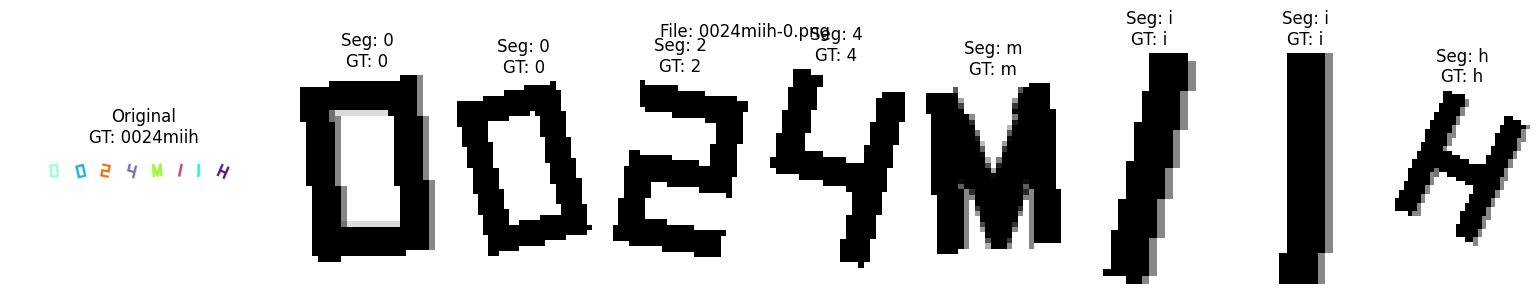

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_4964\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


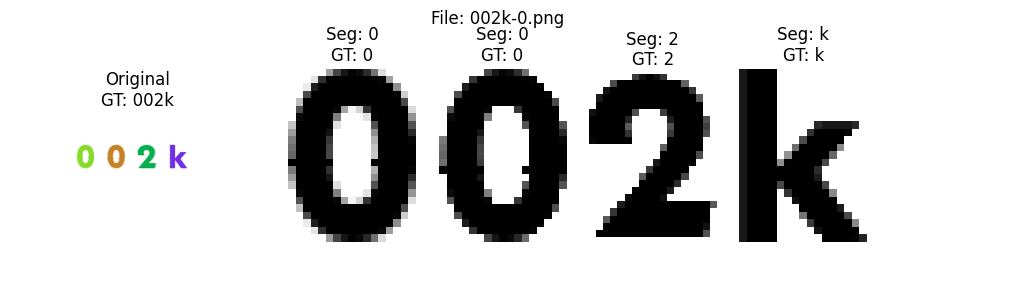

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 73).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_4964\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


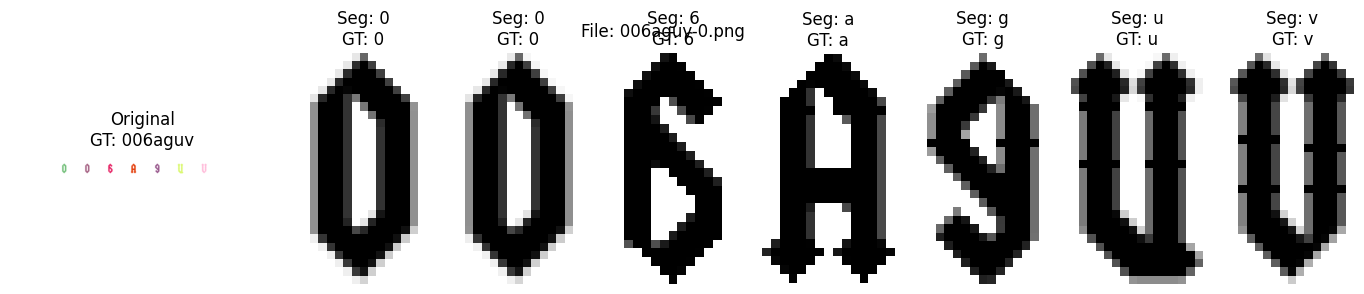

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_4964\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


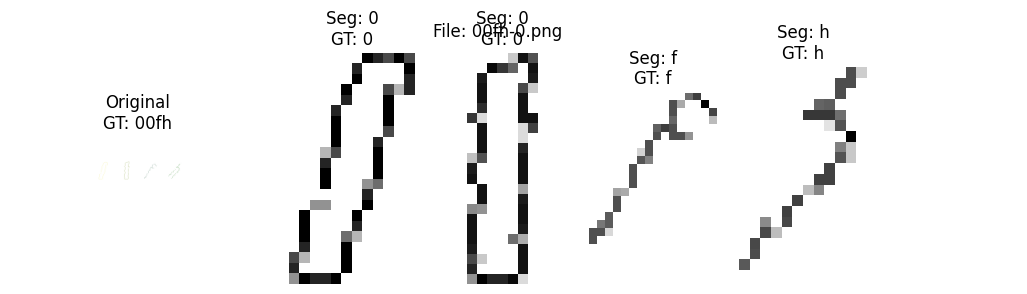

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_4964\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


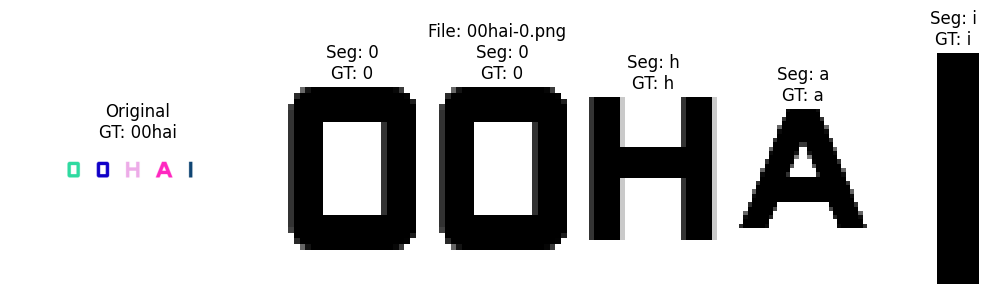

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 74).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_4964\3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


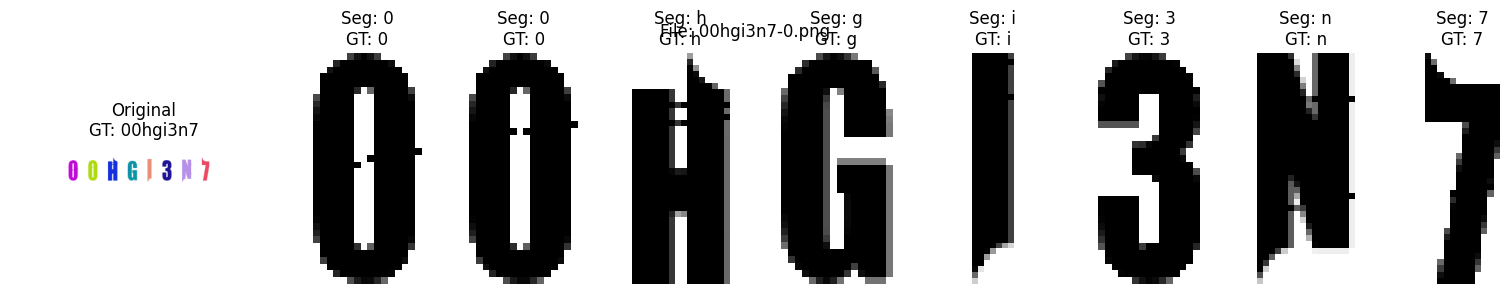

In [6]:
# Visualize original CAPTCHA alongside segmented characters for debugging
from matplotlib.gridspec import GridSpec

n_samples = 6  # how many CAPTCHAs to visualize
samples = train_img_files[:n_samples]

for img_path in samples:
    # Load original
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"[WARN] Could not read {img_path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Ground truth from filename
    gt_text = Path(img_path).stem.split('-')[0]

    # Segment characters using current pipeline
    char_images, char_labels = segment_characters(img_path)

    # Prepare layout: original on the left, characters on the right
    max_chars = max(len(char_images), len(gt_text)) if len(gt_text) > 0 else len(char_images)
    max_chars = max(5, max_chars)  # keep a minimum width for readability

    fig = plt.figure(figsize=(2 + max_chars * 2.2, 3))
    gs = GridSpec(1, max_chars + 1, width_ratios=[2] + [1] * max_chars, wspace=0.15)

    # Original image
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img_rgb)
    ax0.set_title(f"Original\nGT: {gt_text}")
    ax0.axis('off')

    # Segmented characters
    for j in range(max_chars):
        ax = fig.add_subplot(gs[0, j + 1])
        if j < len(char_images):
            ch_img = char_images[j]
            # robust grayscale for display
            if ch_img is None or ch_img.size == 0:
                ax.axis('off')
                continue
            if len(ch_img.shape) == 3:
                show_img = cv2.cvtColor(ch_img, cv2.COLOR_BGR2GRAY)
            else:
                show_img = ch_img

            # predicted label from segmentation alignment (label list) if available
            seg_label = char_labels[j] if j < len(char_labels) else '?'
            # expected char at this position (from GT) if available
            gt_char = gt_text[j] if j < len(gt_text) else ' '
            title = f"Seg: {seg_label}\nGT: {gt_char}"

            ax.imshow(show_img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle(f"File: {Path(img_path).name}")
    plt.tight_layout()
    plt.show()

## 6. Character Recognition Model

CNN-based model for recognizing individual characters.

In [7]:
class CharRecognitionCNNv2(nn.Module):
    def __init__(self, num_classes=VOCAB_SIZE, dropout=0.3):
        super().__init__()
        self.features = nn.Sequential(
            # 32x32 -> 16x16
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # 16x16 -> 8x8
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 8x8 -> 4x4
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


# Initialize model
model = CharRecognitionCNNv2(num_classes=VOCAB_SIZE).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

CharRecognitionCNNv2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, paddi

## 7. Create DataLoaders

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True  # Drop last incomplete batch to avoid BatchNorm issues
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
    # No drop_last for test - we use model.eval() which disables BatchNorm training mode
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1463
Test batches: 376


## 8. Training Setup

In [9]:
# Training hyperparameters
NUM_EPOCHS = 20
BASE_LR = 3e-3
MAX_LR = 1e-2
WEIGHT_DECAY = 1e-4

# Loss and optimizer (label smoothing helps robustness)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

# OneCycleLR for fast convergence with higher LR
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0,
)

## 9. Training Loop

In [10]:
def train_epoch(model, loader, criterion, optimizer, device, scheduler=None, max_grad_norm=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for imgs, labels, _ in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        if max_grad_norm is not None and max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        # Scheduler step per batch (OneCycle)
        if scheduler is not None:
            scheduler.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(loader), 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [11]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_acc = 0.0

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scheduler=scheduler)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Print summary
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_char_recognition_model.pth')
        print(f"✓ New best model saved! Accuracy: {best_acc:.2f}%")

print(f"\nTraining complete! Best accuracy: {best_acc:.2f}%")


Epoch 1/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 20.84it/s]



Train Loss: 2.9479, Train Acc: 22.37%
Test Loss: 2.2801, Test Acc: 47.10%
✓ New best model saved! Accuracy: 47.10%

Epoch 2/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 19.89it/s]



Train Loss: 2.1840, Train Acc: 50.59%
Test Loss: 1.8477, Test Acc: 63.56%
✓ New best model saved! Accuracy: 63.56%

Epoch 3/20


Evaluating: 100%|██████████| 376/376 [00:15<00:00, 23.85it/s]



Train Loss: 1.9569, Train Acc: 60.06%
Test Loss: 1.6945, Test Acc: 70.26%
✓ New best model saved! Accuracy: 70.26%

Epoch 4/20


Evaluating: 100%|██████████| 376/376 [00:17<00:00, 21.78it/s]



Train Loss: 1.8720, Train Acc: 63.63%
Test Loss: 1.7853, Test Acc: 67.29%

Epoch 5/20


Evaluating: 100%|██████████| 376/376 [00:16<00:00, 23.00it/s]



Train Loss: 1.8180, Train Acc: 65.75%
Test Loss: 1.6499, Test Acc: 70.93%
✓ New best model saved! Accuracy: 70.93%

Epoch 6/20


Evaluating: 100%|██████████| 376/376 [00:15<00:00, 23.99it/s]



Train Loss: 1.7859, Train Acc: 66.92%
Test Loss: 1.5890, Test Acc: 74.10%
✓ New best model saved! Accuracy: 74.10%

Epoch 7/20


Evaluating: 100%|██████████| 376/376 [00:16<00:00, 23.44it/s]



Train Loss: 1.7534, Train Acc: 68.33%
Test Loss: 1.5639, Test Acc: 73.55%

Epoch 8/20


Evaluating: 100%|██████████| 376/376 [00:15<00:00, 25.04it/s]



Train Loss: 1.7315, Train Acc: 68.95%
Test Loss: 1.5850, Test Acc: 73.66%

Epoch 9/20


Evaluating: 100%|██████████| 376/376 [00:14<00:00, 25.99it/s]



Train Loss: 1.7032, Train Acc: 70.23%
Test Loss: 1.5064, Test Acc: 76.14%
✓ New best model saved! Accuracy: 76.14%

Epoch 10/20


Evaluating: 100%|██████████| 376/376 [00:14<00:00, 25.24it/s]



Train Loss: 1.6744, Train Acc: 71.16%
Test Loss: 1.4974, Test Acc: 76.36%
✓ New best model saved! Accuracy: 76.36%

Epoch 11/20


Evaluating: 100%|██████████| 376/376 [00:16<00:00, 23.46it/s]



Train Loss: 1.6460, Train Acc: 71.76%
Test Loss: 1.5042, Test Acc: 75.82%

Epoch 12/20


Evaluating: 100%|██████████| 376/376 [00:15<00:00, 23.88it/s]



Train Loss: 1.6166, Train Acc: 72.75%
Test Loss: 1.4654, Test Acc: 76.97%
✓ New best model saved! Accuracy: 76.97%

Epoch 13/20


Evaluating: 100%|██████████| 376/376 [00:14<00:00, 25.70it/s]



Train Loss: 1.5934, Train Acc: 73.58%
Test Loss: 1.4450, Test Acc: 77.49%
✓ New best model saved! Accuracy: 77.49%

Epoch 14/20


Evaluating: 100%|██████████| 376/376 [00:12<00:00, 29.23it/s]



Train Loss: 1.5678, Train Acc: 74.32%
Test Loss: 1.4327, Test Acc: 77.93%
✓ New best model saved! Accuracy: 77.93%

Epoch 15/20


Evaluating: 100%|██████████| 376/376 [00:12<00:00, 31.26it/s]



Train Loss: 1.5446, Train Acc: 75.10%
Test Loss: 1.4143, Test Acc: 78.55%
✓ New best model saved! Accuracy: 78.55%

Epoch 16/20


Evaluating: 100%|██████████| 376/376 [00:14<00:00, 25.74it/s]



Train Loss: 1.5296, Train Acc: 75.47%
Test Loss: 1.4104, Test Acc: 78.69%
✓ New best model saved! Accuracy: 78.69%

Epoch 17/20


Evaluating: 100%|██████████| 376/376 [00:05<00:00, 74.15it/s]



Train Loss: 1.5140, Train Acc: 76.03%
Test Loss: 1.3973, Test Acc: 78.83%
✓ New best model saved! Accuracy: 78.83%

Epoch 18/20


Evaluating: 100%|██████████| 376/376 [00:05<00:00, 75.20it/s]



Train Loss: 1.4954, Train Acc: 76.45%
Test Loss: 1.3923, Test Acc: 79.06%
✓ New best model saved! Accuracy: 79.06%

Epoch 19/20


Evaluating: 100%|██████████| 376/376 [00:05<00:00, 73.75it/s]



Train Loss: 1.4888, Train Acc: 76.59%
Test Loss: 1.3892, Test Acc: 79.22%
✓ New best model saved! Accuracy: 79.22%

Epoch 20/20


Evaluating: 100%|██████████| 376/376 [00:05<00:00, 74.84it/s]


Train Loss: 1.4842, Train Acc: 76.88%
Test Loss: 1.3897, Test Acc: 79.33%
✓ New best model saved! Accuracy: 79.33%

Training complete! Best accuracy: 79.33%


## 10. Visualize Training History

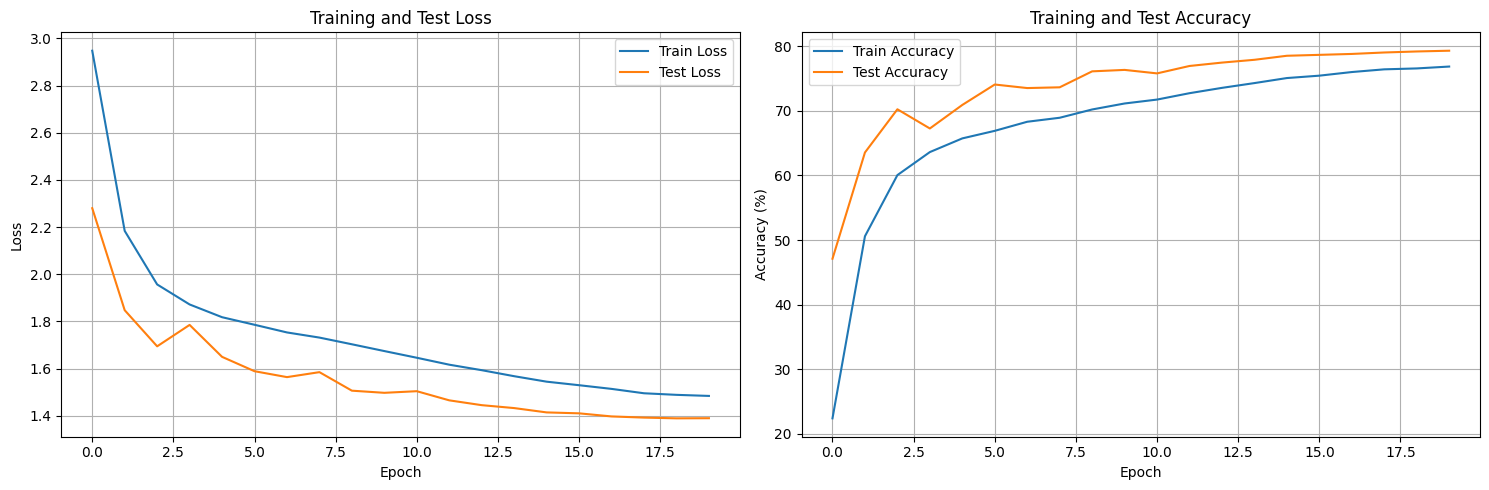

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Full CAPTCHA Recognition

Combine segmentation + recognition to decode complete CAPTCHAs.

In [13]:
def recognize_captcha(model, image_path, device, target_size=(32, 32)):
    """
    Recognize a full CAPTCHA by:
    1. Segmenting characters
    2. Recognizing each character with the CNN model
    3. Combining predictions
    """
    model.eval()
    
    # Segment characters
    char_images, _ = segment_characters(image_path)
    
    if not char_images:
        return "", []
    
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for char_img in char_images:
            # Preprocess
            if len(char_img.shape) == 3:
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
            
            h, w = char_img.shape
            target_h, target_w = target_size
            
            # Check for invalid dimensions
            if h <= 0 or w <= 0:
                continue  # Skip invalid images
            
            scale = min(target_h / h, target_w / w)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Ensure minimum size of 1x1
            new_h = max(1, new_h)
            new_w = max(1, new_w)
            
            char_img = cv2.resize(char_img, (new_w, new_h))
            
            canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
            y_offset = (target_h - new_h) // 2
            x_offset = (target_w - new_w) // 2
            canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
            
            # Convert to tensor
            char_tensor = torch.from_numpy(canvas).float() / 255.0
            char_tensor = char_tensor.unsqueeze(0).repeat(3, 1, 1)  # 3 channels
            char_tensor = char_tensor.unsqueeze(0).to(device)  # Add batch dimension
            
            # Predict
            output = model(char_tensor)
            probs = F.softmax(output, dim=1)
            confidence, predicted = probs.max(1)
            
            pred_char = id2ch[predicted.item()]
            predictions.append(pred_char)
            confidences.append(confidence.item())
    
    result = ''.join(predictions)
    return result, confidences


def visualize_captcha_prediction(image_path, model, device):
    """
    Visualize CAPTCHA recognition result
    """
    # Get ground truth
    filename = Path(image_path).stem
    gt_text = filename.split('-')[0]
    
    # Predict
    pred_text, confidences = recognize_captcha(model, image_path, device)
    
    # Load and display image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(img_rgb)
    plt.title(f"Ground Truth: {gt_text}\nPrediction: {pred_text}\nConfidence: {np.mean(confidences):.3f}")
    plt.axis('off')
    plt.show()
    
    return gt_text, pred_text

## 12. Test on Sample CAPTCHAs

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).


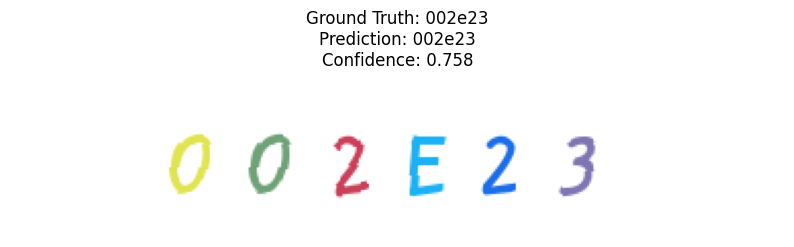

✓ Correct!

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).


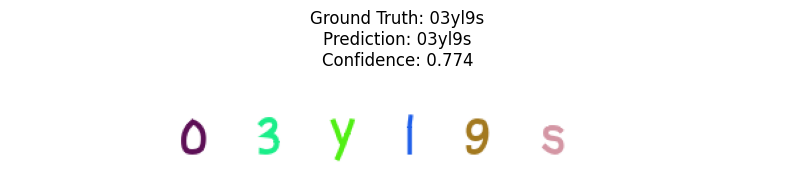

✓ Correct!

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


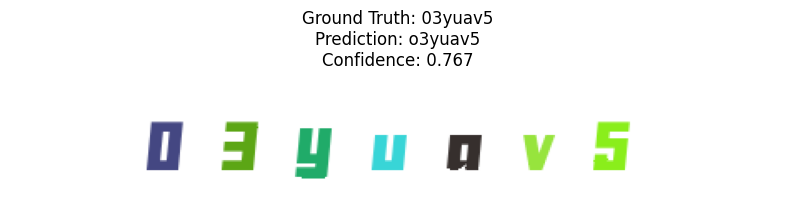

✗ Wrong. GT: 03yuav5, Pred: o3yuav5

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).


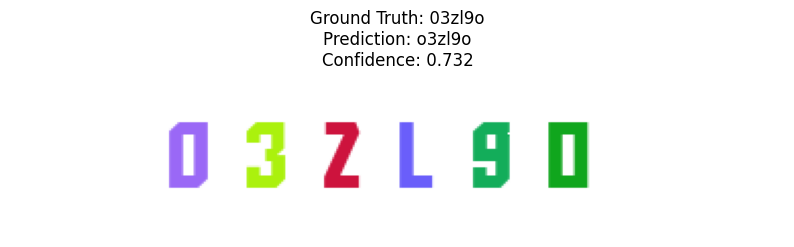

✗ Wrong. GT: 03zl9o, Pred: o3zl9o

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).


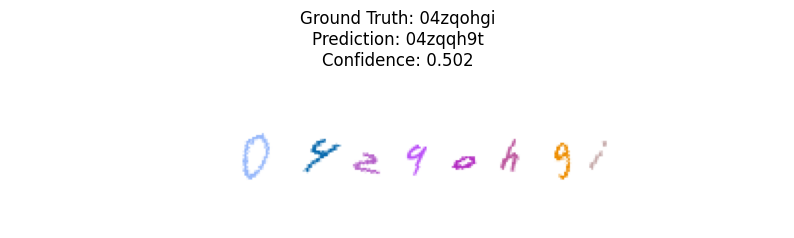

✗ Wrong. GT: 04zqohgi, Pred: 04zqqh9t


Accuracy: 2/5 = 40.00%


In [14]:
# Load best model
model.load_state_dict(torch.load('best_char_recognition_model.pth'))
model.eval()

# Test on a few samples
test_samples = test_img_files[:5]

correct = 0
total = len(test_samples)

for img_path in test_samples:
    gt, pred = visualize_captcha_prediction(img_path, model, device)
    if gt == pred:
        correct += 1
        print(f"✓ Correct!\n")
    else:
        print(f"✗ Wrong. GT: {gt}, Pred: {pred}\n")

print(f"\nAccuracy: {correct}/{total} = {100*correct/total:.2f}%")

## 13. Full Test Set Evaluation

In [15]:
def evaluate_full_captchas(model, img_paths, device):
    """
    Evaluate on full CAPTCHA images
    """
    model.eval()
    
    total = 0
    correct = 0
    char_total = 0
    char_correct = 0
    
    for img_path in tqdm(img_paths, desc="Evaluating CAPTCHAs"):
        try:
            filename = Path(img_path).stem
            gt_text = filename.split('-')[0].lower()
            
            pred_text, _ = recognize_captcha(model, img_path, device)
            pred_text = pred_text.lower()
            
            total += 1
            if gt_text == pred_text:
                correct += 1
            
            # Character-level accuracy
            for gt_ch, pred_ch in zip(gt_text, pred_text):
                char_total += 1
                if gt_ch == pred_ch:
                    char_correct += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    seq_acc = 100 * correct / total if total > 0 else 0
    char_acc = 100 * char_correct / char_total if char_total > 0 else 0
    
    print(f"\nResults on {total} CAPTCHAs:")
    print(f"Sequence Accuracy: {seq_acc:.2f}% ({correct}/{total})")
    print(f"Character Accuracy: {char_acc:.2f}% ({char_correct}/{char_total})")
    
    return seq_acc, char_acc


# Evaluate on test set
test_seq_acc, test_char_acc = evaluate_full_captchas(model, test_img_files, device)

Evaluating CAPTCHAs:   0%|          | 0/2000 [00:00<?, ?it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 1/2000 [00:00<10:59,  3.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 2/2000 [00:00<09:36,  3.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 3/2000 [00:00<10:29,  3.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 4/2000 [00:01<10:38,  3.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 5/2000 [00:01<09:44,  3.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 6/2000 [00:01<09:53,  3.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 7/2000 [00:02<09:10,  3.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 140).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 8/2000 [00:02<08:34,  3.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 9/2000 [00:02<08:11,  4.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 10/2000 [00:02<08:40,  3.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 11/2000 [00:03<09:02,  3.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 12/2000 [00:03<11:24,  2.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 13/2000 [00:03<10:07,  3.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 14/2000 [00:04<10:10,  3.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 15/2000 [00:04<09:37,  3.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 16/2000 [00:04<09:17,  3.56it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 17/2000 [00:04<08:50,  3.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 18/2000 [00:05<09:53,  3.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 19/2000 [00:05<10:18,  3.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 20/2000 [00:05<09:28,  3.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 21/2000 [00:05<08:30,  3.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:   1%|          | 22/2000 [00:06<07:53,  4.18it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:   1%|          | 23/2000 [00:06<08:10,  4.03it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:   1%|▏         | 25/2000 [00:06<07:34,  4.35it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 0).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 26/2000 [00:07<07:30,  4.38it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 27/2000 [00:07<10:45,  3.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 28/2000 [00:08<11:04,  2.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 29/2000 [00:08<10:04,  3.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 30/2000 [00:08<11:20,  2.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 123).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 31/2000 [00:08<10:16,  3.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 32/2000 [00:09<09:40,  3.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 33/2000 [00:09<08:45,  3.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 34/2000 [00:09<08:19,  3.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 35/2000 [00:09<08:15,  3.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 36/2000 [00:10<07:47,  4.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 37/2000 [00:10<08:40,  3.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 38/2000 [00:10<08:10,  4.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 39/2000 [00:10<08:21,  3.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 40/2000 [00:11<09:29,  3.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 41/2000 [00:11<10:09,  3.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:   2%|▏         | 42/2000 [00:11<08:49,  3.70it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:   2%|▏         | 43/2000 [00:12<08:29,  3.84it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:   2%|▏         | 44/2000 [00:12<08:28,  3.85it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:   2%|▏         | 45/2000 [00:12<07:57,  4.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:   2%|▏         | 47/2000 [00:12<07:15,  4.48it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 48/2000 [00:13<06:53,  4.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 49/2000 [00:13<07:19,  4.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:   3%|▎         | 51/2000 [00:13<06:09,  5.27it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 52/2000 [00:13<06:29,  5.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:   3%|▎         | 54/2000 [00:14<06:27,  5.02it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:   3%|▎         | 55/2000 [00:14<06:57,  4.66it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 56/2000 [00:14<08:44,  3.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 57/2000 [00:15<08:05,  4.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 58/2000 [00:15<08:12,  3.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 59/2000 [00:15<09:56,  3.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 60/2000 [00:16<09:07,  3.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 61/2000 [00:16<09:27,  3.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 62/2000 [00:16<09:32,  3.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 63/2000 [00:16<08:58,  3.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 64/2000 [00:17<09:26,  3.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 65/2000 [00:17<08:24,  3.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 66/2000 [00:17<08:21,  3.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 67/2000 [00:17<08:20,  3.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 68/2000 [00:18<07:53,  4.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 69/2000 [00:18<07:31,  4.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 70/2000 [00:18<08:02,  4.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 71/2000 [00:18<07:35,  4.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 72/2000 [00:19<07:30,  4.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 73/2000 [00:19<07:42,  4.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 74/2000 [00:19<08:53,  3.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 75/2000 [00:19<08:45,  3.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 76/2000 [00:20<08:16,  3.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 142).


Evaluating CAPTCHAs:   4%|▍         | 77/2000 [00:20<07:22,  4.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 78/2000 [00:20<08:16,  3.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 79/2000 [00:20<07:40,  4.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 80/2000 [00:21<09:19,  3.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 81/2000 [00:21<09:13,  3.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 82/2000 [00:21<08:34,  3.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 83/2000 [00:22<08:27,  3.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 84/2000 [00:22<09:49,  3.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 85/2000 [00:22<10:52,  2.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 86/2000 [00:23<10:58,  2.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 87/2000 [00:23<09:40,  3.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 88/2000 [00:23<08:34,  3.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 89/2000 [00:23<08:04,  3.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 125).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 90/2000 [00:24<08:00,  3.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 91/2000 [00:24<07:32,  4.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 92/2000 [00:24<07:19,  4.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 93/2000 [00:24<08:59,  3.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 94/2000 [00:25<08:35,  3.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 95/2000 [00:25<08:17,  3.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 96/2000 [00:25<07:49,  4.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 97/2000 [00:25<08:20,  3.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 98/2000 [00:26<08:17,  3.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 100).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 99/2000 [00:26<08:25,  3.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 100/2000 [00:26<09:17,  3.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 101/2000 [00:27<08:25,  3.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 102/2000 [00:27<08:00,  3.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:   5%|▌         | 103/2000 [00:27<07:34,  4.18it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:   5%|▌         | 104/2000 [00:27<07:13,  4.38it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:   5%|▌         | 105/2000 [00:27<07:17,  4.33it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:   5%|▌         | 106/2000 [00:28<07:07,  4.43it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:   5%|▌         | 107/2000 [00:28<07:15,  4.35it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:   5%|▌         | 108/2000 [00:28<07:17,  4.32it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:   5%|▌         | 109/2000 [00:28<07:07,  4.42it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 110/2000 [00:29<08:03,  3.91it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 111/2000 [00:29<08:40,  3.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 112/2000 [00:29<08:12,  3.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 113/2000 [00:29<08:39,  3.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 114/2000 [00:30<10:06,  3.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 115/2000 [00:30<09:49,  3.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 116/2000 [00:31<10:36,  2.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 117/2000 [00:31<09:55,  3.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 118/2000 [00:31<10:06,  3.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 119/2000 [00:31<08:50,  3.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 120/2000 [00:32<10:04,  3.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 121/2000 [00:32<10:25,  3.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 122/2000 [00:32<09:19,  3.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 123/2000 [00:33<08:39,  3.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 124/2000 [00:33<07:59,  3.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:   6%|▋         | 126/2000 [00:33<07:11,  4.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   6%|▋         | 127/2000 [00:33<07:26,  4.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   6%|▋         | 128/2000 [00:34<07:43,  4.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   6%|▋         | 129/2000 [00:34<07:18,  4.27it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   6%|▋         | 130/2000 [00:34<08:26,  3.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 131/2000 [00:35<08:18,  3.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 132/2000 [00:35<07:59,  3.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 133/2000 [00:35<07:55,  3.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 134/2000 [00:35<07:51,  3.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 135/2000 [00:36<08:20,  3.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 136/2000 [00:36<08:03,  3.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 137/2000 [00:36<08:15,  3.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 138/2000 [00:36<08:15,  3.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 139/2000 [00:37<08:50,  3.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 140/2000 [00:37<08:47,  3.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 141/2000 [00:37<08:31,  3.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 142/2000 [00:38<09:38,  3.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 143/2000 [00:38<08:36,  3.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 144/2000 [00:38<07:51,  3.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 145/2000 [00:38<08:00,  3.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 146/2000 [00:39<07:28,  4.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 147/2000 [00:39<08:22,  3.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 148/2000 [00:39<08:21,  3.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 149/2000 [00:39<08:26,  3.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 150/2000 [00:40<10:08,  3.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 151/2000 [00:40<09:35,  3.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 152/2000 [00:40<09:44,  3.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 153/2000 [00:41<09:22,  3.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 154/2000 [00:41<08:36,  3.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 155/2000 [00:41<07:48,  3.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:   8%|▊         | 156/2000 [00:41<07:14,  4.24it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 157/2000 [00:42<08:39,  3.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 158/2000 [00:42<08:45,  3.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 159/2000 [00:42<08:34,  3.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 160/2000 [00:43<08:04,  3.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 161/2000 [00:43<07:39,  4.00it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 162/2000 [00:43<07:26,  4.12it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 163/2000 [00:43<07:07,  4.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 164/2000 [00:43<07:09,  4.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:   8%|▊         | 165/2000 [00:44<06:55,  4.42it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 166/2000 [00:44<07:41,  3.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 167/2000 [00:44<08:19,  3.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 168/2000 [00:45<08:52,  3.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 169/2000 [00:45<08:51,  3.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 170/2000 [00:45<08:48,  3.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   9%|▊         | 171/2000 [00:45<08:42,  3.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▊         | 172/2000 [00:46<08:21,  3.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   9%|▊         | 173/2000 [00:46<09:22,  3.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▊         | 174/2000 [00:46<08:48,  3.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 175/2000 [00:47<08:09,  3.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 176/2000 [00:47<08:06,  3.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 177/2000 [00:47<07:58,  3.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 178/2000 [00:47<08:01,  3.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 179/2000 [00:48<07:56,  3.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 180/2000 [00:48<07:27,  4.06it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 181/2000 [00:48<08:13,  3.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 182/2000 [00:48<07:59,  3.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 183/2000 [00:49<08:05,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 184/2000 [00:49<07:26,  4.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 185/2000 [00:49<07:23,  4.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 186/2000 [00:49<08:04,  3.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 187/2000 [00:50<07:29,  4.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 188/2000 [00:50<08:26,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 189/2000 [00:50<08:00,  3.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 190/2000 [00:50<07:53,  3.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 191/2000 [00:51<08:20,  3.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 192/2000 [00:51<08:08,  3.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 193/2000 [00:51<08:14,  3.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 194/2000 [00:51<07:34,  3.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 195/2000 [00:52<07:48,  3.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 196/2000 [00:52<08:30,  3.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 197/2000 [00:52<08:06,  3.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 198/2000 [00:53<08:03,  3.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 199/2000 [00:53<07:36,  3.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 200/2000 [00:53<07:32,  3.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 201/2000 [00:53<07:08,  4.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 202/2000 [00:54<09:17,  3.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 203/2000 [00:54<10:20,  2.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 204/2000 [00:54<09:23,  3.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 205/2000 [00:55<09:56,  3.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 206/2000 [00:55<09:33,  3.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 207/2000 [00:55<08:39,  3.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 208/2000 [00:56<08:02,  3.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 209/2000 [00:56<07:57,  3.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 210/2000 [00:56<07:21,  4.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 211/2000 [00:56<07:10,  4.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 212/2000 [00:56<06:55,  4.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 213/2000 [00:57<06:55,  4.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  11%|█         | 214/2000 [00:57<06:34,  4.52it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  11%|█         | 215/2000 [00:57<06:28,  4.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  11%|█         | 216/2000 [00:57<06:52,  4.33it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  11%|█         | 218/2000 [00:58<06:52,  4.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 219/2000 [00:58<06:41,  4.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 220/2000 [00:58<06:44,  4.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 221/2000 [00:59<08:07,  3.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 222/2000 [00:59<07:55,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 223/2000 [00:59<08:20,  3.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 224/2000 [01:00<09:00,  3.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  11%|█▏        | 225/2000 [01:00<08:02,  3.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  11%|█▏        | 226/2000 [01:00<07:34,  3.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  11%|█▏        | 227/2000 [01:00<07:59,  3.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  11%|█▏        | 228/2000 [01:01<08:05,  3.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  11%|█▏        | 229/2000 [01:01<08:32,  3.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 230/2000 [01:01<09:20,  3.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 231/2000 [01:02<09:39,  3.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 232/2000 [01:02<09:20,  3.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 233/2000 [01:02<09:19,  3.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 234/2000 [01:02<08:48,  3.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 235/2000 [01:03<08:55,  3.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 276).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 236/2000 [01:03<08:48,  3.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 237/2000 [01:03<08:28,  3.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 238/2000 [01:04<08:21,  3.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 239/2000 [01:04<07:53,  3.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 240/2000 [01:04<08:47,  3.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 241/2000 [01:04<07:56,  3.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 242/2000 [01:05<07:22,  3.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 243/2000 [01:05<07:34,  3.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 244/2000 [01:05<07:02,  4.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 245/2000 [01:05<07:04,  4.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 246/2000 [01:06<07:20,  3.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 247/2000 [01:06<07:07,  4.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 248/2000 [01:06<07:11,  4.06it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 249/2000 [01:06<07:16,  4.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▎        | 250/2000 [01:07<06:35,  4.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  13%|█▎        | 251/2000 [01:07<06:29,  4.49it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 252/2000 [01:07<07:42,  3.78it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 253/2000 [01:07<08:25,  3.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 254/2000 [01:08<08:16,  3.52it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 255/2000 [01:08<07:38,  3.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 256/2000 [01:08<07:14,  4.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 257/2000 [01:08<07:03,  4.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 258/2000 [01:09<07:11,  4.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 259/2000 [01:09<06:47,  4.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  13%|█▎        | 261/2000 [01:09<06:12,  4.67it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 262/2000 [01:10<06:39,  4.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 263/2000 [01:10<06:39,  4.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 264/2000 [01:10<06:35,  4.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 265/2000 [01:10<07:56,  3.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 266/2000 [01:11<07:39,  3.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 267/2000 [01:11<07:37,  3.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 268/2000 [01:11<07:47,  3.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 269/2000 [01:11<07:10,  4.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▎        | 270/2000 [01:12<06:39,  4.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  14%|█▎        | 271/2000 [01:12<06:32,  4.41it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).


Evaluating CAPTCHAs:  14%|█▎        | 272/2000 [01:12<06:31,  4.41it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  14%|█▎        | 274/2000 [01:12<06:03,  4.75it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 275/2000 [01:13<06:34,  4.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 276/2000 [01:13<06:01,  4.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 277/2000 [01:13<07:50,  3.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 278/2000 [01:13<07:50,  3.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 279/2000 [01:14<07:29,  3.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 280/2000 [01:14<08:56,  3.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 281/2000 [01:14<08:47,  3.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 282/2000 [01:15<07:54,  3.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 283/2000 [01:15<07:30,  3.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 284/2000 [01:15<07:16,  3.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 285/2000 [01:15<06:57,  4.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 286/2000 [01:16<06:30,  4.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 287/2000 [01:16<07:18,  3.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 288/2000 [01:16<07:02,  4.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 289/2000 [01:16<07:08,  4.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 290/2000 [01:17<08:13,  3.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 134).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 291/2000 [01:17<07:14,  3.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  15%|█▍        | 293/2000 [01:17<06:22,  4.47it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 294/2000 [01:18<06:22,  4.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 295/2000 [01:18<07:03,  4.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 296/2000 [01:18<06:41,  4.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 297/2000 [01:18<06:59,  4.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 298/2000 [01:19<07:33,  3.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 299/2000 [01:19<07:48,  3.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 300/2000 [01:19<07:11,  3.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 301/2000 [01:19<07:38,  3.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 302/2000 [01:20<07:12,  3.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 303/2000 [01:20<06:58,  4.06it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 304/2000 [01:20<06:53,  4.10it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 305/2000 [01:20<06:44,  4.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 306/2000 [01:21<06:47,  4.15it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 307/2000 [01:21<07:46,  3.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 308/2000 [01:21<08:18,  3.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 309/2000 [01:22<08:27,  3.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 310/2000 [01:22<08:06,  3.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 311/2000 [01:22<08:13,  3.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 312/2000 [01:22<08:31,  3.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 117).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 313/2000 [01:23<08:49,  3.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 314/2000 [01:23<08:06,  3.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 315/2000 [01:23<07:47,  3.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  16%|█▌        | 317/2000 [01:24<06:33,  4.28it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 318/2000 [01:24<06:08,  4.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 319/2000 [01:24<06:03,  4.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  16%|█▌        | 320/2000 [01:24<06:04,  4.61it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  16%|█▌        | 321/2000 [01:25<06:10,  4.53it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 322/2000 [01:25<07:00,  3.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 323/2000 [01:25<06:40,  4.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  16%|█▌        | 324/2000 [01:25<06:11,  4.52it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 325/2000 [01:26<07:07,  3.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 326/2000 [01:26<07:13,  3.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 327/2000 [01:26<06:58,  3.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 328/2000 [01:26<07:10,  3.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 329/2000 [01:27<07:06,  3.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 330/2000 [01:27<07:51,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 331/2000 [01:27<07:56,  3.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 332/2000 [01:27<07:21,  3.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 333/2000 [01:28<08:36,  3.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 334/2000 [01:28<07:39,  3.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 335/2000 [01:28<07:45,  3.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 336/2000 [01:29<07:09,  3.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 337/2000 [01:29<06:54,  4.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 338/2000 [01:29<07:06,  3.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 339/2000 [01:29<06:54,  4.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 340/2000 [01:30<07:23,  3.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 341/2000 [01:30<07:04,  3.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 342/2000 [01:30<07:04,  3.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 343/2000 [01:30<07:05,  3.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 344/2000 [01:31<06:35,  4.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 166).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 345/2000 [01:31<06:38,  4.15it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 346/2000 [01:31<06:15,  4.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 347/2000 [01:31<06:47,  4.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 348/2000 [01:31<06:41,  4.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 349/2000 [01:32<07:46,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 350/2000 [01:32<08:05,  3.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 351/2000 [01:33<08:24,  3.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 352/2000 [01:33<08:11,  3.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 353/2000 [01:33<07:23,  3.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 354/2000 [01:33<07:42,  3.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 355/2000 [01:34<07:24,  3.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 356/2000 [01:34<07:19,  3.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 357/2000 [01:34<06:45,  4.05it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 358/2000 [01:34<07:12,  3.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 359/2000 [01:35<07:16,  3.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 360/2000 [01:35<08:20,  3.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 361/2000 [01:35<08:13,  3.32it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 362/2000 [01:36<07:53,  3.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 363/2000 [01:36<07:14,  3.77it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 364/2000 [01:36<09:25,  2.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 365/2000 [01:37<10:24,  2.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 366/2000 [01:37<09:31,  2.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 367/2000 [01:37<08:05,  3.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 368/2000 [01:37<07:49,  3.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 369/2000 [01:38<07:11,  3.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 370/2000 [01:38<07:39,  3.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▊        | 371/2000 [01:38<08:23,  3.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▊        | 372/2000 [01:39<07:48,  3.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▊        | 373/2000 [01:39<09:32,  2.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▊        | 374/2000 [01:39<08:47,  3.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 375/2000 [01:40<07:53,  3.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 376/2000 [01:40<08:25,  3.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 377/2000 [01:40<08:05,  3.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 378/2000 [01:40<07:52,  3.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 379/2000 [01:41<06:56,  3.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 380/2000 [01:41<06:50,  3.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 381/2000 [01:41<07:30,  3.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 382/2000 [01:42<07:19,  3.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 383/2000 [01:42<06:44,  4.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 384/2000 [01:42<06:32,  4.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 385/2000 [01:42<07:35,  3.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 386/2000 [01:43<07:40,  3.51it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 387/2000 [01:43<07:23,  3.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 388/2000 [01:43<07:53,  3.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 389/2000 [01:44<08:25,  3.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 390/2000 [01:44<07:45,  3.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 391/2000 [01:44<07:17,  3.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 392/2000 [01:44<07:14,  3.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 393/2000 [01:45<07:15,  3.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 394/2000 [01:45<06:43,  3.98it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  20%|█▉        | 395/2000 [01:45<06:16,  4.26it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 396/2000 [01:45<06:37,  4.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 397/2000 [01:45<06:48,  3.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 398/2000 [01:46<06:43,  3.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 399/2000 [01:46<06:07,  4.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 400/2000 [01:46<06:39,  4.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 401/2000 [01:46<06:44,  3.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 402/2000 [01:47<06:30,  4.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 403/2000 [01:47<06:14,  4.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 404/2000 [01:47<06:42,  3.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  20%|██        | 405/2000 [01:47<05:52,  4.53it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 406/2000 [01:48<06:48,  3.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 407/2000 [01:48<06:48,  3.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 408/2000 [01:48<07:25,  3.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 409/2000 [01:49<07:06,  3.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 410/2000 [01:49<06:47,  3.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 411/2000 [01:49<06:48,  3.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 412/2000 [01:49<06:42,  3.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 413/2000 [01:49<06:09,  4.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 414/2000 [01:50<06:19,  4.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 415/2000 [01:50<07:20,  3.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 416/2000 [01:51<08:58,  2.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 417/2000 [01:51<08:29,  3.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 418/2000 [01:51<07:55,  3.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 419/2000 [01:51<07:21,  3.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 420/2000 [01:52<07:26,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 421/2000 [01:52<07:22,  3.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 422/2000 [01:52<06:43,  3.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 423/2000 [01:52<07:32,  3.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 424/2000 [01:53<07:33,  3.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 425/2000 [01:53<08:40,  3.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 426/2000 [01:53<08:10,  3.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 427/2000 [01:54<07:20,  3.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 428/2000 [01:54<07:35,  3.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 429/2000 [01:54<08:39,  3.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 430/2000 [01:55<07:24,  3.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 431/2000 [01:55<07:18,  3.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 432/2000 [01:55<07:15,  3.60it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 197).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 433/2000 [01:55<07:03,  3.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 434/2000 [01:56<07:07,  3.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 435/2000 [01:56<06:42,  3.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 436/2000 [01:56<06:52,  3.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 437/2000 [01:56<07:08,  3.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 438/2000 [01:57<06:50,  3.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 439/2000 [01:57<07:06,  3.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 440/2000 [01:57<06:50,  3.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 441/2000 [01:57<06:38,  3.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 442/2000 [01:58<06:14,  4.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 443/2000 [01:58<07:00,  3.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 444/2000 [01:58<06:32,  3.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 445/2000 [01:58<06:18,  4.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 446/2000 [01:59<05:44,  4.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  22%|██▏       | 448/2000 [01:59<05:27,  4.74it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 449/2000 [01:59<06:49,  3.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▎       | 450/2000 [02:00<06:57,  3.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 451/2000 [02:00<06:34,  3.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 452/2000 [02:00<06:21,  4.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 453/2000 [02:00<05:57,  4.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 454/2000 [02:01<05:48,  4.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 455/2000 [02:01<06:09,  4.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 456/2000 [02:01<06:12,  4.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 457/2000 [02:01<05:55,  4.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 458/2000 [02:01<06:14,  4.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 459/2000 [02:02<05:47,  4.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 460/2000 [02:02<06:05,  4.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 461/2000 [02:02<06:06,  4.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 462/2000 [02:02<05:59,  4.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 463/2000 [02:03<05:58,  4.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 464/2000 [02:03<05:59,  4.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 465/2000 [02:03<05:43,  4.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  23%|██▎       | 466/2000 [02:03<05:39,  4.52it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  23%|██▎       | 467/2000 [02:04<05:38,  4.53it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 468/2000 [02:04<06:21,  4.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 469/2000 [02:04<07:11,  3.54it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▎       | 470/2000 [02:04<06:20,  4.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  24%|██▎       | 471/2000 [02:05<06:13,  4.10it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).


Evaluating CAPTCHAs:  24%|██▎       | 473/2000 [02:05<05:32,  4.59it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▎       | 474/2000 [02:05<05:39,  4.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 475/2000 [02:05<05:26,  4.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 476/2000 [02:06<05:52,  4.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 477/2000 [02:06<06:21,  3.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 478/2000 [02:06<07:38,  3.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 479/2000 [02:07<07:23,  3.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 480/2000 [02:07<07:12,  3.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 481/2000 [02:07<06:36,  3.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 482/2000 [02:07<06:09,  4.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 483/2000 [02:08<06:38,  3.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 484/2000 [02:08<07:14,  3.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 485/2000 [02:08<06:28,  3.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 486/2000 [02:08<06:17,  4.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 487/2000 [02:09<06:38,  3.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 488/2000 [02:09<06:38,  3.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 489/2000 [02:09<07:40,  3.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 135).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 490/2000 [02:10<07:05,  3.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 491/2000 [02:10<07:38,  3.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 492/2000 [02:10<07:11,  3.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 493/2000 [02:10<06:37,  3.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 494/2000 [02:11<06:18,  3.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 495/2000 [02:11<06:36,  3.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 496/2000 [02:11<06:23,  3.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 497/2000 [02:11<06:06,  4.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 498/2000 [02:12<05:42,  4.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 499/2000 [02:12<05:52,  4.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 500/2000 [02:12<05:45,  4.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 501/2000 [02:12<05:41,  4.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 502/2000 [02:13<06:30,  3.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 503/2000 [02:13<05:59,  4.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 504/2000 [02:13<05:52,  4.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 505/2000 [02:13<07:04,  3.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 506/2000 [02:14<07:21,  3.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 507/2000 [02:14<08:38,  2.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 508/2000 [02:15<08:40,  2.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 509/2000 [02:15<09:40,  2.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 510/2000 [02:15<09:39,  2.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 511/2000 [02:16<08:24,  2.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 512/2000 [02:16<08:20,  2.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 513/2000 [02:16<08:13,  3.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 514/2000 [02:17<07:33,  3.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 515/2000 [02:17<07:54,  3.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 516/2000 [02:17<07:06,  3.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 517/2000 [02:17<07:27,  3.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 518/2000 [02:18<07:08,  3.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 519/2000 [02:18<06:26,  3.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 520/2000 [02:18<06:31,  3.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 521/2000 [02:18<06:34,  3.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 522/2000 [02:19<06:36,  3.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 523/2000 [02:19<06:21,  3.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 524/2000 [02:19<06:46,  3.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 525/2000 [02:19<06:11,  3.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 526/2000 [02:20<06:13,  3.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 527/2000 [02:20<05:46,  4.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 529/2000 [02:20<04:55,  4.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 530/2000 [02:20<04:58,  4.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  27%|██▋       | 531/2000 [02:21<05:02,  4.86it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  27%|██▋       | 532/2000 [02:21<05:22,  4.56it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  27%|██▋       | 533/2000 [02:21<05:27,  4.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  27%|██▋       | 534/2000 [02:21<05:49,  4.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  27%|██▋       | 535/2000 [02:22<05:43,  4.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  27%|██▋       | 537/2000 [02:22<05:08,  4.74it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 538/2000 [02:22<05:11,  4.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  27%|██▋       | 540/2000 [02:23<04:53,  4.97it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 541/2000 [02:23<05:25,  4.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 542/2000 [02:23<06:12,  3.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 543/2000 [02:23<05:56,  4.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 544/2000 [02:24<06:20,  3.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 545/2000 [02:24<06:06,  3.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  27%|██▋       | 546/2000 [02:24<05:34,  4.34it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 547/2000 [02:25<06:28,  3.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 548/2000 [02:25<06:01,  4.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 549/2000 [02:25<06:19,  3.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 550/2000 [02:25<06:13,  3.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 161).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 551/2000 [02:26<07:27,  3.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 552/2000 [02:26<07:40,  3.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 553/2000 [02:26<07:24,  3.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 554/2000 [02:27<07:29,  3.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 555/2000 [02:27<06:47,  3.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 556/2000 [02:27<06:42,  3.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 557/2000 [02:27<05:57,  4.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 558/2000 [02:28<06:11,  3.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 559/2000 [02:28<05:49,  4.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 560/2000 [02:28<06:41,  3.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 561/2000 [02:28<06:05,  3.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  28%|██▊       | 562/2000 [02:29<05:39,  4.24it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  28%|██▊       | 564/2000 [02:29<05:34,  4.29it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 565/2000 [02:29<05:13,  4.57it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  28%|██▊       | 566/2000 [02:29<05:08,  4.65it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  28%|██▊       | 568/2000 [02:30<04:51,  4.91it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 569/2000 [02:30<05:21,  4.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 570/2000 [02:30<05:09,  4.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▊       | 571/2000 [02:31<05:18,  4.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▊       | 572/2000 [02:31<05:55,  4.01it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▊       | 573/2000 [02:31<05:54,  4.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▊       | 574/2000 [02:31<06:08,  3.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 575/2000 [02:32<06:46,  3.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 576/2000 [02:32<06:22,  3.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 577/2000 [02:32<06:42,  3.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 578/2000 [02:32<06:27,  3.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 579/2000 [02:33<06:51,  3.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 580/2000 [02:33<06:57,  3.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 581/2000 [02:33<06:31,  3.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 582/2000 [02:34<06:47,  3.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 583/2000 [02:34<08:09,  2.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 584/2000 [02:34<07:12,  3.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 585/2000 [02:35<07:00,  3.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 586/2000 [02:35<06:47,  3.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 587/2000 [02:35<06:45,  3.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 588/2000 [02:35<06:43,  3.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 589/2000 [02:36<06:15,  3.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 590/2000 [02:36<05:49,  4.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 591/2000 [02:36<05:19,  4.41it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).


Evaluating CAPTCHAs:  30%|██▉       | 592/2000 [02:36<05:06,  4.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  30%|██▉       | 593/2000 [02:36<05:00,  4.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 594/2000 [02:37<06:12,  3.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 595/2000 [02:37<06:15,  3.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 596/2000 [02:37<06:08,  3.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 597/2000 [02:38<05:38,  4.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 598/2000 [02:38<05:44,  4.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 599/2000 [02:38<06:11,  3.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 600/2000 [02:38<05:53,  3.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 601/2000 [02:39<05:32,  4.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 602/2000 [02:39<05:56,  3.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 603/2000 [02:39<05:21,  4.34it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  30%|███       | 604/2000 [02:39<05:04,  4.58it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  30%|███       | 606/2000 [02:40<05:09,  4.50it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 607/2000 [02:40<05:19,  4.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 608/2000 [02:40<05:00,  4.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 609/2000 [02:40<05:46,  4.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 610/2000 [02:41<05:24,  4.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 611/2000 [02:41<05:33,  4.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 612/2000 [02:41<05:17,  4.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  31%|███       | 614/2000 [02:41<04:47,  4.82it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 615/2000 [02:42<05:02,  4.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 616/2000 [02:42<05:11,  4.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 617/2000 [02:42<05:26,  4.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 618/2000 [02:42<05:34,  4.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 619/2000 [02:43<06:12,  3.71it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 620/2000 [02:43<06:06,  3.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 621/2000 [02:43<05:34,  4.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 622/2000 [02:44<06:41,  3.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 623/2000 [02:44<06:11,  3.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 624/2000 [02:44<05:36,  4.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  31%|███▏      | 625/2000 [02:44<06:11,  3.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  31%|███▏      | 626/2000 [02:45<05:51,  3.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  31%|███▏      | 627/2000 [02:45<05:37,  4.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  31%|███▏      | 628/2000 [02:45<05:53,  3.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  31%|███▏      | 629/2000 [02:45<05:57,  3.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 630/2000 [02:46<05:51,  3.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 631/2000 [02:46<05:40,  4.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 632/2000 [02:46<05:15,  4.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 633/2000 [02:46<05:26,  4.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 634/2000 [02:47<05:41,  4.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 635/2000 [02:47<05:40,  4.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 636/2000 [02:47<05:31,  4.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 637/2000 [02:47<05:54,  3.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 638/2000 [02:48<06:42,  3.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 639/2000 [02:48<06:28,  3.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 640/2000 [02:48<06:52,  3.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 641/2000 [02:49<06:46,  3.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 642/2000 [02:49<06:25,  3.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 643/2000 [02:49<06:00,  3.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 644/2000 [02:50<07:10,  3.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 645/2000 [02:50<06:25,  3.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 646/2000 [02:50<07:00,  3.22it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 647/2000 [02:50<06:31,  3.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 648/2000 [02:51<06:00,  3.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 649/2000 [02:51<05:43,  3.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▎      | 650/2000 [02:51<05:28,  4.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 651/2000 [02:51<06:47,  3.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 652/2000 [02:52<06:37,  3.39it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 653/2000 [02:52<06:28,  3.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 654/2000 [02:52<06:24,  3.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 655/2000 [02:52<05:37,  3.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 656/2000 [02:53<05:29,  4.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 657/2000 [02:53<05:28,  4.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 658/2000 [02:53<05:13,  4.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 659/2000 [02:53<04:58,  4.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  33%|███▎      | 661/2000 [02:54<04:32,  4.91it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 662/2000 [02:54<04:33,  4.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 663/2000 [02:54<04:38,  4.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 664/2000 [02:54<05:11,  4.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 665/2000 [02:55<05:55,  3.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 666/2000 [02:55<06:04,  3.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 667/2000 [02:55<05:34,  3.98it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 668/2000 [02:55<05:15,  4.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 669/2000 [02:56<05:51,  3.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▎      | 670/2000 [02:56<05:32,  4.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▎      | 671/2000 [02:56<05:16,  4.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▎      | 672/2000 [02:57<05:36,  3.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▎      | 673/2000 [02:57<05:37,  3.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▎      | 674/2000 [02:57<05:41,  3.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  34%|███▍      | 675/2000 [02:57<05:13,  4.23it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 676/2000 [02:58<05:59,  3.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 677/2000 [02:58<05:43,  3.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  34%|███▍      | 678/2000 [02:58<05:17,  4.17it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  34%|███▍      | 680/2000 [02:58<04:55,  4.46it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 681/2000 [02:59<04:47,  4.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 682/2000 [02:59<04:52,  4.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 683/2000 [02:59<04:49,  4.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 684/2000 [03:00<06:56,  3.16it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 685/2000 [03:00<06:43,  3.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 686/2000 [03:00<06:37,  3.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 687/2000 [03:00<06:23,  3.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 688/2000 [03:01<06:05,  3.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 689/2000 [03:01<05:52,  3.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 690/2000 [03:01<05:25,  4.02it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 691/2000 [03:01<05:22,  4.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 692/2000 [03:02<05:39,  3.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 693/2000 [03:02<05:19,  4.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 694/2000 [03:02<05:18,  4.10it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 695/2000 [03:02<05:01,  4.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 696/2000 [03:03<04:59,  4.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 698/2000 [03:03<04:34,  4.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 699/2000 [03:03<04:08,  5.24it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  35%|███▌      | 701/2000 [03:04<04:09,  5.20it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 702/2000 [03:04<03:58,  5.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  35%|███▌      | 704/2000 [03:04<03:51,  5.61it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 705/2000 [03:04<04:03,  5.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  35%|███▌      | 707/2000 [03:05<03:59,  5.39it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 708/2000 [03:05<03:51,  5.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  36%|███▌      | 710/2000 [03:05<03:50,  5.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 712/2000 [03:05<03:44,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 713/2000 [03:06<03:53,  5.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  36%|███▌      | 714/2000 [03:06<03:59,  5.38it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  36%|███▌      | 715/2000 [03:06<04:17,  4.98it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  36%|███▌      | 717/2000 [03:06<04:03,  5.26it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 718/2000 [03:07<04:26,  4.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 720/2000 [03:07<04:05,  5.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 722/2000 [03:07<03:39,  5.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 723/2000 [03:08<04:21,  4.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▋      | 725/2000 [03:08<04:41,  4.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 105).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▋      | 726/2000 [03:08<04:42,  4.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  36%|███▋      | 728/2000 [03:09<04:16,  4.96it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▋      | 729/2000 [03:09<04:58,  4.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▋      | 730/2000 [03:09<04:44,  4.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  37%|███▋      | 732/2000 [03:10<04:12,  5.01it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 734/2000 [03:10<03:51,  5.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 736/2000 [03:10<03:36,  5.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 737/2000 [03:10<03:45,  5.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 738/2000 [03:11<04:13,  4.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  37%|███▋      | 740/2000 [03:11<03:59,  5.26it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 741/2000 [03:11<03:51,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 742/2000 [03:11<04:06,  5.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  37%|███▋      | 744/2000 [03:12<04:01,  5.21it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 745/2000 [03:12<04:13,  4.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 746/2000 [03:12<04:18,  4.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 747/2000 [03:13<04:18,  4.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 748/2000 [03:13<04:30,  4.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  38%|███▊      | 750/2000 [03:13<03:52,  5.37it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 752/2000 [03:13<03:38,  5.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 753/2000 [03:14<03:43,  5.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 754/2000 [03:14<04:01,  5.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 756/2000 [03:14<03:46,  5.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 757/2000 [03:14<03:51,  5.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 758/2000 [03:15<03:55,  5.28it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  38%|███▊      | 760/2000 [03:15<03:53,  5.30it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 761/2000 [03:15<03:47,  5.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 763/2000 [03:15<03:46,  5.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 764/2000 [03:16<04:09,  4.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  38%|███▊      | 765/2000 [03:16<04:07,  4.99it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  38%|███▊      | 767/2000 [03:16<03:56,  5.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 768/2000 [03:17<04:03,  5.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).


Evaluating CAPTCHAs:  38%|███▊      | 769/2000 [03:17<04:01,  5.10it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▊      | 771/2000 [03:17<03:57,  5.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▊      | 773/2000 [03:17<03:34,  5.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▊      | 774/2000 [03:18<03:35,  5.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  39%|███▉      | 776/2000 [03:18<03:51,  5.29it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 778/2000 [03:18<03:44,  5.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 779/2000 [03:19<04:27,  4.57it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 780/2000 [03:19<04:30,  4.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 781/2000 [03:19<04:35,  4.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  39%|███▉      | 782/2000 [03:19<04:13,  4.80it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  39%|███▉      | 784/2000 [03:20<04:01,  5.04it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 785/2000 [03:20<04:16,  4.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  39%|███▉      | 786/2000 [03:20<04:08,  4.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 96).


Evaluating CAPTCHAs:  39%|███▉      | 787/2000 [03:20<04:14,  4.77it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  39%|███▉      | 788/2000 [03:21<04:18,  4.68it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  39%|███▉      | 789/2000 [03:21<04:18,  4.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  40%|███▉      | 791/2000 [03:21<04:20,  4.65it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 792/2000 [03:21<04:06,  4.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).


Evaluating CAPTCHAs:  40%|███▉      | 793/2000 [03:22<03:56,  5.11it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 794/2000 [03:22<04:35,  4.37it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  40%|███▉      | 796/2000 [03:22<04:10,  4.81it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 797/2000 [03:22<04:04,  4.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  40%|███▉      | 799/2000 [03:23<03:47,  5.28it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 800/2000 [03:23<04:17,  4.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  40%|████      | 802/2000 [03:23<04:02,  4.95it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 803/2000 [03:24<03:50,  5.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 804/2000 [03:24<04:41,  4.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  40%|████      | 806/2000 [03:24<03:53,  5.10it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 808/2000 [03:25<03:34,  5.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 810/2000 [03:25<03:25,  5.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 812/2000 [03:25<03:22,  5.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 813/2000 [03:26<03:43,  5.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  41%|████      | 815/2000 [03:26<03:34,  5.53it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 816/2000 [03:26<03:35,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  41%|████      | 817/2000 [03:26<03:31,  5.58it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  41%|████      | 819/2000 [03:27<03:29,  5.65it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 820/2000 [03:27<03:38,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  41%|████      | 822/2000 [03:27<03:26,  5.71it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 823/2000 [03:27<03:44,  5.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  41%|████▏     | 825/2000 [03:28<03:46,  5.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  41%|████▏     | 826/2000 [03:28<03:44,  5.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).


Evaluating CAPTCHAs:  41%|████▏     | 827/2000 [03:28<03:38,  5.38it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  41%|████▏     | 829/2000 [03:29<03:43,  5.24it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 109).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 831/2000 [03:29<03:45,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 833/2000 [03:29<03:36,  5.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 835/2000 [03:30<03:23,  5.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 836/2000 [03:30<03:26,  5.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  42%|████▏     | 838/2000 [03:30<03:27,  5.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 839/2000 [03:30<03:25,  5.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 840/2000 [03:31<03:52,  5.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:  42%|████▏     | 842/2000 [03:31<03:39,  5.28it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 843/2000 [03:31<03:40,  5.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 844/2000 [03:31<04:03,  4.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  42%|████▏     | 845/2000 [03:32<03:46,  5.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 73).


Evaluating CAPTCHAs:  42%|████▏     | 847/2000 [03:32<03:50,  5.01it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 848/2000 [03:32<03:41,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 849/2000 [03:32<04:19,  4.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).


Evaluating CAPTCHAs:  42%|████▎     | 850/2000 [03:33<03:54,  4.91it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:  43%|████▎     | 851/2000 [03:33<03:54,  4.90it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 123).


Evaluating CAPTCHAs:  43%|████▎     | 853/2000 [03:33<03:30,  5.44it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 855/2000 [03:33<03:14,  5.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 856/2000 [03:34<03:28,  5.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  43%|████▎     | 857/2000 [03:34<03:35,  5.29it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  43%|████▎     | 859/2000 [03:34<03:32,  5.36it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 860/2000 [03:35<03:58,  4.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  43%|████▎     | 862/2000 [03:35<03:35,  5.28it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 863/2000 [03:35<03:26,  5.51it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  43%|████▎     | 865/2000 [03:35<03:32,  5.33it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  43%|████▎     | 866/2000 [03:36<03:36,  5.23it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 868/2000 [03:36<03:16,  5.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 869/2000 [03:36<03:27,  5.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▎     | 870/2000 [03:36<03:46,  4.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  44%|████▎     | 872/2000 [03:37<03:36,  5.22it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▎     | 873/2000 [03:37<03:51,  4.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▎     | 874/2000 [03:37<04:03,  4.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 875/2000 [03:37<04:14,  4.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 876/2000 [03:38<04:35,  4.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  44%|████▍     | 877/2000 [03:38<04:17,  4.37it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 878/2000 [03:38<04:53,  3.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 879/2000 [03:38<04:42,  3.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 881/2000 [03:39<03:57,  4.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 882/2000 [03:39<03:50,  4.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 883/2000 [03:39<03:46,  4.92it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 84).


Evaluating CAPTCHAs:  44%|████▍     | 885/2000 [03:40<03:38,  5.10it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 886/2000 [03:40<03:32,  5.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 887/2000 [03:40<03:52,  4.79it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  44%|████▍     | 888/2000 [03:40<03:48,  4.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 889/2000 [03:41<04:11,  4.42it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 890/2000 [03:41<04:23,  4.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  45%|████▍     | 892/2000 [03:41<03:54,  4.73it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 893/2000 [03:41<03:46,  4.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 894/2000 [03:42<03:45,  4.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  45%|████▍     | 895/2000 [03:42<03:44,  4.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  45%|████▍     | 897/2000 [03:42<03:44,  4.91it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 898/2000 [03:42<03:45,  4.90it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 899/2000 [03:43<03:41,  4.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 900/2000 [03:43<04:08,  4.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  45%|████▌     | 902/2000 [03:43<03:48,  4.80it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  45%|████▌     | 904/2000 [03:44<03:42,  4.93it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 906/2000 [03:44<03:17,  5.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 908/2000 [03:44<03:22,  5.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 909/2000 [03:45<03:26,  5.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 910/2000 [03:45<03:34,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  46%|████▌     | 911/2000 [03:45<03:26,  5.26it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  46%|████▌     | 912/2000 [03:45<03:41,  4.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  46%|████▌     | 913/2000 [03:45<03:58,  4.57it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  46%|████▌     | 915/2000 [03:46<03:50,  4.71it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 916/2000 [03:46<04:18,  4.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 917/2000 [03:46<04:16,  4.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 918/2000 [03:47<04:22,  4.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  46%|████▌     | 920/2000 [03:47<03:48,  4.73it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 921/2000 [03:47<03:54,  4.59it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  46%|████▌     | 923/2000 [03:48<03:31,  5.09it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 924/2000 [03:48<03:26,  5.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▋     | 925/2000 [03:48<03:44,  4.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 120).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  46%|████▋     | 927/2000 [03:48<03:35,  4.98it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▋     | 928/2000 [03:49<03:26,  5.18it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  46%|████▋     | 930/2000 [03:49<03:31,  5.06it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 932/2000 [03:49<03:27,  5.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 933/2000 [03:50<03:38,  4.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 934/2000 [03:50<03:45,  4.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 935/2000 [03:50<03:49,  4.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  47%|████▋     | 937/2000 [03:50<03:27,  5.13it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 939/2000 [03:51<03:16,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 940/2000 [03:51<03:14,  5.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 941/2000 [03:51<03:27,  5.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 943/2000 [03:52<03:15,  5.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 944/2000 [03:52<03:29,  5.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  47%|████▋     | 945/2000 [03:52<03:29,  5.05it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  47%|████▋     | 947/2000 [03:52<03:26,  5.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 948/2000 [03:53<03:43,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 949/2000 [03:53<03:42,  4.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 950/2000 [03:53<03:42,  4.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 951/2000 [03:53<04:17,  4.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  48%|████▊     | 952/2000 [03:54<03:56,  4.42it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).


Evaluating CAPTCHAs:  48%|████▊     | 954/2000 [03:54<03:44,  4.66it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  48%|████▊     | 956/2000 [03:54<03:34,  4.87it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 957/2000 [03:54<03:15,  5.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  48%|████▊     | 959/2000 [03:55<03:14,  5.37it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 960/2000 [03:55<03:22,  5.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 961/2000 [03:55<03:23,  5.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  48%|████▊     | 962/2000 [03:55<03:24,  5.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  48%|████▊     | 963/2000 [03:56<03:26,  5.03it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  48%|████▊     | 965/2000 [03:56<03:24,  5.05it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 966/2000 [03:56<03:19,  5.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  48%|████▊     | 968/2000 [03:57<03:13,  5.34it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 970/2000 [03:57<03:04,  5.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  49%|████▊     | 972/2000 [03:57<03:10,  5.39it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▊     | 973/2000 [03:58<03:05,  5.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 75).


Evaluating CAPTCHAs:  49%|████▊     | 974/2000 [03:58<03:05,  5.54it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  49%|████▉     | 976/2000 [03:58<03:06,  5.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 977/2000 [03:58<03:14,  5.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 978/2000 [03:58<03:18,  5.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 979/2000 [03:59<03:25,  4.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 980/2000 [03:59<03:35,  4.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 981/2000 [03:59<03:43,  4.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 95).


Evaluating CAPTCHAs:  49%|████▉     | 982/2000 [03:59<03:26,  4.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 983/2000 [04:00<03:47,  4.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 97).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 984/2000 [04:00<03:38,  4.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 985/2000 [04:00<03:38,  4.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  49%|████▉     | 986/2000 [04:00<03:32,  4.76it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  49%|████▉     | 988/2000 [04:01<03:25,  4.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 990/2000 [04:01<03:07,  5.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 991/2000 [04:01<03:14,  5.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 992/2000 [04:01<03:27,  4.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  50%|████▉     | 994/2000 [04:02<03:13,  5.19it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 995/2000 [04:02<03:12,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  50%|████▉     | 997/2000 [04:02<03:05,  5.40it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 998/2000 [04:03<03:02,  5.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  50%|█████     | 1000/2000 [04:03<03:06,  5.35it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1001/2000 [04:03<03:18,  5.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  50%|█████     | 1003/2000 [04:03<03:07,  5.32it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1004/2000 [04:04<02:59,  5.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  50%|█████     | 1006/2000 [04:04<02:58,  5.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1007/2000 [04:04<03:15,  5.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  50%|█████     | 1009/2000 [04:05<03:03,  5.39it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1011/2000 [04:05<02:48,  5.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1012/2000 [04:05<02:39,  6.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  51%|█████     | 1013/2000 [04:05<02:46,  5.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1014/2000 [04:05<03:13,  5.10it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1015/2000 [04:06<03:21,  4.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  51%|█████     | 1017/2000 [04:06<03:13,  5.08it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1018/2000 [04:06<03:16,  4.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1019/2000 [04:07<03:28,  4.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1020/2000 [04:07<03:25,  4.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1021/2000 [04:07<03:37,  4.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1022/2000 [04:07<03:35,  4.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1023/2000 [04:07<03:31,  4.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████▏    | 1025/2000 [04:08<03:30,  4.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████▏    | 1026/2000 [04:08<03:45,  4.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:  51%|█████▏    | 1028/2000 [04:08<03:18,  4.90it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████▏    | 1029/2000 [04:09<03:28,  4.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1030/2000 [04:09<03:37,  4.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  52%|█████▏    | 1032/2000 [04:09<03:13,  5.02it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1033/2000 [04:09<03:07,  5.15it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1034/2000 [04:10<03:15,  4.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1035/2000 [04:10<03:16,  4.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).


Evaluating CAPTCHAs:  52%|█████▏    | 1037/2000 [04:10<03:00,  5.33it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1038/2000 [04:10<03:06,  5.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  52%|█████▏    | 1040/2000 [04:11<02:56,  5.45it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1042/2000 [04:11<03:08,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1043/2000 [04:11<03:03,  5.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  52%|█████▏    | 1045/2000 [04:12<03:01,  5.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1046/2000 [04:12<03:06,  5.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1047/2000 [04:12<03:20,  4.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  52%|█████▏    | 1048/2000 [04:12<03:18,  4.79it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  52%|█████▏    | 1049/2000 [04:13<03:24,  4.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 85).


Evaluating CAPTCHAs:  53%|█████▎    | 1051/2000 [04:13<03:17,  4.81it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1052/2000 [04:13<03:32,  4.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1053/2000 [04:14<03:25,  4.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  53%|█████▎    | 1054/2000 [04:14<03:17,  4.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  53%|█████▎    | 1056/2000 [04:14<03:14,  4.85it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1057/2000 [04:14<03:21,  4.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  53%|█████▎    | 1059/2000 [04:15<02:58,  5.27it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1060/2000 [04:15<03:05,  5.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1061/2000 [04:15<03:20,  4.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1062/2000 [04:15<03:09,  4.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1064/2000 [04:16<03:11,  4.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1065/2000 [04:16<02:58,  5.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1066/2000 [04:16<03:10,  4.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1067/2000 [04:16<03:24,  4.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  53%|█████▎    | 1069/2000 [04:17<03:06,  4.98it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▎    | 1070/2000 [04:17<03:03,  5.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  54%|█████▎    | 1072/2000 [04:17<02:45,  5.61it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 118).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▎    | 1073/2000 [04:18<03:02,  5.07it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▎    | 1074/2000 [04:18<03:13,  4.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  54%|█████▍    | 1076/2000 [04:18<03:01,  5.10it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1077/2000 [04:18<03:07,  4.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1079/2000 [04:19<02:53,  5.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1080/2000 [04:19<03:05,  4.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1081/2000 [04:19<03:08,  4.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1082/2000 [04:19<03:07,  4.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1083/2000 [04:20<03:10,  4.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 3).


Evaluating CAPTCHAs:  54%|█████▍    | 1084/2000 [04:20<03:00,  5.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1085/2000 [04:20<03:37,  4.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1086/2000 [04:20<03:34,  4.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  54%|█████▍    | 1088/2000 [04:21<03:07,  4.87it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1089/2000 [04:21<03:12,  4.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  55%|█████▍    | 1090/2000 [04:21<03:05,  4.90it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  55%|█████▍    | 1091/2000 [04:21<03:07,  4.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1092/2000 [04:22<03:23,  4.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1093/2000 [04:22<03:23,  4.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1095/2000 [04:22<02:59,  5.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1096/2000 [04:22<02:45,  5.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  55%|█████▍    | 1098/2000 [04:23<02:48,  5.34it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1099/2000 [04:23<02:51,  5.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  55%|█████▌    | 1101/2000 [04:23<02:47,  5.38it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▌    | 1102/2000 [04:24<02:55,  5.10it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).


Evaluating CAPTCHAs:  55%|█████▌    | 1103/2000 [04:24<02:56,  5.07it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).


Evaluating CAPTCHAs:  55%|█████▌    | 1104/2000 [04:24<03:03,  4.89it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▌    | 1105/2000 [04:24<03:19,  4.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  55%|█████▌    | 1107/2000 [04:25<03:01,  4.91it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▌    | 1108/2000 [04:25<03:04,  4.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▌    | 1109/2000 [04:25<03:09,  4.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  56%|█████▌    | 1111/2000 [04:25<02:49,  5.25it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1112/2000 [04:26<02:42,  5.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  56%|█████▌    | 1113/2000 [04:26<02:52,  5.14it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  56%|█████▌    | 1114/2000 [04:26<02:56,  5.02it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  56%|█████▌    | 1116/2000 [04:26<03:02,  4.84it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  56%|█████▌    | 1117/2000 [04:27<02:48,  5.24it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1119/2000 [04:27<02:42,  5.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1120/2000 [04:27<02:45,  5.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1121/2000 [04:27<02:51,  5.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  56%|█████▌    | 1122/2000 [04:28<02:49,  5.17it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  56%|█████▌    | 1124/2000 [04:28<02:43,  5.34it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1125/2000 [04:28<02:32,  5.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1126/2000 [04:28<02:55,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  56%|█████▋    | 1127/2000 [04:28<02:45,  5.26it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  56%|█████▋    | 1128/2000 [04:29<02:53,  5.03it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1129/2000 [04:29<03:12,  4.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).


Evaluating CAPTCHAs:  57%|█████▋    | 1131/2000 [04:29<02:55,  4.96it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1132/2000 [04:29<02:52,  5.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 192).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  57%|█████▋    | 1134/2000 [04:30<02:46,  5.21it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1135/2000 [04:30<03:02,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1137/2000 [04:30<02:48,  5.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  57%|█████▋    | 1139/2000 [04:31<02:44,  5.24it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1140/2000 [04:31<03:07,  4.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1141/2000 [04:31<03:17,  4.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).


Evaluating CAPTCHAs:  57%|█████▋    | 1143/2000 [04:32<02:47,  5.13it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1145/2000 [04:32<02:33,  5.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  57%|█████▋    | 1146/2000 [04:32<02:42,  5.27it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 5).


Evaluating CAPTCHAs:  57%|█████▋    | 1147/2000 [04:33<02:49,  5.04it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  57%|█████▋    | 1148/2000 [04:33<03:01,  4.71it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  57%|█████▋    | 1149/2000 [04:33<03:04,  4.62it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▊    | 1150/2000 [04:33<03:15,  4.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1151/2000 [04:33<03:16,  4.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1153/2000 [04:34<02:54,  4.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  58%|█████▊    | 1154/2000 [04:34<02:54,  4.85it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  58%|█████▊    | 1155/2000 [04:34<02:47,  5.05it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1156/2000 [04:35<03:09,  4.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 153).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1157/2000 [04:35<03:10,  4.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1158/2000 [04:35<03:26,  4.08it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1159/2000 [04:35<03:40,  3.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  58%|█████▊    | 1160/2000 [04:35<03:11,  4.38it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  58%|█████▊    | 1162/2000 [04:36<02:57,  4.73it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1163/2000 [04:36<02:58,  4.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1164/2000 [04:36<03:01,  4.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  58%|█████▊    | 1166/2000 [04:37<02:38,  5.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1167/2000 [04:37<02:39,  5.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1168/2000 [04:37<02:49,  4.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).


Evaluating CAPTCHAs:  58%|█████▊    | 1170/2000 [04:37<02:46,  5.00it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▊    | 1171/2000 [04:38<03:07,  4.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▊    | 1172/2000 [04:38<03:01,  4.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▊    | 1173/2000 [04:38<03:05,  4.47it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  59%|█████▉    | 1175/2000 [04:39<02:41,  5.12it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1176/2000 [04:39<02:38,  5.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  59%|█████▉    | 1178/2000 [04:39<02:30,  5.47it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1180/2000 [04:39<02:22,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1182/2000 [04:40<02:14,  6.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1183/2000 [04:40<02:29,  5.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1184/2000 [04:40<02:41,  5.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1185/2000 [04:40<02:42,  5.01it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1186/2000 [04:41<02:47,  4.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  59%|█████▉    | 1187/2000 [04:41<02:47,  4.84it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  59%|█████▉    | 1189/2000 [04:41<02:47,  4.84it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1190/2000 [04:41<02:38,  5.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  60%|█████▉    | 1191/2000 [04:42<02:34,  5.22it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 113).


Evaluating CAPTCHAs:  60%|█████▉    | 1192/2000 [04:42<02:45,  4.89it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  60%|█████▉    | 1194/2000 [04:42<02:44,  4.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1196/2000 [04:43<02:28,  5.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1197/2000 [04:43<02:31,  5.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  60%|█████▉    | 1198/2000 [04:43<02:30,  5.32it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1200/2000 [04:43<02:35,  5.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1201/2000 [04:44<02:26,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1202/2000 [04:44<02:35,  5.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1203/2000 [04:44<02:45,  4.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).


Evaluating CAPTCHAs:  60%|██████    | 1205/2000 [04:44<02:39,  4.98it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1206/2000 [04:45<02:39,  4.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1207/2000 [04:45<02:39,  4.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  60%|██████    | 1209/2000 [04:45<02:33,  5.16it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1210/2000 [04:45<02:30,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  61%|██████    | 1211/2000 [04:46<02:27,  5.36it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 75).


Evaluating CAPTCHAs:  61%|██████    | 1213/2000 [04:46<02:24,  5.44it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████    | 1214/2000 [04:46<02:20,  5.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  61%|██████    | 1215/2000 [04:46<02:26,  5.35it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  61%|██████    | 1216/2000 [04:46<02:35,  5.03it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  61%|██████    | 1218/2000 [04:47<02:40,  4.89it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████    | 1219/2000 [04:47<02:43,  4.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  61%|██████    | 1221/2000 [04:47<02:28,  5.25it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████    | 1222/2000 [04:48<02:28,  5.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  61%|██████    | 1224/2000 [04:48<02:18,  5.61it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████▏   | 1225/2000 [04:48<02:19,  5.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  61%|██████▏   | 1226/2000 [04:48<02:23,  5.40it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  61%|██████▏   | 1228/2000 [04:49<02:26,  5.28it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████▏   | 1229/2000 [04:49<02:30,  5.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 6).


Evaluating CAPTCHAs:  62%|██████▏   | 1230/2000 [04:49<02:33,  5.03it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  62%|██████▏   | 1232/2000 [04:50<02:31,  5.06it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1233/2000 [04:50<02:37,  4.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1234/2000 [04:50<02:40,  4.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  62%|██████▏   | 1235/2000 [04:50<02:35,  4.93it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1236/2000 [04:51<02:53,  4.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1237/2000 [04:51<02:47,  4.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  62%|██████▏   | 1239/2000 [04:51<02:35,  4.89it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1240/2000 [04:51<02:34,  4.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1241/2000 [04:52<02:41,  4.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1242/2000 [04:52<02:39,  4.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1243/2000 [04:52<02:41,  4.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1244/2000 [04:52<02:47,  4.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  62%|██████▏   | 1245/2000 [04:52<02:39,  4.72it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  62%|██████▏   | 1246/2000 [04:53<02:42,  4.64it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  62%|██████▏   | 1247/2000 [04:53<02:43,  4.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  62%|██████▏   | 1248/2000 [04:53<02:45,  4.54it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 65).


Evaluating CAPTCHAs:  62%|██████▏   | 1249/2000 [04:53<02:50,  4.40it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▎   | 1250/2000 [04:54<02:53,  4.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  63%|██████▎   | 1252/2000 [04:54<02:33,  4.86it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1253/2000 [04:54<02:23,  5.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  63%|██████▎   | 1254/2000 [04:54<02:23,  5.20it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  63%|██████▎   | 1255/2000 [04:54<02:30,  4.97it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1256/2000 [04:55<03:03,  4.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 223).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1257/2000 [04:55<03:05,  4.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  63%|██████▎   | 1258/2000 [04:55<02:50,  4.36it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1259/2000 [04:56<03:05,  4.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1260/2000 [04:56<03:01,  4.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1262/2000 [04:56<02:30,  4.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1263/2000 [04:56<02:25,  5.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  63%|██████▎   | 1265/2000 [04:57<02:23,  5.12it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1266/2000 [04:57<02:15,  5.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  63%|██████▎   | 1268/2000 [04:57<02:13,  5.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1269/2000 [04:57<02:22,  5.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▎   | 1270/2000 [04:58<02:30,  4.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  64%|██████▎   | 1271/2000 [04:58<02:26,  4.96it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  64%|██████▎   | 1273/2000 [04:58<02:26,  4.95it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▎   | 1274/2000 [04:58<02:19,  5.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1275/2000 [04:59<02:23,  5.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  64%|██████▍   | 1277/2000 [04:59<02:19,  5.18it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1278/2000 [04:59<02:28,  4.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  64%|██████▍   | 1280/2000 [05:00<02:17,  5.22it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1281/2000 [05:00<02:21,  5.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  64%|██████▍   | 1283/2000 [05:00<02:08,  5.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1284/2000 [05:00<02:11,  5.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1285/2000 [05:01<02:32,  4.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1286/2000 [05:01<02:33,  4.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  64%|██████▍   | 1287/2000 [05:01<02:30,  4.72it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  64%|██████▍   | 1288/2000 [05:01<02:35,  4.59it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  64%|██████▍   | 1289/2000 [05:02<02:38,  4.49it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  65%|██████▍   | 1291/2000 [05:02<02:32,  4.66it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1293/2000 [05:02<02:22,  4.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1294/2000 [05:03<02:13,  5.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  65%|██████▍   | 1296/2000 [05:03<02:13,  5.27it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1297/2000 [05:03<01:58,  5.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1298/2000 [05:03<02:11,  5.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1299/2000 [05:03<02:17,  5.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▌   | 1300/2000 [05:04<02:31,  4.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  65%|██████▌   | 1301/2000 [05:04<02:20,  4.99it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  65%|██████▌   | 1302/2000 [05:04<02:25,  4.81it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▌   | 1303/2000 [05:04<02:40,  4.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  65%|██████▌   | 1304/2000 [05:05<02:27,  4.71it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  65%|██████▌   | 1305/2000 [05:05<02:30,  4.62it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▌   | 1306/2000 [05:05<02:43,  4.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  65%|██████▌   | 1307/2000 [05:05<02:30,  4.59it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  65%|██████▌   | 1308/2000 [05:05<02:29,  4.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  65%|██████▌   | 1309/2000 [05:06<02:39,  4.34it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  66%|██████▌   | 1310/2000 [05:06<02:36,  4.41it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1311/2000 [05:06<02:42,  4.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  66%|██████▌   | 1312/2000 [05:06<02:32,  4.51it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 89).


Evaluating CAPTCHAs:  66%|██████▌   | 1313/2000 [05:07<02:30,  4.56it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  66%|██████▌   | 1314/2000 [05:07<02:38,  4.33it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).


Evaluating CAPTCHAs:  66%|██████▌   | 1315/2000 [05:07<02:38,  4.33it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1316/2000 [05:07<03:05,  3.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1317/2000 [05:08<02:52,  3.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1318/2000 [05:08<02:42,  4.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1319/2000 [05:08<02:52,  3.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1320/2000 [05:09<03:12,  3.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1321/2000 [05:09<03:22,  3.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1322/2000 [05:09<03:01,  3.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1323/2000 [05:09<02:51,  3.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1324/2000 [05:10<02:45,  4.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  66%|██████▋   | 1325/2000 [05:10<02:30,  4.47it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▋   | 1326/2000 [05:10<02:44,  4.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▋   | 1327/2000 [05:10<02:37,  4.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▋   | 1328/2000 [05:10<02:43,  4.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▋   | 1329/2000 [05:11<02:41,  4.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▋   | 1330/2000 [05:11<02:39,  4.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1331/2000 [05:11<02:52,  3.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1332/2000 [05:11<02:53,  3.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1333/2000 [05:12<02:46,  4.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 83).


Evaluating CAPTCHAs:  67%|██████▋   | 1334/2000 [05:12<02:34,  4.32it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  67%|██████▋   | 1336/2000 [05:12<02:15,  4.90it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1337/2000 [05:13<02:21,  4.68it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1338/2000 [05:13<02:24,  4.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  67%|██████▋   | 1339/2000 [05:13<02:14,  4.91it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  67%|██████▋   | 1341/2000 [05:13<02:08,  5.12it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1342/2000 [05:14<02:17,  4.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1343/2000 [05:14<02:17,  4.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).


Evaluating CAPTCHAs:  67%|██████▋   | 1344/2000 [05:14<02:14,  4.89it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  67%|██████▋   | 1346/2000 [05:14<02:12,  4.94it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1347/2000 [05:14<02:00,  5.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  67%|██████▋   | 1349/2000 [05:15<02:06,  5.16it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  68%|██████▊   | 1351/2000 [05:15<02:01,  5.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1352/2000 [05:15<02:00,  5.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  68%|██████▊   | 1354/2000 [05:16<01:59,  5.40it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1356/2000 [05:16<02:03,  5.22it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1358/2000 [05:17<01:50,  5.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1359/2000 [05:17<01:51,  5.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  68%|██████▊   | 1360/2000 [05:17<01:47,  5.94it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1361/2000 [05:17<02:07,  5.00it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).


Evaluating CAPTCHAs:  68%|██████▊   | 1363/2000 [05:17<01:59,  5.33it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1364/2000 [05:18<01:55,  5.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  68%|██████▊   | 1366/2000 [05:18<01:56,  5.44it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1367/2000 [05:18<02:02,  5.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1368/2000 [05:18<02:11,  4.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 115).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1369/2000 [05:19<02:13,  4.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  69%|██████▊   | 1371/2000 [05:19<01:57,  5.34it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▊   | 1373/2000 [05:19<01:48,  5.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▊   | 1374/2000 [05:20<01:59,  5.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  69%|██████▉   | 1376/2000 [05:20<02:00,  5.19it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1377/2000 [05:20<02:16,  4.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  69%|██████▉   | 1379/2000 [05:21<02:01,  5.11it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1381/2000 [05:21<01:47,  5.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1382/2000 [05:21<01:56,  5.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 105).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  69%|██████▉   | 1383/2000 [05:21<01:59,  5.15it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  69%|██████▉   | 1385/2000 [05:22<02:03,  5.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1386/2000 [05:22<02:04,  4.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  69%|██████▉   | 1387/2000 [05:22<01:55,  5.30it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1388/2000 [05:22<02:09,  4.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1389/2000 [05:23<02:18,  4.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1390/2000 [05:23<02:15,  4.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1391/2000 [05:23<02:25,  4.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  70%|██████▉   | 1393/2000 [05:24<02:09,  4.68it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1394/2000 [05:24<02:07,  4.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1396/2000 [05:24<01:57,  5.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1398/2000 [05:24<01:46,  5.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1400/2000 [05:25<01:37,  6.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1401/2000 [05:25<01:45,  5.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  70%|███████   | 1403/2000 [05:25<01:46,  5.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1405/2000 [05:26<01:39,  6.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1406/2000 [05:26<01:44,  5.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1407/2000 [05:26<01:50,  5.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  70%|███████   | 1409/2000 [05:26<01:46,  5.54it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1410/2000 [05:27<01:46,  5.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  71%|███████   | 1412/2000 [05:27<01:49,  5.36it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  71%|███████   | 1413/2000 [05:27<01:50,  5.30it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1414/2000 [05:27<01:53,  5.15it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1415/2000 [05:28<01:55,  5.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1416/2000 [05:28<02:00,  4.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  71%|███████   | 1418/2000 [05:28<01:49,  5.29it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1420/2000 [05:28<01:41,  5.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 92).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1421/2000 [05:29<01:43,  5.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  71%|███████   | 1423/2000 [05:29<01:43,  5.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1424/2000 [05:29<01:41,  5.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  71%|███████▏  | 1426/2000 [05:30<01:47,  5.32it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 7).


Evaluating CAPTCHAs:  71%|███████▏  | 1427/2000 [05:30<01:42,  5.59it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████▏  | 1428/2000 [05:30<01:43,  5.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1430/2000 [05:30<01:50,  5.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  72%|███████▏  | 1432/2000 [05:31<01:48,  5.22it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1433/2000 [05:31<01:56,  4.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  72%|███████▏  | 1435/2000 [05:31<01:51,  5.05it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1436/2000 [05:32<01:59,  4.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  72%|███████▏  | 1438/2000 [05:32<01:49,  5.13it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1439/2000 [05:32<01:51,  5.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  72%|███████▏  | 1441/2000 [05:32<01:41,  5.51it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1442/2000 [05:33<01:37,  5.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1443/2000 [05:33<01:47,  5.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1444/2000 [05:33<01:51,  5.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  72%|███████▏  | 1446/2000 [05:33<01:47,  5.14it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1447/2000 [05:34<01:50,  5.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1448/2000 [05:34<01:56,  4.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  72%|███████▏  | 1449/2000 [05:34<01:50,  4.98it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  73%|███████▎  | 1451/2000 [05:35<01:52,  4.86it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1452/2000 [05:35<02:00,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  73%|███████▎  | 1454/2000 [05:35<01:49,  4.99it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1455/2000 [05:35<01:52,  4.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1457/2000 [05:36<01:48,  5.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1458/2000 [05:36<01:43,  5.22it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  73%|███████▎  | 1460/2000 [05:36<01:40,  5.38it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1462/2000 [05:37<01:35,  5.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1463/2000 [05:37<01:41,  5.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1465/2000 [05:37<01:38,  5.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1466/2000 [05:37<01:33,  5.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1467/2000 [05:38<01:44,  5.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  73%|███████▎  | 1469/2000 [05:38<01:37,  5.42it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▎  | 1471/2000 [05:38<01:32,  5.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▎  | 1472/2000 [05:39<01:42,  5.16it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▎  | 1473/2000 [05:39<02:03,  4.26it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▎  | 1474/2000 [05:39<02:06,  4.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1475/2000 [05:39<02:07,  4.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1476/2000 [05:40<02:01,  4.32it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 149).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:  74%|███████▍  | 1478/2000 [05:40<01:46,  4.90it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1479/2000 [05:40<01:48,  4.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1480/2000 [05:40<01:53,  4.59it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  74%|███████▍  | 1482/2000 [05:41<01:39,  5.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1483/2000 [05:41<01:44,  4.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  74%|███████▍  | 1484/2000 [05:41<01:43,  4.98it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  74%|███████▍  | 1486/2000 [05:42<01:34,  5.43it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1487/2000 [05:42<01:37,  5.28it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1488/2000 [05:42<01:45,  4.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  74%|███████▍  | 1490/2000 [05:42<01:40,  5.10it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▍  | 1491/2000 [05:43<01:39,  5.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▍  | 1492/2000 [05:43<01:45,  4.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  75%|███████▍  | 1493/2000 [05:43<01:38,  5.13it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  75%|███████▍  | 1494/2000 [05:43<01:40,  5.04it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  75%|███████▍  | 1496/2000 [05:44<01:35,  5.30it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▍  | 1497/2000 [05:44<01:39,  5.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▍  | 1498/2000 [05:44<01:42,  4.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▍  | 1499/2000 [05:44<01:43,  4.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1500/2000 [05:44<01:45,  4.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  75%|███████▌  | 1501/2000 [05:45<01:42,  4.88it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  75%|███████▌  | 1502/2000 [05:45<01:44,  4.78it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  75%|███████▌  | 1503/2000 [05:45<01:48,  4.57it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1505/2000 [05:45<01:41,  4.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1507/2000 [05:46<01:31,  5.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1508/2000 [05:46<01:27,  5.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  75%|███████▌  | 1509/2000 [05:46<01:28,  5.54it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  76%|███████▌  | 1511/2000 [05:47<01:32,  5.31it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1512/2000 [05:47<01:33,  5.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).


Evaluating CAPTCHAs:  76%|███████▌  | 1514/2000 [05:47<01:26,  5.64it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1515/2000 [05:47<01:35,  5.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1517/2000 [05:48<01:32,  5.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  76%|███████▌  | 1519/2000 [05:48<01:36,  5.01it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1520/2000 [05:48<01:32,  5.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  76%|███████▌  | 1521/2000 [05:48<01:33,  5.15it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1522/2000 [05:49<01:47,  4.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  76%|███████▌  | 1523/2000 [05:49<01:39,  4.79it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  76%|███████▋  | 1525/2000 [05:49<01:31,  5.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▋  | 1526/2000 [05:50<01:40,  4.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  76%|███████▋  | 1527/2000 [05:50<01:35,  4.96it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  76%|███████▋  | 1528/2000 [05:50<01:37,  4.85it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  76%|███████▋  | 1529/2000 [05:50<01:38,  4.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  77%|███████▋  | 1531/2000 [05:51<01:33,  5.03it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1532/2000 [05:51<01:34,  4.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  77%|███████▋  | 1534/2000 [05:51<01:31,  5.11it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1536/2000 [05:52<01:28,  5.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1537/2000 [05:52<01:27,  5.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1538/2000 [05:52<01:30,  5.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1539/2000 [05:52<01:42,  4.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  77%|███████▋  | 1541/2000 [05:53<01:31,  5.01it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1542/2000 [05:53<01:28,  5.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  77%|███████▋  | 1543/2000 [05:53<01:28,  5.19it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1544/2000 [05:53<01:38,  4.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1545/2000 [05:53<01:40,  4.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  77%|███████▋  | 1547/2000 [05:54<01:32,  4.90it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1548/2000 [05:54<01:36,  4.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  78%|███████▊  | 1550/2000 [05:54<01:26,  5.19it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1552/2000 [05:55<01:19,  5.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1553/2000 [05:55<01:29,  4.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1554/2000 [05:55<01:39,  4.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1556/2000 [05:56<01:29,  4.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1557/2000 [05:56<01:22,  5.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  78%|███████▊  | 1559/2000 [05:56<01:21,  5.38it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1560/2000 [05:56<01:22,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  78%|███████▊  | 1562/2000 [05:57<01:21,  5.36it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1563/2000 [05:57<01:27,  4.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  78%|███████▊  | 1564/2000 [05:57<01:26,  5.06it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1566/2000 [05:58<01:26,  4.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1567/2000 [05:58<01:30,  4.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1568/2000 [05:58<01:39,  4.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1569/2000 [05:58<01:37,  4.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  78%|███████▊  | 1570/2000 [05:58<01:30,  4.74it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  79%|███████▊  | 1571/2000 [05:59<01:32,  4.66it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▊  | 1572/2000 [05:59<01:38,  4.35it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  79%|███████▊  | 1573/2000 [05:59<01:34,  4.52it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  79%|███████▉  | 1575/2000 [06:00<01:31,  4.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1576/2000 [06:00<01:25,  4.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  79%|███████▉  | 1578/2000 [06:00<01:22,  5.14it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1579/2000 [06:00<01:24,  4.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  79%|███████▉  | 1581/2000 [06:01<01:18,  5.37it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1582/2000 [06:01<01:26,  4.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1583/2000 [06:01<01:28,  4.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1584/2000 [06:01<01:25,  4.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  79%|███████▉  | 1585/2000 [06:02<01:20,  5.15it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1586/2000 [06:02<01:28,  4.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 139).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1587/2000 [06:02<01:37,  4.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  79%|███████▉  | 1589/2000 [06:02<01:27,  4.69it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  80%|███████▉  | 1590/2000 [06:03<01:25,  4.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  80%|███████▉  | 1592/2000 [06:03<01:16,  5.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  80%|███████▉  | 1593/2000 [06:03<01:21,  4.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  80%|███████▉  | 1595/2000 [06:04<01:16,  5.30it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  80%|███████▉  | 1596/2000 [06:04<01:16,  5.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  80%|███████▉  | 1597/2000 [06:04<01:17,  5.20it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  80%|███████▉  | 1599/2000 [06:04<01:17,  5.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1600/2000 [06:05<01:16,  5.24it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1602/2000 [06:05<01:18,  5.07it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1603/2000 [06:05<01:13,  5.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  80%|████████  | 1605/2000 [06:05<01:11,  5.50it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1606/2000 [06:06<01:12,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  80%|████████  | 1608/2000 [06:06<01:11,  5.48it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1609/2000 [06:06<01:10,  5.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1610/2000 [06:06<01:17,  5.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  81%|████████  | 1611/2000 [06:07<01:12,  5.38it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  81%|████████  | 1612/2000 [06:07<01:15,  5.17it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1613/2000 [06:07<01:23,  4.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  81%|████████  | 1615/2000 [06:08<01:22,  4.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  81%|████████  | 1616/2000 [06:08<01:18,  4.91it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1617/2000 [06:08<01:26,  4.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  81%|████████  | 1618/2000 [06:08<01:17,  4.93it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  81%|████████  | 1619/2000 [06:08<01:19,  4.81it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  81%|████████  | 1621/2000 [06:09<01:16,  4.95it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1622/2000 [06:09<01:17,  4.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1623/2000 [06:09<01:25,  4.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).


Evaluating CAPTCHAs:  81%|████████  | 1624/2000 [06:09<01:19,  4.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  81%|████████▏ | 1625/2000 [06:10<01:20,  4.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  81%|████████▏ | 1627/2000 [06:10<01:16,  4.87it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████▏ | 1628/2000 [06:10<01:14,  5.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  82%|████████▏ | 1630/2000 [06:11<01:09,  5.32it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1631/2000 [06:11<01:16,  4.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1632/2000 [06:11<01:15,  4.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  82%|████████▏ | 1634/2000 [06:11<01:10,  5.23it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1635/2000 [06:12<01:08,  5.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  82%|████████▏ | 1637/2000 [06:12<01:10,  5.17it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1638/2000 [06:12<01:05,  5.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  82%|████████▏ | 1640/2000 [06:12<01:05,  5.51it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1641/2000 [06:13<01:11,  5.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1642/2000 [06:13<01:15,  4.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  82%|████████▏ | 1643/2000 [06:13<01:11,  4.98it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  82%|████████▏ | 1645/2000 [06:14<01:13,  4.83it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1646/2000 [06:14<01:23,  4.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  82%|████████▏ | 1647/2000 [06:14<01:17,  4.55it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1648/2000 [06:14<01:22,  4.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▎ | 1650/2000 [06:15<01:14,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  83%|████████▎ | 1652/2000 [06:15<01:07,  5.13it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1653/2000 [06:15<01:13,  4.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1654/2000 [06:16<01:11,  4.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1655/2000 [06:16<01:14,  4.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  83%|████████▎ | 1657/2000 [06:16<01:06,  5.16it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1658/2000 [06:16<01:06,  5.15it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1660/2000 [06:17<01:02,  5.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1661/2000 [06:17<01:02,  5.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1662/2000 [06:17<01:05,  5.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1663/2000 [06:17<01:06,  5.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1664/2000 [06:17<01:08,  4.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  83%|████████▎ | 1666/2000 [06:18<01:04,  5.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1667/2000 [06:18<01:09,  4.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  83%|████████▎ | 1669/2000 [06:18<01:05,  5.06it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▎ | 1671/2000 [06:19<00:56,  5.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▎ | 1672/2000 [06:19<01:02,  5.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▎ | 1673/2000 [06:19<01:06,  4.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  84%|████████▍ | 1675/2000 [06:20<01:01,  5.27it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1676/2000 [06:20<01:08,  4.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  84%|████████▍ | 1678/2000 [06:20<01:02,  5.11it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1680/2000 [06:21<00:58,  5.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1681/2000 [06:21<00:56,  5.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  84%|████████▍ | 1682/2000 [06:21<00:58,  5.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  84%|████████▍ | 1683/2000 [06:21<01:00,  5.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  84%|████████▍ | 1684/2000 [06:21<01:03,  4.98it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  84%|████████▍ | 1685/2000 [06:22<01:08,  4.60it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1686/2000 [06:22<01:20,  3.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1687/2000 [06:22<01:18,  3.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1688/2000 [06:23<01:26,  3.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1689/2000 [06:23<01:15,  4.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1690/2000 [06:23<01:14,  4.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1691/2000 [06:23<01:13,  4.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  85%|████████▍ | 1693/2000 [06:23<01:01,  5.00it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1694/2000 [06:24<00:56,  5.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  85%|████████▍ | 1695/2000 [06:24<00:57,  5.26it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1697/2000 [06:24<01:02,  4.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1698/2000 [06:24<00:59,  5.06it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1699/2000 [06:25<01:08,  4.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  85%|████████▌ | 1700/2000 [06:25<01:02,  4.77it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  85%|████████▌ | 1702/2000 [06:25<01:03,  4.67it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1703/2000 [06:26<01:03,  4.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  85%|████████▌ | 1704/2000 [06:26<00:57,  5.12it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  85%|████████▌ | 1706/2000 [06:26<00:58,  5.05it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1707/2000 [06:26<01:00,  4.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1708/2000 [06:27<01:02,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  86%|████████▌ | 1710/2000 [06:27<00:55,  5.23it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1711/2000 [06:27<00:58,  4.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1712/2000 [06:27<00:59,  4.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1713/2000 [06:28<01:02,  4.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  86%|████████▌ | 1714/2000 [06:28<00:58,  4.90it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  86%|████████▌ | 1715/2000 [06:28<00:59,  4.77it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  86%|████████▌ | 1716/2000 [06:28<01:00,  4.73it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).


Evaluating CAPTCHAs:  86%|████████▌ | 1718/2000 [06:29<00:57,  4.89it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1719/2000 [06:29<00:53,  5.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  86%|████████▌ | 1720/2000 [06:29<00:52,  5.29it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  86%|████████▌ | 1722/2000 [06:29<00:53,  5.24it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1723/2000 [06:30<00:49,  5.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  86%|████████▋ | 1725/2000 [06:30<00:52,  5.23it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1726/2000 [06:30<00:54,  5.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1727/2000 [06:30<00:57,  4.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  86%|████████▋ | 1729/2000 [06:31<00:51,  5.22it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1731/2000 [06:31<00:45,  5.91it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1732/2000 [06:31<00:44,  6.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  87%|████████▋ | 1733/2000 [06:31<00:45,  5.91it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  87%|████████▋ | 1734/2000 [06:32<00:48,  5.54it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  87%|████████▋ | 1736/2000 [06:32<00:49,  5.31it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1737/2000 [06:32<00:50,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1738/2000 [06:32<00:51,  5.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1739/2000 [06:33<00:52,  4.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  87%|████████▋ | 1740/2000 [06:33<00:51,  5.00it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1741/2000 [06:33<00:56,  4.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1742/2000 [06:33<00:55,  4.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1743/2000 [06:34<00:56,  4.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1744/2000 [06:34<00:57,  4.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1745/2000 [06:34<00:57,  4.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  87%|████████▋ | 1747/2000 [06:34<00:51,  4.91it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1749/2000 [06:35<00:51,  4.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  88%|████████▊ | 1750/2000 [06:35<00:49,  5.03it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1752/2000 [06:35<00:44,  5.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1753/2000 [06:36<00:47,  5.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1755/2000 [06:36<00:45,  5.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1756/2000 [06:36<00:45,  5.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  88%|████████▊ | 1758/2000 [06:36<00:45,  5.31it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1759/2000 [06:37<00:46,  5.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  88%|████████▊ | 1760/2000 [06:37<00:46,  5.15it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).


Evaluating CAPTCHAs:  88%|████████▊ | 1762/2000 [06:37<00:47,  4.98it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1763/2000 [06:37<00:46,  5.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1764/2000 [06:38<00:49,  4.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  88%|████████▊ | 1766/2000 [06:38<00:46,  5.02it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1767/2000 [06:38<00:45,  5.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1769/2000 [06:39<00:44,  5.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1770/2000 [06:39<00:45,  5.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  89%|████████▊ | 1772/2000 [06:39<00:40,  5.66it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▊ | 1773/2000 [06:39<00:41,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▊ | 1774/2000 [06:40<00:45,  4.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1775/2000 [06:40<00:48,  4.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1776/2000 [06:40<00:49,  4.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  89%|████████▉ | 1778/2000 [06:40<00:42,  5.20it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1779/2000 [06:41<00:42,  5.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1780/2000 [06:41<00:44,  4.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  89%|████████▉ | 1781/2000 [06:41<00:41,  5.28it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  89%|████████▉ | 1782/2000 [06:41<00:43,  5.06it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  89%|████████▉ | 1783/2000 [06:41<00:43,  4.96it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1784/2000 [06:42<00:46,  4.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  89%|████████▉ | 1785/2000 [06:42<00:43,  4.98it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  89%|████████▉ | 1787/2000 [06:42<00:40,  5.23it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1788/2000 [06:42<00:40,  5.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  89%|████████▉ | 1789/2000 [06:43<00:40,  5.23it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  90%|████████▉ | 1791/2000 [06:43<00:41,  5.04it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1792/2000 [06:43<00:39,  5.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).


Evaluating CAPTCHAs:  90%|████████▉ | 1793/2000 [06:43<00:38,  5.31it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1794/2000 [06:44<00:45,  4.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  90%|████████▉ | 1796/2000 [06:44<00:39,  5.18it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1798/2000 [06:44<00:36,  5.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1799/2000 [06:45<00:37,  5.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1800/2000 [06:45<00:39,  5.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1801/2000 [06:45<00:43,  4.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).


Evaluating CAPTCHAs:  90%|█████████ | 1802/2000 [06:45<00:40,  4.85it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 141).


Evaluating CAPTCHAs:  90%|█████████ | 1803/2000 [06:45<00:41,  4.71it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 94).


Evaluating CAPTCHAs:  90%|█████████ | 1805/2000 [06:46<00:42,  4.58it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  90%|█████████ | 1806/2000 [06:46<00:42,  4.55it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1807/2000 [06:47<00:50,  3.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  90%|█████████ | 1808/2000 [06:47<00:46,  4.15it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  90%|█████████ | 1810/2000 [06:47<00:42,  4.52it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1811/2000 [06:47<00:47,  3.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  91%|█████████ | 1812/2000 [06:48<00:44,  4.21it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1813/2000 [06:48<00:46,  3.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1814/2000 [06:48<00:46,  4.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1815/2000 [06:48<00:42,  4.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1816/2000 [06:49<00:45,  4.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1817/2000 [06:49<00:43,  4.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  91%|█████████ | 1818/2000 [06:49<00:41,  4.34it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  91%|█████████ | 1820/2000 [06:49<00:37,  4.85it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1821/2000 [06:50<00:38,  4.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1822/2000 [06:50<00:42,  4.22it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  91%|█████████ | 1823/2000 [06:50<00:37,  4.67it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  91%|█████████ | 1824/2000 [06:50<00:38,  4.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  91%|█████████▏| 1826/2000 [06:51<00:34,  4.99it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████▏| 1827/2000 [06:51<00:38,  4.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████▏| 1828/2000 [06:51<00:36,  4.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  92%|█████████▏| 1830/2000 [06:52<00:34,  4.88it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  92%|█████████▏| 1831/2000 [06:52<00:32,  5.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1832/2000 [06:52<00:31,  5.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  92%|█████████▏| 1833/2000 [06:52<00:31,  5.32it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:  92%|█████████▏| 1834/2000 [06:52<00:32,  5.04it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 110).


Evaluating CAPTCHAs:  92%|█████████▏| 1836/2000 [06:53<00:30,  5.36it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1837/2000 [06:53<00:36,  4.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1838/2000 [06:53<00:36,  4.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1840/2000 [06:54<00:30,  5.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1842/2000 [06:54<00:28,  5.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1844/2000 [06:54<00:26,  5.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1845/2000 [06:54<00:27,  5.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1846/2000 [06:55<00:32,  4.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1847/2000 [06:55<00:34,  4.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  92%|█████████▏| 1849/2000 [06:55<00:32,  4.68it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 106).


Evaluating CAPTCHAs:  92%|█████████▎| 1850/2000 [06:56<00:32,  4.65it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1851/2000 [06:56<00:34,  4.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1852/2000 [06:56<00:36,  4.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1853/2000 [06:56<00:36,  4.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).


Evaluating CAPTCHAs:  93%|█████████▎| 1854/2000 [06:57<00:32,  4.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  93%|█████████▎| 1856/2000 [06:57<00:30,  4.76it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1857/2000 [06:57<00:28,  4.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  93%|█████████▎| 1858/2000 [06:57<00:28,  5.06it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1859/2000 [06:58<00:31,  4.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1860/2000 [06:58<00:30,  4.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1861/2000 [06:58<00:31,  4.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  93%|█████████▎| 1862/2000 [06:58<00:29,  4.65it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1863/2000 [06:59<00:31,  4.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  93%|█████████▎| 1865/2000 [06:59<00:27,  4.86it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1866/2000 [06:59<00:25,  5.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  93%|█████████▎| 1868/2000 [06:59<00:25,  5.09it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1869/2000 [07:00<00:28,  4.53it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▎| 1870/2000 [07:00<00:27,  4.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  94%|█████████▎| 1872/2000 [07:00<00:26,  4.87it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▎| 1873/2000 [07:01<00:26,  4.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▎| 1874/2000 [07:01<00:26,  4.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1875/2000 [07:01<00:27,  4.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  94%|█████████▍| 1876/2000 [07:01<00:26,  4.68it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1877/2000 [07:02<00:30,  4.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1878/2000 [07:02<00:31,  3.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1879/2000 [07:02<00:30,  4.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1880/2000 [07:02<00:29,  4.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  94%|█████████▍| 1881/2000 [07:02<00:27,  4.36it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  94%|█████████▍| 1882/2000 [07:03<00:26,  4.46it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1883/2000 [07:03<00:29,  4.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  94%|█████████▍| 1884/2000 [07:03<00:26,  4.41it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  94%|█████████▍| 1885/2000 [07:03<00:25,  4.43it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  94%|█████████▍| 1886/2000 [07:04<00:25,  4.51it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  94%|█████████▍| 1888/2000 [07:04<00:23,  4.71it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1889/2000 [07:04<00:23,  4.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  94%|█████████▍| 1890/2000 [07:04<00:21,  5.01it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1891/2000 [07:05<00:23,  4.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  95%|█████████▍| 1892/2000 [07:05<00:22,  4.77it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 126).


Evaluating CAPTCHAs:  95%|█████████▍| 1894/2000 [07:05<00:21,  4.91it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1895/2000 [07:05<00:22,  4.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  95%|█████████▍| 1897/2000 [07:06<00:18,  5.59it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1898/2000 [07:06<00:19,  5.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1899/2000 [07:06<00:20,  4.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  95%|█████████▌| 1901/2000 [07:07<00:19,  5.01it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1902/2000 [07:07<00:18,  5.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  95%|█████████▌| 1904/2000 [07:07<00:17,  5.50it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1905/2000 [07:07<00:17,  5.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1906/2000 [07:08<00:18,  5.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  95%|█████████▌| 1908/2000 [07:08<00:17,  5.39it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1909/2000 [07:08<00:17,  5.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1910/2000 [07:08<00:19,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1911/2000 [07:09<00:19,  4.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1912/2000 [07:09<00:19,  4.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  96%|█████████▌| 1914/2000 [07:09<00:17,  4.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1915/2000 [07:09<00:15,  5.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  96%|█████████▌| 1917/2000 [07:10<00:14,  5.58it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1918/2000 [07:10<00:16,  4.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1919/2000 [07:10<00:16,  4.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1920/2000 [07:10<00:16,  4.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  96%|█████████▌| 1922/2000 [07:11<00:14,  5.22it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1923/2000 [07:11<00:15,  5.04it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  96%|█████████▋| 1925/2000 [07:11<00:13,  5.64it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▋| 1926/2000 [07:11<00:13,  5.61it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  96%|█████████▋| 1927/2000 [07:12<00:13,  5.44it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  96%|█████████▋| 1929/2000 [07:12<00:13,  5.39it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▋| 1930/2000 [07:12<00:13,  5.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1931/2000 [07:12<00:13,  5.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  97%|█████████▋| 1933/2000 [07:13<00:12,  5.25it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1934/2000 [07:13<00:12,  5.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  97%|█████████▋| 1936/2000 [07:13<00:11,  5.48it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1937/2000 [07:14<00:11,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1939/2000 [07:14<00:11,  5.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1940/2000 [07:14<00:11,  5.00it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1941/2000 [07:14<00:11,  5.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  97%|█████████▋| 1943/2000 [07:15<00:10,  5.54it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1944/2000 [07:15<00:09,  5.67it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  97%|█████████▋| 1946/2000 [07:15<00:09,  5.60it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1947/2000 [07:15<00:10,  5.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).


Evaluating CAPTCHAs:  97%|█████████▋| 1949/2000 [07:16<00:09,  5.43it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1950/2000 [07:16<00:09,  5.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1951/2000 [07:16<00:09,  5.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1952/2000 [07:16<00:09,  5.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  98%|█████████▊| 1953/2000 [07:17<00:09,  5.22it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1954/2000 [07:17<00:10,  4.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1955/2000 [07:17<00:09,  4.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  98%|█████████▊| 1957/2000 [07:17<00:07,  5.52it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1959/2000 [07:18<00:07,  5.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1961/2000 [07:18<00:06,  6.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1962/2000 [07:18<00:06,  5.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1963/2000 [07:19<00:07,  4.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  98%|█████████▊| 1964/2000 [07:19<00:06,  5.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1965/2000 [07:19<00:07,  4.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  98%|█████████▊| 1967/2000 [07:19<00:06,  5.28it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1968/2000 [07:19<00:05,  5.61it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  98%|█████████▊| 1970/2000 [07:20<00:05,  5.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▊| 1971/2000 [07:20<00:05,  5.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  99%|█████████▊| 1972/2000 [07:20<00:05,  5.33it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  99%|█████████▊| 1974/2000 [07:21<00:05,  5.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1975/2000 [07:21<00:04,  5.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  99%|█████████▉| 1977/2000 [07:21<00:04,  5.40it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1979/2000 [07:21<00:03,  5.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1980/2000 [07:22<00:03,  5.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1981/2000 [07:22<00:03,  4.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  99%|█████████▉| 1983/2000 [07:22<00:03,  5.25it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1985/2000 [07:23<00:02,  5.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1986/2000 [07:23<00:02,  5.42it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 110).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  99%|█████████▉| 1988/2000 [07:23<00:02,  5.29it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1989/2000 [07:23<00:02,  5.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs: 100%|█████████▉| 1990/2000 [07:24<00:02,  4.95it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs: 100%|█████████▉| 1992/2000 [07:24<00:01,  4.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1993/2000 [07:24<00:01,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1994/2000 [07:24<00:01,  4.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1995/2000 [07:25<00:01,  4.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1996/2000 [07:25<00:00,  4.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1997/2000 [07:25<00:00,  4.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs: 100%|█████████▉| 1998/2000 [07:25<00:00,  4.83it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1999/2000 [07:26<00:00,  4.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs: 100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Results on 2000 CAPTCHAs:
Sequence Accuracy: 43.85% (877/2000)
Character Accuracy: 79.06% (9495/12010)


In [16]:
test_seq_acc, test_char_acc

(43.85, 79.05911740216486)

## 14. Summary and Next Steps

This notebook demonstrates:
1. ✓ Character segmentation using KMeans clustering
2. ✓ Individual character recognition using CNN
3. ✓ Full CAPTCHA recognition by combining segmentation + recognition

### Potential Improvements:
- Fine-tune segmentation parameters (threshold, min_pixels, top_components)
- Data augmentation for character recognition
- Handle overlapping characters better
- Ensemble methods or more sophisticated architectures
- Character-level sequence modeling (e.g., with context)